# BaCP Ablation B4: Temperature Sensitivity Analysis

In [13]:
from bacp import BaCPTrainer, BaCPTrainingArguments
from trainer import Trainer, TrainingArguments
from utils import print_statistics, get_device, get_num_workers, print_dynamic_lambdas_statistics, load_object, save_object
from constants import *
import matplotlib.pyplot as plt

In [2]:
MODEL_NAME = 'resnet50'
MODEL_TASK = 'cifar10'
FINETUNED_WEIGHTS = './research/resnet50/cifar10/resnet50_cifar10_baseline.pt'
TRAIN = False
DEVICE = get_device()
NUM_WORKERS = get_num_workers()
print("Using device:", DEVICE)
print("Using", NUM_WORKERS, "workers")

Using device: cuda
Using 288 workers


## Baseline Check

In [3]:
training_args = TrainingArguments(
    model_name=MODEL_NAME,
    model_task=MODEL_TASK,
    batch_size=BATCH_SIZE_CNN,
    optimizer_type_and_lr=('sgd', 0.01),
    scheduler_type='linear_with_warmup',
    epochs=100,
    learning_type="baseline",
    patience=50,
    db=False,
)
trainer = Trainer(training_args=training_args)
metrics = trainer.evaluate()
print_statistics(metrics, trainer)

[TRAINER] Image size: 32
[TRAINER] Initialized models
[TRAINER] Optimizer type w/ learning rate: (sgd, 0.01)
[CV DATALOADERS] Loaded cifar10 with splits: ['train', 'validation', 'test']
[TRAINER] Data Initialized for model task: cifar10
[TRAINER] Batch size: 512
[TRAINER] Number of dataloders: 3
[TRAINER] Linear scheduler initialized with warmup steps: 830 and total steps: 8300
[TRAINER] Pruning not initialized
[TRAINER] Saving model to: ./research/resnet50/cifar10/resnet50_cifar10_baseline.pt
[TRAINER] Loading weights: ./research/resnet50/cifar10/resnet50_cifar10_baseline.pt
[TRAINER] Weights loaded successfully
[TRAINER] Model Sparsity: 0.0



TRAINING STATISTICS SUMMARY

Performance Metrics:
------------------------------
  Accuracy:     93.02%

Model Information:
------------------------------
  Total Parameters:     23,520,842
  Trainable Parameters: 23,520,842

Training Configuration:
------------------------------
  Model:                resnet50
  Task:                 cifar10
  Learning Type:        baseline
  Batch Size:           512
  Learning Rate:        0.01
  Optimizer:            sgd
  Epochs:               100

System Information:
------------------------------
  Device:               cuda
  Mixed Precision:      True
  Workers:              24



## BaCP

In [5]:
# Initializing finetuned weights path
finetuned_weights = f"./research/{MODEL_NAME}/{MODEL_TASK}/{MODEL_NAME}_{MODEL_TASK}_baseline.pt"

all_metrics = {}
temperatures = [0.07, 0.15, 0.2, 0.3, 0.5, 0.7, 1.0]
for temp in temperatures:

    print('='*80)
    print(f"Setting {temp = } for this training cycle.")
    print('='*80)

    bacp_training_args = BaCPTrainingArguments(
        model_name=MODEL_NAME,
        model_task=MODEL_TASK,
        batch_size=BATCH_SIZE_CNN,
        optimizer_type_and_lr=('sgd', 0.1),
        pruning_type='magnitude_pruning',
        target_sparsity=TARGET_SPARSITY_LOW,
        sparsity_scheduler='cubic',
        finetuned_weights=finetuned_weights,
        learning_type='bacp_pruning_b4',
        db=False,
        tau=temp
    )
    bacp_trainer = BaCPTrainer(bacp_training_args)
    if True:
        bacp_trainer.train()

    bacp_trainer.generate_mask_from_model()
    training_args = TrainingArguments(
        model_name=bacp_trainer.model_name,
        model_task=bacp_trainer.model_task,
        batch_size=bacp_trainer.batch_size,
        optimizer_type_and_lr=('adamw', 0.0001),
        pruner=bacp_trainer.get_pruner(),
        pruning_type=bacp_trainer.pruning_type,
        target_sparsity=bacp_trainer.target_sparsity,
        epochs=50,
        finetuned_weights=bacp_trainer.save_path,
        finetune=True,
        learning_type="bacp_b4_finetune",
        db=False,
    )
    trainer = Trainer(training_args)
    if True:
        trainer.train()

    metrics = trainer.evaluate()
    print_statistics(metrics, trainer)

    all_metrics[temp] = metrics

save_object(all_metrics, f'{MODEL_NAME}_{MODEL_TASK}_{bacp_trainer.pruning_type}_{bacp_trainer.target_sparsity}_b4_metrics.pkl')

Setting temp = 0.07 for this training cycle.


[TRAINER] Image size: 32
[ERROR] Could not load weights: ./research/resnet50/cifar10/resnet50_cifar10_baseline.pt
[ERROR] Attempting partial load
[TRAINER] Weights loaded successfully
[TRAINER] Initialized BaCP models
[TRAINER] Optimizer type w/ learning rate: (sgd, 0.1)
[TRAINER] No scheduler initialized
[CV DATALOADERS] Loaded cifar10 with splits: ['train', 'validation', 'test']
[TRAINER] Data Initialized for model task: cifar10
[TRAINER] Batch size: 512
[TRAINER] Number of dataloders: 3
[TRAINER] Pruning initialized
[TRAINER] Pruning type: magnitude_pruning
[TRAINER] Target sparsity: 0.95
[TRAINER] Sparsity scheduler: cubic
[TRAINER] Pruning epochs: 5
[TRAINER] Current sparsity: 0.0000
[TRAINER] Saving model to: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.95_bacp_pruning_b4.pt
[LOGGER] Log file created at location: ./log_records/resnet50/cifar10/bacp_pruning_b4/magnitude_pruning/0.95/run_1.log


Training Epoch [1/5]:   1%|          | 1/83 [00:02<03:10,  2.32s/it, Loss=8.13, PrC Loss=4.01, SnC Loss=0, FiC Loss=3.52, CE Loss=0.596]


[Pruner] Cubic Sparsity ratio increased to 0.464.



Epoch [1/5]: Avg Total Loss: 8.2078 | Avg PrC Loss: 3.7962 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 4.0100 | Avg CE Loss: 0.4016 | Model Sparsity: 0.4636

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 7.9440 | Avg PrC Loss: 3.7723 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.9531 | Avg CE Loss: 0.2187 | Model Sparsity: 0.4636



Retraining Epoch [2/10]: Avg Total Loss: 7.5485 | Avg PrC Loss: 3.7094 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.6710 | Avg CE Loss: 0.1680 | Model Sparsity: 0.4636



Retraining Epoch [3/10]: Avg Total Loss: 7.0902 | Avg PrC Loss: 3.6383 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.3018 | Avg CE Loss: 0.1500 | Model Sparsity: 0.4636



Retraining Epoch [4/10]: Avg Total Loss: 6.8023 | Avg PrC Loss: 3.5958 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.0736 | Avg CE Loss: 0.1329 | Model Sparsity: 0.4636



Retraining Epoch [5/10]: Avg Total Loss: 6.6599 | Avg PrC Loss: 3.5746 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.9767 | Avg CE Loss: 0.1086 | Model Sparsity: 0.4636



Retraining Epoch [6/10]: Avg Total Loss: 6.6121 | Avg PrC Loss: 3.5671 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.9495 | Avg CE Loss: 0.0956 | Model Sparsity: 0.4636



Retraining Epoch [7/10]: Avg Total Loss: 6.5548 | Avg PrC Loss: 3.5533 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.9170 | Avg CE Loss: 0.0845 | Model Sparsity: 0.4636



Retraining Epoch [8/10]: Avg Total Loss: 6.4924 | Avg PrC Loss: 3.5335 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.8790 | Avg CE Loss: 0.0799 | Model Sparsity: 0.4636



Retraining Epoch [9/10]: Avg Total Loss: 6.4352 | Avg PrC Loss: 3.5213 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.8375 | Avg CE Loss: 0.0764 | Model Sparsity: 0.4636



Retraining Epoch [10/10]: Avg Total Loss: 6.3883 | Avg PrC Loss: 3.5105 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.8037 | Avg CE Loss: 0.0741 | Model Sparsity: 0.4636



Training Epoch [2/5]:   1%|          | 1/83 [00:00<01:16,  1.08it/s, Loss=8.82, PrC Loss=3.5, SnC Loss=2.43, FiC Loss=2.8, CE Loss=0.0855]


[Pruner] Cubic Sparsity ratio increased to 0.745.



Epoch [2/5]: Avg Total Loss: 8.8212 | Avg PrC Loss: 3.5287 | Avg SnC Loss: 2.4420 | Avg FiC Loss: 2.7741 | Avg CE Loss: 0.0764 | Model Sparsity: 0.7448

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 8.7976 | Avg PrC Loss: 3.5218 | Avg SnC Loss: 2.4447 | Avg FiC Loss: 2.7566 | Avg CE Loss: 0.0745 | Model Sparsity: 0.7448



Retraining Epoch [2/10]: Avg Total Loss: 8.7679 | Avg PrC Loss: 3.5162 | Avg SnC Loss: 2.4371 | Avg FiC Loss: 2.7438 | Avg CE Loss: 0.0708 | Model Sparsity: 0.7448



Retraining Epoch [3/10]: Avg Total Loss: 8.7422 | Avg PrC Loss: 3.5127 | Avg SnC Loss: 2.4326 | Avg FiC Loss: 2.7300 | Avg CE Loss: 0.0669 | Model Sparsity: 0.7448



Retraining Epoch [4/10]: Avg Total Loss: 8.7313 | Avg PrC Loss: 3.5110 | Avg SnC Loss: 2.4324 | Avg FiC Loss: 2.7235 | Avg CE Loss: 0.0644 | Model Sparsity: 0.7448



Retraining Epoch [5/10]: Avg Total Loss: 8.7186 | Avg PrC Loss: 3.5058 | Avg SnC Loss: 2.4297 | Avg FiC Loss: 2.7175 | Avg CE Loss: 0.0656 | Model Sparsity: 0.7448



Retraining Epoch [6/10]: Avg Total Loss: 8.7215 | Avg PrC Loss: 3.5041 | Avg SnC Loss: 2.4323 | Avg FiC Loss: 2.7183 | Avg CE Loss: 0.0667 | Model Sparsity: 0.7448

[BaCP] weights saved!


Retraining Epoch [7/10]: Avg Total Loss: 8.7233 | Avg PrC Loss: 3.5037 | Avg SnC Loss: 2.4348 | Avg FiC Loss: 2.7180 | Avg CE Loss: 0.0668 | Model Sparsity: 0.7448

[BaCP] weights saved!


Retraining Epoch [8/10]: Avg Total Loss: 8.7076 | Avg PrC Loss: 3.5018 | Avg SnC Loss: 2.4330 | Avg FiC Loss: 2.7086 | Avg CE Loss: 0.0641 | Model Sparsity: 0.7448



Retraining Epoch [9/10]: Avg Total Loss: 8.7055 | Avg PrC Loss: 3.5003 | Avg SnC Loss: 2.4315 | Avg FiC Loss: 2.7081 | Avg CE Loss: 0.0656 | Model Sparsity: 0.7448



Retraining Epoch [10/10]: Avg Total Loss: 8.7093 | Avg PrC Loss: 3.4996 | Avg SnC Loss: 2.4360 | Avg FiC Loss: 2.7083 | Avg CE Loss: 0.0654 | Model Sparsity: 0.7448

[BaCP] weights saved!


Training Epoch [3/5]:   1%|          | 1/83 [00:00<01:20,  1.02it/s, Loss=11, PrC Loss=3.51, SnC Loss=4.71, FiC Loss=2.69, CE Loss=0.059]


[Pruner] Cubic Sparsity ratio increased to 0.889.



Epoch [3/5]: Avg Total Loss: 11.0962 | Avg PrC Loss: 3.5279 | Avg SnC Loss: 4.7733 | Avg FiC Loss: 2.7133 | Avg CE Loss: 0.0817 | Model Sparsity: 0.8892

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 11.0860 | Avg PrC Loss: 3.5252 | Avg SnC Loss: 4.7732 | Avg FiC Loss: 2.7092 | Avg CE Loss: 0.0783 | Model Sparsity: 0.8892



Retraining Epoch [2/10]: Avg Total Loss: 11.0690 | Avg PrC Loss: 3.5241 | Avg SnC Loss: 4.7648 | Avg FiC Loss: 2.7033 | Avg CE Loss: 0.0768 | Model Sparsity: 0.8892



Retraining Epoch [3/10]: Avg Total Loss: 11.0331 | Avg PrC Loss: 3.5219 | Avg SnC Loss: 4.7454 | Avg FiC Loss: 2.6938 | Avg CE Loss: 0.0720 | Model Sparsity: 0.8892



Retraining Epoch [4/10]: Avg Total Loss: 11.0250 | Avg PrC Loss: 3.5200 | Avg SnC Loss: 4.7429 | Avg FiC Loss: 2.6912 | Avg CE Loss: 0.0709 | Model Sparsity: 0.8892



Retraining Epoch [5/10]: Avg Total Loss: 11.0229 | Avg PrC Loss: 3.5211 | Avg SnC Loss: 4.7411 | Avg FiC Loss: 2.6905 | Avg CE Loss: 0.0703 | Model Sparsity: 0.8892



Retraining Epoch [6/10]: Avg Total Loss: 11.0053 | Avg PrC Loss: 3.5180 | Avg SnC Loss: 4.7328 | Avg FiC Loss: 2.6851 | Avg CE Loss: 0.0694 | Model Sparsity: 0.8892



Retraining Epoch [7/10]: Avg Total Loss: 11.0076 | Avg PrC Loss: 3.5174 | Avg SnC Loss: 4.7355 | Avg FiC Loss: 2.6857 | Avg CE Loss: 0.0690 | Model Sparsity: 0.8892

[BaCP] weights saved!


Retraining Epoch [8/10]: Avg Total Loss: 11.0070 | Avg PrC Loss: 3.5181 | Avg SnC Loss: 4.7342 | Avg FiC Loss: 2.6855 | Avg CE Loss: 0.0693 | Model Sparsity: 0.8892

[BaCP] weights saved!


Retraining Epoch [9/10]: Avg Total Loss: 10.9941 | Avg PrC Loss: 3.5172 | Avg SnC Loss: 4.7290 | Avg FiC Loss: 2.6799 | Avg CE Loss: 0.0680 | Model Sparsity: 0.8892



Retraining Epoch [10/10]: Avg Total Loss: 11.0048 | Avg PrC Loss: 3.5173 | Avg SnC Loss: 4.7331 | Avg FiC Loss: 2.6847 | Avg CE Loss: 0.0697 | Model Sparsity: 0.8892

[BaCP] weights saved!


Training Epoch [4/5]:   1%|          | 1/83 [00:01<01:26,  1.06s/it, Loss=13.2, PrC Loss=3.51, SnC Loss=6.91, FiC Loss=2.67, CE Loss=0.0685]


[Pruner] Cubic Sparsity ratio increased to 0.942.



Epoch [4/5]: Avg Total Loss: 13.3126 | Avg PrC Loss: 3.5395 | Avg SnC Loss: 7.0016 | Avg FiC Loss: 2.6880 | Avg CE Loss: 0.0836 | Model Sparsity: 0.9424

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 13.3251 | Avg PrC Loss: 3.5387 | Avg SnC Loss: 7.0125 | Avg FiC Loss: 2.6912 | Avg CE Loss: 0.0827 | Model Sparsity: 0.9424

[BaCP] weights saved!


Retraining Epoch [2/10]: Avg Total Loss: 13.3260 | Avg PrC Loss: 3.5383 | Avg SnC Loss: 7.0166 | Avg FiC Loss: 2.6899 | Avg CE Loss: 0.0812 | Model Sparsity: 0.9424

[BaCP] weights saved!


Retraining Epoch [3/10]: Avg Total Loss: 13.2926 | Avg PrC Loss: 3.5363 | Avg SnC Loss: 6.9958 | Avg FiC Loss: 2.6828 | Avg CE Loss: 0.0777 | Model Sparsity: 0.9424



Retraining Epoch [4/10]: Avg Total Loss: 13.2821 | Avg PrC Loss: 3.5345 | Avg SnC Loss: 6.9883 | Avg FiC Loss: 2.6831 | Avg CE Loss: 0.0762 | Model Sparsity: 0.9424



Retraining Epoch [5/10]: Avg Total Loss: 13.2577 | Avg PrC Loss: 3.5338 | Avg SnC Loss: 6.9732 | Avg FiC Loss: 2.6765 | Avg CE Loss: 0.0742 | Model Sparsity: 0.9424



Retraining Epoch [6/10]: Avg Total Loss: 13.2519 | Avg PrC Loss: 3.5349 | Avg SnC Loss: 6.9700 | Avg FiC Loss: 2.6741 | Avg CE Loss: 0.0730 | Model Sparsity: 0.9424



Retraining Epoch [7/10]: Avg Total Loss: 13.2497 | Avg PrC Loss: 3.5346 | Avg SnC Loss: 6.9676 | Avg FiC Loss: 2.6746 | Avg CE Loss: 0.0729 | Model Sparsity: 0.9424



Retraining Epoch [8/10]: Avg Total Loss: 13.2465 | Avg PrC Loss: 3.5339 | Avg SnC Loss: 6.9684 | Avg FiC Loss: 2.6719 | Avg CE Loss: 0.0723 | Model Sparsity: 0.9424



Retraining Epoch [9/10]: Avg Total Loss: 13.2473 | Avg PrC Loss: 3.5329 | Avg SnC Loss: 6.9688 | Avg FiC Loss: 2.6743 | Avg CE Loss: 0.0713 | Model Sparsity: 0.9424

[BaCP] weights saved!


Retraining Epoch [10/10]: Avg Total Loss: 13.2469 | Avg PrC Loss: 3.5316 | Avg SnC Loss: 6.9708 | Avg FiC Loss: 2.6723 | Avg CE Loss: 0.0722 | Model Sparsity: 0.9424

[BaCP] weights saved!


Training Epoch [5/5]:   1%|          | 1/83 [00:01<01:23,  1.02s/it, Loss=15.5, PrC Loss=3.53, SnC Loss=9.24, FiC Loss=2.69, CE Loss=0.0788]


[Pruner] Cubic Sparsity ratio increased to 0.950.



Epoch [5/5]: Avg Total Loss: 15.5266 | Avg PrC Loss: 3.5512 | Avg SnC Loss: 9.2223 | Avg FiC Loss: 2.6763 | Avg CE Loss: 0.0768 | Model Sparsity: 0.95

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 15.5587 | Avg PrC Loss: 3.5527 | Avg SnC Loss: 9.2427 | Avg FiC Loss: 2.6828 | Avg CE Loss: 0.0806 | Model Sparsity: 0.95

[BaCP] weights saved!


Retraining Epoch [2/10]: Avg Total Loss: 15.5333 | Avg PrC Loss: 3.5519 | Avg SnC Loss: 9.2254 | Avg FiC Loss: 2.6769 | Avg CE Loss: 0.0791 | Model Sparsity: 0.95

[BaCP] weights saved!


Retraining Epoch [3/10]: Avg Total Loss: 15.5047 | Avg PrC Loss: 3.5492 | Avg SnC Loss: 9.2079 | Avg FiC Loss: 2.6720 | Avg CE Loss: 0.0756 | Model Sparsity: 0.95



Retraining Epoch [4/10]: Avg Total Loss: 15.4951 | Avg PrC Loss: 3.5507 | Avg SnC Loss: 9.1995 | Avg FiC Loss: 2.6704 | Avg CE Loss: 0.0746 | Model Sparsity: 0.95



Retraining Epoch [5/10]: Avg Total Loss: 15.5129 | Avg PrC Loss: 3.5494 | Avg SnC Loss: 9.2122 | Avg FiC Loss: 2.6754 | Avg CE Loss: 0.0758 | Model Sparsity: 0.95

[BaCP] weights saved!


Retraining Epoch [6/10]: Avg Total Loss: 15.4906 | Avg PrC Loss: 3.5500 | Avg SnC Loss: 9.1978 | Avg FiC Loss: 2.6675 | Avg CE Loss: 0.0754 | Model Sparsity: 0.95



Retraining Epoch [7/10]: Avg Total Loss: 15.4982 | Avg PrC Loss: 3.5478 | Avg SnC Loss: 9.2036 | Avg FiC Loss: 2.6712 | Avg CE Loss: 0.0756 | Model Sparsity: 0.95

[BaCP] weights saved!


Retraining Epoch [8/10]: Avg Total Loss: 15.4864 | Avg PrC Loss: 3.5490 | Avg SnC Loss: 9.1942 | Avg FiC Loss: 2.6686 | Avg CE Loss: 0.0746 | Model Sparsity: 0.95



Retraining Epoch [9/10]: Avg Total Loss: 15.4673 | Avg PrC Loss: 3.5499 | Avg SnC Loss: 9.1807 | Avg FiC Loss: 2.6656 | Avg CE Loss: 0.0711 | Model Sparsity: 0.95



Retraining Epoch [10/10]: Avg Total Loss: 15.4694 | Avg PrC Loss: 3.5488 | Avg SnC Loss: 9.1819 | Avg FiC Loss: 2.6658 | Avg CE Loss: 0.0729 | Model Sparsity: 0.95

[BaCP] weights saved!
[BaCP TRAINER] Mask generated from current model.
[TRAINER] Image size: 32
[TRAINER] Initialized models
[TRAINER] Loading weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.95_bacp_pruning_b4.pt
[ERROR] Could not load weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.95_bacp_pruning_b4.pt
[ERROR] Attempting partial load
[TRAINER] Weights loaded
[TRAINER] Optimizer type w/ learning rate: (adamw, 0.0001)
[CV DATALOADERS] Loaded cifar10 with splits: ['train', 'validation', 'test']
[TRAINER] Data Initialized for model task: cifar10
[TRAINER] Batch size: 512
[TRAINER] Number of dataloders: 3
[TRAINER] No scheduler initialized
[TRAINER] Finetuning initialized
[TRAINER] Pruning type: magnitude_pruning
[TRAINER] Current sparsity: 0.9500
[TRAINER] Saving model to: 

Training epoch [1/50]: Avg Loss: 0.9943 | Avg Accuracy: 91.88 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [2/50]: Avg Loss: 0.2844 | Avg Accuracy: 92.77 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [3/50]: Avg Loss: 0.2135 | Avg Accuracy: 93.53 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [4/50]: Avg Loss: 0.1897 | Avg Accuracy: 94.10 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [5/50]: Avg Loss: 0.1718 | Avg Accuracy: 93.75 | Model Sparsity: 0.95



Training epoch [6/50]: Avg Loss: 0.1589 | Avg Accuracy: 93.88 | Model Sparsity: 0.95



Training epoch [7/50]: Avg Loss: 0.1443 | Avg Accuracy: 93.54 | Model Sparsity: 0.95



Training epoch [8/50]: Avg Loss: 0.1346 | Avg Accuracy: 94.52 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [9/50]: Avg Loss: 0.1283 | Avg Accuracy: 93.88 | Model Sparsity: 0.95



Training epoch [10/50]: Avg Loss: 0.1214 | Avg Accuracy: 94.57 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [11/50]: Avg Loss: 0.1147 | Avg Accuracy: 94.49 | Model Sparsity: 0.95



Training epoch [12/50]: Avg Loss: 0.1080 | Avg Accuracy: 94.55 | Model Sparsity: 0.95



Training epoch [13/50]: Avg Loss: 0.1028 | Avg Accuracy: 94.71 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [14/50]: Avg Loss: 0.0989 | Avg Accuracy: 94.61 | Model Sparsity: 0.95



Training epoch [15/50]: Avg Loss: 0.0918 | Avg Accuracy: 94.75 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [16/50]: Avg Loss: 0.0877 | Avg Accuracy: 94.84 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [17/50]: Avg Loss: 0.0821 | Avg Accuracy: 94.36 | Model Sparsity: 0.95



Training epoch [18/50]: Avg Loss: 0.0835 | Avg Accuracy: 94.73 | Model Sparsity: 0.95



Training epoch [19/50]: Avg Loss: 0.0745 | Avg Accuracy: 94.57 | Model Sparsity: 0.95



Training epoch [20/50]: Avg Loss: 0.0729 | Avg Accuracy: 94.74 | Model Sparsity: 0.95



Training epoch [21/50]: Avg Loss: 0.0673 | Avg Accuracy: 94.94 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [22/50]: Avg Loss: 0.0664 | Avg Accuracy: 94.71 | Model Sparsity: 0.95



Training epoch [23/50]: Avg Loss: 0.0651 | Avg Accuracy: 94.67 | Model Sparsity: 0.95



Training epoch [24/50]: Avg Loss: 0.0618 | Avg Accuracy: 94.80 | Model Sparsity: 0.95



Training epoch [25/50]: Avg Loss: 0.0579 | Avg Accuracy: 94.92 | Model Sparsity: 0.95



Training epoch [26/50]: Avg Loss: 0.0523 | Avg Accuracy: 94.80 | Model Sparsity: 0.95



Training epoch [27/50]: Avg Loss: 0.0521 | Avg Accuracy: 94.81 | Model Sparsity: 0.95



Training epoch [28/50]: Avg Loss: 0.0471 | Avg Accuracy: 94.53 | Model Sparsity: 0.95



Training epoch [29/50]: Avg Loss: 0.0469 | Avg Accuracy: 94.73 | Model Sparsity: 0.95



Training epoch [30/50]: Avg Loss: 0.0470 | Avg Accuracy: 94.78 | Model Sparsity: 0.95



Training epoch [31/50]: Avg Loss: 0.0450 | Avg Accuracy: 94.70 | Model Sparsity: 0.95



Training epoch [32/50]: Avg Loss: 0.0414 | Avg Accuracy: 94.73 | Model Sparsity: 0.95



Training epoch [33/50]: Avg Loss: 0.0441 | Avg Accuracy: 94.75 | Model Sparsity: 0.95



Training epoch [34/50]: Avg Loss: 0.0396 | Avg Accuracy: 94.82 | Model Sparsity: 0.95



Training epoch [35/50]: Avg Loss: 0.0375 | Avg Accuracy: 94.99 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [36/50]: Avg Loss: 0.0362 | Avg Accuracy: 94.81 | Model Sparsity: 0.95



Training epoch [37/50]: Avg Loss: 0.0357 | Avg Accuracy: 94.59 | Model Sparsity: 0.95



Training epoch [38/50]: Avg Loss: 0.0341 | Avg Accuracy: 95.09 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [39/50]: Avg Loss: 0.0308 | Avg Accuracy: 94.71 | Model Sparsity: 0.95



Training epoch [40/50]: Avg Loss: 0.0313 | Avg Accuracy: 94.70 | Model Sparsity: 0.95



Training epoch [41/50]: Avg Loss: 0.0302 | Avg Accuracy: 94.74 | Model Sparsity: 0.95



Training epoch [42/50]: Avg Loss: 0.0301 | Avg Accuracy: 94.63 | Model Sparsity: 0.95



Training epoch [43/50]: Avg Loss: 0.0276 | Avg Accuracy: 94.89 | Model Sparsity: 0.95



Training epoch [44/50]: Avg Loss: 0.0261 | Avg Accuracy: 95.08 | Model Sparsity: 0.95



Training epoch [45/50]: Avg Loss: 0.0261 | Avg Accuracy: 94.52 | Model Sparsity: 0.95



Training epoch [46/50]: Avg Loss: 0.0239 | Avg Accuracy: 94.56 | Model Sparsity: 0.95



Training epoch [47/50]: Avg Loss: 0.0262 | Avg Accuracy: 94.84 | Model Sparsity: 0.95



Training epoch [48/50]: Avg Loss: 0.0246 | Avg Accuracy: 94.84 | Model Sparsity: 0.95



Training epoch [49/50]: Avg Loss: 0.0236 | Avg Accuracy: 94.94 | Model Sparsity: 0.95



Training epoch [50/50]: Avg Loss: 0.0226 | Avg Accuracy: 94.56 | Model Sparsity: 0.95

[TRAINER] Loading weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.95_bacp_b4_finetune.pt
[TRAINER] Weights loaded successfully
[TRAINER] Model Sparsity: 0.95



TRAINING STATISTICS SUMMARY

Performance Metrics:
------------------------------
  Accuracy:     93.55%

Model Information:
------------------------------
  Total Parameters:     23,520,842
  Trainable Parameters: 23,520,842
  Model Sparsity:       0.9500 (95.00%)

Training Configuration:
------------------------------
  Model:                resnet50
  Task:                 cifar10
  Learning Type:        bacp_b4_finetune
  Batch Size:           512
  Learning Rate:        0.0001
  Optimizer:            adamw
  Epochs:               50

System Information:
------------------------------
  Device:               cuda
  Mixed Precision:      True
  Workers:              24

Setting temp = 0.15 for this training cycle.
[TRAINER] Image size: 32
[ERROR] Could not load weights: ./research/resnet50/cifar10/resnet50_cifar10_baseline.pt
[ERROR] Attempting partial load
[TRAINER] Weights loaded successfully
[TRAINER] Initialized BaCP models
[TRAINER] Optimizer type w/ learning rate: (sgd, 0.1)
[

Training Epoch [1/5]:   1%|          | 1/83 [00:01<02:43,  2.00s/it, Loss=7.68, PrC Loss=3.64, SnC Loss=0, FiC Loss=3.44, CE Loss=0.6]


[Pruner] Cubic Sparsity ratio increased to 0.464.



Epoch [1/5]: Avg Total Loss: 7.5848 | Avg PrC Loss: 3.5804 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.6083 | Avg CE Loss: 0.3961 | Model Sparsity: 0.4636

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 6.9854 | Avg PrC Loss: 3.4979 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.2782 | Avg CE Loss: 0.2094 | Model Sparsity: 0.4636



Retraining Epoch [2/10]: Avg Total Loss: 6.6267 | Avg PrC Loss: 3.4560 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.0180 | Avg CE Loss: 0.1526 | Model Sparsity: 0.4636



Retraining Epoch [3/10]: Avg Total Loss: 6.5308 | Avg PrC Loss: 3.4438 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.9672 | Avg CE Loss: 0.1199 | Model Sparsity: 0.4636



Retraining Epoch [4/10]: Avg Total Loss: 6.4694 | Avg PrC Loss: 3.4304 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.9365 | Avg CE Loss: 0.1025 | Model Sparsity: 0.4636



Retraining Epoch [5/10]: Avg Total Loss: 6.4243 | Avg PrC Loss: 3.4193 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.9147 | Avg CE Loss: 0.0902 | Model Sparsity: 0.4636



Retraining Epoch [6/10]: Avg Total Loss: 6.3967 | Avg PrC Loss: 3.4136 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.9008 | Avg CE Loss: 0.0823 | Model Sparsity: 0.4636



Retraining Epoch [7/10]: Avg Total Loss: 6.3770 | Avg PrC Loss: 3.4084 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.8920 | Avg CE Loss: 0.0766 | Model Sparsity: 0.4636



Retraining Epoch [8/10]: Avg Total Loss: 6.3662 | Avg PrC Loss: 3.4060 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.8870 | Avg CE Loss: 0.0732 | Model Sparsity: 0.4636



Retraining Epoch [9/10]: Avg Total Loss: 6.3581 | Avg PrC Loss: 3.4032 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.8835 | Avg CE Loss: 0.0713 | Model Sparsity: 0.4636



Retraining Epoch [10/10]: Avg Total Loss: 6.3539 | Avg PrC Loss: 3.4017 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.8810 | Avg CE Loss: 0.0712 | Model Sparsity: 0.4636



Training Epoch [2/5]:   1%|          | 1/83 [00:00<01:17,  1.06it/s, Loss=8.87, PrC Loss=3.4, SnC Loss=2.56, FiC Loss=2.86, CE Loss=0.0473]


[Pruner] Cubic Sparsity ratio increased to 0.745.



Epoch [2/5]: Avg Total Loss: 8.9683 | Avg PrC Loss: 3.4263 | Avg SnC Loss: 2.5895 | Avg FiC Loss: 2.8780 | Avg CE Loss: 0.0745 | Model Sparsity: 0.7448

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 8.9671 | Avg PrC Loss: 3.4245 | Avg SnC Loss: 2.5907 | Avg FiC Loss: 2.8763 | Avg CE Loss: 0.0756 | Model Sparsity: 0.7448



Retraining Epoch [2/10]: Avg Total Loss: 8.9493 | Avg PrC Loss: 3.4223 | Avg SnC Loss: 2.5854 | Avg FiC Loss: 2.8696 | Avg CE Loss: 0.0720 | Model Sparsity: 0.7448



Retraining Epoch [3/10]: Avg Total Loss: 8.9411 | Avg PrC Loss: 3.4214 | Avg SnC Loss: 2.5820 | Avg FiC Loss: 2.8669 | Avg CE Loss: 0.0708 | Model Sparsity: 0.7448



Retraining Epoch [4/10]: Avg Total Loss: 8.9318 | Avg PrC Loss: 3.4208 | Avg SnC Loss: 2.5794 | Avg FiC Loss: 2.8635 | Avg CE Loss: 0.0682 | Model Sparsity: 0.7448



Retraining Epoch [5/10]: Avg Total Loss: 8.9276 | Avg PrC Loss: 3.4197 | Avg SnC Loss: 2.5776 | Avg FiC Loss: 2.8618 | Avg CE Loss: 0.0686 | Model Sparsity: 0.7448



Retraining Epoch [6/10]: Avg Total Loss: 8.9360 | Avg PrC Loss: 3.4207 | Avg SnC Loss: 2.5800 | Avg FiC Loss: 2.8653 | Avg CE Loss: 0.0699 | Model Sparsity: 0.7448

[BaCP] weights saved!


Retraining Epoch [7/10]: Avg Total Loss: 8.9297 | Avg PrC Loss: 3.4195 | Avg SnC Loss: 2.5789 | Avg FiC Loss: 2.8632 | Avg CE Loss: 0.0680 | Model Sparsity: 0.7448

[BaCP] weights saved!


Retraining Epoch [8/10]: Avg Total Loss: 8.9327 | Avg PrC Loss: 3.4183 | Avg SnC Loss: 2.5804 | Avg FiC Loss: 2.8646 | Avg CE Loss: 0.0693 | Model Sparsity: 0.7448

[BaCP] weights saved!


Retraining Epoch [9/10]: Avg Total Loss: 8.9286 | Avg PrC Loss: 3.4186 | Avg SnC Loss: 2.5786 | Avg FiC Loss: 2.8619 | Avg CE Loss: 0.0696 | Model Sparsity: 0.7448

[BaCP] weights saved!


Retraining Epoch [10/10]: Avg Total Loss: 8.9263 | Avg PrC Loss: 3.4189 | Avg SnC Loss: 2.5768 | Avg FiC Loss: 2.8611 | Avg CE Loss: 0.0695 | Model Sparsity: 0.7448



Training Epoch [3/5]:   1%|          | 1/83 [00:01<01:32,  1.13s/it, Loss=11.5, PrC Loss=3.43, SnC Loss=5.08, FiC Loss=2.89, CE Loss=0.0645]


[Pruner] Cubic Sparsity ratio increased to 0.889.



Epoch [3/5]: Avg Total Loss: 11.4643 | Avg PrC Loss: 3.4442 | Avg SnC Loss: 5.0679 | Avg FiC Loss: 2.8702 | Avg CE Loss: 0.0820 | Model Sparsity: 0.8892

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 11.4744 | Avg PrC Loss: 3.4429 | Avg SnC Loss: 5.0786 | Avg FiC Loss: 2.8714 | Avg CE Loss: 0.0816 | Model Sparsity: 0.8892

[BaCP] weights saved!


Retraining Epoch [2/10]: Avg Total Loss: 11.4455 | Avg PrC Loss: 3.4423 | Avg SnC Loss: 5.0601 | Avg FiC Loss: 2.8640 | Avg CE Loss: 0.0790 | Model Sparsity: 0.8892



Retraining Epoch [3/10]: Avg Total Loss: 11.4417 | Avg PrC Loss: 3.4419 | Avg SnC Loss: 5.0592 | Avg FiC Loss: 2.8641 | Avg CE Loss: 0.0764 | Model Sparsity: 0.8892



Retraining Epoch [4/10]: Avg Total Loss: 11.4317 | Avg PrC Loss: 3.4401 | Avg SnC Loss: 5.0543 | Avg FiC Loss: 2.8622 | Avg CE Loss: 0.0750 | Model Sparsity: 0.8892



Retraining Epoch [5/10]: Avg Total Loss: 11.4293 | Avg PrC Loss: 3.4402 | Avg SnC Loss: 5.0529 | Avg FiC Loss: 2.8625 | Avg CE Loss: 0.0738 | Model Sparsity: 0.8892



Retraining Epoch [6/10]: Avg Total Loss: 11.4078 | Avg PrC Loss: 3.4388 | Avg SnC Loss: 5.0398 | Avg FiC Loss: 2.8569 | Avg CE Loss: 0.0724 | Model Sparsity: 0.8892



Retraining Epoch [7/10]: Avg Total Loss: 11.4037 | Avg PrC Loss: 3.4395 | Avg SnC Loss: 5.0370 | Avg FiC Loss: 2.8560 | Avg CE Loss: 0.0711 | Model Sparsity: 0.8892



Retraining Epoch [8/10]: Avg Total Loss: 11.4033 | Avg PrC Loss: 3.4392 | Avg SnC Loss: 5.0363 | Avg FiC Loss: 2.8561 | Avg CE Loss: 0.0717 | Model Sparsity: 0.8892



Retraining Epoch [9/10]: Avg Total Loss: 11.3999 | Avg PrC Loss: 3.4388 | Avg SnC Loss: 5.0348 | Avg FiC Loss: 2.8552 | Avg CE Loss: 0.0710 | Model Sparsity: 0.8892



Retraining Epoch [10/10]: Avg Total Loss: 11.3982 | Avg PrC Loss: 3.4376 | Avg SnC Loss: 5.0342 | Avg FiC Loss: 2.8558 | Avg CE Loss: 0.0705 | Model Sparsity: 0.8892



Training Epoch [4/5]:   1%|          | 1/83 [00:01<01:33,  1.14s/it, Loss=13.7, PrC Loss=3.43, SnC Loss=7.38, FiC Loss=2.83, CE Loss=0.0546]


[Pruner] Cubic Sparsity ratio increased to 0.942.



Epoch [4/5]: Avg Total Loss: 13.9167 | Avg PrC Loss: 3.4585 | Avg SnC Loss: 7.5037 | Avg FiC Loss: 2.8684 | Avg CE Loss: 0.0861 | Model Sparsity: 0.9424

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 13.9060 | Avg PrC Loss: 3.4578 | Avg SnC Loss: 7.5004 | Avg FiC Loss: 2.8648 | Avg CE Loss: 0.0830 | Model Sparsity: 0.9424



Retraining Epoch [2/10]: Avg Total Loss: 13.9007 | Avg PrC Loss: 3.4569 | Avg SnC Loss: 7.4976 | Avg FiC Loss: 2.8656 | Avg CE Loss: 0.0807 | Model Sparsity: 0.9424



Retraining Epoch [3/10]: Avg Total Loss: 13.8791 | Avg PrC Loss: 3.4564 | Avg SnC Loss: 7.4820 | Avg FiC Loss: 2.8619 | Avg CE Loss: 0.0788 | Model Sparsity: 0.9424



Retraining Epoch [4/10]: Avg Total Loss: 13.8665 | Avg PrC Loss: 3.4565 | Avg SnC Loss: 7.4746 | Avg FiC Loss: 2.8582 | Avg CE Loss: 0.0772 | Model Sparsity: 0.9424



Retraining Epoch [5/10]: Avg Total Loss: 13.8836 | Avg PrC Loss: 3.4562 | Avg SnC Loss: 7.4865 | Avg FiC Loss: 2.8626 | Avg CE Loss: 0.0783 | Model Sparsity: 0.9424

[BaCP] weights saved!


Retraining Epoch [6/10]: Avg Total Loss: 13.8555 | Avg PrC Loss: 3.4557 | Avg SnC Loss: 7.4684 | Avg FiC Loss: 2.8579 | Avg CE Loss: 0.0736 | Model Sparsity: 0.9424



Retraining Epoch [7/10]: Avg Total Loss: 13.8718 | Avg PrC Loss: 3.4553 | Avg SnC Loss: 7.4804 | Avg FiC Loss: 2.8603 | Avg CE Loss: 0.0758 | Model Sparsity: 0.9424

[BaCP] weights saved!


Retraining Epoch [8/10]: Avg Total Loss: 13.8553 | Avg PrC Loss: 3.4560 | Avg SnC Loss: 7.4654 | Avg FiC Loss: 2.8599 | Avg CE Loss: 0.0741 | Model Sparsity: 0.9424



Retraining Epoch [9/10]: Avg Total Loss: 13.8576 | Avg PrC Loss: 3.4556 | Avg SnC Loss: 7.4690 | Avg FiC Loss: 2.8588 | Avg CE Loss: 0.0742 | Model Sparsity: 0.9424

[BaCP] weights saved!


Retraining Epoch [10/10]: Avg Total Loss: 13.8415 | Avg PrC Loss: 3.4543 | Avg SnC Loss: 7.4584 | Avg FiC Loss: 2.8557 | Avg CE Loss: 0.0731 | Model Sparsity: 0.9424



Training Epoch [5/5]:   1%|          | 1/83 [00:01<01:30,  1.10s/it, Loss=16.2, PrC Loss=3.45, SnC Loss=9.88, FiC Loss=2.85, CE Loss=0.0741]


[Pruner] Cubic Sparsity ratio increased to 0.950.



Epoch [5/5]: Avg Total Loss: 16.3417 | Avg PrC Loss: 3.4707 | Avg SnC Loss: 9.9242 | Avg FiC Loss: 2.8670 | Avg CE Loss: 0.0797 | Model Sparsity: 0.95

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 16.3505 | Avg PrC Loss: 3.4706 | Avg SnC Loss: 9.9310 | Avg FiC Loss: 2.8679 | Avg CE Loss: 0.0810 | Model Sparsity: 0.95

[BaCP] weights saved!


Retraining Epoch [2/10]: Avg Total Loss: 16.3509 | Avg PrC Loss: 3.4713 | Avg SnC Loss: 9.9299 | Avg FiC Loss: 2.8683 | Avg CE Loss: 0.0814 | Model Sparsity: 0.95

[BaCP] weights saved!


Retraining Epoch [3/10]: Avg Total Loss: 16.3303 | Avg PrC Loss: 3.4702 | Avg SnC Loss: 9.9157 | Avg FiC Loss: 2.8658 | Avg CE Loss: 0.0787 | Model Sparsity: 0.95



Retraining Epoch [4/10]: Avg Total Loss: 16.3209 | Avg PrC Loss: 3.4701 | Avg SnC Loss: 9.9096 | Avg FiC Loss: 2.8644 | Avg CE Loss: 0.0767 | Model Sparsity: 0.95



Retraining Epoch [5/10]: Avg Total Loss: 16.3066 | Avg PrC Loss: 3.4692 | Avg SnC Loss: 9.8984 | Avg FiC Loss: 2.8628 | Avg CE Loss: 0.0762 | Model Sparsity: 0.95



Retraining Epoch [6/10]: Avg Total Loss: 16.3172 | Avg PrC Loss: 3.4692 | Avg SnC Loss: 9.9078 | Avg FiC Loss: 2.8636 | Avg CE Loss: 0.0767 | Model Sparsity: 0.95

[BaCP] weights saved!


Retraining Epoch [7/10]: Avg Total Loss: 16.3115 | Avg PrC Loss: 3.4699 | Avg SnC Loss: 9.9020 | Avg FiC Loss: 2.8634 | Avg CE Loss: 0.0762 | Model Sparsity: 0.95

[BaCP] weights saved!


Retraining Epoch [8/10]: Avg Total Loss: 16.2877 | Avg PrC Loss: 3.4682 | Avg SnC Loss: 9.8864 | Avg FiC Loss: 2.8600 | Avg CE Loss: 0.0730 | Model Sparsity: 0.95



Retraining Epoch [9/10]: Avg Total Loss: 16.3091 | Avg PrC Loss: 3.4689 | Avg SnC Loss: 9.9020 | Avg FiC Loss: 2.8633 | Avg CE Loss: 0.0749 | Model Sparsity: 0.95

[BaCP] weights saved!


Retraining Epoch [10/10]: Avg Total Loss: 16.2750 | Avg PrC Loss: 3.4684 | Avg SnC Loss: 9.8759 | Avg FiC Loss: 2.8583 | Avg CE Loss: 0.0724 | Model Sparsity: 0.95

[BaCP TRAINER] Mask generated from current model.
[TRAINER] Image size: 32
[TRAINER] Initialized models
[TRAINER] Loading weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.95_bacp_pruning_b4.pt
[ERROR] Could not load weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.95_bacp_pruning_b4.pt
[ERROR] Attempting partial load
[TRAINER] Weights loaded
[TRAINER] Optimizer type w/ learning rate: (adamw, 0.0001)
[CV DATALOADERS] Loaded cifar10 with splits: ['train', 'validation', 'test']
[TRAINER] Data Initialized for model task: cifar10
[TRAINER] Batch size: 512
[TRAINER] Number of dataloders: 3
[TRAINER] No scheduler initialized
[TRAINER] Finetuning initialized
[TRAINER] Pruning type: magnitude_pruning
[TRAINER] Current sparsity: 0.9500
[TRAINER] Saving model to: ./research/resnet50/ci

Training epoch [1/50]: Avg Loss: 1.0060 | Avg Accuracy: 91.70 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [2/50]: Avg Loss: 0.2956 | Avg Accuracy: 92.77 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [3/50]: Avg Loss: 0.2192 | Avg Accuracy: 93.55 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [4/50]: Avg Loss: 0.1931 | Avg Accuracy: 93.50 | Model Sparsity: 0.95



Training epoch [5/50]: Avg Loss: 0.1788 | Avg Accuracy: 93.55 | Model Sparsity: 0.95



Training epoch [6/50]: Avg Loss: 0.1623 | Avg Accuracy: 93.74 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [7/50]: Avg Loss: 0.1498 | Avg Accuracy: 93.82 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [8/50]: Avg Loss: 0.1412 | Avg Accuracy: 93.78 | Model Sparsity: 0.95



Training epoch [9/50]: Avg Loss: 0.1340 | Avg Accuracy: 94.25 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [10/50]: Avg Loss: 0.1276 | Avg Accuracy: 94.29 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [11/50]: Avg Loss: 0.1191 | Avg Accuracy: 94.38 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [12/50]: Avg Loss: 0.1166 | Avg Accuracy: 94.45 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [13/50]: Avg Loss: 0.1070 | Avg Accuracy: 94.15 | Model Sparsity: 0.95



Training epoch [14/50]: Avg Loss: 0.1001 | Avg Accuracy: 93.93 | Model Sparsity: 0.95



Training epoch [15/50]: Avg Loss: 0.0967 | Avg Accuracy: 94.50 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [16/50]: Avg Loss: 0.0950 | Avg Accuracy: 94.63 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [17/50]: Avg Loss: 0.0887 | Avg Accuracy: 94.25 | Model Sparsity: 0.95



Training epoch [18/50]: Avg Loss: 0.0855 | Avg Accuracy: 94.36 | Model Sparsity: 0.95



Training epoch [19/50]: Avg Loss: 0.0798 | Avg Accuracy: 94.64 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [20/50]: Avg Loss: 0.0754 | Avg Accuracy: 94.14 | Model Sparsity: 0.95



Training epoch [21/50]: Avg Loss: 0.0733 | Avg Accuracy: 94.15 | Model Sparsity: 0.95



Training epoch [22/50]: Avg Loss: 0.0697 | Avg Accuracy: 94.74 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [23/50]: Avg Loss: 0.0671 | Avg Accuracy: 94.68 | Model Sparsity: 0.95



Training epoch [24/50]: Avg Loss: 0.0639 | Avg Accuracy: 94.80 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [25/50]: Avg Loss: 0.0623 | Avg Accuracy: 94.55 | Model Sparsity: 0.95



Training epoch [26/50]: Avg Loss: 0.0580 | Avg Accuracy: 94.73 | Model Sparsity: 0.95



Training epoch [27/50]: Avg Loss: 0.0570 | Avg Accuracy: 94.66 | Model Sparsity: 0.95



Training epoch [28/50]: Avg Loss: 0.0546 | Avg Accuracy: 95.13 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [29/50]: Avg Loss: 0.0521 | Avg Accuracy: 94.82 | Model Sparsity: 0.95



Training epoch [30/50]: Avg Loss: 0.0485 | Avg Accuracy: 94.96 | Model Sparsity: 0.95



Training epoch [31/50]: Avg Loss: 0.0470 | Avg Accuracy: 94.66 | Model Sparsity: 0.95



Training epoch [32/50]: Avg Loss: 0.0449 | Avg Accuracy: 94.36 | Model Sparsity: 0.95



Training epoch [33/50]: Avg Loss: 0.0448 | Avg Accuracy: 94.43 | Model Sparsity: 0.95



Training epoch [34/50]: Avg Loss: 0.0419 | Avg Accuracy: 94.71 | Model Sparsity: 0.95



Training epoch [35/50]: Avg Loss: 0.0408 | Avg Accuracy: 94.42 | Model Sparsity: 0.95



Training epoch [36/50]: Avg Loss: 0.0372 | Avg Accuracy: 94.73 | Model Sparsity: 0.95



Training epoch [37/50]: Avg Loss: 0.0372 | Avg Accuracy: 94.53 | Model Sparsity: 0.95



Training epoch [38/50]: Avg Loss: 0.0371 | Avg Accuracy: 94.68 | Model Sparsity: 0.95



Training epoch [39/50]: Avg Loss: 0.0347 | Avg Accuracy: 94.71 | Model Sparsity: 0.95



Training epoch [40/50]: Avg Loss: 0.0356 | Avg Accuracy: 94.45 | Model Sparsity: 0.95



Training epoch [41/50]: Avg Loss: 0.0331 | Avg Accuracy: 94.89 | Model Sparsity: 0.95



Training epoch [42/50]: Avg Loss: 0.0329 | Avg Accuracy: 94.60 | Model Sparsity: 0.95



Training epoch [43/50]: Avg Loss: 0.0297 | Avg Accuracy: 94.70 | Model Sparsity: 0.95



Training epoch [44/50]: Avg Loss: 0.0302 | Avg Accuracy: 94.68 | Model Sparsity: 0.95



Training epoch [45/50]: Avg Loss: 0.0273 | Avg Accuracy: 94.52 | Model Sparsity: 0.95



Training epoch [46/50]: Avg Loss: 0.0293 | Avg Accuracy: 94.98 | Model Sparsity: 0.95



Training epoch [47/50]: Avg Loss: 0.0279 | Avg Accuracy: 94.78 | Model Sparsity: 0.95



Training epoch [48/50]: Avg Loss: 0.0272 | Avg Accuracy: 94.57 | Model Sparsity: 0.95

[TRAINER] Training stopped. No improvements for 20 epochs.
[TRAINER] Loading weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.95_bacp_b4_finetune.pt
[TRAINER] Weights loaded successfully
[TRAINER] Model Sparsity: 0.95



TRAINING STATISTICS SUMMARY

Performance Metrics:
------------------------------
  Accuracy:     93.25%

Model Information:
------------------------------
  Total Parameters:     23,520,842
  Trainable Parameters: 23,520,842
  Model Sparsity:       0.9500 (95.00%)

Training Configuration:
------------------------------
  Model:                resnet50
  Task:                 cifar10
  Learning Type:        bacp_b4_finetune
  Batch Size:           512
  Learning Rate:        0.0001
  Optimizer:            adamw
  Epochs:               50

System Information:
------------------------------
  Device:               cuda
  Mixed Precision:      True
  Workers:              24

Setting temp = 0.2 for this training cycle.
[TRAINER] Image size: 32
[ERROR] Could not load weights: ./research/resnet50/cifar10/resnet50_cifar10_baseline.pt
[ERROR] Attempting partial load
[TRAINER] Weights loaded successfully
[TRAINER] Initialized BaCP models
[TRAINER] Optimizer type w/ learning rate: (sgd, 0.1)
[T

Training Epoch [1/5]:   1%|          | 1/83 [00:01<02:41,  1.97s/it, Loss=7.59, PrC Loss=3.57, SnC Loss=0, FiC Loss=3.43, CE Loss=0.602]


[Pruner] Cubic Sparsity ratio increased to 0.464.



Epoch [1/5]: Avg Total Loss: 7.2887 | Avg PrC Loss: 3.4904 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.4083 | Avg CE Loss: 0.3900 | Model Sparsity: 0.4636

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 6.6944 | Avg PrC Loss: 3.4435 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.0691 | Avg CE Loss: 0.1817 | Model Sparsity: 0.4636



Retraining Epoch [2/10]: Avg Total Loss: 6.5682 | Avg PrC Loss: 3.4320 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.0076 | Avg CE Loss: 0.1286 | Model Sparsity: 0.4636



Retraining Epoch [3/10]: Avg Total Loss: 6.5095 | Avg PrC Loss: 3.4251 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.9809 | Avg CE Loss: 0.1034 | Model Sparsity: 0.4636



Retraining Epoch [4/10]: Avg Total Loss: 6.4734 | Avg PrC Loss: 3.4208 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.9651 | Avg CE Loss: 0.0876 | Model Sparsity: 0.4636



Retraining Epoch [5/10]: Avg Total Loss: 6.4588 | Avg PrC Loss: 3.4186 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.9589 | Avg CE Loss: 0.0813 | Model Sparsity: 0.4636



Retraining Epoch [6/10]: Avg Total Loss: 6.4481 | Avg PrC Loss: 3.4169 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.9547 | Avg CE Loss: 0.0764 | Model Sparsity: 0.4636



Retraining Epoch [7/10]: Avg Total Loss: 6.4361 | Avg PrC Loss: 3.4144 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.9499 | Avg CE Loss: 0.0718 | Model Sparsity: 0.4636



Retraining Epoch [8/10]: Avg Total Loss: 6.4329 | Avg PrC Loss: 3.4142 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.9483 | Avg CE Loss: 0.0705 | Model Sparsity: 0.4636



Retraining Epoch [9/10]: Avg Total Loss: 6.4363 | Avg PrC Loss: 3.4145 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.9493 | Avg CE Loss: 0.0725 | Model Sparsity: 0.4636

[BaCP] weights saved!


Retraining Epoch [10/10]: Avg Total Loss: 6.4235 | Avg PrC Loss: 3.4133 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.9434 | Avg CE Loss: 0.0668 | Model Sparsity: 0.4636



Training Epoch [2/5]:   1%|          | 1/83 [00:01<01:26,  1.06s/it, Loss=9.08, PrC Loss=3.41, SnC Loss=2.67, FiC Loss=2.94, CE Loss=0.0561]


[Pruner] Cubic Sparsity ratio increased to 0.745.



Epoch [2/5]: Avg Total Loss: 9.1344 | Avg PrC Loss: 3.4385 | Avg SnC Loss: 2.6808 | Avg FiC Loss: 2.9418 | Avg CE Loss: 0.0733 | Model Sparsity: 0.7448

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 9.1377 | Avg PrC Loss: 3.4384 | Avg SnC Loss: 2.6841 | Avg FiC Loss: 2.9409 | Avg CE Loss: 0.0743 | Model Sparsity: 0.7448

[BaCP] weights saved!


Retraining Epoch [2/10]: Avg Total Loss: 9.1297 | Avg PrC Loss: 3.4369 | Avg SnC Loss: 2.6804 | Avg FiC Loss: 2.9399 | Avg CE Loss: 0.0724 | Model Sparsity: 0.7448



Retraining Epoch [3/10]: Avg Total Loss: 9.1285 | Avg PrC Loss: 3.4369 | Avg SnC Loss: 2.6814 | Avg FiC Loss: 2.9372 | Avg CE Loss: 0.0730 | Model Sparsity: 0.7448



Retraining Epoch [4/10]: Avg Total Loss: 9.1200 | Avg PrC Loss: 3.4366 | Avg SnC Loss: 2.6778 | Avg FiC Loss: 2.9355 | Avg CE Loss: 0.0702 | Model Sparsity: 0.7448



Retraining Epoch [5/10]: Avg Total Loss: 9.1170 | Avg PrC Loss: 3.4354 | Avg SnC Loss: 2.6774 | Avg FiC Loss: 2.9341 | Avg CE Loss: 0.0700 | Model Sparsity: 0.7448



Retraining Epoch [6/10]: Avg Total Loss: 9.1089 | Avg PrC Loss: 3.4352 | Avg SnC Loss: 2.6736 | Avg FiC Loss: 2.9315 | Avg CE Loss: 0.0686 | Model Sparsity: 0.7448



Retraining Epoch [7/10]: Avg Total Loss: 9.1068 | Avg PrC Loss: 3.4346 | Avg SnC Loss: 2.6723 | Avg FiC Loss: 2.9314 | Avg CE Loss: 0.0686 | Model Sparsity: 0.7448



Retraining Epoch [8/10]: Avg Total Loss: 9.1024 | Avg PrC Loss: 3.4348 | Avg SnC Loss: 2.6705 | Avg FiC Loss: 2.9306 | Avg CE Loss: 0.0665 | Model Sparsity: 0.7448



Retraining Epoch [9/10]: Avg Total Loss: 9.1106 | Avg PrC Loss: 3.4349 | Avg SnC Loss: 2.6739 | Avg FiC Loss: 2.9335 | Avg CE Loss: 0.0683 | Model Sparsity: 0.7448

[BaCP] weights saved!


Retraining Epoch [10/10]: Avg Total Loss: 9.1081 | Avg PrC Loss: 3.4345 | Avg SnC Loss: 2.6727 | Avg FiC Loss: 2.9321 | Avg CE Loss: 0.0687 | Model Sparsity: 0.7448

[BaCP] weights saved!


Training Epoch [3/5]:   1%|          | 1/83 [00:01<01:25,  1.04s/it, Loss=11.7, PrC Loss=3.43, SnC Loss=5.28, FiC Loss=2.93, CE Loss=0.0582]


[Pruner] Cubic Sparsity ratio increased to 0.889.



Epoch [3/5]: Avg Total Loss: 11.7944 | Avg PrC Loss: 3.4562 | Avg SnC Loss: 5.3096 | Avg FiC Loss: 2.9432 | Avg CE Loss: 0.0854 | Model Sparsity: 0.8892

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 11.7983 | Avg PrC Loss: 3.4559 | Avg SnC Loss: 5.3155 | Avg FiC Loss: 2.9438 | Avg CE Loss: 0.0831 | Model Sparsity: 0.8892

[BaCP] weights saved!


Retraining Epoch [2/10]: Avg Total Loss: 11.7730 | Avg PrC Loss: 3.4550 | Avg SnC Loss: 5.3000 | Avg FiC Loss: 2.9391 | Avg CE Loss: 0.0789 | Model Sparsity: 0.8892



Retraining Epoch [3/10]: Avg Total Loss: 11.7631 | Avg PrC Loss: 3.4543 | Avg SnC Loss: 5.2952 | Avg FiC Loss: 2.9368 | Avg CE Loss: 0.0768 | Model Sparsity: 0.8892



Retraining Epoch [4/10]: Avg Total Loss: 11.7547 | Avg PrC Loss: 3.4544 | Avg SnC Loss: 5.2909 | Avg FiC Loss: 2.9345 | Avg CE Loss: 0.0750 | Model Sparsity: 0.8892



Retraining Epoch [5/10]: Avg Total Loss: 11.7413 | Avg PrC Loss: 3.4533 | Avg SnC Loss: 5.2828 | Avg FiC Loss: 2.9322 | Avg CE Loss: 0.0730 | Model Sparsity: 0.8892



Retraining Epoch [6/10]: Avg Total Loss: 11.7424 | Avg PrC Loss: 3.4539 | Avg SnC Loss: 5.2827 | Avg FiC Loss: 2.9319 | Avg CE Loss: 0.0739 | Model Sparsity: 0.8892

[BaCP] weights saved!


Retraining Epoch [7/10]: Avg Total Loss: 11.7476 | Avg PrC Loss: 3.4532 | Avg SnC Loss: 5.2881 | Avg FiC Loss: 2.9334 | Avg CE Loss: 0.0729 | Model Sparsity: 0.8892

[BaCP] weights saved!


Retraining Epoch [8/10]: Avg Total Loss: 11.7376 | Avg PrC Loss: 3.4529 | Avg SnC Loss: 5.2821 | Avg FiC Loss: 2.9313 | Avg CE Loss: 0.0713 | Model Sparsity: 0.8892



Retraining Epoch [9/10]: Avg Total Loss: 11.7411 | Avg PrC Loss: 3.4530 | Avg SnC Loss: 5.2835 | Avg FiC Loss: 2.9321 | Avg CE Loss: 0.0726 | Model Sparsity: 0.8892

[BaCP] weights saved!


Retraining Epoch [10/10]: Avg Total Loss: 11.7508 | Avg PrC Loss: 3.4535 | Avg SnC Loss: 5.2889 | Avg FiC Loss: 2.9339 | Avg CE Loss: 0.0745 | Model Sparsity: 0.8892

[BaCP] weights saved!


Training Epoch [4/5]:   1%|          | 1/83 [00:01<01:25,  1.04s/it, Loss=14.3, PrC Loss=3.44, SnC Loss=7.84, FiC Loss=2.93, CE Loss=0.0711]


[Pruner] Cubic Sparsity ratio increased to 0.942.



Epoch [4/5]: Avg Total Loss: 14.3534 | Avg PrC Loss: 3.4715 | Avg SnC Loss: 7.8547 | Avg FiC Loss: 2.9407 | Avg CE Loss: 0.0865 | Model Sparsity: 0.9424

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 14.3710 | Avg PrC Loss: 3.4716 | Avg SnC Loss: 7.8702 | Avg FiC Loss: 2.9438 | Avg CE Loss: 0.0854 | Model Sparsity: 0.9424

[BaCP] weights saved!


Retraining Epoch [2/10]: Avg Total Loss: 14.3479 | Avg PrC Loss: 3.4708 | Avg SnC Loss: 7.8555 | Avg FiC Loss: 2.9393 | Avg CE Loss: 0.0822 | Model Sparsity: 0.9424



Retraining Epoch [3/10]: Avg Total Loss: 14.3259 | Avg PrC Loss: 3.4702 | Avg SnC Loss: 7.8414 | Avg FiC Loss: 2.9366 | Avg CE Loss: 0.0777 | Model Sparsity: 0.9424



Retraining Epoch [4/10]: Avg Total Loss: 14.3195 | Avg PrC Loss: 3.4704 | Avg SnC Loss: 7.8372 | Avg FiC Loss: 2.9353 | Avg CE Loss: 0.0766 | Model Sparsity: 0.9424



Retraining Epoch [5/10]: Avg Total Loss: 14.3270 | Avg PrC Loss: 3.4705 | Avg SnC Loss: 7.8419 | Avg FiC Loss: 2.9368 | Avg CE Loss: 0.0779 | Model Sparsity: 0.9424

[BaCP] weights saved!


Retraining Epoch [6/10]: Avg Total Loss: 14.3044 | Avg PrC Loss: 3.4694 | Avg SnC Loss: 7.8275 | Avg FiC Loss: 2.9327 | Avg CE Loss: 0.0748 | Model Sparsity: 0.9424



Retraining Epoch [7/10]: Avg Total Loss: 14.3047 | Avg PrC Loss: 3.4693 | Avg SnC Loss: 7.8267 | Avg FiC Loss: 2.9328 | Avg CE Loss: 0.0758 | Model Sparsity: 0.9424

[BaCP] weights saved!


Retraining Epoch [8/10]: Avg Total Loss: 14.3109 | Avg PrC Loss: 3.4702 | Avg SnC Loss: 7.8301 | Avg FiC Loss: 2.9347 | Avg CE Loss: 0.0759 | Model Sparsity: 0.9424

[BaCP] weights saved!


Retraining Epoch [9/10]: Avg Total Loss: 14.2960 | Avg PrC Loss: 3.4693 | Avg SnC Loss: 7.8213 | Avg FiC Loss: 2.9315 | Avg CE Loss: 0.0738 | Model Sparsity: 0.9424



Retraining Epoch [10/10]: Avg Total Loss: 14.2903 | Avg PrC Loss: 3.4695 | Avg SnC Loss: 7.8181 | Avg FiC Loss: 2.9307 | Avg CE Loss: 0.0719 | Model Sparsity: 0.9424



Training Epoch [5/5]:   1%|          | 1/83 [00:01<01:22,  1.01s/it, Loss=16.7, PrC Loss=3.47, SnC Loss=10.3, FiC Loss=2.92, CE Loss=0.0621]


[Pruner] Cubic Sparsity ratio increased to 0.950.



Epoch [5/5]: Avg Total Loss: 16.8991 | Avg PrC Loss: 3.4851 | Avg SnC Loss: 10.3929 | Avg FiC Loss: 2.9414 | Avg CE Loss: 0.0798 | Model Sparsity: 0.95

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 16.9245 | Avg PrC Loss: 3.4857 | Avg SnC Loss: 10.4109 | Avg FiC Loss: 2.9443 | Avg CE Loss: 0.0837 | Model Sparsity: 0.95

[BaCP] weights saved!


Retraining Epoch [2/10]: Avg Total Loss: 16.9166 | Avg PrC Loss: 3.4854 | Avg SnC Loss: 10.4055 | Avg FiC Loss: 2.9435 | Avg CE Loss: 0.0821 | Model Sparsity: 0.95

[BaCP] weights saved!


Retraining Epoch [3/10]: Avg Total Loss: 16.8895 | Avg PrC Loss: 3.4840 | Avg SnC Loss: 10.3873 | Avg FiC Loss: 2.9390 | Avg CE Loss: 0.0792 | Model Sparsity: 0.95



Retraining Epoch [4/10]: Avg Total Loss: 16.8750 | Avg PrC Loss: 3.4846 | Avg SnC Loss: 10.3758 | Avg FiC Loss: 2.9377 | Avg CE Loss: 0.0770 | Model Sparsity: 0.95



Retraining Epoch [5/10]: Avg Total Loss: 16.8776 | Avg PrC Loss: 3.4838 | Avg SnC Loss: 10.3782 | Avg FiC Loss: 2.9374 | Avg CE Loss: 0.0782 | Model Sparsity: 0.95

[BaCP] weights saved!


Retraining Epoch [6/10]: Avg Total Loss: 16.8665 | Avg PrC Loss: 3.4835 | Avg SnC Loss: 10.3715 | Avg FiC Loss: 2.9360 | Avg CE Loss: 0.0755 | Model Sparsity: 0.95



Retraining Epoch [7/10]: Avg Total Loss: 16.8752 | Avg PrC Loss: 3.4841 | Avg SnC Loss: 10.3768 | Avg FiC Loss: 2.9372 | Avg CE Loss: 0.0772 | Model Sparsity: 0.95

[BaCP] weights saved!


Retraining Epoch [8/10]: Avg Total Loss: 16.8706 | Avg PrC Loss: 3.4838 | Avg SnC Loss: 10.3743 | Avg FiC Loss: 2.9358 | Avg CE Loss: 0.0766 | Model Sparsity: 0.95

[BaCP] weights saved!


Retraining Epoch [9/10]: Avg Total Loss: 16.8527 | Avg PrC Loss: 3.4835 | Avg SnC Loss: 10.3599 | Avg FiC Loss: 2.9348 | Avg CE Loss: 0.0746 | Model Sparsity: 0.95



Retraining Epoch [10/10]: Avg Total Loss: 16.8460 | Avg PrC Loss: 3.4836 | Avg SnC Loss: 10.3551 | Avg FiC Loss: 2.9347 | Avg CE Loss: 0.0726 | Model Sparsity: 0.95

[BaCP TRAINER] Mask generated from current model.
[TRAINER] Image size: 32
[TRAINER] Initialized models
[TRAINER] Loading weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.95_bacp_pruning_b4.pt
[ERROR] Could not load weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.95_bacp_pruning_b4.pt
[ERROR] Attempting partial load
[TRAINER] Weights loaded
[TRAINER] Optimizer type w/ learning rate: (adamw, 0.0001)
[CV DATALOADERS] Loaded cifar10 with splits: ['train', 'validation', 'test']
[TRAINER] Data Initialized for model task: cifar10
[TRAINER] Batch size: 512
[TRAINER] Number of dataloders: 3
[TRAINER] No scheduler initialized
[TRAINER] Finetuning initialized
[TRAINER] Pruning type: magnitude_pruning
[TRAINER] Current sparsity: 0.9500
[TRAINER] Saving model to: ./research/resnet50/c

Training epoch [1/50]: Avg Loss: 0.9845 | Avg Accuracy: 91.41 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [2/50]: Avg Loss: 0.2940 | Avg Accuracy: 92.35 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [3/50]: Avg Loss: 0.2258 | Avg Accuracy: 93.23 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [4/50]: Avg Loss: 0.1920 | Avg Accuracy: 93.60 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [5/50]: Avg Loss: 0.1705 | Avg Accuracy: 93.33 | Model Sparsity: 0.95



Training epoch [6/50]: Avg Loss: 0.1636 | Avg Accuracy: 93.85 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [7/50]: Avg Loss: 0.1534 | Avg Accuracy: 94.03 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [8/50]: Avg Loss: 0.1431 | Avg Accuracy: 94.10 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [9/50]: Avg Loss: 0.1354 | Avg Accuracy: 94.15 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [10/50]: Avg Loss: 0.1272 | Avg Accuracy: 93.69 | Model Sparsity: 0.95



Training epoch [11/50]: Avg Loss: 0.1193 | Avg Accuracy: 94.07 | Model Sparsity: 0.95



Training epoch [12/50]: Avg Loss: 0.1150 | Avg Accuracy: 94.38 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [13/50]: Avg Loss: 0.1087 | Avg Accuracy: 94.10 | Model Sparsity: 0.95



Training epoch [14/50]: Avg Loss: 0.1023 | Avg Accuracy: 94.34 | Model Sparsity: 0.95



Training epoch [15/50]: Avg Loss: 0.0972 | Avg Accuracy: 94.53 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [16/50]: Avg Loss: 0.0917 | Avg Accuracy: 94.74 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [17/50]: Avg Loss: 0.0873 | Avg Accuracy: 94.39 | Model Sparsity: 0.95



Training epoch [18/50]: Avg Loss: 0.0840 | Avg Accuracy: 94.81 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [19/50]: Avg Loss: 0.0816 | Avg Accuracy: 94.25 | Model Sparsity: 0.95



Training epoch [20/50]: Avg Loss: 0.0764 | Avg Accuracy: 94.50 | Model Sparsity: 0.95



Training epoch [21/50]: Avg Loss: 0.0735 | Avg Accuracy: 94.45 | Model Sparsity: 0.95



Training epoch [22/50]: Avg Loss: 0.0708 | Avg Accuracy: 94.49 | Model Sparsity: 0.95



Training epoch [23/50]: Avg Loss: 0.0669 | Avg Accuracy: 94.43 | Model Sparsity: 0.95



Training epoch [24/50]: Avg Loss: 0.0639 | Avg Accuracy: 94.39 | Model Sparsity: 0.95



Training epoch [25/50]: Avg Loss: 0.0632 | Avg Accuracy: 94.52 | Model Sparsity: 0.95



Training epoch [26/50]: Avg Loss: 0.0601 | Avg Accuracy: 94.53 | Model Sparsity: 0.95



Training epoch [27/50]: Avg Loss: 0.0594 | Avg Accuracy: 94.71 | Model Sparsity: 0.95



Training epoch [28/50]: Avg Loss: 0.0532 | Avg Accuracy: 94.77 | Model Sparsity: 0.95



Training epoch [29/50]: Avg Loss: 0.0510 | Avg Accuracy: 94.60 | Model Sparsity: 0.95



Training epoch [30/50]: Avg Loss: 0.0500 | Avg Accuracy: 94.29 | Model Sparsity: 0.95



Training epoch [31/50]: Avg Loss: 0.0512 | Avg Accuracy: 94.70 | Model Sparsity: 0.95



Training epoch [32/50]: Avg Loss: 0.0469 | Avg Accuracy: 94.10 | Model Sparsity: 0.95



Training epoch [33/50]: Avg Loss: 0.0454 | Avg Accuracy: 94.41 | Model Sparsity: 0.95



Training epoch [34/50]: Avg Loss: 0.0445 | Avg Accuracy: 94.59 | Model Sparsity: 0.95



Training epoch [35/50]: Avg Loss: 0.0403 | Avg Accuracy: 94.31 | Model Sparsity: 0.95



Training epoch [36/50]: Avg Loss: 0.0410 | Avg Accuracy: 94.25 | Model Sparsity: 0.95



Training epoch [37/50]: Avg Loss: 0.0377 | Avg Accuracy: 94.48 | Model Sparsity: 0.95



Training epoch [38/50]: Avg Loss: 0.0340 | Avg Accuracy: 94.82 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [39/50]: Avg Loss: 0.0372 | Avg Accuracy: 94.74 | Model Sparsity: 0.95



Training epoch [40/50]: Avg Loss: 0.0335 | Avg Accuracy: 94.31 | Model Sparsity: 0.95



Training epoch [41/50]: Avg Loss: 0.0302 | Avg Accuracy: 94.49 | Model Sparsity: 0.95



Training epoch [42/50]: Avg Loss: 0.0314 | Avg Accuracy: 94.75 | Model Sparsity: 0.95



Training epoch [43/50]: Avg Loss: 0.0321 | Avg Accuracy: 94.64 | Model Sparsity: 0.95



Training epoch [44/50]: Avg Loss: 0.0308 | Avg Accuracy: 94.75 | Model Sparsity: 0.95



Training epoch [45/50]: Avg Loss: 0.0276 | Avg Accuracy: 94.50 | Model Sparsity: 0.95



Training epoch [46/50]: Avg Loss: 0.0267 | Avg Accuracy: 94.52 | Model Sparsity: 0.95



Training epoch [47/50]: Avg Loss: 0.0267 | Avg Accuracy: 94.32 | Model Sparsity: 0.95



Training epoch [48/50]: Avg Loss: 0.0251 | Avg Accuracy: 95.10 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [49/50]: Avg Loss: 0.0247 | Avg Accuracy: 94.38 | Model Sparsity: 0.95



Training epoch [50/50]: Avg Loss: 0.0268 | Avg Accuracy: 94.24 | Model Sparsity: 0.95

[TRAINER] Loading weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.95_bacp_b4_finetune.pt
[TRAINER] Weights loaded successfully
[TRAINER] Model Sparsity: 0.95



TRAINING STATISTICS SUMMARY

Performance Metrics:
------------------------------
  Accuracy:     93.54%

Model Information:
------------------------------
  Total Parameters:     23,520,842
  Trainable Parameters: 23,520,842
  Model Sparsity:       0.9500 (95.00%)

Training Configuration:
------------------------------
  Model:                resnet50
  Task:                 cifar10
  Learning Type:        bacp_b4_finetune
  Batch Size:           512
  Learning Rate:        0.0001
  Optimizer:            adamw
  Epochs:               50

System Information:
------------------------------
  Device:               cuda
  Mixed Precision:      True
  Workers:              24

Setting temp = 0.3 for this training cycle.
[TRAINER] Image size: 32
[ERROR] Could not load weights: ./research/resnet50/cifar10/resnet50_cifar10_baseline.pt
[ERROR] Attempting partial load
[TRAINER] Weights loaded successfully
[TRAINER] Initialized BaCP models
[TRAINER] Optimizer type w/ learning rate: (sgd, 0.1)
[T

Training Epoch [1/5]:   1%|          | 1/83 [00:01<02:11,  1.60s/it, Loss=7.57, PrC Loss=3.54, SnC Loss=0, FiC Loss=3.43, CE Loss=0.596]


[Pruner] Cubic Sparsity ratio increased to 0.464.



Epoch [1/5]: Avg Total Loss: 7.1626 | Avg PrC Loss: 3.4579 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.3287 | Avg CE Loss: 0.3760 | Model Sparsity: 0.4636

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 6.7267 | Avg PrC Loss: 3.4289 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.1198 | Avg CE Loss: 0.1781 | Model Sparsity: 0.4636



Retraining Epoch [2/10]: Avg Total Loss: 6.6434 | Avg PrC Loss: 3.4221 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.0865 | Avg CE Loss: 0.1348 | Model Sparsity: 0.4636



Retraining Epoch [3/10]: Avg Total Loss: 6.5949 | Avg PrC Loss: 3.4177 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.0691 | Avg CE Loss: 0.1081 | Model Sparsity: 0.4636



Retraining Epoch [4/10]: Avg Total Loss: 6.5711 | Avg PrC Loss: 3.4153 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.0589 | Avg CE Loss: 0.0969 | Model Sparsity: 0.4636



Retraining Epoch [5/10]: Avg Total Loss: 6.5583 | Avg PrC Loss: 3.4142 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.0539 | Avg CE Loss: 0.0903 | Model Sparsity: 0.4636



Retraining Epoch [6/10]: Avg Total Loss: 6.5443 | Avg PrC Loss: 3.4121 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.0500 | Avg CE Loss: 0.0822 | Model Sparsity: 0.4636



Retraining Epoch [7/10]: Avg Total Loss: 6.5396 | Avg PrC Loss: 3.4118 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.0480 | Avg CE Loss: 0.0798 | Model Sparsity: 0.4636



Retraining Epoch [8/10]: Avg Total Loss: 6.5318 | Avg PrC Loss: 3.4110 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.0449 | Avg CE Loss: 0.0759 | Model Sparsity: 0.4636



Retraining Epoch [9/10]: Avg Total Loss: 6.5276 | Avg PrC Loss: 3.4105 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.0435 | Avg CE Loss: 0.0736 | Model Sparsity: 0.4636



Retraining Epoch [10/10]: Avg Total Loss: 6.5262 | Avg PrC Loss: 3.4101 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.0436 | Avg CE Loss: 0.0726 | Model Sparsity: 0.4636



Training Epoch [2/5]:   1%|          | 1/83 [00:01<01:26,  1.05s/it, Loss=9.3, PrC Loss=3.41, SnC Loss=2.78, FiC Loss=3.05, CE Loss=0.066]


[Pruner] Cubic Sparsity ratio increased to 0.745.



Epoch [2/5]: Avg Total Loss: 9.3285 | Avg PrC Loss: 3.4320 | Avg SnC Loss: 2.7740 | Avg FiC Loss: 3.0427 | Avg CE Loss: 0.0799 | Model Sparsity: 0.7448

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 9.3233 | Avg PrC Loss: 3.4308 | Avg SnC Loss: 2.7728 | Avg FiC Loss: 3.0395 | Avg CE Loss: 0.0802 | Model Sparsity: 0.7448



Retraining Epoch [2/10]: Avg Total Loss: 9.3165 | Avg PrC Loss: 3.4304 | Avg SnC Loss: 2.7714 | Avg FiC Loss: 3.0377 | Avg CE Loss: 0.0770 | Model Sparsity: 0.7448



Retraining Epoch [3/10]: Avg Total Loss: 9.3142 | Avg PrC Loss: 3.4304 | Avg SnC Loss: 2.7701 | Avg FiC Loss: 3.0369 | Avg CE Loss: 0.0768 | Model Sparsity: 0.7448



Retraining Epoch [4/10]: Avg Total Loss: 9.3015 | Avg PrC Loss: 3.4295 | Avg SnC Loss: 2.7656 | Avg FiC Loss: 3.0335 | Avg CE Loss: 0.0727 | Model Sparsity: 0.7448



Retraining Epoch [5/10]: Avg Total Loss: 9.3005 | Avg PrC Loss: 3.4292 | Avg SnC Loss: 2.7661 | Avg FiC Loss: 3.0331 | Avg CE Loss: 0.0722 | Model Sparsity: 0.7448



Retraining Epoch [6/10]: Avg Total Loss: 9.2980 | Avg PrC Loss: 3.4290 | Avg SnC Loss: 2.7648 | Avg FiC Loss: 3.0326 | Avg CE Loss: 0.0717 | Model Sparsity: 0.7448



Retraining Epoch [7/10]: Avg Total Loss: 9.2968 | Avg PrC Loss: 3.4290 | Avg SnC Loss: 2.7640 | Avg FiC Loss: 3.0323 | Avg CE Loss: 0.0715 | Model Sparsity: 0.7448



Retraining Epoch [8/10]: Avg Total Loss: 9.3042 | Avg PrC Loss: 3.4292 | Avg SnC Loss: 2.7663 | Avg FiC Loss: 3.0348 | Avg CE Loss: 0.0738 | Model Sparsity: 0.7448

[BaCP] weights saved!


Retraining Epoch [9/10]: Avg Total Loss: 9.3007 | Avg PrC Loss: 3.4288 | Avg SnC Loss: 2.7658 | Avg FiC Loss: 3.0325 | Avg CE Loss: 0.0736 | Model Sparsity: 0.7448

[BaCP] weights saved!


Retraining Epoch [10/10]: Avg Total Loss: 9.3031 | Avg PrC Loss: 3.4292 | Avg SnC Loss: 2.7675 | Avg FiC Loss: 3.0331 | Avg CE Loss: 0.0734 | Model Sparsity: 0.7448

[BaCP] weights saved!


Training Epoch [3/5]:   1%|          | 1/83 [00:01<01:25,  1.04s/it, Loss=12.1, PrC Loss=3.43, SnC Loss=5.52, FiC Loss=3.04, CE Loss=0.075]


[Pruner] Cubic Sparsity ratio increased to 0.889.



Epoch [3/5]: Avg Total Loss: 12.0746 | Avg PrC Loss: 3.4472 | Avg SnC Loss: 5.4962 | Avg FiC Loss: 3.0419 | Avg CE Loss: 0.0892 | Model Sparsity: 0.8892

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 12.0780 | Avg PrC Loss: 3.4473 | Avg SnC Loss: 5.5012 | Avg FiC Loss: 3.0426 | Avg CE Loss: 0.0868 | Model Sparsity: 0.8892

[BaCP] weights saved!


Retraining Epoch [2/10]: Avg Total Loss: 12.0581 | Avg PrC Loss: 3.4464 | Avg SnC Loss: 5.4910 | Avg FiC Loss: 3.0381 | Avg CE Loss: 0.0826 | Model Sparsity: 0.8892



Retraining Epoch [3/10]: Avg Total Loss: 12.0361 | Avg PrC Loss: 3.4451 | Avg SnC Loss: 5.4780 | Avg FiC Loss: 3.0348 | Avg CE Loss: 0.0782 | Model Sparsity: 0.8892



Retraining Epoch [4/10]: Avg Total Loss: 12.0400 | Avg PrC Loss: 3.4453 | Avg SnC Loss: 5.4798 | Avg FiC Loss: 3.0357 | Avg CE Loss: 0.0791 | Model Sparsity: 0.8892

[BaCP] weights saved!


Retraining Epoch [5/10]: Avg Total Loss: 12.0266 | Avg PrC Loss: 3.4450 | Avg SnC Loss: 5.4734 | Avg FiC Loss: 3.0311 | Avg CE Loss: 0.0771 | Model Sparsity: 0.8892



Retraining Epoch [6/10]: Avg Total Loss: 12.0264 | Avg PrC Loss: 3.4446 | Avg SnC Loss: 5.4724 | Avg FiC Loss: 3.0327 | Avg CE Loss: 0.0767 | Model Sparsity: 0.8892



Retraining Epoch [7/10]: Avg Total Loss: 12.0309 | Avg PrC Loss: 3.4448 | Avg SnC Loss: 5.4761 | Avg FiC Loss: 3.0332 | Avg CE Loss: 0.0769 | Model Sparsity: 0.8892

[BaCP] weights saved!


Retraining Epoch [8/10]: Avg Total Loss: 12.0280 | Avg PrC Loss: 3.4446 | Avg SnC Loss: 5.4745 | Avg FiC Loss: 3.0330 | Avg CE Loss: 0.0759 | Model Sparsity: 0.8892

[BaCP] weights saved!


Retraining Epoch [9/10]: Avg Total Loss: 12.0192 | Avg PrC Loss: 3.4440 | Avg SnC Loss: 5.4692 | Avg FiC Loss: 3.0313 | Avg CE Loss: 0.0748 | Model Sparsity: 0.8892



Retraining Epoch [10/10]: Avg Total Loss: 12.0211 | Avg PrC Loss: 3.4439 | Avg SnC Loss: 5.4704 | Avg FiC Loss: 3.0323 | Avg CE Loss: 0.0745 | Model Sparsity: 0.8892

[BaCP] weights saved!


Training Epoch [4/5]:   1%|          | 1/83 [00:01<01:27,  1.07s/it, Loss=14.7, PrC Loss=3.45, SnC Loss=8.12, FiC Loss=3.03, CE Loss=0.0698]


[Pruner] Cubic Sparsity ratio increased to 0.942.



Epoch [4/5]: Avg Total Loss: 14.7474 | Avg PrC Loss: 3.4597 | Avg SnC Loss: 8.1596 | Avg FiC Loss: 3.0394 | Avg CE Loss: 0.0887 | Model Sparsity: 0.9424

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 14.7326 | Avg PrC Loss: 3.4590 | Avg SnC Loss: 8.1512 | Avg FiC Loss: 3.0372 | Avg CE Loss: 0.0853 | Model Sparsity: 0.9424



Retraining Epoch [2/10]: Avg Total Loss: 14.7379 | Avg PrC Loss: 3.4592 | Avg SnC Loss: 8.1558 | Avg FiC Loss: 3.0379 | Avg CE Loss: 0.0849 | Model Sparsity: 0.9424

[BaCP] weights saved!


Retraining Epoch [3/10]: Avg Total Loss: 14.7314 | Avg PrC Loss: 3.4586 | Avg SnC Loss: 8.1530 | Avg FiC Loss: 3.0366 | Avg CE Loss: 0.0831 | Model Sparsity: 0.9424



Retraining Epoch [4/10]: Avg Total Loss: 14.7236 | Avg PrC Loss: 3.4581 | Avg SnC Loss: 8.1475 | Avg FiC Loss: 3.0354 | Avg CE Loss: 0.0825 | Model Sparsity: 0.9424



Retraining Epoch [5/10]: Avg Total Loss: 14.7217 | Avg PrC Loss: 3.4582 | Avg SnC Loss: 8.1462 | Avg FiC Loss: 3.0358 | Avg CE Loss: 0.0815 | Model Sparsity: 0.9424



Retraining Epoch [6/10]: Avg Total Loss: 14.7114 | Avg PrC Loss: 3.4576 | Avg SnC Loss: 8.1406 | Avg FiC Loss: 3.0340 | Avg CE Loss: 0.0793 | Model Sparsity: 0.9424



Retraining Epoch [7/10]: Avg Total Loss: 14.7164 | Avg PrC Loss: 3.4577 | Avg SnC Loss: 8.1438 | Avg FiC Loss: 3.0358 | Avg CE Loss: 0.0790 | Model Sparsity: 0.9424

[BaCP] weights saved!


Retraining Epoch [8/10]: Avg Total Loss: 14.7154 | Avg PrC Loss: 3.4579 | Avg SnC Loss: 8.1432 | Avg FiC Loss: 3.0354 | Avg CE Loss: 0.0789 | Model Sparsity: 0.9424

[BaCP] weights saved!


Retraining Epoch [9/10]: Avg Total Loss: 14.7024 | Avg PrC Loss: 3.4580 | Avg SnC Loss: 8.1349 | Avg FiC Loss: 3.0325 | Avg CE Loss: 0.0770 | Model Sparsity: 0.9424



Retraining Epoch [10/10]: Avg Total Loss: 14.7042 | Avg PrC Loss: 3.4576 | Avg SnC Loss: 8.1352 | Avg FiC Loss: 3.0340 | Avg CE Loss: 0.0774 | Model Sparsity: 0.9424

[BaCP] weights saved!


Training Epoch [5/5]:   1%|          | 1/83 [00:01<01:27,  1.06s/it, Loss=17.3, PrC Loss=3.45, SnC Loss=10.7, FiC Loss=3.02, CE Loss=0.0678]


[Pruner] Cubic Sparsity ratio increased to 0.950.



Epoch [5/5]: Avg Total Loss: 17.3890 | Avg PrC Loss: 3.4694 | Avg SnC Loss: 10.7991 | Avg FiC Loss: 3.0383 | Avg CE Loss: 0.0822 | Model Sparsity: 0.95

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 17.4141 | Avg PrC Loss: 3.4696 | Avg SnC Loss: 10.8177 | Avg FiC Loss: 3.0408 | Avg CE Loss: 0.0860 | Model Sparsity: 0.95

[BaCP] weights saved!


Retraining Epoch [2/10]: Avg Total Loss: 17.4138 | Avg PrC Loss: 3.4704 | Avg SnC Loss: 10.8161 | Avg FiC Loss: 3.0413 | Avg CE Loss: 0.0860 | Model Sparsity: 0.95

[BaCP] weights saved!


Retraining Epoch [3/10]: Avg Total Loss: 17.3983 | Avg PrC Loss: 3.4699 | Avg SnC Loss: 10.8052 | Avg FiC Loss: 3.0398 | Avg CE Loss: 0.0833 | Model Sparsity: 0.95

[BaCP] weights saved!


Retraining Epoch [4/10]: Avg Total Loss: 17.3778 | Avg PrC Loss: 3.4693 | Avg SnC Loss: 10.7913 | Avg FiC Loss: 3.0362 | Avg CE Loss: 0.0810 | Model Sparsity: 0.95



Retraining Epoch [5/10]: Avg Total Loss: 17.3794 | Avg PrC Loss: 3.4689 | Avg SnC Loss: 10.7931 | Avg FiC Loss: 3.0369 | Avg CE Loss: 0.0804 | Model Sparsity: 0.95

[BaCP] weights saved!


Retraining Epoch [6/10]: Avg Total Loss: 17.3726 | Avg PrC Loss: 3.4685 | Avg SnC Loss: 10.7883 | Avg FiC Loss: 3.0362 | Avg CE Loss: 0.0795 | Model Sparsity: 0.95



Retraining Epoch [7/10]: Avg Total Loss: 17.3861 | Avg PrC Loss: 3.4681 | Avg SnC Loss: 10.7993 | Avg FiC Loss: 3.0387 | Avg CE Loss: 0.0800 | Model Sparsity: 0.95

[BaCP] weights saved!


Retraining Epoch [8/10]: Avg Total Loss: 17.3706 | Avg PrC Loss: 3.4685 | Avg SnC Loss: 10.7879 | Avg FiC Loss: 3.0354 | Avg CE Loss: 0.0789 | Model Sparsity: 0.95



Retraining Epoch [9/10]: Avg Total Loss: 17.3574 | Avg PrC Loss: 3.4679 | Avg SnC Loss: 10.7787 | Avg FiC Loss: 3.0342 | Avg CE Loss: 0.0766 | Model Sparsity: 0.95



Retraining Epoch [10/10]: Avg Total Loss: 17.3774 | Avg PrC Loss: 3.4680 | Avg SnC Loss: 10.7938 | Avg FiC Loss: 3.0364 | Avg CE Loss: 0.0792 | Model Sparsity: 0.95

[BaCP] weights saved!
[BaCP TRAINER] Mask generated from current model.
[TRAINER] Image size: 32
[TRAINER] Initialized models
[TRAINER] Loading weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.95_bacp_pruning_b4.pt
[ERROR] Could not load weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.95_bacp_pruning_b4.pt
[ERROR] Attempting partial load
[TRAINER] Weights loaded
[TRAINER] Optimizer type w/ learning rate: (adamw, 0.0001)
[CV DATALOADERS] Loaded cifar10 with splits: ['train', 'validation', 'test']
[TRAINER] Data Initialized for model task: cifar10
[TRAINER] Batch size: 512
[TRAINER] Number of dataloders: 3
[TRAINER] No scheduler initialized
[TRAINER] Finetuning initialized
[TRAINER] Pruning type: magnitude_pruning
[TRAINER] Current sparsity: 0.9500
[TRAINER] Saving model to:

Training epoch [1/50]: Avg Loss: 1.0003 | Avg Accuracy: 91.63 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [2/50]: Avg Loss: 0.3064 | Avg Accuracy: 92.15 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [3/50]: Avg Loss: 0.2353 | Avg Accuracy: 92.94 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [4/50]: Avg Loss: 0.2059 | Avg Accuracy: 92.77 | Model Sparsity: 0.95



Training epoch [5/50]: Avg Loss: 0.1858 | Avg Accuracy: 93.40 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [6/50]: Avg Loss: 0.1763 | Avg Accuracy: 93.28 | Model Sparsity: 0.95



Training epoch [7/50]: Avg Loss: 0.1623 | Avg Accuracy: 93.58 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [8/50]: Avg Loss: 0.1556 | Avg Accuracy: 93.54 | Model Sparsity: 0.95



Training epoch [9/50]: Avg Loss: 0.1426 | Avg Accuracy: 93.78 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [10/50]: Avg Loss: 0.1369 | Avg Accuracy: 94.06 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [11/50]: Avg Loss: 0.1326 | Avg Accuracy: 93.61 | Model Sparsity: 0.95



Training epoch [12/50]: Avg Loss: 0.1220 | Avg Accuracy: 93.71 | Model Sparsity: 0.95



Training epoch [13/50]: Avg Loss: 0.1146 | Avg Accuracy: 93.83 | Model Sparsity: 0.95



Training epoch [14/50]: Avg Loss: 0.1124 | Avg Accuracy: 94.17 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [15/50]: Avg Loss: 0.1083 | Avg Accuracy: 93.75 | Model Sparsity: 0.95



Training epoch [16/50]: Avg Loss: 0.1003 | Avg Accuracy: 94.02 | Model Sparsity: 0.95



Training epoch [17/50]: Avg Loss: 0.0948 | Avg Accuracy: 94.25 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [18/50]: Avg Loss: 0.0935 | Avg Accuracy: 94.53 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [19/50]: Avg Loss: 0.0874 | Avg Accuracy: 94.11 | Model Sparsity: 0.95



Training epoch [20/50]: Avg Loss: 0.0857 | Avg Accuracy: 94.29 | Model Sparsity: 0.95



Training epoch [21/50]: Avg Loss: 0.0813 | Avg Accuracy: 94.14 | Model Sparsity: 0.95



Training epoch [22/50]: Avg Loss: 0.0771 | Avg Accuracy: 94.32 | Model Sparsity: 0.95



Training epoch [23/50]: Avg Loss: 0.0742 | Avg Accuracy: 94.42 | Model Sparsity: 0.95



Training epoch [24/50]: Avg Loss: 0.0717 | Avg Accuracy: 93.90 | Model Sparsity: 0.95



Training epoch [25/50]: Avg Loss: 0.0679 | Avg Accuracy: 94.42 | Model Sparsity: 0.95



Training epoch [26/50]: Avg Loss: 0.0662 | Avg Accuracy: 94.60 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [27/50]: Avg Loss: 0.0628 | Avg Accuracy: 94.28 | Model Sparsity: 0.95



Training epoch [28/50]: Avg Loss: 0.0597 | Avg Accuracy: 94.18 | Model Sparsity: 0.95



Training epoch [29/50]: Avg Loss: 0.0586 | Avg Accuracy: 94.10 | Model Sparsity: 0.95



Training epoch [30/50]: Avg Loss: 0.0542 | Avg Accuracy: 94.39 | Model Sparsity: 0.95



Training epoch [31/50]: Avg Loss: 0.0526 | Avg Accuracy: 94.35 | Model Sparsity: 0.95



Training epoch [32/50]: Avg Loss: 0.0509 | Avg Accuracy: 94.63 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [33/50]: Avg Loss: 0.0487 | Avg Accuracy: 94.38 | Model Sparsity: 0.95



Training epoch [34/50]: Avg Loss: 0.0474 | Avg Accuracy: 94.94 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [35/50]: Avg Loss: 0.0474 | Avg Accuracy: 94.18 | Model Sparsity: 0.95



Training epoch [36/50]: Avg Loss: 0.0452 | Avg Accuracy: 94.04 | Model Sparsity: 0.95



Training epoch [37/50]: Avg Loss: 0.0416 | Avg Accuracy: 93.97 | Model Sparsity: 0.95



Training epoch [38/50]: Avg Loss: 0.0417 | Avg Accuracy: 94.45 | Model Sparsity: 0.95



Training epoch [39/50]: Avg Loss: 0.0406 | Avg Accuracy: 94.06 | Model Sparsity: 0.95



Training epoch [40/50]: Avg Loss: 0.0396 | Avg Accuracy: 94.14 | Model Sparsity: 0.95



Training epoch [41/50]: Avg Loss: 0.0353 | Avg Accuracy: 94.07 | Model Sparsity: 0.95



Training epoch [42/50]: Avg Loss: 0.0356 | Avg Accuracy: 94.49 | Model Sparsity: 0.95



Training epoch [43/50]: Avg Loss: 0.0328 | Avg Accuracy: 94.56 | Model Sparsity: 0.95



Training epoch [44/50]: Avg Loss: 0.0343 | Avg Accuracy: 94.13 | Model Sparsity: 0.95



Training epoch [45/50]: Avg Loss: 0.0320 | Avg Accuracy: 94.29 | Model Sparsity: 0.95



Training epoch [46/50]: Avg Loss: 0.0299 | Avg Accuracy: 94.52 | Model Sparsity: 0.95



Training epoch [47/50]: Avg Loss: 0.0314 | Avg Accuracy: 94.20 | Model Sparsity: 0.95



Training epoch [48/50]: Avg Loss: 0.0291 | Avg Accuracy: 94.56 | Model Sparsity: 0.95



Training epoch [49/50]: Avg Loss: 0.0303 | Avg Accuracy: 93.92 | Model Sparsity: 0.95



Training epoch [50/50]: Avg Loss: 0.0296 | Avg Accuracy: 94.03 | Model Sparsity: 0.95

[TRAINER] Loading weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.95_bacp_b4_finetune.pt
[TRAINER] Weights loaded successfully
[TRAINER] Model Sparsity: 0.95



TRAINING STATISTICS SUMMARY

Performance Metrics:
------------------------------
  Accuracy:     92.94%

Model Information:
------------------------------
  Total Parameters:     23,520,842
  Trainable Parameters: 23,520,842
  Model Sparsity:       0.9500 (95.00%)

Training Configuration:
------------------------------
  Model:                resnet50
  Task:                 cifar10
  Learning Type:        bacp_b4_finetune
  Batch Size:           512
  Learning Rate:        0.0001
  Optimizer:            adamw
  Epochs:               50

System Information:
------------------------------
  Device:               cuda
  Mixed Precision:      True
  Workers:              24

Setting temp = 0.5 for this training cycle.
[TRAINER] Image size: 32
[ERROR] Could not load weights: ./research/resnet50/cifar10/resnet50_cifar10_baseline.pt
[ERROR] Attempting partial load
[TRAINER] Weights loaded successfully
[TRAINER] Initialized BaCP models
[TRAINER] Optimizer type w/ learning rate: (sgd, 0.1)
[T

Training Epoch [1/5]:   0%|          | 0/83 [00:01<?, ?it/s, Loss=7.56, PrC Loss=3.5, SnC Loss=0, FiC Loss=3.44, CE Loss=0.618]


[Pruner] Cubic Sparsity ratio increased to 0.464.



Epoch [1/5]: Avg Total Loss: 7.1281 | Avg PrC Loss: 3.4467 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.3269 | Avg CE Loss: 0.3545 | Model Sparsity: 0.4636

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 6.8272 | Avg PrC Loss: 3.4325 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.2239 | Avg CE Loss: 0.1709 | Model Sparsity: 0.4636



Retraining Epoch [2/10]: Avg Total Loss: 6.7639 | Avg PrC Loss: 3.4278 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.2051 | Avg CE Loss: 0.1310 | Model Sparsity: 0.4636



Retraining Epoch [3/10]: Avg Total Loss: 6.7309 | Avg PrC Loss: 3.4251 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.1951 | Avg CE Loss: 0.1106 | Model Sparsity: 0.4636



Retraining Epoch [4/10]: Avg Total Loss: 6.7069 | Avg PrC Loss: 3.4230 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.1882 | Avg CE Loss: 0.0957 | Model Sparsity: 0.4636



Retraining Epoch [5/10]: Avg Total Loss: 6.6934 | Avg PrC Loss: 3.4217 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.1848 | Avg CE Loss: 0.0869 | Model Sparsity: 0.4636



Retraining Epoch [6/10]: Avg Total Loss: 6.6875 | Avg PrC Loss: 3.4211 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.1831 | Avg CE Loss: 0.0833 | Model Sparsity: 0.4636



Retraining Epoch [7/10]: Avg Total Loss: 6.6834 | Avg PrC Loss: 3.4201 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.1829 | Avg CE Loss: 0.0804 | Model Sparsity: 0.4636



Retraining Epoch [8/10]: Avg Total Loss: 6.6734 | Avg PrC Loss: 3.4192 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.1799 | Avg CE Loss: 0.0743 | Model Sparsity: 0.4636



Retraining Epoch [9/10]: Avg Total Loss: 6.6705 | Avg PrC Loss: 3.4189 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.1791 | Avg CE Loss: 0.0725 | Model Sparsity: 0.4636



Retraining Epoch [10/10]: Avg Total Loss: 6.6669 | Avg PrC Loss: 3.4187 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.1782 | Avg CE Loss: 0.0700 | Model Sparsity: 0.4636



Training Epoch [2/5]:   1%|          | 1/83 [00:00<01:15,  1.08it/s, Loss=9.63, PrC Loss=3.42, SnC Loss=2.96, FiC Loss=3.18, CE Loss=0.0709]


[Pruner] Cubic Sparsity ratio increased to 0.745.



Epoch [2/5]: Avg Total Loss: 9.6391 | Avg PrC Loss: 3.4333 | Avg SnC Loss: 2.9458 | Avg FiC Loss: 3.1801 | Avg CE Loss: 0.0800 | Model Sparsity: 0.7448

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 9.6307 | Avg PrC Loss: 3.4324 | Avg SnC Loss: 2.9433 | Avg FiC Loss: 3.1782 | Avg CE Loss: 0.0768 | Model Sparsity: 0.7448



Retraining Epoch [2/10]: Avg Total Loss: 9.6301 | Avg PrC Loss: 3.4322 | Avg SnC Loss: 2.9433 | Avg FiC Loss: 3.1784 | Avg CE Loss: 0.0763 | Model Sparsity: 0.7448



Retraining Epoch [3/10]: Avg Total Loss: 9.6247 | Avg PrC Loss: 3.4319 | Avg SnC Loss: 2.9416 | Avg FiC Loss: 3.1767 | Avg CE Loss: 0.0745 | Model Sparsity: 0.7448



Retraining Epoch [4/10]: Avg Total Loss: 9.6248 | Avg PrC Loss: 3.4321 | Avg SnC Loss: 2.9405 | Avg FiC Loss: 3.1772 | Avg CE Loss: 0.0751 | Model Sparsity: 0.7448

[BaCP] weights saved!


Retraining Epoch [5/10]: Avg Total Loss: 9.6245 | Avg PrC Loss: 3.4320 | Avg SnC Loss: 2.9415 | Avg FiC Loss: 3.1765 | Avg CE Loss: 0.0746 | Model Sparsity: 0.7448



Retraining Epoch [6/10]: Avg Total Loss: 9.6214 | Avg PrC Loss: 3.4316 | Avg SnC Loss: 2.9404 | Avg FiC Loss: 3.1763 | Avg CE Loss: 0.0730 | Model Sparsity: 0.7448



Retraining Epoch [7/10]: Avg Total Loss: 9.6173 | Avg PrC Loss: 3.4313 | Avg SnC Loss: 2.9390 | Avg FiC Loss: 3.1754 | Avg CE Loss: 0.0716 | Model Sparsity: 0.7448



Retraining Epoch [8/10]: Avg Total Loss: 9.6142 | Avg PrC Loss: 3.4309 | Avg SnC Loss: 2.9386 | Avg FiC Loss: 3.1744 | Avg CE Loss: 0.0703 | Model Sparsity: 0.7448



Retraining Epoch [9/10]: Avg Total Loss: 9.6184 | Avg PrC Loss: 3.4315 | Avg SnC Loss: 2.9384 | Avg FiC Loss: 3.1750 | Avg CE Loss: 0.0735 | Model Sparsity: 0.7448

[BaCP] weights saved!


Retraining Epoch [10/10]: Avg Total Loss: 9.6227 | Avg PrC Loss: 3.4316 | Avg SnC Loss: 2.9398 | Avg FiC Loss: 3.1756 | Avg CE Loss: 0.0756 | Model Sparsity: 0.7448

[BaCP] weights saved!


Training Epoch [3/5]:   1%|          | 1/83 [00:01<01:29,  1.09s/it, Loss=12.6, PrC Loss=3.43, SnC Loss=5.87, FiC Loss=3.18, CE Loss=0.0903]


[Pruner] Cubic Sparsity ratio increased to 0.889.



Epoch [3/5]: Avg Total Loss: 12.5869 | Avg PrC Loss: 3.4429 | Avg SnC Loss: 5.8692 | Avg FiC Loss: 3.1841 | Avg CE Loss: 0.0907 | Model Sparsity: 0.8892

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 12.5786 | Avg PrC Loss: 3.4422 | Avg SnC Loss: 5.8676 | Avg FiC Loss: 3.1830 | Avg CE Loss: 0.0857 | Model Sparsity: 0.8892



Retraining Epoch [2/10]: Avg Total Loss: 12.5615 | Avg PrC Loss: 3.4412 | Avg SnC Loss: 5.8593 | Avg FiC Loss: 3.1794 | Avg CE Loss: 0.0816 | Model Sparsity: 0.8892



Retraining Epoch [3/10]: Avg Total Loss: 12.5583 | Avg PrC Loss: 3.4411 | Avg SnC Loss: 5.8569 | Avg FiC Loss: 3.1800 | Avg CE Loss: 0.0803 | Model Sparsity: 0.8892



Retraining Epoch [4/10]: Avg Total Loss: 12.5549 | Avg PrC Loss: 3.4411 | Avg SnC Loss: 5.8562 | Avg FiC Loss: 3.1788 | Avg CE Loss: 0.0788 | Model Sparsity: 0.8892



Retraining Epoch [5/10]: Avg Total Loss: 12.5622 | Avg PrC Loss: 3.4413 | Avg SnC Loss: 5.8596 | Avg FiC Loss: 3.1807 | Avg CE Loss: 0.0806 | Model Sparsity: 0.8892

[BaCP] weights saved!


Retraining Epoch [6/10]: Avg Total Loss: 12.5591 | Avg PrC Loss: 3.4407 | Avg SnC Loss: 5.8590 | Avg FiC Loss: 3.1799 | Avg CE Loss: 0.0795 | Model Sparsity: 0.8892

[BaCP] weights saved!


Retraining Epoch [7/10]: Avg Total Loss: 12.5507 | Avg PrC Loss: 3.4404 | Avg SnC Loss: 5.8543 | Avg FiC Loss: 3.1784 | Avg CE Loss: 0.0776 | Model Sparsity: 0.8892



Retraining Epoch [8/10]: Avg Total Loss: 12.5508 | Avg PrC Loss: 3.4405 | Avg SnC Loss: 5.8524 | Avg FiC Loss: 3.1783 | Avg CE Loss: 0.0795 | Model Sparsity: 0.8892

[BaCP] weights saved!


Retraining Epoch [9/10]: Avg Total Loss: 12.5581 | Avg PrC Loss: 3.4410 | Avg SnC Loss: 5.8578 | Avg FiC Loss: 3.1792 | Avg CE Loss: 0.0801 | Model Sparsity: 0.8892

[BaCP] weights saved!


Retraining Epoch [10/10]: Avg Total Loss: 12.5539 | Avg PrC Loss: 3.4409 | Avg SnC Loss: 5.8556 | Avg FiC Loss: 3.1786 | Avg CE Loss: 0.0788 | Model Sparsity: 0.8892

[BaCP] weights saved!


Training Epoch [4/5]:   1%|          | 1/83 [00:00<01:21,  1.01it/s, Loss=15.5, PrC Loss=3.44, SnC Loss=8.76, FiC Loss=3.18, CE Loss=0.0897]


[Pruner] Cubic Sparsity ratio increased to 0.942.



Epoch [4/5]: Avg Total Loss: 15.4623 | Avg PrC Loss: 3.4491 | Avg SnC Loss: 8.7402 | Avg FiC Loss: 3.1833 | Avg CE Loss: 0.0896 | Model Sparsity: 0.9424

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 15.4748 | Avg PrC Loss: 3.4495 | Avg SnC Loss: 8.7495 | Avg FiC Loss: 3.1853 | Avg CE Loss: 0.0905 | Model Sparsity: 0.9424

[BaCP] weights saved!


Retraining Epoch [2/10]: Avg Total Loss: 15.4591 | Avg PrC Loss: 3.4491 | Avg SnC Loss: 8.7414 | Avg FiC Loss: 3.1833 | Avg CE Loss: 0.0853 | Model Sparsity: 0.9424



Retraining Epoch [3/10]: Avg Total Loss: 15.4466 | Avg PrC Loss: 3.4489 | Avg SnC Loss: 8.7332 | Avg FiC Loss: 3.1819 | Avg CE Loss: 0.0826 | Model Sparsity: 0.9424



Retraining Epoch [4/10]: Avg Total Loss: 15.4474 | Avg PrC Loss: 3.4484 | Avg SnC Loss: 8.7363 | Avg FiC Loss: 3.1816 | Avg CE Loss: 0.0811 | Model Sparsity: 0.9424

[BaCP] weights saved!


Retraining Epoch [5/10]: Avg Total Loss: 15.4527 | Avg PrC Loss: 3.4485 | Avg SnC Loss: 8.7386 | Avg FiC Loss: 3.1835 | Avg CE Loss: 0.0822 | Model Sparsity: 0.9424

[BaCP] weights saved!


Retraining Epoch [6/10]: Avg Total Loss: 15.4423 | Avg PrC Loss: 3.4479 | Avg SnC Loss: 8.7342 | Avg FiC Loss: 3.1803 | Avg CE Loss: 0.0798 | Model Sparsity: 0.9424



Retraining Epoch [7/10]: Avg Total Loss: 15.4431 | Avg PrC Loss: 3.4482 | Avg SnC Loss: 8.7331 | Avg FiC Loss: 3.1815 | Avg CE Loss: 0.0803 | Model Sparsity: 0.9424

[BaCP] weights saved!


Retraining Epoch [8/10]: Avg Total Loss: 15.4453 | Avg PrC Loss: 3.4482 | Avg SnC Loss: 8.7343 | Avg FiC Loss: 3.1822 | Avg CE Loss: 0.0806 | Model Sparsity: 0.9424

[BaCP] weights saved!


Retraining Epoch [9/10]: Avg Total Loss: 15.4308 | Avg PrC Loss: 3.4477 | Avg SnC Loss: 8.7249 | Avg FiC Loss: 3.1797 | Avg CE Loss: 0.0785 | Model Sparsity: 0.9424



Retraining Epoch [10/10]: Avg Total Loss: 15.4418 | Avg PrC Loss: 3.4479 | Avg SnC Loss: 8.7331 | Avg FiC Loss: 3.1815 | Avg CE Loss: 0.0793 | Model Sparsity: 0.9424

[BaCP] weights saved!


Training Epoch [5/5]:   1%|          | 1/83 [00:01<01:32,  1.12s/it, Loss=18.3, PrC Loss=3.45, SnC Loss=11.6, FiC Loss=3.19, CE Loss=0.0772]


[Pruner] Cubic Sparsity ratio increased to 0.950.



Epoch [5/5]: Avg Total Loss: 18.3383 | Avg PrC Loss: 3.4550 | Avg SnC Loss: 11.6102 | Avg FiC Loss: 3.1865 | Avg CE Loss: 0.0865 | Model Sparsity: 0.95

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 18.3438 | Avg PrC Loss: 3.4557 | Avg SnC Loss: 11.6120 | Avg FiC Loss: 3.1873 | Avg CE Loss: 0.0888 | Model Sparsity: 0.95

[BaCP] weights saved!


Retraining Epoch [2/10]: Avg Total Loss: 18.3433 | Avg PrC Loss: 3.4558 | Avg SnC Loss: 11.6119 | Avg FiC Loss: 3.1871 | Avg CE Loss: 0.0884 | Model Sparsity: 0.95

[BaCP] weights saved!


Retraining Epoch [3/10]: Avg Total Loss: 18.3228 | Avg PrC Loss: 3.4549 | Avg SnC Loss: 11.5983 | Avg FiC Loss: 3.1852 | Avg CE Loss: 0.0844 | Model Sparsity: 0.95



Retraining Epoch [4/10]: Avg Total Loss: 18.3136 | Avg PrC Loss: 3.4547 | Avg SnC Loss: 11.5934 | Avg FiC Loss: 3.1838 | Avg CE Loss: 0.0817 | Model Sparsity: 0.95



Retraining Epoch [5/10]: Avg Total Loss: 18.3253 | Avg PrC Loss: 3.4548 | Avg SnC Loss: 11.6005 | Avg FiC Loss: 3.1855 | Avg CE Loss: 0.0845 | Model Sparsity: 0.95

[BaCP] weights saved!


Retraining Epoch [6/10]: Avg Total Loss: 18.3125 | Avg PrC Loss: 3.4545 | Avg SnC Loss: 11.5921 | Avg FiC Loss: 3.1846 | Avg CE Loss: 0.0812 | Model Sparsity: 0.95



Retraining Epoch [7/10]: Avg Total Loss: 18.3133 | Avg PrC Loss: 3.4542 | Avg SnC Loss: 11.5944 | Avg FiC Loss: 3.1844 | Avg CE Loss: 0.0803 | Model Sparsity: 0.95

[BaCP] weights saved!


Retraining Epoch [8/10]: Avg Total Loss: 18.3014 | Avg PrC Loss: 3.4546 | Avg SnC Loss: 11.5835 | Avg FiC Loss: 3.1825 | Avg CE Loss: 0.0808 | Model Sparsity: 0.95



Retraining Epoch [9/10]: Avg Total Loss: 18.3194 | Avg PrC Loss: 3.4550 | Avg SnC Loss: 11.5964 | Avg FiC Loss: 3.1846 | Avg CE Loss: 0.0834 | Model Sparsity: 0.95

[BaCP] weights saved!


Retraining Epoch [10/10]: Avg Total Loss: 18.3149 | Avg PrC Loss: 3.4544 | Avg SnC Loss: 11.5946 | Avg FiC Loss: 3.1842 | Avg CE Loss: 0.0817 | Model Sparsity: 0.95

[BaCP] weights saved!
[BaCP TRAINER] Mask generated from current model.
[TRAINER] Image size: 32
[TRAINER] Initialized models
[TRAINER] Loading weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.95_bacp_pruning_b4.pt
[ERROR] Could not load weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.95_bacp_pruning_b4.pt
[ERROR] Attempting partial load
[TRAINER] Weights loaded
[TRAINER] Optimizer type w/ learning rate: (adamw, 0.0001)
[CV DATALOADERS] Loaded cifar10 with splits: ['train', 'validation', 'test']
[TRAINER] Data Initialized for model task: cifar10
[TRAINER] Batch size: 512
[TRAINER] Number of dataloders: 3
[TRAINER] No scheduler initialized
[TRAINER] Finetuning initialized
[TRAINER] Pruning type: magnitude_pruning
[TRAINER] Current sparsity: 0.9500
[TRAINER] Saving model to:

Training epoch [1/50]: Avg Loss: 1.0002 | Avg Accuracy: 91.03 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [2/50]: Avg Loss: 0.3179 | Avg Accuracy: 91.63 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [3/50]: Avg Loss: 0.2428 | Avg Accuracy: 92.68 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [4/50]: Avg Loss: 0.2174 | Avg Accuracy: 92.77 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [5/50]: Avg Loss: 0.1947 | Avg Accuracy: 93.22 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [6/50]: Avg Loss: 0.1820 | Avg Accuracy: 92.98 | Model Sparsity: 0.95



Training epoch [7/50]: Avg Loss: 0.1711 | Avg Accuracy: 93.26 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [8/50]: Avg Loss: 0.1582 | Avg Accuracy: 93.22 | Model Sparsity: 0.95



Training epoch [9/50]: Avg Loss: 0.1517 | Avg Accuracy: 93.68 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [10/50]: Avg Loss: 0.1431 | Avg Accuracy: 93.60 | Model Sparsity: 0.95



Training epoch [11/50]: Avg Loss: 0.1355 | Avg Accuracy: 93.61 | Model Sparsity: 0.95



Training epoch [12/50]: Avg Loss: 0.1314 | Avg Accuracy: 93.54 | Model Sparsity: 0.95



Training epoch [13/50]: Avg Loss: 0.1262 | Avg Accuracy: 93.30 | Model Sparsity: 0.95



Training epoch [14/50]: Avg Loss: 0.1169 | Avg Accuracy: 94.08 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [15/50]: Avg Loss: 0.1131 | Avg Accuracy: 93.90 | Model Sparsity: 0.95



Training epoch [16/50]: Avg Loss: 0.1074 | Avg Accuracy: 93.79 | Model Sparsity: 0.95



Training epoch [17/50]: Avg Loss: 0.1033 | Avg Accuracy: 93.74 | Model Sparsity: 0.95



Training epoch [18/50]: Avg Loss: 0.0967 | Avg Accuracy: 93.82 | Model Sparsity: 0.95



Training epoch [19/50]: Avg Loss: 0.0966 | Avg Accuracy: 94.04 | Model Sparsity: 0.95



Training epoch [20/50]: Avg Loss: 0.0939 | Avg Accuracy: 93.97 | Model Sparsity: 0.95



Training epoch [21/50]: Avg Loss: 0.0855 | Avg Accuracy: 93.79 | Model Sparsity: 0.95



Training epoch [22/50]: Avg Loss: 0.0819 | Avg Accuracy: 93.85 | Model Sparsity: 0.95



Training epoch [23/50]: Avg Loss: 0.0802 | Avg Accuracy: 93.92 | Model Sparsity: 0.95



Training epoch [24/50]: Avg Loss: 0.0754 | Avg Accuracy: 93.64 | Model Sparsity: 0.95



Training epoch [25/50]: Avg Loss: 0.0742 | Avg Accuracy: 93.93 | Model Sparsity: 0.95



Training epoch [26/50]: Avg Loss: 0.0716 | Avg Accuracy: 93.43 | Model Sparsity: 0.95



Training epoch [27/50]: Avg Loss: 0.0701 | Avg Accuracy: 93.92 | Model Sparsity: 0.95



Training epoch [28/50]: Avg Loss: 0.0675 | Avg Accuracy: 94.03 | Model Sparsity: 0.95



Training epoch [29/50]: Avg Loss: 0.0623 | Avg Accuracy: 94.00 | Model Sparsity: 0.95



Training epoch [30/50]: Avg Loss: 0.0624 | Avg Accuracy: 93.74 | Model Sparsity: 0.95



Training epoch [31/50]: Avg Loss: 0.0590 | Avg Accuracy: 94.00 | Model Sparsity: 0.95



Training epoch [32/50]: Avg Loss: 0.0565 | Avg Accuracy: 94.08 | Model Sparsity: 0.95



Training epoch [33/50]: Avg Loss: 0.0521 | Avg Accuracy: 94.02 | Model Sparsity: 0.95



Training epoch [34/50]: Avg Loss: 0.0519 | Avg Accuracy: 93.96 | Model Sparsity: 0.95

[TRAINER] Training stopped. No improvements for 20 epochs.
[TRAINER] Loading weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.95_bacp_b4_finetune.pt
[TRAINER] Weights loaded successfully
[TRAINER] Model Sparsity: 0.95



TRAINING STATISTICS SUMMARY

Performance Metrics:
------------------------------
  Accuracy:     92.91%

Model Information:
------------------------------
  Total Parameters:     23,520,842
  Trainable Parameters: 23,520,842
  Model Sparsity:       0.9500 (95.00%)

Training Configuration:
------------------------------
  Model:                resnet50
  Task:                 cifar10
  Learning Type:        bacp_b4_finetune
  Batch Size:           512
  Learning Rate:        0.0001
  Optimizer:            adamw
  Epochs:               50

System Information:
------------------------------
  Device:               cuda
  Mixed Precision:      True
  Workers:              24

Setting temp = 0.7 for this training cycle.
[TRAINER] Image size: 32
[ERROR] Could not load weights: ./research/resnet50/cifar10/resnet50_cifar10_baseline.pt
[ERROR] Attempting partial load
[TRAINER] Weights loaded successfully
[TRAINER] Initialized BaCP models
[TRAINER] Optimizer type w/ learning rate: (sgd, 0.1)
[T

Training Epoch [1/5]:   0%|          | 0/83 [00:00<?, ?it/s]


[Pruner] Cubic Sparsity ratio increased to 0.464.



Epoch [1/5]: Avg Total Loss: 7.1809 | Avg PrC Loss: 3.4530 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.3640 | Avg CE Loss: 0.3640 | Model Sparsity: 0.4636

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 6.9029 | Avg PrC Loss: 3.4429 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.2834 | Avg CE Loss: 0.1766 | Model Sparsity: 0.4636



Retraining Epoch [2/10]: Avg Total Loss: 6.8344 | Avg PrC Loss: 3.4387 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.2655 | Avg CE Loss: 0.1302 | Model Sparsity: 0.4636



Retraining Epoch [3/10]: Avg Total Loss: 6.8050 | Avg PrC Loss: 3.4365 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.2586 | Avg CE Loss: 0.1099 | Model Sparsity: 0.4636



Retraining Epoch [4/10]: Avg Total Loss: 6.7815 | Avg PrC Loss: 3.4352 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.2523 | Avg CE Loss: 0.0940 | Model Sparsity: 0.4636



Retraining Epoch [5/10]: Avg Total Loss: 6.7707 | Avg PrC Loss: 3.4343 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.2496 | Avg CE Loss: 0.0867 | Model Sparsity: 0.4636



Retraining Epoch [6/10]: Avg Total Loss: 6.7630 | Avg PrC Loss: 3.4332 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.2485 | Avg CE Loss: 0.0813 | Model Sparsity: 0.4636



Retraining Epoch [7/10]: Avg Total Loss: 6.7555 | Avg PrC Loss: 3.4328 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.2463 | Avg CE Loss: 0.0764 | Model Sparsity: 0.4636



Retraining Epoch [8/10]: Avg Total Loss: 6.7511 | Avg PrC Loss: 3.4327 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.2457 | Avg CE Loss: 0.0727 | Model Sparsity: 0.4636



Retraining Epoch [9/10]: Avg Total Loss: 6.7473 | Avg PrC Loss: 3.4322 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.2445 | Avg CE Loss: 0.0706 | Model Sparsity: 0.4636



Retraining Epoch [10/10]: Avg Total Loss: 6.7476 | Avg PrC Loss: 3.4321 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.2448 | Avg CE Loss: 0.0708 | Model Sparsity: 0.4636

[BaCP] weights saved!


Training Epoch [2/5]:   1%|          | 1/83 [00:00<01:12,  1.13it/s, Loss=9.84, PrC Loss=3.43, SnC Loss=3.07, FiC Loss=3.26, CE Loss=0.0765]


[Pruner] Cubic Sparsity ratio increased to 0.745.



Epoch [2/5]: Avg Total Loss: 9.8021 | Avg PrC Loss: 3.4428 | Avg SnC Loss: 3.0400 | Avg FiC Loss: 3.2445 | Avg CE Loss: 0.0748 | Model Sparsity: 0.7448

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 9.7975 | Avg PrC Loss: 3.4425 | Avg SnC Loss: 3.0396 | Avg FiC Loss: 3.2431 | Avg CE Loss: 0.0723 | Model Sparsity: 0.7448



Retraining Epoch [2/10]: Avg Total Loss: 9.7986 | Avg PrC Loss: 3.4424 | Avg SnC Loss: 3.0400 | Avg FiC Loss: 3.2429 | Avg CE Loss: 0.0734 | Model Sparsity: 0.7448

[BaCP] weights saved!


Retraining Epoch [3/10]: Avg Total Loss: 9.7932 | Avg PrC Loss: 3.4419 | Avg SnC Loss: 3.0385 | Avg FiC Loss: 3.2423 | Avg CE Loss: 0.0705 | Model Sparsity: 0.7448



Retraining Epoch [4/10]: Avg Total Loss: 9.7944 | Avg PrC Loss: 3.4423 | Avg SnC Loss: 3.0380 | Avg FiC Loss: 3.2427 | Avg CE Loss: 0.0716 | Model Sparsity: 0.7448

[BaCP] weights saved!


Retraining Epoch [5/10]: Avg Total Loss: 9.7941 | Avg PrC Loss: 3.4419 | Avg SnC Loss: 3.0384 | Avg FiC Loss: 3.2420 | Avg CE Loss: 0.0717 | Model Sparsity: 0.7448

[BaCP] weights saved!


Retraining Epoch [6/10]: Avg Total Loss: 9.7936 | Avg PrC Loss: 3.4421 | Avg SnC Loss: 3.0380 | Avg FiC Loss: 3.2426 | Avg CE Loss: 0.0708 | Model Sparsity: 0.7448

[BaCP] weights saved!


Retraining Epoch [7/10]: Avg Total Loss: 9.7973 | Avg PrC Loss: 3.4423 | Avg SnC Loss: 3.0397 | Avg FiC Loss: 3.2430 | Avg CE Loss: 0.0723 | Model Sparsity: 0.7448

[BaCP] weights saved!


Retraining Epoch [8/10]: Avg Total Loss: 9.8004 | Avg PrC Loss: 3.4424 | Avg SnC Loss: 3.0403 | Avg FiC Loss: 3.2433 | Avg CE Loss: 0.0744 | Model Sparsity: 0.7448

[BaCP] weights saved!


Retraining Epoch [9/10]: Avg Total Loss: 9.7963 | Avg PrC Loss: 3.4419 | Avg SnC Loss: 3.0388 | Avg FiC Loss: 3.2428 | Avg CE Loss: 0.0727 | Model Sparsity: 0.7448

[BaCP] weights saved!


Retraining Epoch [10/10]: Avg Total Loss: 9.8002 | Avg PrC Loss: 3.4424 | Avg SnC Loss: 3.0402 | Avg FiC Loss: 3.2430 | Avg CE Loss: 0.0746 | Model Sparsity: 0.7448

[BaCP] weights saved!


Training Epoch [3/5]:   1%|          | 1/83 [00:01<01:28,  1.07s/it, Loss=12.8, PrC Loss=3.44, SnC Loss=6.06, FiC Loss=3.25, CE Loss=0.0771]


[Pruner] Cubic Sparsity ratio increased to 0.889.



Epoch [3/5]: Avg Total Loss: 12.8280 | Avg PrC Loss: 3.4512 | Avg SnC Loss: 6.0417 | Avg FiC Loss: 3.2488 | Avg CE Loss: 0.0863 | Model Sparsity: 0.8892

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 12.8287 | Avg PrC Loss: 3.4512 | Avg SnC Loss: 6.0423 | Avg FiC Loss: 3.2482 | Avg CE Loss: 0.0870 | Model Sparsity: 0.8892

[BaCP] weights saved!


Retraining Epoch [2/10]: Avg Total Loss: 12.8200 | Avg PrC Loss: 3.4504 | Avg SnC Loss: 6.0393 | Avg FiC Loss: 3.2473 | Avg CE Loss: 0.0830 | Model Sparsity: 0.8892



Retraining Epoch [3/10]: Avg Total Loss: 12.8186 | Avg PrC Loss: 3.4504 | Avg SnC Loss: 6.0390 | Avg FiC Loss: 3.2469 | Avg CE Loss: 0.0823 | Model Sparsity: 0.8892



Retraining Epoch [4/10]: Avg Total Loss: 12.8076 | Avg PrC Loss: 3.4500 | Avg SnC Loss: 6.0330 | Avg FiC Loss: 3.2455 | Avg CE Loss: 0.0791 | Model Sparsity: 0.8892



Retraining Epoch [5/10]: Avg Total Loss: 12.8137 | Avg PrC Loss: 3.4502 | Avg SnC Loss: 6.0363 | Avg FiC Loss: 3.2461 | Avg CE Loss: 0.0811 | Model Sparsity: 0.8892

[BaCP] weights saved!


Retraining Epoch [6/10]: Avg Total Loss: 12.8084 | Avg PrC Loss: 3.4499 | Avg SnC Loss: 6.0334 | Avg FiC Loss: 3.2454 | Avg CE Loss: 0.0796 | Model Sparsity: 0.8892

[BaCP] weights saved!


Retraining Epoch [7/10]: Avg Total Loss: 12.8046 | Avg PrC Loss: 3.4496 | Avg SnC Loss: 6.0323 | Avg FiC Loss: 3.2449 | Avg CE Loss: 0.0778 | Model Sparsity: 0.8892



Retraining Epoch [8/10]: Avg Total Loss: 12.8124 | Avg PrC Loss: 3.4502 | Avg SnC Loss: 6.0352 | Avg FiC Loss: 3.2462 | Avg CE Loss: 0.0807 | Model Sparsity: 0.8892

[BaCP] weights saved!


Retraining Epoch [9/10]: Avg Total Loss: 12.8025 | Avg PrC Loss: 3.4495 | Avg SnC Loss: 6.0307 | Avg FiC Loss: 3.2444 | Avg CE Loss: 0.0778 | Model Sparsity: 0.8892



Retraining Epoch [10/10]: Avg Total Loss: 12.8055 | Avg PrC Loss: 3.4496 | Avg SnC Loss: 6.0325 | Avg FiC Loss: 3.2450 | Avg CE Loss: 0.0783 | Model Sparsity: 0.8892

[BaCP] weights saved!


Training Epoch [4/5]:   1%|          | 1/83 [00:01<01:27,  1.06s/it, Loss=15.8, PrC Loss=3.45, SnC Loss=9.04, FiC Loss=3.24, CE Loss=0.0651]


[Pruner] Cubic Sparsity ratio increased to 0.942.



Epoch [4/5]: Avg Total Loss: 15.8534 | Avg PrC Loss: 3.4553 | Avg SnC Loss: 9.0620 | Avg FiC Loss: 3.2483 | Avg CE Loss: 0.0879 | Model Sparsity: 0.9424

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 15.8572 | Avg PrC Loss: 3.4556 | Avg SnC Loss: 9.0649 | Avg FiC Loss: 3.2493 | Avg CE Loss: 0.0874 | Model Sparsity: 0.9424

[BaCP] weights saved!


Retraining Epoch [2/10]: Avg Total Loss: 15.8509 | Avg PrC Loss: 3.4550 | Avg SnC Loss: 9.0621 | Avg FiC Loss: 3.2482 | Avg CE Loss: 0.0856 | Model Sparsity: 0.9424



Retraining Epoch [3/10]: Avg Total Loss: 15.8497 | Avg PrC Loss: 3.4551 | Avg SnC Loss: 9.0619 | Avg FiC Loss: 3.2486 | Avg CE Loss: 0.0840 | Model Sparsity: 0.9424



Retraining Epoch [4/10]: Avg Total Loss: 15.8481 | Avg PrC Loss: 3.4551 | Avg SnC Loss: 9.0611 | Avg FiC Loss: 3.2481 | Avg CE Loss: 0.0838 | Model Sparsity: 0.9424



Retraining Epoch [5/10]: Avg Total Loss: 15.8468 | Avg PrC Loss: 3.4550 | Avg SnC Loss: 9.0609 | Avg FiC Loss: 3.2484 | Avg CE Loss: 0.0825 | Model Sparsity: 0.9424



Retraining Epoch [6/10]: Avg Total Loss: 15.8369 | Avg PrC Loss: 3.4548 | Avg SnC Loss: 9.0553 | Avg FiC Loss: 3.2470 | Avg CE Loss: 0.0798 | Model Sparsity: 0.9424



Retraining Epoch [7/10]: Avg Total Loss: 15.8415 | Avg PrC Loss: 3.4550 | Avg SnC Loss: 9.0567 | Avg FiC Loss: 3.2478 | Avg CE Loss: 0.0821 | Model Sparsity: 0.9424

[BaCP] weights saved!


Retraining Epoch [8/10]: Avg Total Loss: 15.8364 | Avg PrC Loss: 3.4548 | Avg SnC Loss: 9.0538 | Avg FiC Loss: 3.2469 | Avg CE Loss: 0.0808 | Model Sparsity: 0.9424



Retraining Epoch [9/10]: Avg Total Loss: 15.8440 | Avg PrC Loss: 3.4548 | Avg SnC Loss: 9.0595 | Avg FiC Loss: 3.2475 | Avg CE Loss: 0.0821 | Model Sparsity: 0.9424

[BaCP] weights saved!


Retraining Epoch [10/10]: Avg Total Loss: 15.8385 | Avg PrC Loss: 3.4546 | Avg SnC Loss: 9.0560 | Avg FiC Loss: 3.2476 | Avg CE Loss: 0.0803 | Model Sparsity: 0.9424

[BaCP] weights saved!


Training Epoch [5/5]:   1%|          | 1/83 [00:01<01:31,  1.12s/it, Loss=18.9, PrC Loss=3.45, SnC Loss=12.1, FiC Loss=3.26, CE Loss=0.0872]


[Pruner] Cubic Sparsity ratio increased to 0.950.



Epoch [5/5]: Avg Total Loss: 18.8629 | Avg PrC Loss: 3.4599 | Avg SnC Loss: 12.0635 | Avg FiC Loss: 3.2517 | Avg CE Loss: 0.0877 | Model Sparsity: 0.95

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 18.8668 | Avg PrC Loss: 3.4598 | Avg SnC Loss: 12.0661 | Avg FiC Loss: 3.2516 | Avg CE Loss: 0.0893 | Model Sparsity: 0.95

[BaCP] weights saved!


Retraining Epoch [2/10]: Avg Total Loss: 18.8674 | Avg PrC Loss: 3.4602 | Avg SnC Loss: 12.0661 | Avg FiC Loss: 3.2517 | Avg CE Loss: 0.0894 | Model Sparsity: 0.95

[BaCP] weights saved!


Retraining Epoch [3/10]: Avg Total Loss: 18.8533 | Avg PrC Loss: 3.4595 | Avg SnC Loss: 12.0568 | Avg FiC Loss: 3.2508 | Avg CE Loss: 0.0862 | Model Sparsity: 0.95



Retraining Epoch [4/10]: Avg Total Loss: 18.8580 | Avg PrC Loss: 3.4597 | Avg SnC Loss: 12.0605 | Avg FiC Loss: 3.2511 | Avg CE Loss: 0.0866 | Model Sparsity: 0.95

[BaCP] weights saved!


Retraining Epoch [5/10]: Avg Total Loss: 18.8516 | Avg PrC Loss: 3.4592 | Avg SnC Loss: 12.0567 | Avg FiC Loss: 3.2508 | Avg CE Loss: 0.0849 | Model Sparsity: 0.95



Retraining Epoch [6/10]: Avg Total Loss: 18.8374 | Avg PrC Loss: 3.4590 | Avg SnC Loss: 12.0474 | Avg FiC Loss: 3.2489 | Avg CE Loss: 0.0821 | Model Sparsity: 0.95



Retraining Epoch [7/10]: Avg Total Loss: 18.8396 | Avg PrC Loss: 3.4593 | Avg SnC Loss: 12.0480 | Avg FiC Loss: 3.2494 | Avg CE Loss: 0.0829 | Model Sparsity: 0.95

[BaCP] weights saved!


Retraining Epoch [8/10]: Avg Total Loss: 18.8376 | Avg PrC Loss: 3.4590 | Avg SnC Loss: 12.0471 | Avg FiC Loss: 3.2497 | Avg CE Loss: 0.0818 | Model Sparsity: 0.95

[BaCP] weights saved!


Retraining Epoch [9/10]: Avg Total Loss: 18.8404 | Avg PrC Loss: 3.4592 | Avg SnC Loss: 12.0486 | Avg FiC Loss: 3.2490 | Avg CE Loss: 0.0836 | Model Sparsity: 0.95

[BaCP] weights saved!


Retraining Epoch [10/10]: Avg Total Loss: 18.8449 | Avg PrC Loss: 3.4592 | Avg SnC Loss: 12.0531 | Avg FiC Loss: 3.2498 | Avg CE Loss: 0.0828 | Model Sparsity: 0.95

[BaCP] weights saved!
[BaCP TRAINER] Mask generated from current model.
[TRAINER] Image size: 32
[TRAINER] Initialized models
[TRAINER] Loading weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.95_bacp_pruning_b4.pt
[ERROR] Could not load weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.95_bacp_pruning_b4.pt
[ERROR] Attempting partial load
[TRAINER] Weights loaded
[TRAINER] Optimizer type w/ learning rate: (adamw, 0.0001)
[CV DATALOADERS] Loaded cifar10 with splits: ['train', 'validation', 'test']
[TRAINER] Data Initialized for model task: cifar10
[TRAINER] Batch size: 512
[TRAINER] Number of dataloders: 3
[TRAINER] No scheduler initialized
[TRAINER] Finetuning initialized
[TRAINER] Pruning type: magnitude_pruning
[TRAINER] Current sparsity: 0.9500
[TRAINER] Saving model to:

Training epoch [1/50]: Avg Loss: 0.9927 | Avg Accuracy: 91.49 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [2/50]: Avg Loss: 0.3184 | Avg Accuracy: 92.26 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [3/50]: Avg Loss: 0.2437 | Avg Accuracy: 92.59 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [4/50]: Avg Loss: 0.2157 | Avg Accuracy: 92.69 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [5/50]: Avg Loss: 0.1945 | Avg Accuracy: 93.07 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [6/50]: Avg Loss: 0.1792 | Avg Accuracy: 92.97 | Model Sparsity: 0.95



Training epoch [7/50]: Avg Loss: 0.1671 | Avg Accuracy: 93.18 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [8/50]: Avg Loss: 0.1546 | Avg Accuracy: 93.60 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [9/50]: Avg Loss: 0.1459 | Avg Accuracy: 93.72 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [10/50]: Avg Loss: 0.1429 | Avg Accuracy: 93.79 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [11/50]: Avg Loss: 0.1357 | Avg Accuracy: 93.74 | Model Sparsity: 0.95



Training epoch [12/50]: Avg Loss: 0.1242 | Avg Accuracy: 93.68 | Model Sparsity: 0.95



Training epoch [13/50]: Avg Loss: 0.1190 | Avg Accuracy: 94.06 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [14/50]: Avg Loss: 0.1149 | Avg Accuracy: 93.81 | Model Sparsity: 0.95



Training epoch [15/50]: Avg Loss: 0.1097 | Avg Accuracy: 94.00 | Model Sparsity: 0.95



Training epoch [16/50]: Avg Loss: 0.1038 | Avg Accuracy: 93.89 | Model Sparsity: 0.95



Training epoch [17/50]: Avg Loss: 0.1010 | Avg Accuracy: 93.81 | Model Sparsity: 0.95



Training epoch [18/50]: Avg Loss: 0.0951 | Avg Accuracy: 94.07 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [19/50]: Avg Loss: 0.0898 | Avg Accuracy: 93.88 | Model Sparsity: 0.95



Training epoch [20/50]: Avg Loss: 0.0878 | Avg Accuracy: 94.14 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [21/50]: Avg Loss: 0.0826 | Avg Accuracy: 93.69 | Model Sparsity: 0.95



Training epoch [22/50]: Avg Loss: 0.0809 | Avg Accuracy: 94.08 | Model Sparsity: 0.95



Training epoch [23/50]: Avg Loss: 0.0744 | Avg Accuracy: 93.96 | Model Sparsity: 0.95



Training epoch [24/50]: Avg Loss: 0.0744 | Avg Accuracy: 93.92 | Model Sparsity: 0.95



Training epoch [25/50]: Avg Loss: 0.0731 | Avg Accuracy: 94.15 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [26/50]: Avg Loss: 0.0658 | Avg Accuracy: 94.49 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [27/50]: Avg Loss: 0.0679 | Avg Accuracy: 94.39 | Model Sparsity: 0.95



Training epoch [28/50]: Avg Loss: 0.0603 | Avg Accuracy: 93.81 | Model Sparsity: 0.95



Training epoch [29/50]: Avg Loss: 0.0586 | Avg Accuracy: 94.42 | Model Sparsity: 0.95



Training epoch [30/50]: Avg Loss: 0.0553 | Avg Accuracy: 94.13 | Model Sparsity: 0.95



Training epoch [31/50]: Avg Loss: 0.0520 | Avg Accuracy: 93.96 | Model Sparsity: 0.95



Training epoch [32/50]: Avg Loss: 0.0510 | Avg Accuracy: 94.53 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [33/50]: Avg Loss: 0.0481 | Avg Accuracy: 94.03 | Model Sparsity: 0.95



Training epoch [34/50]: Avg Loss: 0.0508 | Avg Accuracy: 94.04 | Model Sparsity: 0.95



Training epoch [35/50]: Avg Loss: 0.0435 | Avg Accuracy: 94.13 | Model Sparsity: 0.95



Training epoch [36/50]: Avg Loss: 0.0454 | Avg Accuracy: 94.31 | Model Sparsity: 0.95



Training epoch [37/50]: Avg Loss: 0.0422 | Avg Accuracy: 94.04 | Model Sparsity: 0.95



Training epoch [38/50]: Avg Loss: 0.0440 | Avg Accuracy: 93.86 | Model Sparsity: 0.95



Training epoch [39/50]: Avg Loss: 0.0395 | Avg Accuracy: 93.93 | Model Sparsity: 0.95



Training epoch [40/50]: Avg Loss: 0.0372 | Avg Accuracy: 94.10 | Model Sparsity: 0.95



Training epoch [41/50]: Avg Loss: 0.0374 | Avg Accuracy: 94.35 | Model Sparsity: 0.95



Training epoch [42/50]: Avg Loss: 0.0343 | Avg Accuracy: 94.39 | Model Sparsity: 0.95



Training epoch [43/50]: Avg Loss: 0.0369 | Avg Accuracy: 94.10 | Model Sparsity: 0.95



Training epoch [44/50]: Avg Loss: 0.0341 | Avg Accuracy: 94.21 | Model Sparsity: 0.95



Training epoch [45/50]: Avg Loss: 0.0324 | Avg Accuracy: 94.00 | Model Sparsity: 0.95



Training epoch [46/50]: Avg Loss: 0.0317 | Avg Accuracy: 93.74 | Model Sparsity: 0.95



Training epoch [47/50]: Avg Loss: 0.0305 | Avg Accuracy: 93.89 | Model Sparsity: 0.95



Training epoch [48/50]: Avg Loss: 0.0287 | Avg Accuracy: 93.92 | Model Sparsity: 0.95



Training epoch [49/50]: Avg Loss: 0.0277 | Avg Accuracy: 93.97 | Model Sparsity: 0.95



Training epoch [50/50]: Avg Loss: 0.0265 | Avg Accuracy: 93.89 | Model Sparsity: 0.95

[TRAINER] Loading weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.95_bacp_b4_finetune.pt
[TRAINER] Weights loaded successfully
[TRAINER] Model Sparsity: 0.95



TRAINING STATISTICS SUMMARY

Performance Metrics:
------------------------------
  Accuracy:     92.91%

Model Information:
------------------------------
  Total Parameters:     23,520,842
  Trainable Parameters: 23,520,842
  Model Sparsity:       0.9500 (95.00%)

Training Configuration:
------------------------------
  Model:                resnet50
  Task:                 cifar10
  Learning Type:        bacp_b4_finetune
  Batch Size:           512
  Learning Rate:        0.0001
  Optimizer:            adamw
  Epochs:               50

System Information:
------------------------------
  Device:               cuda
  Mixed Precision:      True
  Workers:              24

Setting temp = 1.0 for this training cycle.
[TRAINER] Image size: 32
[ERROR] Could not load weights: ./research/resnet50/cifar10/resnet50_cifar10_baseline.pt
[ERROR] Attempting partial load
[TRAINER] Weights loaded successfully
[TRAINER] Initialized BaCP models
[TRAINER] Optimizer type w/ learning rate: (sgd, 0.1)
[T

Training Epoch [1/5]:   0%|          | 0/83 [00:00<?, ?it/s]


[Pruner] Cubic Sparsity ratio increased to 0.464.



Epoch [1/5]: Avg Total Loss: 7.2344 | Avg PrC Loss: 3.4554 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.3955 | Avg CE Loss: 0.3834 | Model Sparsity: 0.4636

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 6.9634 | Avg PrC Loss: 3.4473 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.3314 | Avg CE Loss: 0.1847 | Model Sparsity: 0.4636



Retraining Epoch [2/10]: Avg Total Loss: 6.8970 | Avg PrC Loss: 3.4442 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.3170 | Avg CE Loss: 0.1357 | Model Sparsity: 0.4636



Retraining Epoch [3/10]: Avg Total Loss: 6.8681 | Avg PrC Loss: 3.4427 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.3117 | Avg CE Loss: 0.1137 | Model Sparsity: 0.4636



Retraining Epoch [4/10]: Avg Total Loss: 6.8479 | Avg PrC Loss: 3.4416 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.3078 | Avg CE Loss: 0.0984 | Model Sparsity: 0.4636



Retraining Epoch [5/10]: Avg Total Loss: 6.8338 | Avg PrC Loss: 3.4408 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.3051 | Avg CE Loss: 0.0879 | Model Sparsity: 0.4636



Retraining Epoch [6/10]: Avg Total Loss: 6.8247 | Avg PrC Loss: 3.4401 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.3034 | Avg CE Loss: 0.0812 | Model Sparsity: 0.4636



Retraining Epoch [7/10]: Avg Total Loss: 6.8227 | Avg PrC Loss: 3.4403 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.3035 | Avg CE Loss: 0.0788 | Model Sparsity: 0.4636



Retraining Epoch [8/10]: Avg Total Loss: 6.8157 | Avg PrC Loss: 3.4394 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.3020 | Avg CE Loss: 0.0743 | Model Sparsity: 0.4636



Retraining Epoch [9/10]: Avg Total Loss: 6.8124 | Avg PrC Loss: 3.4392 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.3015 | Avg CE Loss: 0.0717 | Model Sparsity: 0.4636



Retraining Epoch [10/10]: Avg Total Loss: 6.8109 | Avg PrC Loss: 3.4390 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.3017 | Avg CE Loss: 0.0702 | Model Sparsity: 0.4636



Training Epoch [2/5]:   1%|          | 1/83 [00:01<01:26,  1.05s/it, Loss=9.94, PrC Loss=3.44, SnC Loss=3.14, FiC Loss=3.3, CE Loss=0.0661]


[Pruner] Cubic Sparsity ratio increased to 0.745.



Epoch [2/5]: Avg Total Loss: 9.9570 | Avg PrC Loss: 3.4460 | Avg SnC Loss: 3.1373 | Avg FiC Loss: 3.3010 | Avg CE Loss: 0.0727 | Model Sparsity: 0.7448

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 9.9552 | Avg PrC Loss: 3.4459 | Avg SnC Loss: 3.1373 | Avg FiC Loss: 3.3005 | Avg CE Loss: 0.0715 | Model Sparsity: 0.7448



Retraining Epoch [2/10]: Avg Total Loss: 9.9566 | Avg PrC Loss: 3.4460 | Avg SnC Loss: 3.1379 | Avg FiC Loss: 3.3003 | Avg CE Loss: 0.0724 | Model Sparsity: 0.7448

[BaCP] weights saved!


Retraining Epoch [3/10]: Avg Total Loss: 9.9516 | Avg PrC Loss: 3.4455 | Avg SnC Loss: 3.1367 | Avg FiC Loss: 3.3002 | Avg CE Loss: 0.0692 | Model Sparsity: 0.7448



Retraining Epoch [4/10]: Avg Total Loss: 9.9486 | Avg PrC Loss: 3.4452 | Avg SnC Loss: 3.1361 | Avg FiC Loss: 3.2992 | Avg CE Loss: 0.0681 | Model Sparsity: 0.7448



Retraining Epoch [5/10]: Avg Total Loss: 9.9568 | Avg PrC Loss: 3.4458 | Avg SnC Loss: 3.1382 | Avg FiC Loss: 3.3006 | Avg CE Loss: 0.0722 | Model Sparsity: 0.7448

[BaCP] weights saved!


Retraining Epoch [6/10]: Avg Total Loss: 9.9535 | Avg PrC Loss: 3.4457 | Avg SnC Loss: 3.1368 | Avg FiC Loss: 3.3003 | Avg CE Loss: 0.0707 | Model Sparsity: 0.7448

[BaCP] weights saved!


Retraining Epoch [7/10]: Avg Total Loss: 9.9501 | Avg PrC Loss: 3.4452 | Avg SnC Loss: 3.1360 | Avg FiC Loss: 3.2994 | Avg CE Loss: 0.0693 | Model Sparsity: 0.7448

[BaCP] weights saved!


Retraining Epoch [8/10]: Avg Total Loss: 9.9526 | Avg PrC Loss: 3.4455 | Avg SnC Loss: 3.1369 | Avg FiC Loss: 3.3001 | Avg CE Loss: 0.0700 | Model Sparsity: 0.7448

[BaCP] weights saved!


Retraining Epoch [9/10]: Avg Total Loss: 9.9545 | Avg PrC Loss: 3.4456 | Avg SnC Loss: 3.1377 | Avg FiC Loss: 3.3001 | Avg CE Loss: 0.0710 | Model Sparsity: 0.7448

[BaCP] weights saved!


Retraining Epoch [10/10]: Avg Total Loss: 9.9542 | Avg PrC Loss: 3.4457 | Avg SnC Loss: 3.1369 | Avg FiC Loss: 3.3000 | Avg CE Loss: 0.0717 | Model Sparsity: 0.7448

[BaCP] weights saved!


Training Epoch [3/5]:   1%|          | 1/83 [00:01<01:27,  1.07s/it, Loss=13.1, PrC Loss=3.44, SnC Loss=6.24, FiC Loss=3.3, CE Loss=0.0614]


[Pruner] Cubic Sparsity ratio increased to 0.889.



Epoch [3/5]: Avg Total Loss: 13.1019 | Avg PrC Loss: 3.4516 | Avg SnC Loss: 6.2607 | Avg FiC Loss: 3.3043 | Avg CE Loss: 0.0853 | Model Sparsity: 0.8892

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 13.0990 | Avg PrC Loss: 3.4512 | Avg SnC Loss: 6.2605 | Avg FiC Loss: 3.3042 | Avg CE Loss: 0.0831 | Model Sparsity: 0.8892



Retraining Epoch [2/10]: Avg Total Loss: 13.0930 | Avg PrC Loss: 3.4512 | Avg SnC Loss: 6.2585 | Avg FiC Loss: 3.3034 | Avg CE Loss: 0.0800 | Model Sparsity: 0.8892



Retraining Epoch [3/10]: Avg Total Loss: 13.0852 | Avg PrC Loss: 3.4507 | Avg SnC Loss: 6.2547 | Avg FiC Loss: 3.3017 | Avg CE Loss: 0.0780 | Model Sparsity: 0.8892



Retraining Epoch [4/10]: Avg Total Loss: 13.0841 | Avg PrC Loss: 3.4507 | Avg SnC Loss: 6.2553 | Avg FiC Loss: 3.3022 | Avg CE Loss: 0.0759 | Model Sparsity: 0.8892



Retraining Epoch [5/10]: Avg Total Loss: 13.0838 | Avg PrC Loss: 3.4508 | Avg SnC Loss: 6.2539 | Avg FiC Loss: 3.3020 | Avg CE Loss: 0.0772 | Model Sparsity: 0.8892



Retraining Epoch [6/10]: Avg Total Loss: 13.0811 | Avg PrC Loss: 3.4505 | Avg SnC Loss: 6.2537 | Avg FiC Loss: 3.3013 | Avg CE Loss: 0.0757 | Model Sparsity: 0.8892



Retraining Epoch [7/10]: Avg Total Loss: 13.0840 | Avg PrC Loss: 3.4507 | Avg SnC Loss: 6.2546 | Avg FiC Loss: 3.3019 | Avg CE Loss: 0.0769 | Model Sparsity: 0.8892

[BaCP] weights saved!


Retraining Epoch [8/10]: Avg Total Loss: 13.0842 | Avg PrC Loss: 3.4505 | Avg SnC Loss: 6.2541 | Avg FiC Loss: 3.3018 | Avg CE Loss: 0.0777 | Model Sparsity: 0.8892

[BaCP] weights saved!


Retraining Epoch [9/10]: Avg Total Loss: 13.0852 | Avg PrC Loss: 3.4504 | Avg SnC Loss: 6.2551 | Avg FiC Loss: 3.3023 | Avg CE Loss: 0.0774 | Model Sparsity: 0.8892

[BaCP] weights saved!


Retraining Epoch [10/10]: Avg Total Loss: 13.0854 | Avg PrC Loss: 3.4506 | Avg SnC Loss: 6.2548 | Avg FiC Loss: 3.3025 | Avg CE Loss: 0.0776 | Model Sparsity: 0.8892

[BaCP] weights saved!


Training Epoch [4/5]:   1%|          | 1/83 [00:00<01:20,  1.02it/s, Loss=16.2, PrC Loss=3.45, SnC Loss=9.36, FiC Loss=3.3, CE Loss=0.0757]


[Pruner] Cubic Sparsity ratio increased to 0.942.



Epoch [4/5]: Avg Total Loss: 16.2131 | Avg PrC Loss: 3.4549 | Avg SnC Loss: 9.3638 | Avg FiC Loss: 3.3053 | Avg CE Loss: 0.0891 | Model Sparsity: 0.9424

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 16.2134 | Avg PrC Loss: 3.4547 | Avg SnC Loss: 9.3647 | Avg FiC Loss: 3.3054 | Avg CE Loss: 0.0886 | Model Sparsity: 0.9424

[BaCP] weights saved!


Retraining Epoch [2/10]: Avg Total Loss: 16.2099 | Avg PrC Loss: 3.4548 | Avg SnC Loss: 9.3640 | Avg FiC Loss: 3.3048 | Avg CE Loss: 0.0862 | Model Sparsity: 0.9424



Retraining Epoch [3/10]: Avg Total Loss: 16.1979 | Avg PrC Loss: 3.4545 | Avg SnC Loss: 9.3576 | Avg FiC Loss: 3.3040 | Avg CE Loss: 0.0817 | Model Sparsity: 0.9424



Retraining Epoch [4/10]: Avg Total Loss: 16.2063 | Avg PrC Loss: 3.4546 | Avg SnC Loss: 9.3625 | Avg FiC Loss: 3.3047 | Avg CE Loss: 0.0845 | Model Sparsity: 0.9424

[BaCP] weights saved!


Retraining Epoch [5/10]: Avg Total Loss: 16.1951 | Avg PrC Loss: 3.4543 | Avg SnC Loss: 9.3562 | Avg FiC Loss: 3.3038 | Avg CE Loss: 0.0809 | Model Sparsity: 0.9424



Retraining Epoch [6/10]: Avg Total Loss: 16.2034 | Avg PrC Loss: 3.4545 | Avg SnC Loss: 9.3603 | Avg FiC Loss: 3.3046 | Avg CE Loss: 0.0839 | Model Sparsity: 0.9424

[BaCP] weights saved!


Retraining Epoch [7/10]: Avg Total Loss: 16.1964 | Avg PrC Loss: 3.4542 | Avg SnC Loss: 9.3571 | Avg FiC Loss: 3.3041 | Avg CE Loss: 0.0811 | Model Sparsity: 0.9424

[BaCP] weights saved!


Retraining Epoch [8/10]: Avg Total Loss: 16.1986 | Avg PrC Loss: 3.4543 | Avg SnC Loss: 9.3583 | Avg FiC Loss: 3.3041 | Avg CE Loss: 0.0819 | Model Sparsity: 0.9424

[BaCP] weights saved!


Retraining Epoch [9/10]: Avg Total Loss: 16.1976 | Avg PrC Loss: 3.4544 | Avg SnC Loss: 9.3581 | Avg FiC Loss: 3.3038 | Avg CE Loss: 0.0812 | Model Sparsity: 0.9424

[BaCP] weights saved!


Retraining Epoch [10/10]: Avg Total Loss: 16.1941 | Avg PrC Loss: 3.4542 | Avg SnC Loss: 9.3556 | Avg FiC Loss: 3.3038 | Avg CE Loss: 0.0805 | Model Sparsity: 0.9424



Training Epoch [5/5]:   1%|          | 1/83 [00:00<01:13,  1.12it/s, Loss=19.3, PrC Loss=3.45, SnC Loss=12.5, FiC Loss=3.3, CE Loss=0.0714]


[Pruner] Cubic Sparsity ratio increased to 0.950.



Epoch [5/5]: Avg Total Loss: 19.3149 | Avg PrC Loss: 3.4571 | Avg SnC Loss: 12.4669 | Avg FiC Loss: 3.3065 | Avg CE Loss: 0.0844 | Model Sparsity: 0.95

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 19.3208 | Avg PrC Loss: 3.4573 | Avg SnC Loss: 12.4695 | Avg FiC Loss: 3.3065 | Avg CE Loss: 0.0875 | Model Sparsity: 0.95

[BaCP] weights saved!


Retraining Epoch [2/10]: Avg Total Loss: 19.3230 | Avg PrC Loss: 3.4574 | Avg SnC Loss: 12.4711 | Avg FiC Loss: 3.3065 | Avg CE Loss: 0.0880 | Model Sparsity: 0.95

[BaCP] weights saved!


Retraining Epoch [3/10]: Avg Total Loss: 19.3117 | Avg PrC Loss: 3.4569 | Avg SnC Loss: 12.4647 | Avg FiC Loss: 3.3060 | Avg CE Loss: 0.0841 | Model Sparsity: 0.95



Retraining Epoch [4/10]: Avg Total Loss: 19.3151 | Avg PrC Loss: 3.4572 | Avg SnC Loss: 12.4666 | Avg FiC Loss: 3.3058 | Avg CE Loss: 0.0855 | Model Sparsity: 0.95

[BaCP] weights saved!


Retraining Epoch [5/10]: Avg Total Loss: 19.3068 | Avg PrC Loss: 3.4568 | Avg SnC Loss: 12.4614 | Avg FiC Loss: 3.3054 | Avg CE Loss: 0.0832 | Model Sparsity: 0.95



Retraining Epoch [6/10]: Avg Total Loss: 19.3148 | Avg PrC Loss: 3.4572 | Avg SnC Loss: 12.4667 | Avg FiC Loss: 3.3056 | Avg CE Loss: 0.0853 | Model Sparsity: 0.95

[BaCP] weights saved!


Retraining Epoch [7/10]: Avg Total Loss: 19.3139 | Avg PrC Loss: 3.4573 | Avg SnC Loss: 12.4657 | Avg FiC Loss: 3.3060 | Avg CE Loss: 0.0849 | Model Sparsity: 0.95

[BaCP] weights saved!


Retraining Epoch [8/10]: Avg Total Loss: 19.3009 | Avg PrC Loss: 3.4569 | Avg SnC Loss: 12.4586 | Avg FiC Loss: 3.3050 | Avg CE Loss: 0.0805 | Model Sparsity: 0.95



Retraining Epoch [9/10]: Avg Total Loss: 19.2975 | Avg PrC Loss: 3.4567 | Avg SnC Loss: 12.4565 | Avg FiC Loss: 3.3046 | Avg CE Loss: 0.0798 | Model Sparsity: 0.95



Retraining Epoch [10/10]: Avg Total Loss: 19.3074 | Avg PrC Loss: 3.4568 | Avg SnC Loss: 12.4624 | Avg FiC Loss: 3.3053 | Avg CE Loss: 0.0830 | Model Sparsity: 0.95

[BaCP] weights saved!
[BaCP TRAINER] Mask generated from current model.
[TRAINER] Image size: 32
[TRAINER] Initialized models
[TRAINER] Loading weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.95_bacp_pruning_b4.pt
[ERROR] Could not load weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.95_bacp_pruning_b4.pt
[ERROR] Attempting partial load
[TRAINER] Weights loaded
[TRAINER] Optimizer type w/ learning rate: (adamw, 0.0001)
[CV DATALOADERS] Loaded cifar10 with splits: ['train', 'validation', 'test']
[TRAINER] Data Initialized for model task: cifar10
[TRAINER] Batch size: 512
[TRAINER] Number of dataloders: 3
[TRAINER] No scheduler initialized
[TRAINER] Finetuning initialized
[TRAINER] Pruning type: magnitude_pruning
[TRAINER] Current sparsity: 0.9500
[TRAINER] Saving model to:

Training epoch [1/50]: Avg Loss: 1.0043 | Avg Accuracy: 91.24 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [2/50]: Avg Loss: 0.3087 | Avg Accuracy: 91.95 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [3/50]: Avg Loss: 0.2381 | Avg Accuracy: 92.58 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [4/50]: Avg Loss: 0.2094 | Avg Accuracy: 92.89 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [5/50]: Avg Loss: 0.1918 | Avg Accuracy: 93.05 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [6/50]: Avg Loss: 0.1780 | Avg Accuracy: 92.91 | Model Sparsity: 0.95



Training epoch [7/50]: Avg Loss: 0.1656 | Avg Accuracy: 93.02 | Model Sparsity: 0.95



Training epoch [8/50]: Avg Loss: 0.1532 | Avg Accuracy: 93.88 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [9/50]: Avg Loss: 0.1445 | Avg Accuracy: 93.46 | Model Sparsity: 0.95



Training epoch [10/50]: Avg Loss: 0.1386 | Avg Accuracy: 93.92 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [11/50]: Avg Loss: 0.1281 | Avg Accuracy: 94.15 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [12/50]: Avg Loss: 0.1238 | Avg Accuracy: 93.82 | Model Sparsity: 0.95



Training epoch [13/50]: Avg Loss: 0.1145 | Avg Accuracy: 93.76 | Model Sparsity: 0.95



Training epoch [14/50]: Avg Loss: 0.1122 | Avg Accuracy: 93.58 | Model Sparsity: 0.95



Training epoch [15/50]: Avg Loss: 0.1049 | Avg Accuracy: 94.24 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [16/50]: Avg Loss: 0.1003 | Avg Accuracy: 93.81 | Model Sparsity: 0.95



Training epoch [17/50]: Avg Loss: 0.0951 | Avg Accuracy: 93.48 | Model Sparsity: 0.95



Training epoch [18/50]: Avg Loss: 0.0922 | Avg Accuracy: 94.08 | Model Sparsity: 0.95



Training epoch [19/50]: Avg Loss: 0.0868 | Avg Accuracy: 93.72 | Model Sparsity: 0.95



Training epoch [20/50]: Avg Loss: 0.0841 | Avg Accuracy: 94.07 | Model Sparsity: 0.95



Training epoch [21/50]: Avg Loss: 0.0793 | Avg Accuracy: 94.10 | Model Sparsity: 0.95



Training epoch [22/50]: Avg Loss: 0.0761 | Avg Accuracy: 94.06 | Model Sparsity: 0.95



Training epoch [23/50]: Avg Loss: 0.0724 | Avg Accuracy: 94.27 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [24/50]: Avg Loss: 0.0683 | Avg Accuracy: 93.90 | Model Sparsity: 0.95



Training epoch [25/50]: Avg Loss: 0.0653 | Avg Accuracy: 94.25 | Model Sparsity: 0.95



Training epoch [26/50]: Avg Loss: 0.0632 | Avg Accuracy: 94.13 | Model Sparsity: 0.95



Training epoch [27/50]: Avg Loss: 0.0618 | Avg Accuracy: 94.42 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [28/50]: Avg Loss: 0.0570 | Avg Accuracy: 93.90 | Model Sparsity: 0.95



Training epoch [29/50]: Avg Loss: 0.0563 | Avg Accuracy: 93.99 | Model Sparsity: 0.95



Training epoch [30/50]: Avg Loss: 0.0527 | Avg Accuracy: 93.90 | Model Sparsity: 0.95



Training epoch [31/50]: Avg Loss: 0.0503 | Avg Accuracy: 94.21 | Model Sparsity: 0.95



Training epoch [32/50]: Avg Loss: 0.0491 | Avg Accuracy: 93.79 | Model Sparsity: 0.95



Training epoch [33/50]: Avg Loss: 0.0492 | Avg Accuracy: 93.93 | Model Sparsity: 0.95



Training epoch [34/50]: Avg Loss: 0.0438 | Avg Accuracy: 93.92 | Model Sparsity: 0.95



Training epoch [35/50]: Avg Loss: 0.0418 | Avg Accuracy: 94.04 | Model Sparsity: 0.95



Training epoch [36/50]: Avg Loss: 0.0438 | Avg Accuracy: 93.83 | Model Sparsity: 0.95



Training epoch [37/50]: Avg Loss: 0.0410 | Avg Accuracy: 93.72 | Model Sparsity: 0.95



Training epoch [38/50]: Avg Loss: 0.0393 | Avg Accuracy: 93.76 | Model Sparsity: 0.95



Training epoch [39/50]: Avg Loss: 0.0394 | Avg Accuracy: 94.08 | Model Sparsity: 0.95



Training epoch [40/50]: Avg Loss: 0.0357 | Avg Accuracy: 94.24 | Model Sparsity: 0.95



Training epoch [41/50]: Avg Loss: 0.0359 | Avg Accuracy: 94.02 | Model Sparsity: 0.95



Training epoch [42/50]: Avg Loss: 0.0349 | Avg Accuracy: 93.83 | Model Sparsity: 0.95



Training epoch [43/50]: Avg Loss: 0.0313 | Avg Accuracy: 94.27 | Model Sparsity: 0.95



Training epoch [44/50]: Avg Loss: 0.0327 | Avg Accuracy: 94.20 | Model Sparsity: 0.95



Training epoch [45/50]: Avg Loss: 0.0321 | Avg Accuracy: 94.41 | Model Sparsity: 0.95



Training epoch [46/50]: Avg Loss: 0.0306 | Avg Accuracy: 93.97 | Model Sparsity: 0.95



Training epoch [47/50]: Avg Loss: 0.0290 | Avg Accuracy: 93.97 | Model Sparsity: 0.95

[TRAINER] Training stopped. No improvements for 20 epochs.
[TRAINER] Loading weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.95_bacp_b4_finetune.pt
[TRAINER] Weights loaded successfully
[TRAINER] Model Sparsity: 0.95



TRAINING STATISTICS SUMMARY

Performance Metrics:
------------------------------
  Accuracy:     92.93%

Model Information:
------------------------------
  Total Parameters:     23,520,842
  Trainable Parameters: 23,520,842
  Model Sparsity:       0.9500 (95.00%)

Training Configuration:
------------------------------
  Model:                resnet50
  Task:                 cifar10
  Learning Type:        bacp_b4_finetune
  Batch Size:           512
  Learning Rate:        0.0001
  Optimizer:            adamw
  Epochs:               50

System Information:
------------------------------
  Device:               cuda
  Mixed Precision:      True
  Workers:              24

Object saved successfully to resnet50_cifar10_magnitude_pruning_0.95_b4_metrics.pkl


True

In [ ]:
# Initializing finetuned weights path
finetuned_weights = f"./research/{MODEL_NAME}/{MODEL_TASK}/{MODEL_NAME}_{MODEL_TASK}_baseline.pt"

all_metrics = {}
temperatures = [0.07, 0.15, 0.2, 0.3, 0.5, 0.7, 1.0]
for temp in temperatures:

    print('='*80)
    print(f"Setting {temp = } for this training cycle.")
    print('='*80)

    bacp_training_args = BaCPTrainingArguments(
        model_name=MODEL_NAME,
        model_task=MODEL_TASK,
        batch_size=BATCH_SIZE_CNN,
        optimizer_type_and_lr=('sgd', 0.1),
        pruning_type='magnitude_pruning',
        target_sparsity=TARGET_SPARSITY_MID,
        sparsity_scheduler='cubic',
        finetuned_weights=finetuned_weights,
        learning_type='bacp_pruning_b4',
        db=False,
        tau=temp
    )
    bacp_trainer = BaCPTrainer(bacp_training_args)
    if True:
        bacp_trainer.train()

    bacp_trainer.generate_mask_from_model()
    training_args = TrainingArguments(
        model_name=bacp_trainer.model_name,
        model_task=bacp_trainer.model_task,
        batch_size=bacp_trainer.batch_size,
        optimizer_type_and_lr=('adamw', 0.0001),
        pruner=bacp_trainer.get_pruner(),
        pruning_type=bacp_trainer.pruning_type,
        target_sparsity=bacp_trainer.target_sparsity,
        epochs=50,
        finetuned_weights=bacp_trainer.save_path,
        finetune=True,
        learning_type="bacp_b4_finetune",
        db=False,
    )
    trainer = Trainer(training_args)
    if True:
        trainer.train()

    metrics = trainer.evaluate()
    print_statistics(metrics, trainer)

    all_metrics[temp] = metrics

save_object(all_metrics, f'{MODEL_NAME}_{MODEL_TASK}_{bacp_trainer.pruning_type}_{bacp_trainer.target_sparsity}_b4_metrics.pkl')

Setting temp = 0.07 for this training cycle.
[TRAINER] Image size: 32
[ERROR] Could not load weights: ./research/resnet50/cifar10/resnet50_cifar10_baseline.pt
[ERROR] Attempting partial load
[TRAINER] Weights loaded successfully
[TRAINER] Initialized BaCP models
[TRAINER] Optimizer type w/ learning rate: (sgd, 0.1)
[TRAINER] No scheduler initialized
[CV DATALOADERS] Loaded cifar10 with splits: ['train', 'validation', 'test']
[TRAINER] Data Initialized for model task: cifar10
[TRAINER] Batch size: 512
[TRAINER] Number of dataloders: 3
[TRAINER] Pruning initialized
[TRAINER] Pruning type: magnitude_pruning
[TRAINER] Target sparsity: 0.97
[TRAINER] Sparsity scheduler: cubic
[TRAINER] Pruning epochs: 5
[TRAINER] Current sparsity: 0.0000
[TRAINER] Saving model to: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.97_bacp_pruning_b4.pt
[LOGGER] Log file created at location: ./log_records/resnet50/cifar10/bacp_pruning_b4/magnitude_pruning/0.97/run_1.log


Training Epoch [1/5]:   1%|          | 1/83 [00:01<02:17,  1.67s/it, Loss=8.37, PrC Loss=4.1, SnC Loss=0, FiC Loss=3.67, CE Loss=0.596]


[Pruner] Cubic Sparsity ratio increased to 0.473.



Epoch [1/5]: Avg Total Loss: 8.5533 | Avg PrC Loss: 3.9304 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 4.2248 | Avg CE Loss: 0.3981 | Model Sparsity: 0.4734

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 8.3028 | Avg PrC Loss: 3.9169 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 4.1762 | Avg CE Loss: 0.2096 | Model Sparsity: 0.4734



Retraining Epoch [2/10]: Avg Total Loss: 7.8757 | Avg PrC Loss: 3.8328 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.8861 | Avg CE Loss: 0.1569 | Model Sparsity: 0.4734



Retraining Epoch [3/10]: Avg Total Loss: 7.3986 | Avg PrC Loss: 3.7368 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.5206 | Avg CE Loss: 0.1411 | Model Sparsity: 0.4734



Retraining Epoch [4/10]: Avg Total Loss: 6.9980 | Avg PrC Loss: 3.6592 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.2125 | Avg CE Loss: 0.1263 | Model Sparsity: 0.4734



Retraining Epoch [5/10]: Avg Total Loss: 6.7759 | Avg PrC Loss: 3.6143 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.0559 | Avg CE Loss: 0.1057 | Model Sparsity: 0.4734



Retraining Epoch [6/10]: Avg Total Loss: 6.6936 | Avg PrC Loss: 3.5943 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.0091 | Avg CE Loss: 0.0903 | Model Sparsity: 0.4734



Retraining Epoch [7/10]: Avg Total Loss: 6.6257 | Avg PrC Loss: 3.5754 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.9687 | Avg CE Loss: 0.0816 | Model Sparsity: 0.4734



Retraining Epoch [8/10]: Avg Total Loss: 6.5497 | Avg PrC Loss: 3.5489 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.9247 | Avg CE Loss: 0.0761 | Model Sparsity: 0.4734



Retraining Epoch [9/10]: Avg Total Loss: 6.4710 | Avg PrC Loss: 3.5208 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.8767 | Avg CE Loss: 0.0734 | Model Sparsity: 0.4734



Retraining Epoch [10/10]: Avg Total Loss: 6.4008 | Avg PrC Loss: 3.4978 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.8329 | Avg CE Loss: 0.0701 | Model Sparsity: 0.4734



Training Epoch [2/5]:   1%|          | 1/83 [00:00<01:20,  1.01it/s, Loss=8.59, PrC Loss=3.47, SnC Loss=2.29, FiC Loss=2.78, CE Loss=0.0484]


[Pruner] Cubic Sparsity ratio increased to 0.760.



Epoch [2/5]: Avg Total Loss: 8.7233 | Avg PrC Loss: 3.5081 | Avg SnC Loss: 2.3522 | Avg FiC Loss: 2.7925 | Avg CE Loss: 0.0705 | Model Sparsity: 0.7605

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 8.7013 | Avg PrC Loss: 3.4994 | Avg SnC Loss: 2.3566 | Avg FiC Loss: 2.7759 | Avg CE Loss: 0.0694 | Model Sparsity: 0.7605



Retraining Epoch [2/10]: Avg Total Loss: 8.6794 | Avg PrC Loss: 3.4928 | Avg SnC Loss: 2.3554 | Avg FiC Loss: 2.7640 | Avg CE Loss: 0.0673 | Model Sparsity: 0.7605



Retraining Epoch [3/10]: Avg Total Loss: 8.6315 | Avg PrC Loss: 3.4857 | Avg SnC Loss: 2.3426 | Avg FiC Loss: 2.7398 | Avg CE Loss: 0.0633 | Model Sparsity: 0.7605



Retraining Epoch [4/10]: Avg Total Loss: 8.6356 | Avg PrC Loss: 3.4845 | Avg SnC Loss: 2.3497 | Avg FiC Loss: 2.7364 | Avg CE Loss: 0.0651 | Model Sparsity: 0.7605

[BaCP] weights saved!


Retraining Epoch [5/10]: Avg Total Loss: 8.6221 | Avg PrC Loss: 3.4805 | Avg SnC Loss: 2.3492 | Avg FiC Loss: 2.7302 | Avg CE Loss: 0.0621 | Model Sparsity: 0.7605



Retraining Epoch [6/10]: Avg Total Loss: 8.6175 | Avg PrC Loss: 3.4780 | Avg SnC Loss: 2.3506 | Avg FiC Loss: 2.7253 | Avg CE Loss: 0.0637 | Model Sparsity: 0.7605



Retraining Epoch [7/10]: Avg Total Loss: 8.6132 | Avg PrC Loss: 3.4753 | Avg SnC Loss: 2.3502 | Avg FiC Loss: 2.7239 | Avg CE Loss: 0.0639 | Model Sparsity: 0.7605



Retraining Epoch [8/10]: Avg Total Loss: 8.5946 | Avg PrC Loss: 3.4695 | Avg SnC Loss: 2.3491 | Avg FiC Loss: 2.7137 | Avg CE Loss: 0.0623 | Model Sparsity: 0.7605



Retraining Epoch [9/10]: Avg Total Loss: 8.5936 | Avg PrC Loss: 3.4684 | Avg SnC Loss: 2.3503 | Avg FiC Loss: 2.7122 | Avg CE Loss: 0.0627 | Model Sparsity: 0.7605



Retraining Epoch [10/10]: Avg Total Loss: 8.5952 | Avg PrC Loss: 3.4658 | Avg SnC Loss: 2.3532 | Avg FiC Loss: 2.7122 | Avg CE Loss: 0.0641 | Model Sparsity: 0.7605

[BaCP] weights saved!


Training Epoch [3/5]:   1%|          | 1/83 [00:01<01:30,  1.10s/it, Loss=10.7, PrC Loss=3.45, SnC Loss=4.5, FiC Loss=2.68, CE Loss=0.052]


[Pruner] Cubic Sparsity ratio increased to 0.908.



Epoch [3/5]: Avg Total Loss: 10.9293 | Avg PrC Loss: 3.4902 | Avg SnC Loss: 4.6351 | Avg FiC Loss: 2.7218 | Avg CE Loss: 0.0822 | Model Sparsity: 0.9079

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 10.8974 | Avg PrC Loss: 3.4869 | Avg SnC Loss: 4.6213 | Avg FiC Loss: 2.7124 | Avg CE Loss: 0.0767 | Model Sparsity: 0.9079



Retraining Epoch [2/10]: Avg Total Loss: 10.8781 | Avg PrC Loss: 3.4856 | Avg SnC Loss: 4.6129 | Avg FiC Loss: 2.7061 | Avg CE Loss: 0.0734 | Model Sparsity: 0.9079



Retraining Epoch [3/10]: Avg Total Loss: 10.8556 | Avg PrC Loss: 3.4807 | Avg SnC Loss: 4.6056 | Avg FiC Loss: 2.6977 | Avg CE Loss: 0.0716 | Model Sparsity: 0.9079



Retraining Epoch [4/10]: Avg Total Loss: 10.8487 | Avg PrC Loss: 3.4802 | Avg SnC Loss: 4.6023 | Avg FiC Loss: 2.6949 | Avg CE Loss: 0.0713 | Model Sparsity: 0.9079



Retraining Epoch [5/10]: Avg Total Loss: 10.8339 | Avg PrC Loss: 3.4785 | Avg SnC Loss: 4.5935 | Avg FiC Loss: 2.6918 | Avg CE Loss: 0.0700 | Model Sparsity: 0.9079



Retraining Epoch [6/10]: Avg Total Loss: 10.8176 | Avg PrC Loss: 3.4766 | Avg SnC Loss: 4.5857 | Avg FiC Loss: 2.6866 | Avg CE Loss: 0.0687 | Model Sparsity: 0.9079



Retraining Epoch [7/10]: Avg Total Loss: 10.8257 | Avg PrC Loss: 3.4780 | Avg SnC Loss: 4.5924 | Avg FiC Loss: 2.6866 | Avg CE Loss: 0.0687 | Model Sparsity: 0.9079

[BaCP] weights saved!


Retraining Epoch [8/10]: Avg Total Loss: 10.8163 | Avg PrC Loss: 3.4779 | Avg SnC Loss: 4.5853 | Avg FiC Loss: 2.6863 | Avg CE Loss: 0.0668 | Model Sparsity: 0.9079



Retraining Epoch [9/10]: Avg Total Loss: 10.8162 | Avg PrC Loss: 3.4737 | Avg SnC Loss: 4.5894 | Avg FiC Loss: 2.6844 | Avg CE Loss: 0.0686 | Model Sparsity: 0.9079



Retraining Epoch [10/10]: Avg Total Loss: 10.8082 | Avg PrC Loss: 3.4754 | Avg SnC Loss: 4.5835 | Avg FiC Loss: 2.6822 | Avg CE Loss: 0.0671 | Model Sparsity: 0.9079



Training Epoch [4/5]:   1%|          | 1/83 [00:01<01:32,  1.13s/it, Loss=12.8, PrC Loss=3.47, SnC Loss=6.59, FiC Loss=2.65, CE Loss=0.0598]


[Pruner] Cubic Sparsity ratio increased to 0.962.



Epoch [4/5]: Avg Total Loss: 13.1060 | Avg PrC Loss: 3.5012 | Avg SnC Loss: 6.7968 | Avg FiC Loss: 2.7070 | Avg CE Loss: 0.1009 | Model Sparsity: 0.9622

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 13.0640 | Avg PrC Loss: 3.4974 | Avg SnC Loss: 6.7748 | Avg FiC Loss: 2.7001 | Avg CE Loss: 0.0917 | Model Sparsity: 0.9622



Retraining Epoch [2/10]: Avg Total Loss: 13.0454 | Avg PrC Loss: 3.4976 | Avg SnC Loss: 6.7650 | Avg FiC Loss: 2.6950 | Avg CE Loss: 0.0878 | Model Sparsity: 0.9622



Retraining Epoch [3/10]: Avg Total Loss: 13.0135 | Avg PrC Loss: 3.4946 | Avg SnC Loss: 6.7464 | Avg FiC Loss: 2.6888 | Avg CE Loss: 0.0837 | Model Sparsity: 0.9622



Retraining Epoch [4/10]: Avg Total Loss: 13.0095 | Avg PrC Loss: 3.4938 | Avg SnC Loss: 6.7449 | Avg FiC Loss: 2.6888 | Avg CE Loss: 0.0821 | Model Sparsity: 0.9622



Retraining Epoch [5/10]: Avg Total Loss: 12.9745 | Avg PrC Loss: 3.4937 | Avg SnC Loss: 6.7229 | Avg FiC Loss: 2.6788 | Avg CE Loss: 0.0792 | Model Sparsity: 0.9622



Retraining Epoch [6/10]: Avg Total Loss: 12.9861 | Avg PrC Loss: 3.4914 | Avg SnC Loss: 6.7329 | Avg FiC Loss: 2.6829 | Avg CE Loss: 0.0789 | Model Sparsity: 0.9622

[BaCP] weights saved!


Retraining Epoch [7/10]: Avg Total Loss: 12.9519 | Avg PrC Loss: 3.4915 | Avg SnC Loss: 6.7094 | Avg FiC Loss: 2.6748 | Avg CE Loss: 0.0761 | Model Sparsity: 0.9622



Retraining Epoch [8/10]: Avg Total Loss: 12.9817 | Avg PrC Loss: 3.4892 | Avg SnC Loss: 6.7341 | Avg FiC Loss: 2.6802 | Avg CE Loss: 0.0782 | Model Sparsity: 0.9622

[BaCP] weights saved!


Retraining Epoch [9/10]: Avg Total Loss: 12.9572 | Avg PrC Loss: 3.4913 | Avg SnC Loss: 6.7144 | Avg FiC Loss: 2.6745 | Avg CE Loss: 0.0770 | Model Sparsity: 0.9622

[BaCP] weights saved!


Retraining Epoch [10/10]: Avg Total Loss: 12.9536 | Avg PrC Loss: 3.4891 | Avg SnC Loss: 6.7118 | Avg FiC Loss: 2.6766 | Avg CE Loss: 0.0762 | Model Sparsity: 0.9622

[BaCP] weights saved!


Training Epoch [5/5]:   1%|          | 1/83 [00:00<01:18,  1.05it/s, Loss=15.1, PrC Loss=3.51, SnC Loss=8.82, FiC Loss=2.65, CE Loss=0.0789]


[Pruner] Cubic Sparsity ratio increased to 0.970.



Epoch [5/5]: Avg Total Loss: 15.1385 | Avg PrC Loss: 3.5041 | Avg SnC Loss: 8.8724 | Avg FiC Loss: 2.6793 | Avg CE Loss: 0.0827 | Model Sparsity: 0.97

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 15.1532 | Avg PrC Loss: 3.5065 | Avg SnC Loss: 8.8828 | Avg FiC Loss: 2.6789 | Avg CE Loss: 0.0850 | Model Sparsity: 0.97

[BaCP] weights saved!


Retraining Epoch [2/10]: Avg Total Loss: 15.1604 | Avg PrC Loss: 3.5044 | Avg SnC Loss: 8.8892 | Avg FiC Loss: 2.6815 | Avg CE Loss: 0.0852 | Model Sparsity: 0.97

[BaCP] weights saved!


Retraining Epoch [3/10]: Avg Total Loss: 15.1176 | Avg PrC Loss: 3.5029 | Avg SnC Loss: 8.8576 | Avg FiC Loss: 2.6745 | Avg CE Loss: 0.0826 | Model Sparsity: 0.97



Retraining Epoch [4/10]: Avg Total Loss: 15.1110 | Avg PrC Loss: 3.5024 | Avg SnC Loss: 8.8538 | Avg FiC Loss: 2.6736 | Avg CE Loss: 0.0812 | Model Sparsity: 0.97



Retraining Epoch [5/10]: Avg Total Loss: 15.0958 | Avg PrC Loss: 3.5013 | Avg SnC Loss: 8.8434 | Avg FiC Loss: 2.6715 | Avg CE Loss: 0.0796 | Model Sparsity: 0.97



Retraining Epoch [6/10]: Avg Total Loss: 15.0803 | Avg PrC Loss: 3.5014 | Avg SnC Loss: 8.8302 | Avg FiC Loss: 2.6705 | Avg CE Loss: 0.0781 | Model Sparsity: 0.97



Retraining Epoch [7/10]: Avg Total Loss: 15.0669 | Avg PrC Loss: 3.5008 | Avg SnC Loss: 8.8259 | Avg FiC Loss: 2.6626 | Avg CE Loss: 0.0776 | Model Sparsity: 0.97



Retraining Epoch [8/10]: Avg Total Loss: 15.0796 | Avg PrC Loss: 3.5029 | Avg SnC Loss: 8.8304 | Avg FiC Loss: 2.6685 | Avg CE Loss: 0.0779 | Model Sparsity: 0.97

[BaCP] weights saved!


Retraining Epoch [9/10]: Avg Total Loss: 15.0961 | Avg PrC Loss: 3.5022 | Avg SnC Loss: 8.8448 | Avg FiC Loss: 2.6699 | Avg CE Loss: 0.0792 | Model Sparsity: 0.97

[BaCP] weights saved!


Retraining Epoch [10/10]: Avg Total Loss: 15.0906 | Avg PrC Loss: 3.5047 | Avg SnC Loss: 8.8390 | Avg FiC Loss: 2.6694 | Avg CE Loss: 0.0776 | Model Sparsity: 0.97

[BaCP] weights saved!
[BaCP TRAINER] Mask generated from current model.
[TRAINER] Image size: 32
[TRAINER] Initialized models
[TRAINER] Loading weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.97_bacp_pruning_b4.pt
[ERROR] Could not load weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.97_bacp_pruning_b4.pt
[ERROR] Attempting partial load
[TRAINER] Weights loaded
[TRAINER] Optimizer type w/ learning rate: (adamw, 0.0001)
[CV DATALOADERS] Loaded cifar10 with splits: ['train', 'validation', 'test']
[TRAINER] Data Initialized for model task: cifar10
[TRAINER] Batch size: 512
[TRAINER] Number of dataloders: 3
[TRAINER] No scheduler initialized
[TRAINER] Finetuning initialized
[TRAINER] Pruning type: magnitude_pruning
[TRAINER] Current sparsity: 0.9700
[TRAINER] Saving model to: 

Training epoch [1/50]: Avg Loss: 1.1299 | Avg Accuracy: 91.45 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [2/50]: Avg Loss: 0.3222 | Avg Accuracy: 92.52 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [3/50]: Avg Loss: 0.2305 | Avg Accuracy: 93.12 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [4/50]: Avg Loss: 0.1993 | Avg Accuracy: 93.33 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [5/50]: Avg Loss: 0.1812 | Avg Accuracy: 94.25 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [6/50]: Avg Loss: 0.1686 | Avg Accuracy: 93.72 | Model Sparsity: 0.97



Training epoch [7/50]: Avg Loss: 0.1571 | Avg Accuracy: 94.02 | Model Sparsity: 0.97



Training epoch [8/50]: Avg Loss: 0.1482 | Avg Accuracy: 94.38 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [9/50]: Avg Loss: 0.1402 | Avg Accuracy: 94.31 | Model Sparsity: 0.97



Training epoch [10/50]: Avg Loss: 0.1354 | Avg Accuracy: 94.14 | Model Sparsity: 0.97



Training epoch [11/50]: Avg Loss: 0.1269 | Avg Accuracy: 94.67 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [12/50]: Avg Loss: 0.1211 | Avg Accuracy: 94.36 | Model Sparsity: 0.97



Training epoch [13/50]: Avg Loss: 0.1149 | Avg Accuracy: 94.22 | Model Sparsity: 0.97



Training epoch [14/50]: Avg Loss: 0.1108 | Avg Accuracy: 94.55 | Model Sparsity: 0.97



Training epoch [15/50]: Avg Loss: 0.1078 | Avg Accuracy: 94.60 | Model Sparsity: 0.97



Training epoch [16/50]: Avg Loss: 0.1025 | Avg Accuracy: 94.77 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [17/50]: Avg Loss: 0.0942 | Avg Accuracy: 94.77 | Model Sparsity: 0.97



Training epoch [18/50]: Avg Loss: 0.0952 | Avg Accuracy: 94.55 | Model Sparsity: 0.97



Training epoch [19/50]: Avg Loss: 0.0953 | Avg Accuracy: 94.75 | Model Sparsity: 0.97



Training epoch [20/50]: Avg Loss: 0.0884 | Avg Accuracy: 95.03 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [21/50]: Avg Loss: 0.0848 | Avg Accuracy: 94.45 | Model Sparsity: 0.97



Training epoch [22/50]: Avg Loss: 0.0846 | Avg Accuracy: 94.71 | Model Sparsity: 0.97



Training epoch [23/50]: Avg Loss: 0.0815 | Avg Accuracy: 94.77 | Model Sparsity: 0.97



Training epoch [24/50]: Avg Loss: 0.0749 | Avg Accuracy: 94.80 | Model Sparsity: 0.97



Training epoch [25/50]: Avg Loss: 0.0741 | Avg Accuracy: 94.96 | Model Sparsity: 0.97



Training epoch [26/50]: Avg Loss: 0.0676 | Avg Accuracy: 94.60 | Model Sparsity: 0.97



Training epoch [27/50]: Avg Loss: 0.0683 | Avg Accuracy: 94.92 | Model Sparsity: 0.97



Training epoch [28/50]: Avg Loss: 0.0680 | Avg Accuracy: 94.92 | Model Sparsity: 0.97



Training epoch [29/50]: Avg Loss: 0.0637 | Avg Accuracy: 94.75 | Model Sparsity: 0.97



Training epoch [30/50]: Avg Loss: 0.0641 | Avg Accuracy: 94.84 | Model Sparsity: 0.97



Training epoch [31/50]: Avg Loss: 0.0615 | Avg Accuracy: 94.77 | Model Sparsity: 0.97



Training epoch [32/50]: Avg Loss: 0.0573 | Avg Accuracy: 94.57 | Model Sparsity: 0.97



Training epoch [33/50]: Avg Loss: 0.0542 | Avg Accuracy: 94.67 | Model Sparsity: 0.97



Training epoch [34/50]: Avg Loss: 0.0534 | Avg Accuracy: 94.94 | Model Sparsity: 0.97



Training epoch [35/50]: Avg Loss: 0.0519 | Avg Accuracy: 94.52 | Model Sparsity: 0.97



Training epoch [36/50]: Avg Loss: 0.0505 | Avg Accuracy: 94.82 | Model Sparsity: 0.97



Training epoch [37/50]: Avg Loss: 0.0494 | Avg Accuracy: 94.99 | Model Sparsity: 0.97



Training epoch [38/50]: Avg Loss: 0.0479 | Avg Accuracy: 94.98 | Model Sparsity: 0.97



Training epoch [39/50]: Avg Loss: 0.0457 | Avg Accuracy: 94.81 | Model Sparsity: 0.97



Training epoch [40/50]: Avg Loss: 0.0448 | Avg Accuracy: 94.91 | Model Sparsity: 0.97

[TRAINER] Training stopped. No improvements for 20 epochs.
[TRAINER] Loading weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.97_bacp_b4_finetune.pt
[TRAINER] Weights loaded successfully
[TRAINER] Model Sparsity: 0.97



TRAINING STATISTICS SUMMARY

Performance Metrics:
------------------------------
  Accuracy:     93.31%

Model Information:
------------------------------
  Total Parameters:     23,520,842
  Trainable Parameters: 23,520,842
  Model Sparsity:       0.9700 (97.00%)

Training Configuration:
------------------------------
  Model:                resnet50
  Task:                 cifar10
  Learning Type:        bacp_b4_finetune
  Batch Size:           512
  Learning Rate:        0.0001
  Optimizer:            adamw
  Epochs:               50

System Information:
------------------------------
  Device:               cuda
  Mixed Precision:      True
  Workers:              24

Setting temp = 0.15 for this training cycle.
[TRAINER] Image size: 32
[ERROR] Could not load weights: ./research/resnet50/cifar10/resnet50_cifar10_baseline.pt
[ERROR] Attempting partial load
[TRAINER] Weights loaded successfully
[TRAINER] Initialized BaCP models
[TRAINER] Optimizer type w/ learning rate: (sgd, 0.1)
[

Training Epoch [1/5]:   1%|          | 1/83 [00:01<02:26,  1.79s/it, Loss=7.73, PrC Loss=3.68, SnC Loss=0, FiC Loss=3.44, CE Loss=0.604]


[Pruner] Cubic Sparsity ratio increased to 0.473.



Epoch [1/5]: Avg Total Loss: 7.5626 | Avg PrC Loss: 3.5567 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.6117 | Avg CE Loss: 0.3941 | Model Sparsity: 0.4734

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 7.0462 | Avg PrC Loss: 3.5073 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.3297 | Avg CE Loss: 0.2093 | Model Sparsity: 0.4734



Retraining Epoch [2/10]: Avg Total Loss: 6.6675 | Avg PrC Loss: 3.4739 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.0396 | Avg CE Loss: 0.1540 | Model Sparsity: 0.4734



Retraining Epoch [3/10]: Avg Total Loss: 6.5709 | Avg PrC Loss: 3.4663 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.9824 | Avg CE Loss: 0.1222 | Model Sparsity: 0.4734



Retraining Epoch [4/10]: Avg Total Loss: 6.5229 | Avg PrC Loss: 3.4603 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.9592 | Avg CE Loss: 0.1034 | Model Sparsity: 0.4734



Retraining Epoch [5/10]: Avg Total Loss: 6.4780 | Avg PrC Loss: 3.4546 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.9335 | Avg CE Loss: 0.0900 | Model Sparsity: 0.4734



Retraining Epoch [6/10]: Avg Total Loss: 6.4527 | Avg PrC Loss: 3.4492 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.9196 | Avg CE Loss: 0.0839 | Model Sparsity: 0.4734



Retraining Epoch [7/10]: Avg Total Loss: 6.4347 | Avg PrC Loss: 3.4459 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.9098 | Avg CE Loss: 0.0790 | Model Sparsity: 0.4734



Retraining Epoch [8/10]: Avg Total Loss: 6.4211 | Avg PrC Loss: 3.4433 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.9021 | Avg CE Loss: 0.0758 | Model Sparsity: 0.4734



Retraining Epoch [9/10]: Avg Total Loss: 6.4105 | Avg PrC Loss: 3.4413 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.8971 | Avg CE Loss: 0.0720 | Model Sparsity: 0.4734



Retraining Epoch [10/10]: Avg Total Loss: 6.4025 | Avg PrC Loss: 3.4402 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.8925 | Avg CE Loss: 0.0698 | Model Sparsity: 0.4734



Training Epoch [2/5]:   1%|          | 1/83 [00:01<01:26,  1.05s/it, Loss=9.02, PrC Loss=3.44, SnC Loss=2.62, FiC Loss=2.89, CE Loss=0.0711]


[Pruner] Cubic Sparsity ratio increased to 0.760.



Epoch [2/5]: Avg Total Loss: 9.0579 | Avg PrC Loss: 3.4698 | Avg SnC Loss: 2.6216 | Avg FiC Loss: 2.8892 | Avg CE Loss: 0.0773 | Model Sparsity: 0.7605

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 9.0404 | Avg PrC Loss: 3.4678 | Avg SnC Loss: 2.6160 | Avg FiC Loss: 2.8805 | Avg CE Loss: 0.0761 | Model Sparsity: 0.7605



Retraining Epoch [2/10]: Avg Total Loss: 9.0392 | Avg PrC Loss: 3.4684 | Avg SnC Loss: 2.6152 | Avg FiC Loss: 2.8804 | Avg CE Loss: 0.0752 | Model Sparsity: 0.7605



Retraining Epoch [3/10]: Avg Total Loss: 9.0243 | Avg PrC Loss: 3.4667 | Avg SnC Loss: 2.6098 | Avg FiC Loss: 2.8760 | Avg CE Loss: 0.0718 | Model Sparsity: 0.7605



Retraining Epoch [4/10]: Avg Total Loss: 9.0142 | Avg PrC Loss: 3.4658 | Avg SnC Loss: 2.6071 | Avg FiC Loss: 2.8721 | Avg CE Loss: 0.0692 | Model Sparsity: 0.7605



Retraining Epoch [5/10]: Avg Total Loss: 9.0163 | Avg PrC Loss: 3.4655 | Avg SnC Loss: 2.6077 | Avg FiC Loss: 2.8734 | Avg CE Loss: 0.0698 | Model Sparsity: 0.7605

[BaCP] weights saved!


Retraining Epoch [6/10]: Avg Total Loss: 9.0136 | Avg PrC Loss: 3.4651 | Avg SnC Loss: 2.6066 | Avg FiC Loss: 2.8714 | Avg CE Loss: 0.0705 | Model Sparsity: 0.7605



Retraining Epoch [7/10]: Avg Total Loss: 9.0070 | Avg PrC Loss: 3.4642 | Avg SnC Loss: 2.6063 | Avg FiC Loss: 2.8696 | Avg CE Loss: 0.0669 | Model Sparsity: 0.7605



Retraining Epoch [8/10]: Avg Total Loss: 9.0083 | Avg PrC Loss: 3.4650 | Avg SnC Loss: 2.6039 | Avg FiC Loss: 2.8702 | Avg CE Loss: 0.0692 | Model Sparsity: 0.7605

[BaCP] weights saved!


Retraining Epoch [9/10]: Avg Total Loss: 9.0065 | Avg PrC Loss: 3.4642 | Avg SnC Loss: 2.6046 | Avg FiC Loss: 2.8683 | Avg CE Loss: 0.0695 | Model Sparsity: 0.7605



Retraining Epoch [10/10]: Avg Total Loss: 9.0052 | Avg PrC Loss: 3.4640 | Avg SnC Loss: 2.6037 | Avg FiC Loss: 2.8685 | Avg CE Loss: 0.0690 | Model Sparsity: 0.7605



Training Epoch [3/5]:   1%|          | 1/83 [00:01<01:23,  1.02s/it, Loss=11.5, PrC Loss=3.45, SnC Loss=5.08, FiC Loss=2.87, CE Loss=0.0502]


[Pruner] Cubic Sparsity ratio increased to 0.908.



Epoch [3/5]: Avg Total Loss: 11.6022 | Avg PrC Loss: 3.4914 | Avg SnC Loss: 5.1437 | Avg FiC Loss: 2.8782 | Avg CE Loss: 0.0888 | Model Sparsity: 0.9079

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 11.5806 | Avg PrC Loss: 3.4906 | Avg SnC Loss: 5.1344 | Avg FiC Loss: 2.8742 | Avg CE Loss: 0.0815 | Model Sparsity: 0.9079



Retraining Epoch [2/10]: Avg Total Loss: 11.5753 | Avg PrC Loss: 3.4903 | Avg SnC Loss: 5.1318 | Avg FiC Loss: 2.8728 | Avg CE Loss: 0.0804 | Model Sparsity: 0.9079



Retraining Epoch [3/10]: Avg Total Loss: 11.5415 | Avg PrC Loss: 3.4887 | Avg SnC Loss: 5.1127 | Avg FiC Loss: 2.8659 | Avg CE Loss: 0.0742 | Model Sparsity: 0.9079



Retraining Epoch [4/10]: Avg Total Loss: 11.5339 | Avg PrC Loss: 3.4880 | Avg SnC Loss: 5.1086 | Avg FiC Loss: 2.8645 | Avg CE Loss: 0.0728 | Model Sparsity: 0.9079



Retraining Epoch [5/10]: Avg Total Loss: 11.5376 | Avg PrC Loss: 3.4874 | Avg SnC Loss: 5.1113 | Avg FiC Loss: 2.8650 | Avg CE Loss: 0.0739 | Model Sparsity: 0.9079

[BaCP] weights saved!


Retraining Epoch [6/10]: Avg Total Loss: 11.5213 | Avg PrC Loss: 3.4876 | Avg SnC Loss: 5.1019 | Avg FiC Loss: 2.8601 | Avg CE Loss: 0.0717 | Model Sparsity: 0.9079



Retraining Epoch [7/10]: Avg Total Loss: 11.5315 | Avg PrC Loss: 3.4875 | Avg SnC Loss: 5.1091 | Avg FiC Loss: 2.8618 | Avg CE Loss: 0.0732 | Model Sparsity: 0.9079

[BaCP] weights saved!


Retraining Epoch [8/10]: Avg Total Loss: 11.5212 | Avg PrC Loss: 3.4865 | Avg SnC Loss: 5.1031 | Avg FiC Loss: 2.8606 | Avg CE Loss: 0.0709 | Model Sparsity: 0.9079



Retraining Epoch [9/10]: Avg Total Loss: 11.5186 | Avg PrC Loss: 3.4871 | Avg SnC Loss: 5.1005 | Avg FiC Loss: 2.8600 | Avg CE Loss: 0.0710 | Model Sparsity: 0.9079



Retraining Epoch [10/10]: Avg Total Loss: 11.5318 | Avg PrC Loss: 3.4874 | Avg SnC Loss: 5.1079 | Avg FiC Loss: 2.8635 | Avg CE Loss: 0.0731 | Model Sparsity: 0.9079

[BaCP] weights saved!


Training Epoch [4/5]:   1%|          | 1/83 [00:01<01:29,  1.09s/it, Loss=14.1, PrC Loss=3.5, SnC Loss=7.61, FiC Loss=2.88, CE Loss=0.0751]


[Pruner] Cubic Sparsity ratio increased to 0.962.



Epoch [4/5]: Avg Total Loss: 14.1330 | Avg PrC Loss: 3.5105 | Avg SnC Loss: 7.6408 | Avg FiC Loss: 2.8790 | Avg CE Loss: 0.1027 | Model Sparsity: 0.9622

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 14.0984 | Avg PrC Loss: 3.5098 | Avg SnC Loss: 7.6231 | Avg FiC Loss: 2.8725 | Avg CE Loss: 0.0930 | Model Sparsity: 0.9622



Retraining Epoch [2/10]: Avg Total Loss: 14.0693 | Avg PrC Loss: 3.5084 | Avg SnC Loss: 7.6052 | Avg FiC Loss: 2.8691 | Avg CE Loss: 0.0867 | Model Sparsity: 0.9622



Retraining Epoch [3/10]: Avg Total Loss: 14.0661 | Avg PrC Loss: 3.5092 | Avg SnC Loss: 7.6021 | Avg FiC Loss: 2.8686 | Avg CE Loss: 0.0862 | Model Sparsity: 0.9622



Retraining Epoch [4/10]: Avg Total Loss: 14.0686 | Avg PrC Loss: 3.5083 | Avg SnC Loss: 7.6053 | Avg FiC Loss: 2.8704 | Avg CE Loss: 0.0846 | Model Sparsity: 0.9622

[BaCP] weights saved!


Retraining Epoch [5/10]: Avg Total Loss: 14.0517 | Avg PrC Loss: 3.5084 | Avg SnC Loss: 7.5953 | Avg FiC Loss: 2.8659 | Avg CE Loss: 0.0821 | Model Sparsity: 0.9622



Retraining Epoch [6/10]: Avg Total Loss: 14.0377 | Avg PrC Loss: 3.5077 | Avg SnC Loss: 7.5864 | Avg FiC Loss: 2.8637 | Avg CE Loss: 0.0798 | Model Sparsity: 0.9622



Retraining Epoch [7/10]: Avg Total Loss: 14.0260 | Avg PrC Loss: 3.5077 | Avg SnC Loss: 7.5783 | Avg FiC Loss: 2.8618 | Avg CE Loss: 0.0782 | Model Sparsity: 0.9622



Retraining Epoch [8/10]: Avg Total Loss: 14.0403 | Avg PrC Loss: 3.5069 | Avg SnC Loss: 7.5878 | Avg FiC Loss: 2.8656 | Avg CE Loss: 0.0800 | Model Sparsity: 0.9622

[BaCP] weights saved!


Retraining Epoch [9/10]: Avg Total Loss: 14.0311 | Avg PrC Loss: 3.5081 | Avg SnC Loss: 7.5809 | Avg FiC Loss: 2.8636 | Avg CE Loss: 0.0785 | Model Sparsity: 0.9622

[BaCP] weights saved!


Retraining Epoch [10/10]: Avg Total Loss: 14.0155 | Avg PrC Loss: 3.5070 | Avg SnC Loss: 7.5720 | Avg FiC Loss: 2.8603 | Avg CE Loss: 0.0762 | Model Sparsity: 0.9622



Training Epoch [5/5]:   1%|          | 1/83 [00:01<01:34,  1.16s/it, Loss=16.4, PrC Loss=3.5, SnC Loss=9.99, FiC Loss=2.86, CE Loss=0.0673]


[Pruner] Cubic Sparsity ratio increased to 0.970.



Epoch [5/5]: Avg Total Loss: 16.4978 | Avg PrC Loss: 3.5249 | Avg SnC Loss: 10.0196 | Avg FiC Loss: 2.8701 | Avg CE Loss: 0.0832 | Model Sparsity: 0.97

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 16.5021 | Avg PrC Loss: 3.5246 | Avg SnC Loss: 10.0229 | Avg FiC Loss: 2.8686 | Avg CE Loss: 0.0860 | Model Sparsity: 0.97

[BaCP] weights saved!


Retraining Epoch [2/10]: Avg Total Loss: 16.5133 | Avg PrC Loss: 3.5256 | Avg SnC Loss: 10.0292 | Avg FiC Loss: 2.8720 | Avg CE Loss: 0.0866 | Model Sparsity: 0.97

[BaCP] weights saved!


Retraining Epoch [3/10]: Avg Total Loss: 16.4935 | Avg PrC Loss: 3.5241 | Avg SnC Loss: 10.0182 | Avg FiC Loss: 2.8682 | Avg CE Loss: 0.0830 | Model Sparsity: 0.97



Retraining Epoch [4/10]: Avg Total Loss: 16.4775 | Avg PrC Loss: 3.5255 | Avg SnC Loss: 10.0025 | Avg FiC Loss: 2.8668 | Avg CE Loss: 0.0826 | Model Sparsity: 0.97



Retraining Epoch [5/10]: Avg Total Loss: 16.4618 | Avg PrC Loss: 3.5234 | Avg SnC Loss: 9.9942 | Avg FiC Loss: 2.8629 | Avg CE Loss: 0.0813 | Model Sparsity: 0.97



Retraining Epoch [6/10]: Avg Total Loss: 16.4785 | Avg PrC Loss: 3.5238 | Avg SnC Loss: 10.0059 | Avg FiC Loss: 2.8673 | Avg CE Loss: 0.0816 | Model Sparsity: 0.97

[BaCP] weights saved!


Retraining Epoch [7/10]: Avg Total Loss: 16.4783 | Avg PrC Loss: 3.5245 | Avg SnC Loss: 10.0058 | Avg FiC Loss: 2.8670 | Avg CE Loss: 0.0810 | Model Sparsity: 0.97

[BaCP] weights saved!


Retraining Epoch [8/10]: Avg Total Loss: 16.4472 | Avg PrC Loss: 3.5234 | Avg SnC Loss: 9.9842 | Avg FiC Loss: 2.8612 | Avg CE Loss: 0.0783 | Model Sparsity: 0.97



Retraining Epoch [9/10]: Avg Total Loss: 16.4655 | Avg PrC Loss: 3.5244 | Avg SnC Loss: 9.9947 | Avg FiC Loss: 2.8659 | Avg CE Loss: 0.0805 | Model Sparsity: 0.97

[BaCP] weights saved!


Retraining Epoch [10/10]: Avg Total Loss: 16.4788 | Avg PrC Loss: 3.5245 | Avg SnC Loss: 10.0059 | Avg FiC Loss: 2.8667 | Avg CE Loss: 0.0817 | Model Sparsity: 0.97

[BaCP] weights saved!
[BaCP TRAINER] Mask generated from current model.
[TRAINER] Image size: 32
[TRAINER] Initialized models
[TRAINER] Loading weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.97_bacp_pruning_b4.pt
[ERROR] Could not load weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.97_bacp_pruning_b4.pt
[ERROR] Attempting partial load
[TRAINER] Weights loaded
[TRAINER] Optimizer type w/ learning rate: (adamw, 0.0001)
[CV DATALOADERS] Loaded cifar10 with splits: ['train', 'validation', 'test']
[TRAINER] Data Initialized for model task: cifar10
[TRAINER] Batch size: 512
[TRAINER] Number of dataloders: 3
[TRAINER] No scheduler initialized
[TRAINER] Finetuning initialized
[TRAINER] Pruning type: magnitude_pruning
[TRAINER] Current sparsity: 0.9700
[TRAINER] Saving model to:

Training epoch [1/50]: Avg Loss: 1.0762 | Avg Accuracy: 91.13 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [2/50]: Avg Loss: 0.3346 | Avg Accuracy: 92.12 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [3/50]: Avg Loss: 0.2486 | Avg Accuracy: 92.31 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [4/50]: Avg Loss: 0.2160 | Avg Accuracy: 92.84 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [5/50]: Avg Loss: 0.1967 | Avg Accuracy: 92.83 | Model Sparsity: 0.97



Training epoch [6/50]: Avg Loss: 0.1855 | Avg Accuracy: 93.78 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [7/50]: Avg Loss: 0.1718 | Avg Accuracy: 93.09 | Model Sparsity: 0.97



Training epoch [8/50]: Avg Loss: 0.1655 | Avg Accuracy: 93.67 | Model Sparsity: 0.97



Training epoch [9/50]: Avg Loss: 0.1568 | Avg Accuracy: 93.33 | Model Sparsity: 0.97



Training epoch [10/50]: Avg Loss: 0.1453 | Avg Accuracy: 93.95 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [11/50]: Avg Loss: 0.1443 | Avg Accuracy: 93.50 | Model Sparsity: 0.97



Training epoch [12/50]: Avg Loss: 0.1357 | Avg Accuracy: 94.02 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [13/50]: Avg Loss: 0.1326 | Avg Accuracy: 93.67 | Model Sparsity: 0.97



Training epoch [14/50]: Avg Loss: 0.1269 | Avg Accuracy: 93.76 | Model Sparsity: 0.97



Training epoch [15/50]: Avg Loss: 0.1260 | Avg Accuracy: 94.02 | Model Sparsity: 0.97



Training epoch [16/50]: Avg Loss: 0.1173 | Avg Accuracy: 94.11 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [17/50]: Avg Loss: 0.1155 | Avg Accuracy: 94.10 | Model Sparsity: 0.97



Training epoch [18/50]: Avg Loss: 0.1129 | Avg Accuracy: 94.10 | Model Sparsity: 0.97



Training epoch [19/50]: Avg Loss: 0.1080 | Avg Accuracy: 94.25 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [20/50]: Avg Loss: 0.1024 | Avg Accuracy: 93.92 | Model Sparsity: 0.97



Training epoch [21/50]: Avg Loss: 0.1016 | Avg Accuracy: 94.35 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [22/50]: Avg Loss: 0.0961 | Avg Accuracy: 94.31 | Model Sparsity: 0.97



Training epoch [23/50]: Avg Loss: 0.0929 | Avg Accuracy: 94.41 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [24/50]: Avg Loss: 0.0912 | Avg Accuracy: 94.13 | Model Sparsity: 0.97



Training epoch [25/50]: Avg Loss: 0.0854 | Avg Accuracy: 94.71 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [26/50]: Avg Loss: 0.0818 | Avg Accuracy: 94.10 | Model Sparsity: 0.97



Training epoch [27/50]: Avg Loss: 0.0795 | Avg Accuracy: 94.41 | Model Sparsity: 0.97



Training epoch [28/50]: Avg Loss: 0.0781 | Avg Accuracy: 94.28 | Model Sparsity: 0.97



Training epoch [29/50]: Avg Loss: 0.0763 | Avg Accuracy: 94.34 | Model Sparsity: 0.97



Training epoch [30/50]: Avg Loss: 0.0744 | Avg Accuracy: 93.97 | Model Sparsity: 0.97



Training epoch [31/50]: Avg Loss: 0.0691 | Avg Accuracy: 94.39 | Model Sparsity: 0.97



Training epoch [32/50]: Avg Loss: 0.0690 | Avg Accuracy: 94.38 | Model Sparsity: 0.97



Training epoch [33/50]: Avg Loss: 0.0681 | Avg Accuracy: 94.35 | Model Sparsity: 0.97



Training epoch [34/50]: Avg Loss: 0.0649 | Avg Accuracy: 94.41 | Model Sparsity: 0.97



Training epoch [35/50]: Avg Loss: 0.0628 | Avg Accuracy: 94.49 | Model Sparsity: 0.97



Training epoch [36/50]: Avg Loss: 0.0601 | Avg Accuracy: 94.35 | Model Sparsity: 0.97



Training epoch [37/50]: Avg Loss: 0.0585 | Avg Accuracy: 94.38 | Model Sparsity: 0.97



Training epoch [38/50]: Avg Loss: 0.0577 | Avg Accuracy: 94.36 | Model Sparsity: 0.97



Training epoch [39/50]: Avg Loss: 0.0549 | Avg Accuracy: 94.14 | Model Sparsity: 0.97



Training epoch [40/50]: Avg Loss: 0.0540 | Avg Accuracy: 94.67 | Model Sparsity: 0.97



Training epoch [41/50]: Avg Loss: 0.0498 | Avg Accuracy: 94.27 | Model Sparsity: 0.97



Training epoch [42/50]: Avg Loss: 0.0512 | Avg Accuracy: 94.15 | Model Sparsity: 0.97



Training epoch [43/50]: Avg Loss: 0.0482 | Avg Accuracy: 94.08 | Model Sparsity: 0.97



Training epoch [44/50]: Avg Loss: 0.0452 | Avg Accuracy: 94.49 | Model Sparsity: 0.97



Training epoch [45/50]: Avg Loss: 0.0467 | Avg Accuracy: 94.35 | Model Sparsity: 0.97

[TRAINER] Training stopped. No improvements for 20 epochs.
[TRAINER] Loading weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.97_bacp_b4_finetune.pt
[TRAINER] Weights loaded successfully
[TRAINER] Model Sparsity: 0.97



TRAINING STATISTICS SUMMARY

Performance Metrics:
------------------------------
  Accuracy:     92.96%

Model Information:
------------------------------
  Total Parameters:     23,520,842
  Trainable Parameters: 23,520,842
  Model Sparsity:       0.9700 (97.00%)

Training Configuration:
------------------------------
  Model:                resnet50
  Task:                 cifar10
  Learning Type:        bacp_b4_finetune
  Batch Size:           512
  Learning Rate:        0.0001
  Optimizer:            adamw
  Epochs:               50

System Information:
------------------------------
  Device:               cuda
  Mixed Precision:      True
  Workers:              24

Setting temp = 0.2 for this training cycle.
[TRAINER] Image size: 32
[ERROR] Could not load weights: ./research/resnet50/cifar10/resnet50_cifar10_baseline.pt
[ERROR] Attempting partial load
[TRAINER] Weights loaded successfully
[TRAINER] Initialized BaCP models
[TRAINER] Optimizer type w/ learning rate: (sgd, 0.1)
[T

Training Epoch [1/5]:   1%|          | 1/83 [00:01<02:36,  1.91s/it, Loss=7.69, PrC Loss=3.66, SnC Loss=0, FiC Loss=3.42, CE Loss=0.607]


[Pruner] Cubic Sparsity ratio increased to 0.473.



Epoch [1/5]: Avg Total Loss: 7.5336 | Avg PrC Loss: 3.5457 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.5839 | Avg CE Loss: 0.4040 | Model Sparsity: 0.4734

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 6.9101 | Avg PrC Loss: 3.4819 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.2216 | Avg CE Loss: 0.2066 | Model Sparsity: 0.4734



Retraining Epoch [2/10]: Avg Total Loss: 6.6144 | Avg PrC Loss: 3.4600 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.0085 | Avg CE Loss: 0.1458 | Model Sparsity: 0.4734



Retraining Epoch [3/10]: Avg Total Loss: 6.5359 | Avg PrC Loss: 3.4510 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.9716 | Avg CE Loss: 0.1134 | Model Sparsity: 0.4734



Retraining Epoch [4/10]: Avg Total Loss: 6.4839 | Avg PrC Loss: 3.4433 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.9453 | Avg CE Loss: 0.0953 | Model Sparsity: 0.4734



Retraining Epoch [5/10]: Avg Total Loss: 6.4568 | Avg PrC Loss: 3.4385 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.9318 | Avg CE Loss: 0.0865 | Model Sparsity: 0.4734



Retraining Epoch [6/10]: Avg Total Loss: 6.4323 | Avg PrC Loss: 3.4340 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.9197 | Avg CE Loss: 0.0786 | Model Sparsity: 0.4734



Retraining Epoch [7/10]: Avg Total Loss: 6.4226 | Avg PrC Loss: 3.4317 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.9148 | Avg CE Loss: 0.0761 | Model Sparsity: 0.4734



Retraining Epoch [8/10]: Avg Total Loss: 6.4089 | Avg PrC Loss: 3.4291 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.9087 | Avg CE Loss: 0.0711 | Model Sparsity: 0.4734



Retraining Epoch [9/10]: Avg Total Loss: 6.4031 | Avg PrC Loss: 3.4279 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.9066 | Avg CE Loss: 0.0686 | Model Sparsity: 0.4734



Retraining Epoch [10/10]: Avg Total Loss: 6.4004 | Avg PrC Loss: 3.4279 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.9048 | Avg CE Loss: 0.0678 | Model Sparsity: 0.4734



Training Epoch [2/5]:   1%|          | 1/83 [00:00<01:16,  1.07it/s, Loss=9, PrC Loss=3.42, SnC Loss=2.63, FiC Loss=2.9, CE Loss=0.0572]


[Pruner] Cubic Sparsity ratio increased to 0.760.



Epoch [2/5]: Avg Total Loss: 9.0656 | Avg PrC Loss: 3.4532 | Avg SnC Loss: 2.6362 | Avg FiC Loss: 2.9007 | Avg CE Loss: 0.0755 | Model Sparsity: 0.7605

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 9.0652 | Avg PrC Loss: 3.4530 | Avg SnC Loss: 2.6378 | Avg FiC Loss: 2.8993 | Avg CE Loss: 0.0751 | Model Sparsity: 0.7605



Retraining Epoch [2/10]: Avg Total Loss: 9.0523 | Avg PrC Loss: 3.4516 | Avg SnC Loss: 2.6326 | Avg FiC Loss: 2.8944 | Avg CE Loss: 0.0737 | Model Sparsity: 0.7605



Retraining Epoch [3/10]: Avg Total Loss: 9.0437 | Avg PrC Loss: 3.4513 | Avg SnC Loss: 2.6289 | Avg FiC Loss: 2.8918 | Avg CE Loss: 0.0717 | Model Sparsity: 0.7605



Retraining Epoch [4/10]: Avg Total Loss: 9.0436 | Avg PrC Loss: 3.4508 | Avg SnC Loss: 2.6302 | Avg FiC Loss: 2.8920 | Avg CE Loss: 0.0705 | Model Sparsity: 0.7605



Retraining Epoch [5/10]: Avg Total Loss: 9.0300 | Avg PrC Loss: 3.4498 | Avg SnC Loss: 2.6249 | Avg FiC Loss: 2.8886 | Avg CE Loss: 0.0667 | Model Sparsity: 0.7605



Retraining Epoch [6/10]: Avg Total Loss: 9.0291 | Avg PrC Loss: 3.4488 | Avg SnC Loss: 2.6244 | Avg FiC Loss: 2.8873 | Avg CE Loss: 0.0686 | Model Sparsity: 0.7605



Retraining Epoch [7/10]: Avg Total Loss: 9.0324 | Avg PrC Loss: 3.4486 | Avg SnC Loss: 2.6264 | Avg FiC Loss: 2.8892 | Avg CE Loss: 0.0683 | Model Sparsity: 0.7605

[BaCP] weights saved!


Retraining Epoch [8/10]: Avg Total Loss: 9.0342 | Avg PrC Loss: 3.4489 | Avg SnC Loss: 2.6258 | Avg FiC Loss: 2.8899 | Avg CE Loss: 0.0696 | Model Sparsity: 0.7605

[BaCP] weights saved!


Retraining Epoch [9/10]: Avg Total Loss: 9.0342 | Avg PrC Loss: 3.4491 | Avg SnC Loss: 2.6260 | Avg FiC Loss: 2.8885 | Avg CE Loss: 0.0706 | Model Sparsity: 0.7605

[BaCP] weights saved!


Retraining Epoch [10/10]: Avg Total Loss: 9.0275 | Avg PrC Loss: 3.4483 | Avg SnC Loss: 2.6242 | Avg FiC Loss: 2.8868 | Avg CE Loss: 0.0682 | Model Sparsity: 0.7605



Training Epoch [3/5]:   1%|          | 1/83 [00:01<01:28,  1.08s/it, Loss=11.7, PrC Loss=3.45, SnC Loss=5.22, FiC Loss=2.91, CE Loss=0.0803]


[Pruner] Cubic Sparsity ratio increased to 0.908.



Epoch [3/5]: Avg Total Loss: 11.6758 | Avg PrC Loss: 3.4725 | Avg SnC Loss: 5.2144 | Avg FiC Loss: 2.8985 | Avg CE Loss: 0.0904 | Model Sparsity: 0.9079

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 11.6472 | Avg PrC Loss: 3.4713 | Avg SnC Loss: 5.2004 | Avg FiC Loss: 2.8925 | Avg CE Loss: 0.0831 | Model Sparsity: 0.9079



Retraining Epoch [2/10]: Avg Total Loss: 11.6329 | Avg PrC Loss: 3.4699 | Avg SnC Loss: 5.1928 | Avg FiC Loss: 2.8897 | Avg CE Loss: 0.0804 | Model Sparsity: 0.9079



Retraining Epoch [3/10]: Avg Total Loss: 11.6071 | Avg PrC Loss: 3.4678 | Avg SnC Loss: 5.1795 | Avg FiC Loss: 2.8854 | Avg CE Loss: 0.0744 | Model Sparsity: 0.9079



Retraining Epoch [4/10]: Avg Total Loss: 11.6147 | Avg PrC Loss: 3.4689 | Avg SnC Loss: 5.1844 | Avg FiC Loss: 2.8855 | Avg CE Loss: 0.0759 | Model Sparsity: 0.9079

[BaCP] weights saved!


Retraining Epoch [5/10]: Avg Total Loss: 11.6129 | Avg PrC Loss: 3.4694 | Avg SnC Loss: 5.1832 | Avg FiC Loss: 2.8846 | Avg CE Loss: 0.0757 | Model Sparsity: 0.9079

[BaCP] weights saved!


Retraining Epoch [6/10]: Avg Total Loss: 11.6153 | Avg PrC Loss: 3.4680 | Avg SnC Loss: 5.1847 | Avg FiC Loss: 2.8874 | Avg CE Loss: 0.0751 | Model Sparsity: 0.9079

[BaCP] weights saved!


Retraining Epoch [7/10]: Avg Total Loss: 11.5960 | Avg PrC Loss: 3.4683 | Avg SnC Loss: 5.1726 | Avg FiC Loss: 2.8824 | Avg CE Loss: 0.0726 | Model Sparsity: 0.9079



Retraining Epoch [8/10]: Avg Total Loss: 11.5973 | Avg PrC Loss: 3.4677 | Avg SnC Loss: 5.1750 | Avg FiC Loss: 2.8820 | Avg CE Loss: 0.0726 | Model Sparsity: 0.9079

[BaCP] weights saved!


Retraining Epoch [9/10]: Avg Total Loss: 11.5961 | Avg PrC Loss: 3.4673 | Avg SnC Loss: 5.1751 | Avg FiC Loss: 2.8815 | Avg CE Loss: 0.0722 | Model Sparsity: 0.9079

[BaCP] weights saved!


Retraining Epoch [10/10]: Avg Total Loss: 11.6096 | Avg PrC Loss: 3.4681 | Avg SnC Loss: 5.1811 | Avg FiC Loss: 2.8858 | Avg CE Loss: 0.0745 | Model Sparsity: 0.9079

[BaCP] weights saved!


Training Epoch [4/5]:   1%|          | 1/83 [00:00<01:16,  1.08it/s, Loss=14.2, PrC Loss=3.47, SnC Loss=7.73, FiC Loss=2.89, CE Loss=0.0788]


[Pruner] Cubic Sparsity ratio increased to 0.962.



Epoch [4/5]: Avg Total Loss: 14.2537 | Avg PrC Loss: 3.4875 | Avg SnC Loss: 7.7676 | Avg FiC Loss: 2.8964 | Avg CE Loss: 0.1021 | Model Sparsity: 0.9622

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 14.2204 | Avg PrC Loss: 3.4859 | Avg SnC Loss: 7.7505 | Avg FiC Loss: 2.8924 | Avg CE Loss: 0.0916 | Model Sparsity: 0.9622



Retraining Epoch [2/10]: Avg Total Loss: 14.2057 | Avg PrC Loss: 3.4855 | Avg SnC Loss: 7.7442 | Avg FiC Loss: 2.8882 | Avg CE Loss: 0.0879 | Model Sparsity: 0.9622



Retraining Epoch [3/10]: Avg Total Loss: 14.2020 | Avg PrC Loss: 3.4847 | Avg SnC Loss: 7.7427 | Avg FiC Loss: 2.8880 | Avg CE Loss: 0.0866 | Model Sparsity: 0.9622



Retraining Epoch [4/10]: Avg Total Loss: 14.1948 | Avg PrC Loss: 3.4831 | Avg SnC Loss: 7.7376 | Avg FiC Loss: 2.8898 | Avg CE Loss: 0.0843 | Model Sparsity: 0.9622



Retraining Epoch [5/10]: Avg Total Loss: 14.1854 | Avg PrC Loss: 3.4838 | Avg SnC Loss: 7.7322 | Avg FiC Loss: 2.8859 | Avg CE Loss: 0.0835 | Model Sparsity: 0.9622



Retraining Epoch [6/10]: Avg Total Loss: 14.1722 | Avg PrC Loss: 3.4834 | Avg SnC Loss: 7.7242 | Avg FiC Loss: 2.8848 | Avg CE Loss: 0.0798 | Model Sparsity: 0.9622



Retraining Epoch [7/10]: Avg Total Loss: 14.1724 | Avg PrC Loss: 3.4835 | Avg SnC Loss: 7.7255 | Avg FiC Loss: 2.8835 | Avg CE Loss: 0.0798 | Model Sparsity: 0.9622

[BaCP] weights saved!


Retraining Epoch [8/10]: Avg Total Loss: 14.1547 | Avg PrC Loss: 3.4835 | Avg SnC Loss: 7.7126 | Avg FiC Loss: 2.8810 | Avg CE Loss: 0.0775 | Model Sparsity: 0.9622



Retraining Epoch [9/10]: Avg Total Loss: 14.1613 | Avg PrC Loss: 3.4836 | Avg SnC Loss: 7.7169 | Avg FiC Loss: 2.8823 | Avg CE Loss: 0.0785 | Model Sparsity: 0.9622

[BaCP] weights saved!


Retraining Epoch [10/10]: Avg Total Loss: 14.1729 | Avg PrC Loss: 3.4838 | Avg SnC Loss: 7.7246 | Avg FiC Loss: 2.8851 | Avg CE Loss: 0.0793 | Model Sparsity: 0.9622

[BaCP] weights saved!


Training Epoch [5/5]:   1%|          | 1/83 [00:00<01:18,  1.04it/s, Loss=16.7, PrC Loss=3.49, SnC Loss=10.2, FiC Loss=2.88, CE Loss=0.0814]


[Pruner] Cubic Sparsity ratio increased to 0.970.



Epoch [5/5]: Avg Total Loss: 16.7117 | Avg PrC Loss: 3.4980 | Avg SnC Loss: 10.2416 | Avg FiC Loss: 2.8877 | Avg CE Loss: 0.0845 | Model Sparsity: 0.97

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 16.7330 | Avg PrC Loss: 3.4985 | Avg SnC Loss: 10.2562 | Avg FiC Loss: 2.8908 | Avg CE Loss: 0.0875 | Model Sparsity: 0.97

[BaCP] weights saved!


Retraining Epoch [2/10]: Avg Total Loss: 16.7275 | Avg PrC Loss: 3.4983 | Avg SnC Loss: 10.2536 | Avg FiC Loss: 2.8901 | Avg CE Loss: 0.0856 | Model Sparsity: 0.97

[BaCP] weights saved!


Retraining Epoch [3/10]: Avg Total Loss: 16.7134 | Avg PrC Loss: 3.4983 | Avg SnC Loss: 10.2426 | Avg FiC Loss: 2.8875 | Avg CE Loss: 0.0850 | Model Sparsity: 0.97

[BaCP] weights saved!


Retraining Epoch [4/10]: Avg Total Loss: 16.6937 | Avg PrC Loss: 3.4981 | Avg SnC Loss: 10.2281 | Avg FiC Loss: 2.8852 | Avg CE Loss: 0.0823 | Model Sparsity: 0.97



Retraining Epoch [5/10]: Avg Total Loss: 16.6935 | Avg PrC Loss: 3.4971 | Avg SnC Loss: 10.2281 | Avg FiC Loss: 2.8868 | Avg CE Loss: 0.0815 | Model Sparsity: 0.97



Retraining Epoch [6/10]: Avg Total Loss: 16.6950 | Avg PrC Loss: 3.4977 | Avg SnC Loss: 10.2289 | Avg FiC Loss: 2.8864 | Avg CE Loss: 0.0821 | Model Sparsity: 0.97

[BaCP] weights saved!


Retraining Epoch [7/10]: Avg Total Loss: 16.7044 | Avg PrC Loss: 3.4976 | Avg SnC Loss: 10.2363 | Avg FiC Loss: 2.8876 | Avg CE Loss: 0.0829 | Model Sparsity: 0.97

[BaCP] weights saved!


Retraining Epoch [8/10]: Avg Total Loss: 16.6864 | Avg PrC Loss: 3.4970 | Avg SnC Loss: 10.2237 | Avg FiC Loss: 2.8845 | Avg CE Loss: 0.0812 | Model Sparsity: 0.97



Retraining Epoch [9/10]: Avg Total Loss: 16.6868 | Avg PrC Loss: 3.4968 | Avg SnC Loss: 10.2262 | Avg FiC Loss: 2.8834 | Avg CE Loss: 0.0804 | Model Sparsity: 0.97

[BaCP] weights saved!


Retraining Epoch [10/10]: Avg Total Loss: 16.6755 | Avg PrC Loss: 3.4967 | Avg SnC Loss: 10.2155 | Avg FiC Loss: 2.8839 | Avg CE Loss: 0.0793 | Model Sparsity: 0.97

[BaCP TRAINER] Mask generated from current model.
[TRAINER] Image size: 32
[TRAINER] Initialized models
[TRAINER] Loading weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.97_bacp_pruning_b4.pt
[ERROR] Could not load weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.97_bacp_pruning_b4.pt
[ERROR] Attempting partial load
[TRAINER] Weights loaded
[TRAINER] Optimizer type w/ learning rate: (adamw, 0.0001)
[CV DATALOADERS] Loaded cifar10 with splits: ['train', 'validation', 'test']
[TRAINER] Data Initialized for model task: cifar10
[TRAINER] Batch size: 512
[TRAINER] Number of dataloders: 3
[TRAINER] No scheduler initialized
[TRAINER] Finetuning initialized
[TRAINER] Pruning type: magnitude_pruning
[TRAINER] Current sparsity: 0.9700
[TRAINER] Saving model to: ./research/resnet50/c

Training epoch [1/50]: Avg Loss: 1.0848 | Avg Accuracy: 91.29 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [2/50]: Avg Loss: 0.3296 | Avg Accuracy: 92.54 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [3/50]: Avg Loss: 0.2404 | Avg Accuracy: 92.26 | Model Sparsity: 0.97



Training epoch [4/50]: Avg Loss: 0.2096 | Avg Accuracy: 93.30 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [5/50]: Avg Loss: 0.1902 | Avg Accuracy: 93.01 | Model Sparsity: 0.97



Training epoch [6/50]: Avg Loss: 0.1784 | Avg Accuracy: 93.32 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [7/50]: Avg Loss: 0.1694 | Avg Accuracy: 93.37 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [8/50]: Avg Loss: 0.1553 | Avg Accuracy: 93.82 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [9/50]: Avg Loss: 0.1507 | Avg Accuracy: 93.65 | Model Sparsity: 0.97



Training epoch [10/50]: Avg Loss: 0.1428 | Avg Accuracy: 93.65 | Model Sparsity: 0.97



Training epoch [11/50]: Avg Loss: 0.1398 | Avg Accuracy: 94.07 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [12/50]: Avg Loss: 0.1329 | Avg Accuracy: 94.07 | Model Sparsity: 0.97



Training epoch [13/50]: Avg Loss: 0.1265 | Avg Accuracy: 93.99 | Model Sparsity: 0.97



Training epoch [14/50]: Avg Loss: 0.1227 | Avg Accuracy: 94.28 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [15/50]: Avg Loss: 0.1172 | Avg Accuracy: 94.07 | Model Sparsity: 0.97



Training epoch [16/50]: Avg Loss: 0.1134 | Avg Accuracy: 94.38 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [17/50]: Avg Loss: 0.1098 | Avg Accuracy: 94.29 | Model Sparsity: 0.97



Training epoch [18/50]: Avg Loss: 0.1059 | Avg Accuracy: 94.61 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [19/50]: Avg Loss: 0.0999 | Avg Accuracy: 94.08 | Model Sparsity: 0.97



Training epoch [20/50]: Avg Loss: 0.0970 | Avg Accuracy: 94.04 | Model Sparsity: 0.97



Training epoch [21/50]: Avg Loss: 0.0969 | Avg Accuracy: 94.29 | Model Sparsity: 0.97



Training epoch [22/50]: Avg Loss: 0.0905 | Avg Accuracy: 94.25 | Model Sparsity: 0.97



Training epoch [23/50]: Avg Loss: 0.0878 | Avg Accuracy: 94.22 | Model Sparsity: 0.97



Training epoch [24/50]: Avg Loss: 0.0857 | Avg Accuracy: 94.27 | Model Sparsity: 0.97



Training epoch [25/50]: Avg Loss: 0.0828 | Avg Accuracy: 94.64 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [26/50]: Avg Loss: 0.0787 | Avg Accuracy: 94.46 | Model Sparsity: 0.97



Training epoch [27/50]: Avg Loss: 0.0796 | Avg Accuracy: 94.36 | Model Sparsity: 0.97



Training epoch [28/50]: Avg Loss: 0.0723 | Avg Accuracy: 94.04 | Model Sparsity: 0.97



Training epoch [29/50]: Avg Loss: 0.0696 | Avg Accuracy: 94.84 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [30/50]: Avg Loss: 0.0707 | Avg Accuracy: 94.35 | Model Sparsity: 0.97



Training epoch [31/50]: Avg Loss: 0.0656 | Avg Accuracy: 94.60 | Model Sparsity: 0.97



Training epoch [32/50]: Avg Loss: 0.0648 | Avg Accuracy: 94.50 | Model Sparsity: 0.97



Training epoch [33/50]: Avg Loss: 0.0622 | Avg Accuracy: 94.24 | Model Sparsity: 0.97



Training epoch [34/50]: Avg Loss: 0.0643 | Avg Accuracy: 94.42 | Model Sparsity: 0.97



Training epoch [35/50]: Avg Loss: 0.0601 | Avg Accuracy: 94.14 | Model Sparsity: 0.97



Training epoch [36/50]: Avg Loss: 0.0551 | Avg Accuracy: 94.64 | Model Sparsity: 0.97



Training epoch [37/50]: Avg Loss: 0.0544 | Avg Accuracy: 94.48 | Model Sparsity: 0.97



Training epoch [38/50]: Avg Loss: 0.0538 | Avg Accuracy: 94.38 | Model Sparsity: 0.97



Training epoch [39/50]: Avg Loss: 0.0522 | Avg Accuracy: 94.25 | Model Sparsity: 0.97



Training epoch [40/50]: Avg Loss: 0.0510 | Avg Accuracy: 94.35 | Model Sparsity: 0.97



Training epoch [41/50]: Avg Loss: 0.0493 | Avg Accuracy: 94.22 | Model Sparsity: 0.97



Training epoch [42/50]: Avg Loss: 0.0460 | Avg Accuracy: 94.25 | Model Sparsity: 0.97



Training epoch [43/50]: Avg Loss: 0.0440 | Avg Accuracy: 94.24 | Model Sparsity: 0.97



Training epoch [44/50]: Avg Loss: 0.0463 | Avg Accuracy: 94.60 | Model Sparsity: 0.97



Training epoch [45/50]: Avg Loss: 0.0423 | Avg Accuracy: 94.45 | Model Sparsity: 0.97



Training epoch [46/50]: Avg Loss: 0.0449 | Avg Accuracy: 94.43 | Model Sparsity: 0.97



Training epoch [47/50]: Avg Loss: 0.0398 | Avg Accuracy: 94.53 | Model Sparsity: 0.97



Training epoch [48/50]: Avg Loss: 0.0393 | Avg Accuracy: 93.86 | Model Sparsity: 0.97



Training epoch [49/50]: Avg Loss: 0.0367 | Avg Accuracy: 94.57 | Model Sparsity: 0.97

[TRAINER] Training stopped. No improvements for 20 epochs.
[TRAINER] Loading weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.97_bacp_b4_finetune.pt
[TRAINER] Weights loaded successfully
[TRAINER] Model Sparsity: 0.97



TRAINING STATISTICS SUMMARY

Performance Metrics:
------------------------------
  Accuracy:     93.65%

Model Information:
------------------------------
  Total Parameters:     23,520,842
  Trainable Parameters: 23,520,842
  Model Sparsity:       0.9700 (97.00%)

Training Configuration:
------------------------------
  Model:                resnet50
  Task:                 cifar10
  Learning Type:        bacp_b4_finetune
  Batch Size:           512
  Learning Rate:        0.0001
  Optimizer:            adamw
  Epochs:               50

System Information:
------------------------------
  Device:               cuda
  Mixed Precision:      True
  Workers:              24

Setting temp = 0.3 for this training cycle.
[TRAINER] Image size: 32
[ERROR] Could not load weights: ./research/resnet50/cifar10/resnet50_cifar10_baseline.pt
[ERROR] Attempting partial load
[TRAINER] Weights loaded successfully
[TRAINER] Initialized BaCP models
[TRAINER] Optimizer type w/ learning rate: (sgd, 0.1)
[T

Training Epoch [1/5]:   1%|          | 1/83 [00:01<02:23,  1.75s/it, Loss=7.57, PrC Loss=3.54, SnC Loss=0, FiC Loss=3.44, CE Loss=0.592]


[Pruner] Cubic Sparsity ratio increased to 0.473.



Epoch [1/5]: Avg Total Loss: 7.1508 | Avg PrC Loss: 3.4684 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.3234 | Avg CE Loss: 0.3590 | Model Sparsity: 0.4734

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 6.7358 | Avg PrC Loss: 3.4427 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.1261 | Avg CE Loss: 0.1670 | Model Sparsity: 0.4734



Retraining Epoch [2/10]: Avg Total Loss: 6.6527 | Avg PrC Loss: 3.4360 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.0927 | Avg CE Loss: 0.1240 | Model Sparsity: 0.4734



Retraining Epoch [3/10]: Avg Total Loss: 6.6156 | Avg PrC Loss: 3.4327 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.0795 | Avg CE Loss: 0.1035 | Model Sparsity: 0.4734



Retraining Epoch [4/10]: Avg Total Loss: 6.5902 | Avg PrC Loss: 3.4302 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.0703 | Avg CE Loss: 0.0898 | Model Sparsity: 0.4734



Retraining Epoch [5/10]: Avg Total Loss: 6.5768 | Avg PrC Loss: 3.4279 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.0666 | Avg CE Loss: 0.0823 | Model Sparsity: 0.4734



Retraining Epoch [6/10]: Avg Total Loss: 6.5679 | Avg PrC Loss: 3.4270 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.0626 | Avg CE Loss: 0.0784 | Model Sparsity: 0.4734



Retraining Epoch [7/10]: Avg Total Loss: 6.5605 | Avg PrC Loss: 3.4263 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.0604 | Avg CE Loss: 0.0739 | Model Sparsity: 0.4734



Retraining Epoch [8/10]: Avg Total Loss: 6.5559 | Avg PrC Loss: 3.4255 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.0579 | Avg CE Loss: 0.0724 | Model Sparsity: 0.4734



Retraining Epoch [9/10]: Avg Total Loss: 6.5516 | Avg PrC Loss: 3.4246 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.0559 | Avg CE Loss: 0.0710 | Model Sparsity: 0.4734



Retraining Epoch [10/10]: Avg Total Loss: 6.5526 | Avg PrC Loss: 3.4248 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.0570 | Avg CE Loss: 0.0708 | Model Sparsity: 0.4734

[BaCP] weights saved!


Training Epoch [2/5]:   1%|          | 1/83 [00:00<01:09,  1.18it/s, Loss=9.29, PrC Loss=3.42, SnC Loss=2.75, FiC Loss=3.05, CE Loss=0.0704]


[Pruner] Cubic Sparsity ratio increased to 0.760.



Epoch [2/5]: Avg Total Loss: 9.3472 | Avg PrC Loss: 3.4497 | Avg SnC Loss: 2.7579 | Avg FiC Loss: 3.0585 | Avg CE Loss: 0.0811 | Model Sparsity: 0.7605

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 9.3438 | Avg PrC Loss: 3.4493 | Avg SnC Loss: 2.7575 | Avg FiC Loss: 3.0557 | Avg CE Loss: 0.0812 | Model Sparsity: 0.7605



Retraining Epoch [2/10]: Avg Total Loss: 9.3312 | Avg PrC Loss: 3.4481 | Avg SnC Loss: 2.7533 | Avg FiC Loss: 3.0523 | Avg CE Loss: 0.0775 | Model Sparsity: 0.7605



Retraining Epoch [3/10]: Avg Total Loss: 9.3259 | Avg PrC Loss: 3.4478 | Avg SnC Loss: 2.7506 | Avg FiC Loss: 3.0522 | Avg CE Loss: 0.0754 | Model Sparsity: 0.7605



Retraining Epoch [4/10]: Avg Total Loss: 9.3114 | Avg PrC Loss: 3.4468 | Avg SnC Loss: 2.7457 | Avg FiC Loss: 3.0483 | Avg CE Loss: 0.0707 | Model Sparsity: 0.7605



Retraining Epoch [5/10]: Avg Total Loss: 9.3173 | Avg PrC Loss: 3.4476 | Avg SnC Loss: 2.7483 | Avg FiC Loss: 3.0491 | Avg CE Loss: 0.0723 | Model Sparsity: 0.7605

[BaCP] weights saved!


Retraining Epoch [6/10]: Avg Total Loss: 9.3118 | Avg PrC Loss: 3.4465 | Avg SnC Loss: 2.7459 | Avg FiC Loss: 3.0475 | Avg CE Loss: 0.0718 | Model Sparsity: 0.7605

[BaCP] weights saved!


Retraining Epoch [7/10]: Avg Total Loss: 9.3129 | Avg PrC Loss: 3.4469 | Avg SnC Loss: 2.7463 | Avg FiC Loss: 3.0473 | Avg CE Loss: 0.0724 | Model Sparsity: 0.7605

[BaCP] weights saved!


Retraining Epoch [8/10]: Avg Total Loss: 9.3090 | Avg PrC Loss: 3.4462 | Avg SnC Loss: 2.7453 | Avg FiC Loss: 3.0472 | Avg CE Loss: 0.0703 | Model Sparsity: 0.7605



Retraining Epoch [9/10]: Avg Total Loss: 9.3127 | Avg PrC Loss: 3.4466 | Avg SnC Loss: 2.7461 | Avg FiC Loss: 3.0483 | Avg CE Loss: 0.0717 | Model Sparsity: 0.7605

[BaCP] weights saved!


Retraining Epoch [10/10]: Avg Total Loss: 9.3102 | Avg PrC Loss: 3.4470 | Avg SnC Loss: 2.7450 | Avg FiC Loss: 3.0469 | Avg CE Loss: 0.0712 | Model Sparsity: 0.7605

[BaCP] weights saved!


Training Epoch [3/5]:   1%|          | 1/83 [00:00<01:18,  1.04it/s, Loss=12, PrC Loss=3.45, SnC Loss=5.46, FiC Loss=3.04, CE Loss=0.0759]


[Pruner] Cubic Sparsity ratio increased to 0.908.



Epoch [3/5]: Avg Total Loss: 12.0872 | Avg PrC Loss: 3.4660 | Avg SnC Loss: 5.4741 | Avg FiC Loss: 3.0552 | Avg CE Loss: 0.0919 | Model Sparsity: 0.9079

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 12.0810 | Avg PrC Loss: 3.4660 | Avg SnC Loss: 5.4725 | Avg FiC Loss: 3.0556 | Avg CE Loss: 0.0870 | Model Sparsity: 0.9079



Retraining Epoch [2/10]: Avg Total Loss: 12.0687 | Avg PrC Loss: 3.4656 | Avg SnC Loss: 5.4677 | Avg FiC Loss: 3.0528 | Avg CE Loss: 0.0826 | Model Sparsity: 0.9079



Retraining Epoch [3/10]: Avg Total Loss: 12.0603 | Avg PrC Loss: 3.4652 | Avg SnC Loss: 5.4619 | Avg FiC Loss: 3.0518 | Avg CE Loss: 0.0814 | Model Sparsity: 0.9079



Retraining Epoch [4/10]: Avg Total Loss: 12.0517 | Avg PrC Loss: 3.4645 | Avg SnC Loss: 5.4592 | Avg FiC Loss: 3.0493 | Avg CE Loss: 0.0788 | Model Sparsity: 0.9079



Retraining Epoch [5/10]: Avg Total Loss: 12.0431 | Avg PrC Loss: 3.4645 | Avg SnC Loss: 5.4530 | Avg FiC Loss: 3.0475 | Avg CE Loss: 0.0781 | Model Sparsity: 0.9079



Retraining Epoch [6/10]: Avg Total Loss: 12.0441 | Avg PrC Loss: 3.4640 | Avg SnC Loss: 5.4540 | Avg FiC Loss: 3.0482 | Avg CE Loss: 0.0778 | Model Sparsity: 0.9079

[BaCP] weights saved!


Retraining Epoch [7/10]: Avg Total Loss: 12.0366 | Avg PrC Loss: 3.4637 | Avg SnC Loss: 5.4503 | Avg FiC Loss: 3.0467 | Avg CE Loss: 0.0760 | Model Sparsity: 0.9079



Retraining Epoch [8/10]: Avg Total Loss: 12.0336 | Avg PrC Loss: 3.4635 | Avg SnC Loss: 5.4492 | Avg FiC Loss: 3.0457 | Avg CE Loss: 0.0753 | Model Sparsity: 0.9079



Retraining Epoch [9/10]: Avg Total Loss: 12.0381 | Avg PrC Loss: 3.4639 | Avg SnC Loss: 5.4508 | Avg FiC Loss: 3.0463 | Avg CE Loss: 0.0771 | Model Sparsity: 0.9079

[BaCP] weights saved!


Retraining Epoch [10/10]: Avg Total Loss: 12.0321 | Avg PrC Loss: 3.4640 | Avg SnC Loss: 5.4457 | Avg FiC Loss: 3.0463 | Avg CE Loss: 0.0761 | Model Sparsity: 0.9079



Training Epoch [4/5]:   1%|          | 1/83 [00:01<01:29,  1.09s/it, Loss=14.7, PrC Loss=3.46, SnC Loss=8.09, FiC Loss=3.05, CE Loss=0.0775]


[Pruner] Cubic Sparsity ratio increased to 0.962.



Epoch [4/5]: Avg Total Loss: 14.8402 | Avg PrC Loss: 3.4795 | Avg SnC Loss: 8.1923 | Avg FiC Loss: 3.0618 | Avg CE Loss: 0.1066 | Model Sparsity: 0.9622

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 14.8222 | Avg PrC Loss: 3.4790 | Avg SnC Loss: 8.1869 | Avg FiC Loss: 3.0595 | Avg CE Loss: 0.0967 | Model Sparsity: 0.9622



Retraining Epoch [2/10]: Avg Total Loss: 14.7889 | Avg PrC Loss: 3.4782 | Avg SnC Loss: 8.1639 | Avg FiC Loss: 3.0567 | Avg CE Loss: 0.0901 | Model Sparsity: 0.9622



Retraining Epoch [3/10]: Avg Total Loss: 14.7710 | Avg PrC Loss: 3.4777 | Avg SnC Loss: 8.1544 | Avg FiC Loss: 3.0524 | Avg CE Loss: 0.0865 | Model Sparsity: 0.9622



Retraining Epoch [4/10]: Avg Total Loss: 14.7649 | Avg PrC Loss: 3.4776 | Avg SnC Loss: 8.1503 | Avg FiC Loss: 3.0519 | Avg CE Loss: 0.0850 | Model Sparsity: 0.9622



Retraining Epoch [5/10]: Avg Total Loss: 14.7650 | Avg PrC Loss: 3.4768 | Avg SnC Loss: 8.1531 | Avg FiC Loss: 3.0512 | Avg CE Loss: 0.0840 | Model Sparsity: 0.9622

[BaCP] weights saved!


Retraining Epoch [6/10]: Avg Total Loss: 14.7570 | Avg PrC Loss: 3.4769 | Avg SnC Loss: 8.1476 | Avg FiC Loss: 3.0500 | Avg CE Loss: 0.0824 | Model Sparsity: 0.9622



Retraining Epoch [7/10]: Avg Total Loss: 14.7721 | Avg PrC Loss: 3.4775 | Avg SnC Loss: 8.1570 | Avg FiC Loss: 3.0533 | Avg CE Loss: 0.0843 | Model Sparsity: 0.9622

[BaCP] weights saved!


Retraining Epoch [8/10]: Avg Total Loss: 14.7569 | Avg PrC Loss: 3.4770 | Avg SnC Loss: 8.1461 | Avg FiC Loss: 3.0504 | Avg CE Loss: 0.0833 | Model Sparsity: 0.9622



Retraining Epoch [9/10]: Avg Total Loss: 14.7431 | Avg PrC Loss: 3.4765 | Avg SnC Loss: 8.1369 | Avg FiC Loss: 3.0491 | Avg CE Loss: 0.0807 | Model Sparsity: 0.9622



Retraining Epoch [10/10]: Avg Total Loss: 14.7572 | Avg PrC Loss: 3.4772 | Avg SnC Loss: 8.1487 | Avg FiC Loss: 3.0504 | Avg CE Loss: 0.0809 | Model Sparsity: 0.9622

[BaCP] weights saved!


Training Epoch [5/5]:   1%|          | 1/83 [00:00<01:13,  1.12it/s, Loss=17.3, PrC Loss=3.48, SnC Loss=10.7, FiC Loss=3.04, CE Loss=0.0707]


[Pruner] Cubic Sparsity ratio increased to 0.970.



Epoch [5/5]: Avg Total Loss: 17.4534 | Avg PrC Loss: 3.4882 | Avg SnC Loss: 10.8220 | Avg FiC Loss: 3.0562 | Avg CE Loss: 0.0871 | Model Sparsity: 0.97

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 17.4799 | Avg PrC Loss: 3.4893 | Avg SnC Loss: 10.8411 | Avg FiC Loss: 3.0589 | Avg CE Loss: 0.0906 | Model Sparsity: 0.97

[BaCP] weights saved!


Retraining Epoch [2/10]: Avg Total Loss: 17.4611 | Avg PrC Loss: 3.4890 | Avg SnC Loss: 10.8264 | Avg FiC Loss: 3.0566 | Avg CE Loss: 0.0891 | Model Sparsity: 0.97

[BaCP] weights saved!


Retraining Epoch [3/10]: Avg Total Loss: 17.4573 | Avg PrC Loss: 3.4889 | Avg SnC Loss: 10.8248 | Avg FiC Loss: 3.0562 | Avg CE Loss: 0.0875 | Model Sparsity: 0.97

[BaCP] weights saved!


Retraining Epoch [4/10]: Avg Total Loss: 17.4516 | Avg PrC Loss: 3.4884 | Avg SnC Loss: 10.8205 | Avg FiC Loss: 3.0562 | Avg CE Loss: 0.0866 | Model Sparsity: 0.97



Retraining Epoch [5/10]: Avg Total Loss: 17.4412 | Avg PrC Loss: 3.4876 | Avg SnC Loss: 10.8152 | Avg FiC Loss: 3.0540 | Avg CE Loss: 0.0843 | Model Sparsity: 0.97



Retraining Epoch [6/10]: Avg Total Loss: 17.4218 | Avg PrC Loss: 3.4876 | Avg SnC Loss: 10.8002 | Avg FiC Loss: 3.0516 | Avg CE Loss: 0.0824 | Model Sparsity: 0.97



Retraining Epoch [7/10]: Avg Total Loss: 17.4288 | Avg PrC Loss: 3.4877 | Avg SnC Loss: 10.8055 | Avg FiC Loss: 3.0530 | Avg CE Loss: 0.0826 | Model Sparsity: 0.97

[BaCP] weights saved!


Retraining Epoch [8/10]: Avg Total Loss: 17.4368 | Avg PrC Loss: 3.4875 | Avg SnC Loss: 10.8119 | Avg FiC Loss: 3.0543 | Avg CE Loss: 0.0832 | Model Sparsity: 0.97

[BaCP] weights saved!


Retraining Epoch [9/10]: Avg Total Loss: 17.4290 | Avg PrC Loss: 3.4873 | Avg SnC Loss: 10.8064 | Avg FiC Loss: 3.0528 | Avg CE Loss: 0.0825 | Model Sparsity: 0.97

[BaCP] weights saved!


Retraining Epoch [10/10]: Avg Total Loss: 17.4217 | Avg PrC Loss: 3.4874 | Avg SnC Loss: 10.8010 | Avg FiC Loss: 3.0519 | Avg CE Loss: 0.0814 | Model Sparsity: 0.97

[BaCP TRAINER] Mask generated from current model.
[TRAINER] Image size: 32
[TRAINER] Initialized models
[TRAINER] Loading weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.97_bacp_pruning_b4.pt
[ERROR] Could not load weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.97_bacp_pruning_b4.pt
[ERROR] Attempting partial load
[TRAINER] Weights loaded
[TRAINER] Optimizer type w/ learning rate: (adamw, 0.0001)
[CV DATALOADERS] Loaded cifar10 with splits: ['train', 'validation', 'test']
[TRAINER] Data Initialized for model task: cifar10
[TRAINER] Batch size: 512
[TRAINER] Number of dataloders: 3
[TRAINER] No scheduler initialized
[TRAINER] Finetuning initialized
[TRAINER] Pruning type: magnitude_pruning
[TRAINER] Current sparsity: 0.9700
[TRAINER] Saving model to: ./research/resnet50/c

Training epoch [1/50]: Avg Loss: 1.0855 | Avg Accuracy: 91.02 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [2/50]: Avg Loss: 0.3453 | Avg Accuracy: 92.03 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [3/50]: Avg Loss: 0.2557 | Avg Accuracy: 91.94 | Model Sparsity: 0.97



Training epoch [4/50]: Avg Loss: 0.2254 | Avg Accuracy: 92.97 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [5/50]: Avg Loss: 0.2085 | Avg Accuracy: 93.28 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [6/50]: Avg Loss: 0.1884 | Avg Accuracy: 92.98 | Model Sparsity: 0.97



Training epoch [7/50]: Avg Loss: 0.1817 | Avg Accuracy: 93.55 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [8/50]: Avg Loss: 0.1709 | Avg Accuracy: 93.32 | Model Sparsity: 0.97



Training epoch [9/50]: Avg Loss: 0.1622 | Avg Accuracy: 93.39 | Model Sparsity: 0.97



Training epoch [10/50]: Avg Loss: 0.1584 | Avg Accuracy: 93.82 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [11/50]: Avg Loss: 0.1486 | Avg Accuracy: 93.75 | Model Sparsity: 0.97



Training epoch [12/50]: Avg Loss: 0.1425 | Avg Accuracy: 93.74 | Model Sparsity: 0.97



Training epoch [13/50]: Avg Loss: 0.1419 | Avg Accuracy: 93.69 | Model Sparsity: 0.97



Training epoch [14/50]: Avg Loss: 0.1359 | Avg Accuracy: 93.81 | Model Sparsity: 0.97



Training epoch [15/50]: Avg Loss: 0.1245 | Avg Accuracy: 93.71 | Model Sparsity: 0.97



Training epoch [16/50]: Avg Loss: 0.1219 | Avg Accuracy: 94.03 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [17/50]: Avg Loss: 0.1214 | Avg Accuracy: 93.74 | Model Sparsity: 0.97



Training epoch [18/50]: Avg Loss: 0.1170 | Avg Accuracy: 94.15 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [19/50]: Avg Loss: 0.1101 | Avg Accuracy: 94.11 | Model Sparsity: 0.97



Training epoch [20/50]: Avg Loss: 0.1088 | Avg Accuracy: 94.15 | Model Sparsity: 0.97



Training epoch [21/50]: Avg Loss: 0.1040 | Avg Accuracy: 93.85 | Model Sparsity: 0.97



Training epoch [22/50]: Avg Loss: 0.1007 | Avg Accuracy: 94.35 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [23/50]: Avg Loss: 0.0940 | Avg Accuracy: 94.34 | Model Sparsity: 0.97



Training epoch [24/50]: Avg Loss: 0.0921 | Avg Accuracy: 94.20 | Model Sparsity: 0.97



Training epoch [25/50]: Avg Loss: 0.0918 | Avg Accuracy: 94.39 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [26/50]: Avg Loss: 0.0880 | Avg Accuracy: 93.60 | Model Sparsity: 0.97



Training epoch [27/50]: Avg Loss: 0.0861 | Avg Accuracy: 93.95 | Model Sparsity: 0.97



Training epoch [28/50]: Avg Loss: 0.0805 | Avg Accuracy: 94.08 | Model Sparsity: 0.97



Training epoch [29/50]: Avg Loss: 0.0801 | Avg Accuracy: 94.13 | Model Sparsity: 0.97



Training epoch [30/50]: Avg Loss: 0.0802 | Avg Accuracy: 94.11 | Model Sparsity: 0.97



Training epoch [31/50]: Avg Loss: 0.0743 | Avg Accuracy: 94.04 | Model Sparsity: 0.97



Training epoch [32/50]: Avg Loss: 0.0724 | Avg Accuracy: 94.17 | Model Sparsity: 0.97



Training epoch [33/50]: Avg Loss: 0.0717 | Avg Accuracy: 94.59 | Model Sparsity: 0.97

[TRAINER] weights saved!


Training epoch [34/50]: Avg Loss: 0.0708 | Avg Accuracy: 93.96 | Model Sparsity: 0.97



Training epoch [35/50]: Avg Loss: 0.0675 | Avg Accuracy: 94.24 | Model Sparsity: 0.97



Training epoch [36/50]: Avg Loss: 0.0650 | Avg Accuracy: 94.10 | Model Sparsity: 0.97



Training epoch [37/50]: Avg Loss: 0.0617 | Avg Accuracy: 94.20 | Model Sparsity: 0.97



Training epoch [38/50]: Avg Loss: 0.0620 | Avg Accuracy: 94.07 | Model Sparsity: 0.97



Training epoch [39/50]: Avg Loss: 0.0593 | Avg Accuracy: 94.22 | Model Sparsity: 0.97



Training epoch [40/50]: Avg Loss: 0.0590 | Avg Accuracy: 94.03 | Model Sparsity: 0.97



Training epoch [41/50]: Avg Loss: 0.0570 | Avg Accuracy: 94.13 | Model Sparsity: 0.97



Training epoch [42/50]: Avg Loss: 0.0557 | Avg Accuracy: 94.27 | Model Sparsity: 0.97



Training epoch [43/50]: Avg Loss: 0.0523 | Avg Accuracy: 94.13 | Model Sparsity: 0.97



Training epoch [44/50]: Avg Loss: 0.0495 | Avg Accuracy: 94.03 | Model Sparsity: 0.97



Training epoch [45/50]: Avg Loss: 0.0507 | Avg Accuracy: 94.13 | Model Sparsity: 0.97



Training epoch [46/50]: Avg Loss: 0.0486 | Avg Accuracy: 94.32 | Model Sparsity: 0.97



Training epoch [47/50]: Avg Loss: 0.0490 | Avg Accuracy: 94.07 | Model Sparsity: 0.97



Training epoch [48/50]: Avg Loss: 0.0461 | Avg Accuracy: 94.35 | Model Sparsity: 0.97



Training epoch [49/50]: Avg Loss: 0.0418 | Avg Accuracy: 94.29 | Model Sparsity: 0.97



Training epoch [50/50]: Avg Loss: 0.0416 | Avg Accuracy: 94.07 | Model Sparsity: 0.97

[TRAINER] Loading weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.97_bacp_b4_finetune.pt
[TRAINER] Weights loaded successfully
[TRAINER] Model Sparsity: 0.97



TRAINING STATISTICS SUMMARY

Performance Metrics:
------------------------------
  Accuracy:     93.02%

Model Information:
------------------------------
  Total Parameters:     23,520,842
  Trainable Parameters: 23,520,842
  Model Sparsity:       0.9700 (97.00%)

Training Configuration:
------------------------------
  Model:                resnet50
  Task:                 cifar10
  Learning Type:        bacp_b4_finetune
  Batch Size:           512
  Learning Rate:        0.0001
  Optimizer:            adamw
  Epochs:               50

System Information:
------------------------------
  Device:               cuda
  Mixed Precision:      True
  Workers:              24

Setting temp = 0.5 for this training cycle.
[TRAINER] Image size: 32
[ERROR] Could not load weights: ./research/resnet50/cifar10/resnet50_cifar10_baseline.pt
[ERROR] Attempting partial load
[TRAINER] Weights loaded successfully
[TRAINER] Initialized BaCP models
[TRAINER] Optimizer type w/ learning rate: (sgd, 0.1)
[T

Training Epoch [1/5]:   0%|          | 0/83 [00:00<?, ?it/s]

In [6]:
# Initializing finetuned weights path
finetuned_weights = f"./research/{MODEL_NAME}/{MODEL_TASK}/{MODEL_NAME}_{MODEL_TASK}_baseline.pt"

all_metrics = {}
temperatures = [0.07, 0.15, 0.2, 0.3, 0.5, 0.7, 1.0]
for temp in temperatures:

    print('='*80)
    print(f"Setting {temp = } for this training cycle.")
    print('='*80)

    bacp_training_args = BaCPTrainingArguments(
        model_name=MODEL_NAME,
        model_task=MODEL_TASK,
        batch_size=BATCH_SIZE_CNN,
        optimizer_type_and_lr=('sgd', 0.1),
        pruning_type='magnitude_pruning',
        target_sparsity=TARGET_SPARSITY_HIGH,
        sparsity_scheduler='cubic',
        finetuned_weights=finetuned_weights,
        learning_type='bacp_pruning_b4',
        db=False,
        tau=temp
    )
    bacp_trainer = BaCPTrainer(bacp_training_args)
    if True:
        bacp_trainer.train()

    bacp_trainer.generate_mask_from_model()
    training_args = TrainingArguments(
        model_name=bacp_trainer.model_name,
        model_task=bacp_trainer.model_task,
        batch_size=bacp_trainer.batch_size,
        optimizer_type_and_lr=('adamw', 0.0001),
        pruner=bacp_trainer.get_pruner(),
        pruning_type=bacp_trainer.pruning_type,
        target_sparsity=bacp_trainer.target_sparsity,
        epochs=50,
        finetuned_weights=bacp_trainer.save_path,
        finetune=True,
        learning_type="bacp_b4_finetune",
        db=False,
    )
    trainer = Trainer(training_args)
    if True:
        trainer.train()

    metrics = trainer.evaluate()
    print_statistics(metrics, trainer)

    all_metrics[temp] = metrics

save_object(all_metrics, f'{MODEL_NAME}_{MODEL_TASK}_{bacp_trainer.pruning_type}_{bacp_trainer.target_sparsity}_b4_metrics.pkl')

Setting temp = 0.07 for this training cycle.
[TRAINER] Image size: 32
[ERROR] Could not load weights: ./research/resnet50/cifar10/resnet50_cifar10_baseline.pt
[ERROR] Attempting partial load
[TRAINER] Weights loaded successfully
[TRAINER] Initialized BaCP models
[TRAINER] Optimizer type w/ learning rate: (sgd, 0.1)
[TRAINER] No scheduler initialized
[CV DATALOADERS] Loaded cifar10 with splits: ['train', 'validation', 'test']
[TRAINER] Data Initialized for model task: cifar10
[TRAINER] Batch size: 512
[TRAINER] Number of dataloders: 3
[TRAINER] Pruning initialized
[TRAINER] Pruning type: magnitude_pruning
[TRAINER] Target sparsity: 0.99
[TRAINER] Sparsity scheduler: cubic
[TRAINER] Pruning epochs: 5
[TRAINER] Current sparsity: 0.0000
[TRAINER] Saving model to: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.99_bacp_pruning_b4.pt
[LOGGER] Log file created at location: ./log_records/resnet50/cifar10/bacp_pruning_b4/magnitude_pruning/0.99/run_3.log


Training Epoch [1/5]:   0%|          | 0/83 [00:00<?, ?it/s]


[Pruner] Cubic Sparsity ratio increased to 0.483.



Epoch [1/5]: Avg Total Loss: 8.4118 | Avg PrC Loss: 3.8867 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 4.1347 | Avg CE Loss: 0.3903 | Model Sparsity: 0.4831

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 8.1572 | Avg PrC Loss: 3.8705 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 4.0856 | Avg CE Loss: 0.2011 | Model Sparsity: 0.4831



Retraining Epoch [2/10]: Avg Total Loss: 8.0065 | Avg PrC Loss: 3.8506 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 4.0126 | Avg CE Loss: 0.1433 | Model Sparsity: 0.4831



Retraining Epoch [3/10]: Avg Total Loss: 7.6287 | Avg PrC Loss: 3.7789 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.7177 | Avg CE Loss: 0.1320 | Model Sparsity: 0.4831



Retraining Epoch [4/10]: Avg Total Loss: 7.1616 | Avg PrC Loss: 3.6939 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.3370 | Avg CE Loss: 0.1307 | Model Sparsity: 0.4831



Retraining Epoch [5/10]: Avg Total Loss: 6.8973 | Avg PrC Loss: 3.6538 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.1237 | Avg CE Loss: 0.1199 | Model Sparsity: 0.4831



Retraining Epoch [6/10]: Avg Total Loss: 6.7673 | Avg PrC Loss: 3.6280 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.0409 | Avg CE Loss: 0.0983 | Model Sparsity: 0.4831



Retraining Epoch [7/10]: Avg Total Loss: 6.6961 | Avg PrC Loss: 3.6066 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.0023 | Avg CE Loss: 0.0872 | Model Sparsity: 0.4831



Retraining Epoch [8/10]: Avg Total Loss: 6.6477 | Avg PrC Loss: 3.5899 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.9760 | Avg CE Loss: 0.0819 | Model Sparsity: 0.4831



Retraining Epoch [9/10]: Avg Total Loss: 6.5874 | Avg PrC Loss: 3.5735 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.9380 | Avg CE Loss: 0.0759 | Model Sparsity: 0.4831



Retraining Epoch [10/10]: Avg Total Loss: 6.5308 | Avg PrC Loss: 3.5587 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.8995 | Avg CE Loss: 0.0725 | Model Sparsity: 0.4831



Training Epoch [2/5]:   1%|          | 1/83 [00:00<01:15,  1.08it/s, Loss=9.02, PrC Loss=3.56, SnC Loss=2.45, FiC Loss=2.94, CE Loss=0.0637]


[Pruner] Cubic Sparsity ratio increased to 0.776.



Epoch [2/5]: Avg Total Loss: 8.9652 | Avg PrC Loss: 3.5704 | Avg SnC Loss: 2.4471 | Avg FiC Loss: 2.8713 | Avg CE Loss: 0.0765 | Model Sparsity: 0.7762

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 8.9153 | Avg PrC Loss: 3.5585 | Avg SnC Loss: 2.4392 | Avg FiC Loss: 2.8451 | Avg CE Loss: 0.0725 | Model Sparsity: 0.7762



Retraining Epoch [2/10]: Avg Total Loss: 8.8905 | Avg PrC Loss: 3.5500 | Avg SnC Loss: 2.4406 | Avg FiC Loss: 2.8291 | Avg CE Loss: 0.0707 | Model Sparsity: 0.7762



Retraining Epoch [3/10]: Avg Total Loss: 8.8589 | Avg PrC Loss: 3.5452 | Avg SnC Loss: 2.4351 | Avg FiC Loss: 2.8117 | Avg CE Loss: 0.0669 | Model Sparsity: 0.7762



Retraining Epoch [4/10]: Avg Total Loss: 8.8430 | Avg PrC Loss: 3.5429 | Avg SnC Loss: 2.4353 | Avg FiC Loss: 2.7994 | Avg CE Loss: 0.0655 | Model Sparsity: 0.7762



Retraining Epoch [5/10]: Avg Total Loss: 8.8365 | Avg PrC Loss: 3.5400 | Avg SnC Loss: 2.4374 | Avg FiC Loss: 2.7943 | Avg CE Loss: 0.0648 | Model Sparsity: 0.7762



Retraining Epoch [6/10]: Avg Total Loss: 8.8357 | Avg PrC Loss: 3.5378 | Avg SnC Loss: 2.4418 | Avg FiC Loss: 2.7891 | Avg CE Loss: 0.0670 | Model Sparsity: 0.7762



Retraining Epoch [7/10]: Avg Total Loss: 8.8144 | Avg PrC Loss: 3.5344 | Avg SnC Loss: 2.4380 | Avg FiC Loss: 2.7780 | Avg CE Loss: 0.0640 | Model Sparsity: 0.7762



Retraining Epoch [8/10]: Avg Total Loss: 8.8097 | Avg PrC Loss: 3.5309 | Avg SnC Loss: 2.4409 | Avg FiC Loss: 2.7747 | Avg CE Loss: 0.0632 | Model Sparsity: 0.7762



Retraining Epoch [9/10]: Avg Total Loss: 8.8142 | Avg PrC Loss: 3.5302 | Avg SnC Loss: 2.4443 | Avg FiC Loss: 2.7728 | Avg CE Loss: 0.0670 | Model Sparsity: 0.7762

[BaCP] weights saved!


Retraining Epoch [10/10]: Avg Total Loss: 8.8036 | Avg PrC Loss: 3.5275 | Avg SnC Loss: 2.4434 | Avg FiC Loss: 2.7681 | Avg CE Loss: 0.0646 | Model Sparsity: 0.7762



Training Epoch [3/5]:   1%|          | 1/83 [00:01<01:22,  1.00s/it, Loss=11, PrC Loss=3.52, SnC Loss=4.67, FiC Loss=2.78, CE Loss=0.0567]


[Pruner] Cubic Sparsity ratio increased to 0.927.



Epoch [3/5]: Avg Total Loss: 11.2041 | Avg PrC Loss: 3.5537 | Avg SnC Loss: 4.7751 | Avg FiC Loss: 2.7838 | Avg CE Loss: 0.0915 | Model Sparsity: 0.9266

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 11.1631 | Avg PrC Loss: 3.5519 | Avg SnC Loss: 4.7591 | Avg FiC Loss: 2.7691 | Avg CE Loss: 0.0830 | Model Sparsity: 0.9266



Retraining Epoch [2/10]: Avg Total Loss: 11.1464 | Avg PrC Loss: 3.5468 | Avg SnC Loss: 4.7544 | Avg FiC Loss: 2.7658 | Avg CE Loss: 0.0794 | Model Sparsity: 0.9266



Retraining Epoch [3/10]: Avg Total Loss: 11.1150 | Avg PrC Loss: 3.5451 | Avg SnC Loss: 4.7391 | Avg FiC Loss: 2.7556 | Avg CE Loss: 0.0752 | Model Sparsity: 0.9266



Retraining Epoch [4/10]: Avg Total Loss: 11.1096 | Avg PrC Loss: 3.5446 | Avg SnC Loss: 4.7371 | Avg FiC Loss: 2.7537 | Avg CE Loss: 0.0742 | Model Sparsity: 0.9266



Retraining Epoch [5/10]: Avg Total Loss: 11.0903 | Avg PrC Loss: 3.5442 | Avg SnC Loss: 4.7256 | Avg FiC Loss: 2.7475 | Avg CE Loss: 0.0731 | Model Sparsity: 0.9266



Retraining Epoch [6/10]: Avg Total Loss: 11.0900 | Avg PrC Loss: 3.5418 | Avg SnC Loss: 4.7291 | Avg FiC Loss: 2.7469 | Avg CE Loss: 0.0722 | Model Sparsity: 0.9266



Retraining Epoch [7/10]: Avg Total Loss: 11.0834 | Avg PrC Loss: 3.5424 | Avg SnC Loss: 4.7260 | Avg FiC Loss: 2.7434 | Avg CE Loss: 0.0715 | Model Sparsity: 0.9266



Retraining Epoch [8/10]: Avg Total Loss: 11.0688 | Avg PrC Loss: 3.5411 | Avg SnC Loss: 4.7180 | Avg FiC Loss: 2.7392 | Avg CE Loss: 0.0706 | Model Sparsity: 0.9266



Retraining Epoch [9/10]: Avg Total Loss: 11.0705 | Avg PrC Loss: 3.5401 | Avg SnC Loss: 4.7211 | Avg FiC Loss: 2.7382 | Avg CE Loss: 0.0712 | Model Sparsity: 0.9266

[BaCP] weights saved!


Retraining Epoch [10/10]: Avg Total Loss: 11.0860 | Avg PrC Loss: 3.5391 | Avg SnC Loss: 4.7296 | Avg FiC Loss: 2.7448 | Avg CE Loss: 0.0725 | Model Sparsity: 0.9266

[BaCP] weights saved!


Training Epoch [4/5]:   1%|          | 1/83 [00:00<01:21,  1.01it/s, Loss=13.3, PrC Loss=3.53, SnC Loss=6.96, FiC Loss=2.75, CE Loss=0.0621]


[Pruner] Cubic Sparsity ratio increased to 0.982.



Epoch [4/5]: Avg Total Loss: 13.8720 | Avg PrC Loss: 3.5846 | Avg SnC Loss: 7.2584 | Avg FiC Loss: 2.8392 | Avg CE Loss: 0.1897 | Model Sparsity: 0.9821

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 13.6190 | Avg PrC Loss: 3.5683 | Avg SnC Loss: 7.1162 | Avg FiC Loss: 2.7871 | Avg CE Loss: 0.1475 | Model Sparsity: 0.9821



Retraining Epoch [2/10]: Avg Total Loss: 13.5384 | Avg PrC Loss: 3.5636 | Avg SnC Loss: 7.0735 | Avg FiC Loss: 2.7716 | Avg CE Loss: 0.1297 | Model Sparsity: 0.9821



Retraining Epoch [3/10]: Avg Total Loss: 13.4947 | Avg PrC Loss: 3.5621 | Avg SnC Loss: 7.0520 | Avg FiC Loss: 2.7598 | Avg CE Loss: 0.1209 | Model Sparsity: 0.9821



Retraining Epoch [4/10]: Avg Total Loss: 13.4721 | Avg PrC Loss: 3.5614 | Avg SnC Loss: 7.0405 | Avg FiC Loss: 2.7551 | Avg CE Loss: 0.1151 | Model Sparsity: 0.9821



Retraining Epoch [5/10]: Avg Total Loss: 13.4450 | Avg PrC Loss: 3.5623 | Avg SnC Loss: 7.0216 | Avg FiC Loss: 2.7501 | Avg CE Loss: 0.1111 | Model Sparsity: 0.9821



Retraining Epoch [6/10]: Avg Total Loss: 13.4494 | Avg PrC Loss: 3.5603 | Avg SnC Loss: 7.0283 | Avg FiC Loss: 2.7520 | Avg CE Loss: 0.1088 | Model Sparsity: 0.9821

[BaCP] weights saved!


Retraining Epoch [7/10]: Avg Total Loss: 13.4314 | Avg PrC Loss: 3.5585 | Avg SnC Loss: 7.0205 | Avg FiC Loss: 2.7461 | Avg CE Loss: 0.1063 | Model Sparsity: 0.9821



Retraining Epoch [8/10]: Avg Total Loss: 13.4230 | Avg PrC Loss: 3.5574 | Avg SnC Loss: 7.0138 | Avg FiC Loss: 2.7471 | Avg CE Loss: 0.1047 | Model Sparsity: 0.9821



Retraining Epoch [9/10]: Avg Total Loss: 13.4164 | Avg PrC Loss: 3.5577 | Avg SnC Loss: 7.0111 | Avg FiC Loss: 2.7445 | Avg CE Loss: 0.1031 | Model Sparsity: 0.9821



Retraining Epoch [10/10]: Avg Total Loss: 13.4071 | Avg PrC Loss: 3.5560 | Avg SnC Loss: 7.0048 | Avg FiC Loss: 2.7439 | Avg CE Loss: 0.1024 | Model Sparsity: 0.9821



Training Epoch [5/5]:   1%|          | 1/83 [00:01<01:23,  1.01s/it, Loss=15.6, PrC Loss=3.54, SnC Loss=9.2, FiC Loss=2.78, CE Loss=0.0967]


[Pruner] Cubic Sparsity ratio increased to 0.990.



Epoch [5/5]: Avg Total Loss: 15.8133 | Avg PrC Loss: 3.5765 | Avg SnC Loss: 9.3373 | Avg FiC Loss: 2.7704 | Avg CE Loss: 0.1292 | Model Sparsity: 0.99

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 15.7699 | Avg PrC Loss: 3.5750 | Avg SnC Loss: 9.3093 | Avg FiC Loss: 2.7606 | Avg CE Loss: 0.1249 | Model Sparsity: 0.99



Retraining Epoch [2/10]: Avg Total Loss: 15.7481 | Avg PrC Loss: 3.5749 | Avg SnC Loss: 9.2936 | Avg FiC Loss: 2.7577 | Avg CE Loss: 0.1219 | Model Sparsity: 0.99



Retraining Epoch [3/10]: Avg Total Loss: 15.7128 | Avg PrC Loss: 3.5723 | Avg SnC Loss: 9.2700 | Avg FiC Loss: 2.7516 | Avg CE Loss: 0.1188 | Model Sparsity: 0.99



Retraining Epoch [4/10]: Avg Total Loss: 15.6868 | Avg PrC Loss: 3.5713 | Avg SnC Loss: 9.2559 | Avg FiC Loss: 2.7445 | Avg CE Loss: 0.1150 | Model Sparsity: 0.99



Retraining Epoch [5/10]: Avg Total Loss: 15.6720 | Avg PrC Loss: 3.5723 | Avg SnC Loss: 9.2404 | Avg FiC Loss: 2.7441 | Avg CE Loss: 0.1152 | Model Sparsity: 0.99



Retraining Epoch [6/10]: Avg Total Loss: 15.6747 | Avg PrC Loss: 3.5704 | Avg SnC Loss: 9.2477 | Avg FiC Loss: 2.7439 | Avg CE Loss: 0.1128 | Model Sparsity: 0.99

[BaCP] weights saved!


Retraining Epoch [7/10]: Avg Total Loss: 15.6410 | Avg PrC Loss: 3.5689 | Avg SnC Loss: 9.2221 | Avg FiC Loss: 2.7405 | Avg CE Loss: 0.1094 | Model Sparsity: 0.99



Retraining Epoch [8/10]: Avg Total Loss: 15.6490 | Avg PrC Loss: 3.5701 | Avg SnC Loss: 9.2303 | Avg FiC Loss: 2.7392 | Avg CE Loss: 0.1094 | Model Sparsity: 0.99

[BaCP] weights saved!


Retraining Epoch [9/10]: Avg Total Loss: 15.6367 | Avg PrC Loss: 3.5698 | Avg SnC Loss: 9.2212 | Avg FiC Loss: 2.7367 | Avg CE Loss: 0.1091 | Model Sparsity: 0.99



Retraining Epoch [10/10]: Avg Total Loss: 15.6305 | Avg PrC Loss: 3.5683 | Avg SnC Loss: 9.2177 | Avg FiC Loss: 2.7358 | Avg CE Loss: 0.1087 | Model Sparsity: 0.99

[BaCP TRAINER] Mask generated from current model.
[TRAINER] Image size: 32
[TRAINER] Initialized models
[TRAINER] Loading weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.99_bacp_pruning_b4.pt
[ERROR] Could not load weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.99_bacp_pruning_b4.pt
[ERROR] Attempting partial load
[TRAINER] Weights loaded
[TRAINER] Optimizer type w/ learning rate: (adamw, 0.0001)
[CV DATALOADERS] Loaded cifar10 with splits: ['train', 'validation', 'test']
[TRAINER] Data Initialized for model task: cifar10
[TRAINER] Batch size: 512
[TRAINER] Number of dataloders: 3
[TRAINER] No scheduler initialized
[TRAINER] Finetuning initialized
[TRAINER] Pruning type: magnitude_pruning
[TRAINER] Current sparsity: 0.9900
[TRAINER] Saving model to: ./research/resnet50/ci

Training epoch [1/50]: Avg Loss: 1.2471 | Avg Accuracy: 89.27 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [2/50]: Avg Loss: 0.4430 | Avg Accuracy: 91.14 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [3/50]: Avg Loss: 0.3146 | Avg Accuracy: 91.28 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [4/50]: Avg Loss: 0.2733 | Avg Accuracy: 91.71 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [5/50]: Avg Loss: 0.2501 | Avg Accuracy: 92.19 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [6/50]: Avg Loss: 0.2354 | Avg Accuracy: 92.68 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [7/50]: Avg Loss: 0.2245 | Avg Accuracy: 92.19 | Model Sparsity: 0.99



Training epoch [8/50]: Avg Loss: 0.2158 | Avg Accuracy: 92.61 | Model Sparsity: 0.99



Training epoch [9/50]: Avg Loss: 0.2102 | Avg Accuracy: 92.69 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [10/50]: Avg Loss: 0.2016 | Avg Accuracy: 92.87 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [11/50]: Avg Loss: 0.1937 | Avg Accuracy: 92.65 | Model Sparsity: 0.99



Training epoch [12/50]: Avg Loss: 0.1891 | Avg Accuracy: 92.54 | Model Sparsity: 0.99



Training epoch [13/50]: Avg Loss: 0.1812 | Avg Accuracy: 92.98 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [14/50]: Avg Loss: 0.1853 | Avg Accuracy: 92.98 | Model Sparsity: 0.99



Training epoch [15/50]: Avg Loss: 0.1770 | Avg Accuracy: 92.98 | Model Sparsity: 0.99



Training epoch [16/50]: Avg Loss: 0.1705 | Avg Accuracy: 92.76 | Model Sparsity: 0.99



Training epoch [17/50]: Avg Loss: 0.1674 | Avg Accuracy: 93.23 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [18/50]: Avg Loss: 0.1670 | Avg Accuracy: 93.12 | Model Sparsity: 0.99



Training epoch [19/50]: Avg Loss: 0.1667 | Avg Accuracy: 93.40 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [20/50]: Avg Loss: 0.1613 | Avg Accuracy: 92.95 | Model Sparsity: 0.99



Training epoch [21/50]: Avg Loss: 0.1608 | Avg Accuracy: 93.37 | Model Sparsity: 0.99



Training epoch [22/50]: Avg Loss: 0.1547 | Avg Accuracy: 92.94 | Model Sparsity: 0.99



Training epoch [23/50]: Avg Loss: 0.1522 | Avg Accuracy: 93.35 | Model Sparsity: 0.99



Training epoch [24/50]: Avg Loss: 0.1497 | Avg Accuracy: 93.11 | Model Sparsity: 0.99



Training epoch [25/50]: Avg Loss: 0.1454 | Avg Accuracy: 92.84 | Model Sparsity: 0.99



Training epoch [26/50]: Avg Loss: 0.1431 | Avg Accuracy: 93.48 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [27/50]: Avg Loss: 0.1430 | Avg Accuracy: 93.28 | Model Sparsity: 0.99



Training epoch [28/50]: Avg Loss: 0.1429 | Avg Accuracy: 93.37 | Model Sparsity: 0.99



Training epoch [29/50]: Avg Loss: 0.1377 | Avg Accuracy: 93.60 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [30/50]: Avg Loss: 0.1347 | Avg Accuracy: 93.33 | Model Sparsity: 0.99



Training epoch [31/50]: Avg Loss: 0.1347 | Avg Accuracy: 93.40 | Model Sparsity: 0.99



Training epoch [32/50]: Avg Loss: 0.1287 | Avg Accuracy: 93.50 | Model Sparsity: 0.99



Training epoch [33/50]: Avg Loss: 0.1305 | Avg Accuracy: 93.53 | Model Sparsity: 0.99



Training epoch [34/50]: Avg Loss: 0.1272 | Avg Accuracy: 93.42 | Model Sparsity: 0.99



Training epoch [35/50]: Avg Loss: 0.1267 | Avg Accuracy: 93.74 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [36/50]: Avg Loss: 0.1243 | Avg Accuracy: 93.60 | Model Sparsity: 0.99



Training epoch [37/50]: Avg Loss: 0.1231 | Avg Accuracy: 93.40 | Model Sparsity: 0.99



Training epoch [38/50]: Avg Loss: 0.1193 | Avg Accuracy: 93.19 | Model Sparsity: 0.99



Training epoch [39/50]: Avg Loss: 0.1151 | Avg Accuracy: 92.93 | Model Sparsity: 0.99



Training epoch [40/50]: Avg Loss: 0.1166 | Avg Accuracy: 93.51 | Model Sparsity: 0.99



Training epoch [41/50]: Avg Loss: 0.1150 | Avg Accuracy: 93.61 | Model Sparsity: 0.99



Training epoch [42/50]: Avg Loss: 0.1150 | Avg Accuracy: 93.48 | Model Sparsity: 0.99



Training epoch [43/50]: Avg Loss: 0.1109 | Avg Accuracy: 93.58 | Model Sparsity: 0.99



Training epoch [44/50]: Avg Loss: 0.1105 | Avg Accuracy: 93.40 | Model Sparsity: 0.99



Training epoch [45/50]: Avg Loss: 0.1076 | Avg Accuracy: 93.47 | Model Sparsity: 0.99



Training epoch [46/50]: Avg Loss: 0.1086 | Avg Accuracy: 93.69 | Model Sparsity: 0.99



Training epoch [47/50]: Avg Loss: 0.1055 | Avg Accuracy: 93.46 | Model Sparsity: 0.99



Training epoch [48/50]: Avg Loss: 0.1060 | Avg Accuracy: 93.39 | Model Sparsity: 0.99



Training epoch [49/50]: Avg Loss: 0.1012 | Avg Accuracy: 92.83 | Model Sparsity: 0.99



Training epoch [50/50]: Avg Loss: 0.1021 | Avg Accuracy: 93.30 | Model Sparsity: 0.99

[TRAINER] Loading weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.99_bacp_b4_finetune.pt
[TRAINER] Weights loaded successfully
[TRAINER] Model Sparsity: 0.99



TRAINING STATISTICS SUMMARY

Performance Metrics:
------------------------------
  Accuracy:     92.48%

Model Information:
------------------------------
  Total Parameters:     23,520,842
  Trainable Parameters: 23,520,842
  Model Sparsity:       0.9900 (99.00%)

Training Configuration:
------------------------------
  Model:                resnet50
  Task:                 cifar10
  Learning Type:        bacp_b4_finetune
  Batch Size:           512
  Learning Rate:        0.0001
  Optimizer:            adamw
  Epochs:               50

System Information:
------------------------------
  Device:               cuda
  Mixed Precision:      True
  Workers:              24

Setting temp = 0.15 for this training cycle.
[TRAINER] Image size: 32
[ERROR] Could not load weights: ./research/resnet50/cifar10/resnet50_cifar10_baseline.pt
[ERROR] Attempting partial load
[TRAINER] Weights loaded successfully
[TRAINER] Initialized BaCP models
[TRAINER] Optimizer type w/ learning rate: (sgd, 0.1)
[

Training Epoch [1/5]:   1%|          | 1/83 [00:01<02:07,  1.55s/it, Loss=7.73, PrC Loss=3.68, SnC Loss=0, FiC Loss=3.44, CE Loss=0.605]


[Pruner] Cubic Sparsity ratio increased to 0.483.



Epoch [1/5]: Avg Total Loss: 7.6741 | Avg PrC Loss: 3.5966 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.6683 | Avg CE Loss: 0.4092 | Model Sparsity: 0.4831

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 7.0655 | Avg PrC Loss: 3.5220 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.3196 | Avg CE Loss: 0.2240 | Model Sparsity: 0.4831



Retraining Epoch [2/10]: Avg Total Loss: 6.6356 | Avg PrC Loss: 3.4765 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.9996 | Avg CE Loss: 0.1594 | Model Sparsity: 0.4831



Retraining Epoch [3/10]: Avg Total Loss: 6.5266 | Avg PrC Loss: 3.4647 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.9388 | Avg CE Loss: 0.1231 | Model Sparsity: 0.4831



Retraining Epoch [4/10]: Avg Total Loss: 6.4633 | Avg PrC Loss: 3.4536 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.9038 | Avg CE Loss: 0.1059 | Model Sparsity: 0.4831



Retraining Epoch [5/10]: Avg Total Loss: 6.4088 | Avg PrC Loss: 3.4427 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.8755 | Avg CE Loss: 0.0906 | Model Sparsity: 0.4831



Retraining Epoch [6/10]: Avg Total Loss: 6.3682 | Avg PrC Loss: 3.4350 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.8506 | Avg CE Loss: 0.0826 | Model Sparsity: 0.4831



Retraining Epoch [7/10]: Avg Total Loss: 6.3542 | Avg PrC Loss: 3.4312 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.8438 | Avg CE Loss: 0.0792 | Model Sparsity: 0.4831



Retraining Epoch [8/10]: Avg Total Loss: 6.3363 | Avg PrC Loss: 3.4267 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.8346 | Avg CE Loss: 0.0751 | Model Sparsity: 0.4831



Retraining Epoch [9/10]: Avg Total Loss: 6.3238 | Avg PrC Loss: 3.4239 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.8278 | Avg CE Loss: 0.0721 | Model Sparsity: 0.4831



Retraining Epoch [10/10]: Avg Total Loss: 6.3156 | Avg PrC Loss: 3.4225 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.8225 | Avg CE Loss: 0.0706 | Model Sparsity: 0.4831



Training Epoch [2/5]:   1%|          | 1/83 [00:01<01:22,  1.01s/it, Loss=8.78, PrC Loss=3.42, SnC Loss=2.5, FiC Loss=2.8, CE Loss=0.0596]


[Pruner] Cubic Sparsity ratio increased to 0.776.



Epoch [2/5]: Avg Total Loss: 8.8659 | Avg PrC Loss: 3.4498 | Avg SnC Loss: 2.5236 | Avg FiC Loss: 2.8168 | Avg CE Loss: 0.0757 | Model Sparsity: 0.7762

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 8.8553 | Avg PrC Loss: 3.4486 | Avg SnC Loss: 2.5205 | Avg FiC Loss: 2.8114 | Avg CE Loss: 0.0747 | Model Sparsity: 0.7762



Retraining Epoch [2/10]: Avg Total Loss: 8.8467 | Avg PrC Loss: 3.4476 | Avg SnC Loss: 2.5166 | Avg FiC Loss: 2.8099 | Avg CE Loss: 0.0726 | Model Sparsity: 0.7762



Retraining Epoch [3/10]: Avg Total Loss: 8.8309 | Avg PrC Loss: 3.4450 | Avg SnC Loss: 2.5123 | Avg FiC Loss: 2.8036 | Avg CE Loss: 0.0699 | Model Sparsity: 0.7762



Retraining Epoch [4/10]: Avg Total Loss: 8.8306 | Avg PrC Loss: 3.4444 | Avg SnC Loss: 2.5136 | Avg FiC Loss: 2.8038 | Avg CE Loss: 0.0688 | Model Sparsity: 0.7762



Retraining Epoch [5/10]: Avg Total Loss: 8.8229 | Avg PrC Loss: 3.4437 | Avg SnC Loss: 2.5104 | Avg FiC Loss: 2.7993 | Avg CE Loss: 0.0695 | Model Sparsity: 0.7762



Retraining Epoch [6/10]: Avg Total Loss: 8.8169 | Avg PrC Loss: 3.4434 | Avg SnC Loss: 2.5083 | Avg FiC Loss: 2.7984 | Avg CE Loss: 0.0668 | Model Sparsity: 0.7762



Retraining Epoch [7/10]: Avg Total Loss: 8.8142 | Avg PrC Loss: 3.4425 | Avg SnC Loss: 2.5072 | Avg FiC Loss: 2.7981 | Avg CE Loss: 0.0665 | Model Sparsity: 0.7762



Retraining Epoch [8/10]: Avg Total Loss: 8.8172 | Avg PrC Loss: 3.4428 | Avg SnC Loss: 2.5086 | Avg FiC Loss: 2.7969 | Avg CE Loss: 0.0688 | Model Sparsity: 0.7762

[BaCP] weights saved!


Retraining Epoch [9/10]: Avg Total Loss: 8.8067 | Avg PrC Loss: 3.4412 | Avg SnC Loss: 2.5043 | Avg FiC Loss: 2.7945 | Avg CE Loss: 0.0667 | Model Sparsity: 0.7762



Retraining Epoch [10/10]: Avg Total Loss: 8.8024 | Avg PrC Loss: 3.4413 | Avg SnC Loss: 2.5024 | Avg FiC Loss: 2.7931 | Avg CE Loss: 0.0656 | Model Sparsity: 0.7762



Training Epoch [3/5]:   1%|          | 1/83 [00:01<01:23,  1.01s/it, Loss=11.2, PrC Loss=3.44, SnC Loss=4.93, FiC Loss=2.79, CE Loss=0.0693]


[Pruner] Cubic Sparsity ratio increased to 0.927.



Epoch [3/5]: Avg Total Loss: 11.3684 | Avg PrC Loss: 3.4701 | Avg SnC Loss: 4.9926 | Avg FiC Loss: 2.8096 | Avg CE Loss: 0.0961 | Model Sparsity: 0.9266

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 11.3419 | Avg PrC Loss: 3.4686 | Avg SnC Loss: 4.9835 | Avg FiC Loss: 2.8042 | Avg CE Loss: 0.0855 | Model Sparsity: 0.9266



Retraining Epoch [2/10]: Avg Total Loss: 11.3051 | Avg PrC Loss: 3.4662 | Avg SnC Loss: 4.9635 | Avg FiC Loss: 2.7970 | Avg CE Loss: 0.0783 | Model Sparsity: 0.9266



Retraining Epoch [3/10]: Avg Total Loss: 11.2943 | Avg PrC Loss: 3.4660 | Avg SnC Loss: 4.9572 | Avg FiC Loss: 2.7940 | Avg CE Loss: 0.0771 | Model Sparsity: 0.9266



Retraining Epoch [4/10]: Avg Total Loss: 11.2930 | Avg PrC Loss: 3.4653 | Avg SnC Loss: 4.9576 | Avg FiC Loss: 2.7934 | Avg CE Loss: 0.0767 | Model Sparsity: 0.9266



Retraining Epoch [5/10]: Avg Total Loss: 11.2931 | Avg PrC Loss: 3.4659 | Avg SnC Loss: 4.9566 | Avg FiC Loss: 2.7943 | Avg CE Loss: 0.0765 | Model Sparsity: 0.9266

[BaCP] weights saved!


Retraining Epoch [6/10]: Avg Total Loss: 11.2869 | Avg PrC Loss: 3.4655 | Avg SnC Loss: 4.9529 | Avg FiC Loss: 2.7943 | Avg CE Loss: 0.0742 | Model Sparsity: 0.9266



Retraining Epoch [7/10]: Avg Total Loss: 11.2700 | Avg PrC Loss: 3.4638 | Avg SnC Loss: 4.9444 | Avg FiC Loss: 2.7883 | Avg CE Loss: 0.0734 | Model Sparsity: 0.9266



Retraining Epoch [8/10]: Avg Total Loss: 11.2740 | Avg PrC Loss: 3.4642 | Avg SnC Loss: 4.9475 | Avg FiC Loss: 2.7890 | Avg CE Loss: 0.0732 | Model Sparsity: 0.9266

[BaCP] weights saved!


Retraining Epoch [9/10]: Avg Total Loss: 11.2797 | Avg PrC Loss: 3.4645 | Avg SnC Loss: 4.9514 | Avg FiC Loss: 2.7896 | Avg CE Loss: 0.0742 | Model Sparsity: 0.9266

[BaCP] weights saved!


Retraining Epoch [10/10]: Avg Total Loss: 11.2697 | Avg PrC Loss: 3.4630 | Avg SnC Loss: 4.9443 | Avg FiC Loss: 2.7887 | Avg CE Loss: 0.0737 | Model Sparsity: 0.9266



Training Epoch [4/5]:   1%|          | 1/83 [00:00<01:16,  1.08it/s, Loss=13.6, PrC Loss=3.45, SnC Loss=7.29, FiC Loss=2.77, CE Loss=0.0657]


[Pruner] Cubic Sparsity ratio increased to 0.982.



Epoch [4/5]: Avg Total Loss: 14.1592 | Avg PrC Loss: 3.4966 | Avg SnC Loss: 7.6274 | Avg FiC Loss: 2.8510 | Avg CE Loss: 0.1843 | Model Sparsity: 0.9821

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 13.9676 | Avg PrC Loss: 3.4876 | Avg SnC Loss: 7.5108 | Avg FiC Loss: 2.8250 | Avg CE Loss: 0.1442 | Model Sparsity: 0.9821



Retraining Epoch [2/10]: Avg Total Loss: 13.9293 | Avg PrC Loss: 3.4866 | Avg SnC Loss: 7.4923 | Avg FiC Loss: 2.8203 | Avg CE Loss: 0.1301 | Model Sparsity: 0.9821



Retraining Epoch [3/10]: Avg Total Loss: 13.8682 | Avg PrC Loss: 3.4846 | Avg SnC Loss: 7.4525 | Avg FiC Loss: 2.8109 | Avg CE Loss: 0.1201 | Model Sparsity: 0.9821



Retraining Epoch [4/10]: Avg Total Loss: 13.8533 | Avg PrC Loss: 3.4842 | Avg SnC Loss: 7.4470 | Avg FiC Loss: 2.8088 | Avg CE Loss: 0.1133 | Model Sparsity: 0.9821



Retraining Epoch [5/10]: Avg Total Loss: 13.8326 | Avg PrC Loss: 3.4843 | Avg SnC Loss: 7.4331 | Avg FiC Loss: 2.8050 | Avg CE Loss: 0.1102 | Model Sparsity: 0.9821



Retraining Epoch [6/10]: Avg Total Loss: 13.8167 | Avg PrC Loss: 3.4828 | Avg SnC Loss: 7.4257 | Avg FiC Loss: 2.8018 | Avg CE Loss: 0.1063 | Model Sparsity: 0.9821



Retraining Epoch [7/10]: Avg Total Loss: 13.8105 | Avg PrC Loss: 3.4822 | Avg SnC Loss: 7.4210 | Avg FiC Loss: 2.8017 | Avg CE Loss: 0.1055 | Model Sparsity: 0.9821



Retraining Epoch [8/10]: Avg Total Loss: 13.8132 | Avg PrC Loss: 3.4829 | Avg SnC Loss: 7.4224 | Avg FiC Loss: 2.8032 | Avg CE Loss: 0.1047 | Model Sparsity: 0.9821

[BaCP] weights saved!


Retraining Epoch [9/10]: Avg Total Loss: 13.8066 | Avg PrC Loss: 3.4818 | Avg SnC Loss: 7.4205 | Avg FiC Loss: 2.8014 | Avg CE Loss: 0.1029 | Model Sparsity: 0.9821



Retraining Epoch [10/10]: Avg Total Loss: 13.7951 | Avg PrC Loss: 3.4818 | Avg SnC Loss: 7.4123 | Avg FiC Loss: 2.8002 | Avg CE Loss: 0.1007 | Model Sparsity: 0.9821



Training Epoch [5/5]:   1%|          | 1/83 [00:01<01:22,  1.00s/it, Loss=16.2, PrC Loss=3.48, SnC Loss=9.83, FiC Loss=2.81, CE Loss=0.101]


[Pruner] Cubic Sparsity ratio increased to 0.990.



Epoch [5/5]: Avg Total Loss: 16.3707 | Avg PrC Loss: 3.5016 | Avg SnC Loss: 9.9231 | Avg FiC Loss: 2.8204 | Avg CE Loss: 0.1256 | Model Sparsity: 0.99

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 16.3564 | Avg PrC Loss: 3.5008 | Avg SnC Loss: 9.9127 | Avg FiC Loss: 2.8182 | Avg CE Loss: 0.1247 | Model Sparsity: 0.99



Retraining Epoch [2/10]: Avg Total Loss: 16.3313 | Avg PrC Loss: 3.4996 | Avg SnC Loss: 9.8964 | Avg FiC Loss: 2.8151 | Avg CE Loss: 0.1200 | Model Sparsity: 0.99



Retraining Epoch [3/10]: Avg Total Loss: 16.3174 | Avg PrC Loss: 3.5006 | Avg SnC Loss: 9.8852 | Avg FiC Loss: 2.8128 | Avg CE Loss: 0.1187 | Model Sparsity: 0.99



Retraining Epoch [4/10]: Avg Total Loss: 16.2919 | Avg PrC Loss: 3.4988 | Avg SnC Loss: 9.8679 | Avg FiC Loss: 2.8102 | Avg CE Loss: 0.1149 | Model Sparsity: 0.99



Retraining Epoch [5/10]: Avg Total Loss: 16.2921 | Avg PrC Loss: 3.4996 | Avg SnC Loss: 9.8677 | Avg FiC Loss: 2.8103 | Avg CE Loss: 0.1145 | Model Sparsity: 0.99

[BaCP] weights saved!


Retraining Epoch [6/10]: Avg Total Loss: 16.2776 | Avg PrC Loss: 3.4979 | Avg SnC Loss: 9.8601 | Avg FiC Loss: 2.8080 | Avg CE Loss: 0.1116 | Model Sparsity: 0.99



Retraining Epoch [7/10]: Avg Total Loss: 16.2554 | Avg PrC Loss: 3.4986 | Avg SnC Loss: 9.8416 | Avg FiC Loss: 2.8050 | Avg CE Loss: 0.1103 | Model Sparsity: 0.99



Retraining Epoch [8/10]: Avg Total Loss: 16.2444 | Avg PrC Loss: 3.4988 | Avg SnC Loss: 9.8339 | Avg FiC Loss: 2.8026 | Avg CE Loss: 0.1092 | Model Sparsity: 0.99



Retraining Epoch [9/10]: Avg Total Loss: 16.2583 | Avg PrC Loss: 3.4982 | Avg SnC Loss: 9.8468 | Avg FiC Loss: 2.8041 | Avg CE Loss: 0.1093 | Model Sparsity: 0.99

[BaCP] weights saved!


Retraining Epoch [10/10]: Avg Total Loss: 16.2452 | Avg PrC Loss: 3.4980 | Avg SnC Loss: 9.8352 | Avg FiC Loss: 2.8028 | Avg CE Loss: 0.1092 | Model Sparsity: 0.99

[BaCP] weights saved!
[BaCP TRAINER] Mask generated from current model.
[TRAINER] Image size: 32
[TRAINER] Initialized models
[TRAINER] Loading weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.99_bacp_pruning_b4.pt
[ERROR] Could not load weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.99_bacp_pruning_b4.pt
[ERROR] Attempting partial load
[TRAINER] Weights loaded
[TRAINER] Optimizer type w/ learning rate: (adamw, 0.0001)
[CV DATALOADERS] Loaded cifar10 with splits: ['train', 'validation', 'test']
[TRAINER] Data Initialized for model task: cifar10
[TRAINER] Batch size: 512
[TRAINER] Number of dataloders: 3
[TRAINER] No scheduler initialized
[TRAINER] Finetuning initialized
[TRAINER] Pruning type: magnitude_pruning
[TRAINER] Current sparsity: 0.9900
[TRAINER] Saving model to: 

Training epoch [1/50]: Avg Loss: 1.2247 | Avg Accuracy: 89.56 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [2/50]: Avg Loss: 0.4494 | Avg Accuracy: 90.79 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [3/50]: Avg Loss: 0.3267 | Avg Accuracy: 91.57 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [4/50]: Avg Loss: 0.2877 | Avg Accuracy: 91.52 | Model Sparsity: 0.99



Training epoch [5/50]: Avg Loss: 0.2619 | Avg Accuracy: 91.43 | Model Sparsity: 0.99



Training epoch [6/50]: Avg Loss: 0.2454 | Avg Accuracy: 92.24 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [7/50]: Avg Loss: 0.2326 | Avg Accuracy: 92.19 | Model Sparsity: 0.99



Training epoch [8/50]: Avg Loss: 0.2236 | Avg Accuracy: 92.35 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [9/50]: Avg Loss: 0.2199 | Avg Accuracy: 92.26 | Model Sparsity: 0.99



Training epoch [10/50]: Avg Loss: 0.2109 | Avg Accuracy: 92.59 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [11/50]: Avg Loss: 0.2041 | Avg Accuracy: 92.45 | Model Sparsity: 0.99



Training epoch [12/50]: Avg Loss: 0.2014 | Avg Accuracy: 92.80 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [13/50]: Avg Loss: 0.1960 | Avg Accuracy: 92.91 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [14/50]: Avg Loss: 0.1886 | Avg Accuracy: 92.97 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [15/50]: Avg Loss: 0.1842 | Avg Accuracy: 93.29 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [16/50]: Avg Loss: 0.1868 | Avg Accuracy: 92.84 | Model Sparsity: 0.99



Training epoch [17/50]: Avg Loss: 0.1788 | Avg Accuracy: 92.84 | Model Sparsity: 0.99



Training epoch [18/50]: Avg Loss: 0.1730 | Avg Accuracy: 93.18 | Model Sparsity: 0.99



Training epoch [19/50]: Avg Loss: 0.1746 | Avg Accuracy: 93.19 | Model Sparsity: 0.99



Training epoch [20/50]: Avg Loss: 0.1665 | Avg Accuracy: 93.11 | Model Sparsity: 0.99



Training epoch [21/50]: Avg Loss: 0.1642 | Avg Accuracy: 93.25 | Model Sparsity: 0.99



Training epoch [22/50]: Avg Loss: 0.1626 | Avg Accuracy: 93.18 | Model Sparsity: 0.99



Training epoch [23/50]: Avg Loss: 0.1584 | Avg Accuracy: 93.35 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [24/50]: Avg Loss: 0.1558 | Avg Accuracy: 92.86 | Model Sparsity: 0.99



Training epoch [25/50]: Avg Loss: 0.1547 | Avg Accuracy: 92.90 | Model Sparsity: 0.99



Training epoch [26/50]: Avg Loss: 0.1529 | Avg Accuracy: 93.33 | Model Sparsity: 0.99



Training epoch [27/50]: Avg Loss: 0.1499 | Avg Accuracy: 93.30 | Model Sparsity: 0.99



Training epoch [28/50]: Avg Loss: 0.1490 | Avg Accuracy: 93.12 | Model Sparsity: 0.99



Training epoch [29/50]: Avg Loss: 0.1420 | Avg Accuracy: 93.48 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [30/50]: Avg Loss: 0.1407 | Avg Accuracy: 93.11 | Model Sparsity: 0.99



Training epoch [31/50]: Avg Loss: 0.1405 | Avg Accuracy: 93.32 | Model Sparsity: 0.99



Training epoch [32/50]: Avg Loss: 0.1392 | Avg Accuracy: 93.22 | Model Sparsity: 0.99



Training epoch [33/50]: Avg Loss: 0.1373 | Avg Accuracy: 93.25 | Model Sparsity: 0.99



Training epoch [34/50]: Avg Loss: 0.1333 | Avg Accuracy: 93.23 | Model Sparsity: 0.99



Training epoch [35/50]: Avg Loss: 0.1303 | Avg Accuracy: 93.28 | Model Sparsity: 0.99



Training epoch [36/50]: Avg Loss: 0.1303 | Avg Accuracy: 93.08 | Model Sparsity: 0.99



Training epoch [37/50]: Avg Loss: 0.1317 | Avg Accuracy: 93.58 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [38/50]: Avg Loss: 0.1273 | Avg Accuracy: 93.47 | Model Sparsity: 0.99



Training epoch [39/50]: Avg Loss: 0.1260 | Avg Accuracy: 93.37 | Model Sparsity: 0.99



Training epoch [40/50]: Avg Loss: 0.1254 | Avg Accuracy: 93.02 | Model Sparsity: 0.99



Training epoch [41/50]: Avg Loss: 0.1251 | Avg Accuracy: 93.37 | Model Sparsity: 0.99



Training epoch [42/50]: Avg Loss: 0.1208 | Avg Accuracy: 93.32 | Model Sparsity: 0.99



Training epoch [43/50]: Avg Loss: 0.1166 | Avg Accuracy: 93.39 | Model Sparsity: 0.99



Training epoch [44/50]: Avg Loss: 0.1153 | Avg Accuracy: 93.07 | Model Sparsity: 0.99



Training epoch [45/50]: Avg Loss: 0.1144 | Avg Accuracy: 93.08 | Model Sparsity: 0.99



Training epoch [46/50]: Avg Loss: 0.1137 | Avg Accuracy: 93.35 | Model Sparsity: 0.99



Training epoch [47/50]: Avg Loss: 0.1111 | Avg Accuracy: 93.43 | Model Sparsity: 0.99



Training epoch [48/50]: Avg Loss: 0.1098 | Avg Accuracy: 93.26 | Model Sparsity: 0.99



Training epoch [49/50]: Avg Loss: 0.1087 | Avg Accuracy: 93.64 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [50/50]: Avg Loss: 0.1074 | Avg Accuracy: 93.71 | Model Sparsity: 0.99

[TRAINER] weights saved!
[TRAINER] Loading weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.99_bacp_b4_finetune.pt
[TRAINER] Weights loaded successfully
[TRAINER] Model Sparsity: 0.99



TRAINING STATISTICS SUMMARY

Performance Metrics:
------------------------------
  Accuracy:     92.33%

Model Information:
------------------------------
  Total Parameters:     23,520,842
  Trainable Parameters: 23,520,842
  Model Sparsity:       0.9900 (99.00%)

Training Configuration:
------------------------------
  Model:                resnet50
  Task:                 cifar10
  Learning Type:        bacp_b4_finetune
  Batch Size:           512
  Learning Rate:        0.0001
  Optimizer:            adamw
  Epochs:               50

System Information:
------------------------------
  Device:               cuda
  Mixed Precision:      True
  Workers:              24

Setting temp = 0.2 for this training cycle.
[TRAINER] Image size: 32
[ERROR] Could not load weights: ./research/resnet50/cifar10/resnet50_cifar10_baseline.pt
[ERROR] Attempting partial load
[TRAINER] Weights loaded successfully
[TRAINER] Initialized BaCP models
[TRAINER] Optimizer type w/ learning rate: (sgd, 0.1)
[T

Training Epoch [1/5]:   1%|          | 1/83 [00:01<02:12,  1.62s/it, Loss=7.61, PrC Loss=3.57, SnC Loss=0, FiC Loss=3.44, CE Loss=0.603]


[Pruner] Cubic Sparsity ratio increased to 0.483.



Epoch [1/5]: Avg Total Loss: 7.3135 | Avg PrC Loss: 3.4931 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.4297 | Avg CE Loss: 0.3907 | Model Sparsity: 0.4831

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 6.7573 | Avg PrC Loss: 3.4463 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.1164 | Avg CE Loss: 0.1945 | Model Sparsity: 0.4831



Retraining Epoch [2/10]: Avg Total Loss: 6.6232 | Avg PrC Loss: 3.4337 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.0507 | Avg CE Loss: 0.1387 | Model Sparsity: 0.4831



Retraining Epoch [3/10]: Avg Total Loss: 6.5646 | Avg PrC Loss: 3.4275 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.0243 | Avg CE Loss: 0.1128 | Model Sparsity: 0.4831



Retraining Epoch [4/10]: Avg Total Loss: 6.5336 | Avg PrC Loss: 3.4242 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.0106 | Avg CE Loss: 0.0988 | Model Sparsity: 0.4831



Retraining Epoch [5/10]: Avg Total Loss: 6.5142 | Avg PrC Loss: 3.4220 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.0025 | Avg CE Loss: 0.0896 | Model Sparsity: 0.4831



Retraining Epoch [6/10]: Avg Total Loss: 6.4973 | Avg PrC Loss: 3.4193 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.9960 | Avg CE Loss: 0.0820 | Model Sparsity: 0.4831



Retraining Epoch [7/10]: Avg Total Loss: 6.4841 | Avg PrC Loss: 3.4179 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.9890 | Avg CE Loss: 0.0772 | Model Sparsity: 0.4831



Retraining Epoch [8/10]: Avg Total Loss: 6.4774 | Avg PrC Loss: 3.4164 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.9869 | Avg CE Loss: 0.0742 | Model Sparsity: 0.4831



Retraining Epoch [9/10]: Avg Total Loss: 6.4733 | Avg PrC Loss: 3.4149 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.9868 | Avg CE Loss: 0.0715 | Model Sparsity: 0.4831



Retraining Epoch [10/10]: Avg Total Loss: 6.4726 | Avg PrC Loss: 3.4152 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 2.9858 | Avg CE Loss: 0.0716 | Model Sparsity: 0.4831



Training Epoch [2/5]:   1%|          | 1/83 [00:00<01:15,  1.09it/s, Loss=9.19, PrC Loss=3.42, SnC Loss=2.7, FiC Loss=3, CE Loss=0.0739]


[Pruner] Cubic Sparsity ratio increased to 0.776.



Epoch [2/5]: Avg Total Loss: 9.1958 | Avg PrC Loss: 3.4418 | Avg SnC Loss: 2.6921 | Avg FiC Loss: 2.9823 | Avg CE Loss: 0.0796 | Model Sparsity: 0.7762

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 9.1903 | Avg PrC Loss: 3.4409 | Avg SnC Loss: 2.6909 | Avg FiC Loss: 2.9799 | Avg CE Loss: 0.0787 | Model Sparsity: 0.7762



Retraining Epoch [2/10]: Avg Total Loss: 9.1773 | Avg PrC Loss: 3.4401 | Avg SnC Loss: 2.6859 | Avg FiC Loss: 2.9769 | Avg CE Loss: 0.0743 | Model Sparsity: 0.7762



Retraining Epoch [3/10]: Avg Total Loss: 9.1681 | Avg PrC Loss: 3.4393 | Avg SnC Loss: 2.6831 | Avg FiC Loss: 2.9737 | Avg CE Loss: 0.0719 | Model Sparsity: 0.7762



Retraining Epoch [4/10]: Avg Total Loss: 9.1664 | Avg PrC Loss: 3.4387 | Avg SnC Loss: 2.6826 | Avg FiC Loss: 2.9730 | Avg CE Loss: 0.0720 | Model Sparsity: 0.7762



Retraining Epoch [5/10]: Avg Total Loss: 9.1706 | Avg PrC Loss: 3.4393 | Avg SnC Loss: 2.6843 | Avg FiC Loss: 2.9742 | Avg CE Loss: 0.0729 | Model Sparsity: 0.7762

[BaCP] weights saved!


Retraining Epoch [6/10]: Avg Total Loss: 9.1625 | Avg PrC Loss: 3.4383 | Avg SnC Loss: 2.6813 | Avg FiC Loss: 2.9722 | Avg CE Loss: 0.0707 | Model Sparsity: 0.7762



Retraining Epoch [7/10]: Avg Total Loss: 9.1598 | Avg PrC Loss: 3.4380 | Avg SnC Loss: 2.6802 | Avg FiC Loss: 2.9710 | Avg CE Loss: 0.0706 | Model Sparsity: 0.7762



Retraining Epoch [8/10]: Avg Total Loss: 9.1647 | Avg PrC Loss: 3.4376 | Avg SnC Loss: 2.6829 | Avg FiC Loss: 2.9728 | Avg CE Loss: 0.0714 | Model Sparsity: 0.7762

[BaCP] weights saved!


Retraining Epoch [9/10]: Avg Total Loss: 9.1527 | Avg PrC Loss: 3.4372 | Avg SnC Loss: 2.6775 | Avg FiC Loss: 2.9686 | Avg CE Loss: 0.0695 | Model Sparsity: 0.7762



Retraining Epoch [10/10]: Avg Total Loss: 9.1596 | Avg PrC Loss: 3.4375 | Avg SnC Loss: 2.6801 | Avg FiC Loss: 2.9708 | Avg CE Loss: 0.0712 | Model Sparsity: 0.7762

[BaCP] weights saved!


Training Epoch [3/5]:   1%|          | 1/83 [00:01<01:22,  1.01s/it, Loss=11.6, PrC Loss=3.43, SnC Loss=5.21, FiC Loss=2.94, CE Loss=0.0527]


[Pruner] Cubic Sparsity ratio increased to 0.927.



Epoch [3/5]: Avg Total Loss: 11.8670 | Avg PrC Loss: 3.4621 | Avg SnC Loss: 5.3177 | Avg FiC Loss: 2.9866 | Avg CE Loss: 0.1006 | Model Sparsity: 0.9266

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 11.8356 | Avg PrC Loss: 3.4597 | Avg SnC Loss: 5.3061 | Avg FiC Loss: 2.9816 | Avg CE Loss: 0.0882 | Model Sparsity: 0.9266



Retraining Epoch [2/10]: Avg Total Loss: 11.8199 | Avg PrC Loss: 3.4594 | Avg SnC Loss: 5.2978 | Avg FiC Loss: 2.9782 | Avg CE Loss: 0.0845 | Model Sparsity: 0.9266



Retraining Epoch [3/10]: Avg Total Loss: 11.8052 | Avg PrC Loss: 3.4586 | Avg SnC Loss: 5.2900 | Avg FiC Loss: 2.9756 | Avg CE Loss: 0.0810 | Model Sparsity: 0.9266



Retraining Epoch [4/10]: Avg Total Loss: 11.8037 | Avg PrC Loss: 3.4574 | Avg SnC Loss: 5.2898 | Avg FiC Loss: 2.9760 | Avg CE Loss: 0.0804 | Model Sparsity: 0.9266



Retraining Epoch [5/10]: Avg Total Loss: 11.7882 | Avg PrC Loss: 3.4577 | Avg SnC Loss: 5.2796 | Avg FiC Loss: 2.9732 | Avg CE Loss: 0.0777 | Model Sparsity: 0.9266



Retraining Epoch [6/10]: Avg Total Loss: 11.7860 | Avg PrC Loss: 3.4574 | Avg SnC Loss: 5.2799 | Avg FiC Loss: 2.9721 | Avg CE Loss: 0.0765 | Model Sparsity: 0.9266



Retraining Epoch [7/10]: Avg Total Loss: 11.7920 | Avg PrC Loss: 3.4573 | Avg SnC Loss: 5.2835 | Avg FiC Loss: 2.9730 | Avg CE Loss: 0.0782 | Model Sparsity: 0.9266

[BaCP] weights saved!


Retraining Epoch [8/10]: Avg Total Loss: 11.7773 | Avg PrC Loss: 3.4581 | Avg SnC Loss: 5.2742 | Avg FiC Loss: 2.9693 | Avg CE Loss: 0.0757 | Model Sparsity: 0.9266



Retraining Epoch [9/10]: Avg Total Loss: 11.7740 | Avg PrC Loss: 3.4567 | Avg SnC Loss: 5.2729 | Avg FiC Loss: 2.9693 | Avg CE Loss: 0.0750 | Model Sparsity: 0.9266



Retraining Epoch [10/10]: Avg Total Loss: 11.7775 | Avg PrC Loss: 3.4566 | Avg SnC Loss: 5.2746 | Avg FiC Loss: 2.9701 | Avg CE Loss: 0.0762 | Model Sparsity: 0.9266

[BaCP] weights saved!


Training Epoch [4/5]:   1%|          | 1/83 [00:01<01:28,  1.08s/it, Loss=14.3, PrC Loss=3.45, SnC Loss=7.81, FiC Loss=2.97, CE Loss=0.0715]


[Pruner] Cubic Sparsity ratio increased to 0.982.



Epoch [4/5]: Avg Total Loss: 14.7127 | Avg PrC Loss: 3.4853 | Avg SnC Loss: 8.0220 | Avg FiC Loss: 3.0175 | Avg CE Loss: 0.1879 | Model Sparsity: 0.9821

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 14.5628 | Avg PrC Loss: 3.4796 | Avg SnC Loss: 7.9362 | Avg FiC Loss: 3.0001 | Avg CE Loss: 0.1469 | Model Sparsity: 0.9821



Retraining Epoch [2/10]: Avg Total Loss: 14.5221 | Avg PrC Loss: 3.4792 | Avg SnC Loss: 7.9166 | Avg FiC Loss: 2.9942 | Avg CE Loss: 0.1321 | Model Sparsity: 0.9821



Retraining Epoch [3/10]: Avg Total Loss: 14.4895 | Avg PrC Loss: 3.4775 | Avg SnC Loss: 7.8991 | Avg FiC Loss: 2.9902 | Avg CE Loss: 0.1227 | Model Sparsity: 0.9821



Retraining Epoch [4/10]: Avg Total Loss: 14.4641 | Avg PrC Loss: 3.4773 | Avg SnC Loss: 7.8836 | Avg FiC Loss: 2.9867 | Avg CE Loss: 0.1164 | Model Sparsity: 0.9821



Retraining Epoch [5/10]: Avg Total Loss: 14.4406 | Avg PrC Loss: 3.4759 | Avg SnC Loss: 7.8702 | Avg FiC Loss: 2.9829 | Avg CE Loss: 0.1116 | Model Sparsity: 0.9821



Retraining Epoch [6/10]: Avg Total Loss: 14.4290 | Avg PrC Loss: 3.4762 | Avg SnC Loss: 7.8618 | Avg FiC Loss: 2.9828 | Avg CE Loss: 0.1082 | Model Sparsity: 0.9821



Retraining Epoch [7/10]: Avg Total Loss: 14.4306 | Avg PrC Loss: 3.4767 | Avg SnC Loss: 7.8640 | Avg FiC Loss: 2.9822 | Avg CE Loss: 0.1076 | Model Sparsity: 0.9821

[BaCP] weights saved!


Retraining Epoch [8/10]: Avg Total Loss: 14.4131 | Avg PrC Loss: 3.4761 | Avg SnC Loss: 7.8524 | Avg FiC Loss: 2.9793 | Avg CE Loss: 0.1053 | Model Sparsity: 0.9821



Retraining Epoch [9/10]: Avg Total Loss: 14.4345 | Avg PrC Loss: 3.4764 | Avg SnC Loss: 7.8686 | Avg FiC Loss: 2.9833 | Avg CE Loss: 0.1062 | Model Sparsity: 0.9821

[BaCP] weights saved!


Retraining Epoch [10/10]: Avg Total Loss: 14.4342 | Avg PrC Loss: 3.4767 | Avg SnC Loss: 7.8692 | Avg FiC Loss: 2.9831 | Avg CE Loss: 0.1052 | Model Sparsity: 0.9821

[BaCP] weights saved!


Training Epoch [5/5]:   1%|          | 1/83 [00:01<01:30,  1.11s/it, Loss=17, PrC Loss=3.47, SnC Loss=10.4, FiC Loss=2.98, CE Loss=0.0997]


[Pruner] Cubic Sparsity ratio increased to 0.990.



Epoch [5/5]: Avg Total Loss: 17.1399 | Avg PrC Loss: 3.4930 | Avg SnC Loss: 10.5185 | Avg FiC Loss: 2.9995 | Avg CE Loss: 0.1288 | Model Sparsity: 0.99

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 17.1095 | Avg PrC Loss: 3.4921 | Avg SnC Loss: 10.4961 | Avg FiC Loss: 2.9968 | Avg CE Loss: 0.1245 | Model Sparsity: 0.99



Retraining Epoch [2/10]: Avg Total Loss: 17.0835 | Avg PrC Loss: 3.4914 | Avg SnC Loss: 10.4789 | Avg FiC Loss: 2.9938 | Avg CE Loss: 0.1193 | Model Sparsity: 0.99



Retraining Epoch [3/10]: Avg Total Loss: 17.0628 | Avg PrC Loss: 3.4906 | Avg SnC Loss: 10.4640 | Avg FiC Loss: 2.9907 | Avg CE Loss: 0.1176 | Model Sparsity: 0.99



Retraining Epoch [4/10]: Avg Total Loss: 17.0542 | Avg PrC Loss: 3.4915 | Avg SnC Loss: 10.4578 | Avg FiC Loss: 2.9903 | Avg CE Loss: 0.1146 | Model Sparsity: 0.99



Retraining Epoch [5/10]: Avg Total Loss: 17.0412 | Avg PrC Loss: 3.4907 | Avg SnC Loss: 10.4484 | Avg FiC Loss: 2.9884 | Avg CE Loss: 0.1136 | Model Sparsity: 0.99



Retraining Epoch [6/10]: Avg Total Loss: 17.0592 | Avg PrC Loss: 3.4918 | Avg SnC Loss: 10.4621 | Avg FiC Loss: 2.9910 | Avg CE Loss: 0.1143 | Model Sparsity: 0.99

[BaCP] weights saved!


Retraining Epoch [7/10]: Avg Total Loss: 17.0388 | Avg PrC Loss: 3.4901 | Avg SnC Loss: 10.4480 | Avg FiC Loss: 2.9886 | Avg CE Loss: 0.1121 | Model Sparsity: 0.99



Retraining Epoch [8/10]: Avg Total Loss: 17.0234 | Avg PrC Loss: 3.4903 | Avg SnC Loss: 10.4366 | Avg FiC Loss: 2.9865 | Avg CE Loss: 0.1099 | Model Sparsity: 0.99



Retraining Epoch [9/10]: Avg Total Loss: 17.0241 | Avg PrC Loss: 3.4909 | Avg SnC Loss: 10.4369 | Avg FiC Loss: 2.9866 | Avg CE Loss: 0.1097 | Model Sparsity: 0.99

[BaCP] weights saved!


Retraining Epoch [10/10]: Avg Total Loss: 17.0133 | Avg PrC Loss: 3.4906 | Avg SnC Loss: 10.4293 | Avg FiC Loss: 2.9855 | Avg CE Loss: 0.1080 | Model Sparsity: 0.99

[BaCP TRAINER] Mask generated from current model.
[TRAINER] Image size: 32
[TRAINER] Initialized models
[TRAINER] Loading weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.99_bacp_pruning_b4.pt
[ERROR] Could not load weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.99_bacp_pruning_b4.pt
[ERROR] Attempting partial load
[TRAINER] Weights loaded
[TRAINER] Optimizer type w/ learning rate: (adamw, 0.0001)
[CV DATALOADERS] Loaded cifar10 with splits: ['train', 'validation', 'test']
[TRAINER] Data Initialized for model task: cifar10
[TRAINER] Batch size: 512
[TRAINER] Number of dataloders: 3
[TRAINER] No scheduler initialized
[TRAINER] Finetuning initialized
[TRAINER] Pruning type: magnitude_pruning
[TRAINER] Current sparsity: 0.9900
[TRAINER] Saving model to: ./research/resnet50/c

Training epoch [1/50]: Avg Loss: 1.2539 | Avg Accuracy: 88.87 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [2/50]: Avg Loss: 0.4561 | Avg Accuracy: 90.39 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [3/50]: Avg Loss: 0.3347 | Avg Accuracy: 90.71 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [4/50]: Avg Loss: 0.2931 | Avg Accuracy: 91.63 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [5/50]: Avg Loss: 0.2692 | Avg Accuracy: 91.56 | Model Sparsity: 0.99



Training epoch [6/50]: Avg Loss: 0.2544 | Avg Accuracy: 91.81 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [7/50]: Avg Loss: 0.2421 | Avg Accuracy: 92.10 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [8/50]: Avg Loss: 0.2358 | Avg Accuracy: 91.71 | Model Sparsity: 0.99



Training epoch [9/50]: Avg Loss: 0.2259 | Avg Accuracy: 92.19 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [10/50]: Avg Loss: 0.2225 | Avg Accuracy: 91.88 | Model Sparsity: 0.99



Training epoch [11/50]: Avg Loss: 0.2133 | Avg Accuracy: 92.29 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [12/50]: Avg Loss: 0.2070 | Avg Accuracy: 92.48 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [13/50]: Avg Loss: 0.2032 | Avg Accuracy: 92.24 | Model Sparsity: 0.99



Training epoch [14/50]: Avg Loss: 0.1974 | Avg Accuracy: 92.62 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [15/50]: Avg Loss: 0.1920 | Avg Accuracy: 92.87 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [16/50]: Avg Loss: 0.1917 | Avg Accuracy: 92.72 | Model Sparsity: 0.99



Training epoch [17/50]: Avg Loss: 0.1837 | Avg Accuracy: 92.62 | Model Sparsity: 0.99



Training epoch [18/50]: Avg Loss: 0.1839 | Avg Accuracy: 92.66 | Model Sparsity: 0.99



Training epoch [19/50]: Avg Loss: 0.1774 | Avg Accuracy: 92.93 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [20/50]: Avg Loss: 0.1769 | Avg Accuracy: 93.16 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [21/50]: Avg Loss: 0.1736 | Avg Accuracy: 92.80 | Model Sparsity: 0.99



Training epoch [22/50]: Avg Loss: 0.1705 | Avg Accuracy: 92.75 | Model Sparsity: 0.99



Training epoch [23/50]: Avg Loss: 0.1656 | Avg Accuracy: 92.89 | Model Sparsity: 0.99



Training epoch [24/50]: Avg Loss: 0.1639 | Avg Accuracy: 92.75 | Model Sparsity: 0.99



Training epoch [25/50]: Avg Loss: 0.1621 | Avg Accuracy: 93.02 | Model Sparsity: 0.99



Training epoch [26/50]: Avg Loss: 0.1606 | Avg Accuracy: 93.30 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [27/50]: Avg Loss: 0.1598 | Avg Accuracy: 93.25 | Model Sparsity: 0.99



Training epoch [28/50]: Avg Loss: 0.1555 | Avg Accuracy: 93.36 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [29/50]: Avg Loss: 0.1552 | Avg Accuracy: 93.01 | Model Sparsity: 0.99



Training epoch [30/50]: Avg Loss: 0.1494 | Avg Accuracy: 93.11 | Model Sparsity: 0.99



Training epoch [31/50]: Avg Loss: 0.1451 | Avg Accuracy: 93.35 | Model Sparsity: 0.99



Training epoch [32/50]: Avg Loss: 0.1449 | Avg Accuracy: 93.14 | Model Sparsity: 0.99



Training epoch [33/50]: Avg Loss: 0.1458 | Avg Accuracy: 92.69 | Model Sparsity: 0.99



Training epoch [34/50]: Avg Loss: 0.1413 | Avg Accuracy: 92.95 | Model Sparsity: 0.99



Training epoch [35/50]: Avg Loss: 0.1398 | Avg Accuracy: 93.04 | Model Sparsity: 0.99



Training epoch [36/50]: Avg Loss: 0.1381 | Avg Accuracy: 93.07 | Model Sparsity: 0.99



Training epoch [37/50]: Avg Loss: 0.1355 | Avg Accuracy: 93.29 | Model Sparsity: 0.99



Training epoch [38/50]: Avg Loss: 0.1373 | Avg Accuracy: 93.36 | Model Sparsity: 0.99



Training epoch [39/50]: Avg Loss: 0.1330 | Avg Accuracy: 92.69 | Model Sparsity: 0.99



Training epoch [40/50]: Avg Loss: 0.1288 | Avg Accuracy: 93.50 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [41/50]: Avg Loss: 0.1279 | Avg Accuracy: 93.18 | Model Sparsity: 0.99



Training epoch [42/50]: Avg Loss: 0.1247 | Avg Accuracy: 93.42 | Model Sparsity: 0.99



Training epoch [43/50]: Avg Loss: 0.1235 | Avg Accuracy: 92.73 | Model Sparsity: 0.99



Training epoch [44/50]: Avg Loss: 0.1225 | Avg Accuracy: 92.66 | Model Sparsity: 0.99



Training epoch [45/50]: Avg Loss: 0.1212 | Avg Accuracy: 93.29 | Model Sparsity: 0.99



Training epoch [46/50]: Avg Loss: 0.1182 | Avg Accuracy: 93.39 | Model Sparsity: 0.99



Training epoch [47/50]: Avg Loss: 0.1180 | Avg Accuracy: 93.04 | Model Sparsity: 0.99



Training epoch [48/50]: Avg Loss: 0.1157 | Avg Accuracy: 93.36 | Model Sparsity: 0.99



Training epoch [49/50]: Avg Loss: 0.1146 | Avg Accuracy: 93.05 | Model Sparsity: 0.99



Training epoch [50/50]: Avg Loss: 0.1161 | Avg Accuracy: 93.04 | Model Sparsity: 0.99

[TRAINER] Loading weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.99_bacp_b4_finetune.pt
[TRAINER] Weights loaded successfully
[TRAINER] Model Sparsity: 0.99



TRAINING STATISTICS SUMMARY

Performance Metrics:
------------------------------
  Accuracy:     92.02%

Model Information:
------------------------------
  Total Parameters:     23,520,842
  Trainable Parameters: 23,520,842
  Model Sparsity:       0.9900 (99.00%)

Training Configuration:
------------------------------
  Model:                resnet50
  Task:                 cifar10
  Learning Type:        bacp_b4_finetune
  Batch Size:           512
  Learning Rate:        0.0001
  Optimizer:            adamw
  Epochs:               50

System Information:
------------------------------
  Device:               cuda
  Mixed Precision:      True
  Workers:              24

Setting temp = 0.3 for this training cycle.
[TRAINER] Image size: 32
[ERROR] Could not load weights: ./research/resnet50/cifar10/resnet50_cifar10_baseline.pt
[ERROR] Attempting partial load
[TRAINER] Weights loaded successfully
[TRAINER] Initialized BaCP models
[TRAINER] Optimizer type w/ learning rate: (sgd, 0.1)
[T

Training Epoch [1/5]:   1%|          | 1/83 [00:01<02:00,  1.47s/it, Loss=7.57, PrC Loss=3.54, SnC Loss=0, FiC Loss=3.44, CE Loss=0.584]


[Pruner] Cubic Sparsity ratio increased to 0.483.



Epoch [1/5]: Avg Total Loss: 7.2073 | Avg PrC Loss: 3.4708 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.3480 | Avg CE Loss: 0.3885 | Model Sparsity: 0.4831

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 6.7615 | Avg PrC Loss: 3.4387 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.1332 | Avg CE Loss: 0.1896 | Model Sparsity: 0.4831



Retraining Epoch [2/10]: Avg Total Loss: 6.6501 | Avg PrC Loss: 3.4297 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.0868 | Avg CE Loss: 0.1335 | Model Sparsity: 0.4831



Retraining Epoch [3/10]: Avg Total Loss: 6.6067 | Avg PrC Loss: 3.4261 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.0703 | Avg CE Loss: 0.1104 | Model Sparsity: 0.4831



Retraining Epoch [4/10]: Avg Total Loss: 6.5793 | Avg PrC Loss: 3.4234 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.0594 | Avg CE Loss: 0.0965 | Model Sparsity: 0.4831



Retraining Epoch [5/10]: Avg Total Loss: 6.5630 | Avg PrC Loss: 3.4215 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.0549 | Avg CE Loss: 0.0866 | Model Sparsity: 0.4831



Retraining Epoch [6/10]: Avg Total Loss: 6.5491 | Avg PrC Loss: 3.4203 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.0489 | Avg CE Loss: 0.0800 | Model Sparsity: 0.4831



Retraining Epoch [7/10]: Avg Total Loss: 6.5397 | Avg PrC Loss: 3.4190 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.0457 | Avg CE Loss: 0.0750 | Model Sparsity: 0.4831



Retraining Epoch [8/10]: Avg Total Loss: 6.5347 | Avg PrC Loss: 3.4183 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.0432 | Avg CE Loss: 0.0733 | Model Sparsity: 0.4831



Retraining Epoch [9/10]: Avg Total Loss: 6.5280 | Avg PrC Loss: 3.4176 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.0402 | Avg CE Loss: 0.0701 | Model Sparsity: 0.4831



Retraining Epoch [10/10]: Avg Total Loss: 6.5296 | Avg PrC Loss: 3.4172 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.0417 | Avg CE Loss: 0.0708 | Model Sparsity: 0.4831

[BaCP] weights saved!


Training Epoch [2/5]:   1%|          | 1/83 [00:00<01:13,  1.12it/s, Loss=9.26, PrC Loss=3.41, SnC Loss=2.75, FiC Loss=3.04, CE Loss=0.0597]


[Pruner] Cubic Sparsity ratio increased to 0.776.



Epoch [2/5]: Avg Total Loss: 9.3316 | Avg PrC Loss: 3.4394 | Avg SnC Loss: 2.7691 | Avg FiC Loss: 3.0431 | Avg CE Loss: 0.0800 | Model Sparsity: 0.7762

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 9.3311 | Avg PrC Loss: 3.4390 | Avg SnC Loss: 2.7704 | Avg FiC Loss: 3.0421 | Avg CE Loss: 0.0797 | Model Sparsity: 0.7762



Retraining Epoch [2/10]: Avg Total Loss: 9.3216 | Avg PrC Loss: 3.4388 | Avg SnC Loss: 2.7660 | Avg FiC Loss: 3.0394 | Avg CE Loss: 0.0775 | Model Sparsity: 0.7762



Retraining Epoch [3/10]: Avg Total Loss: 9.3111 | Avg PrC Loss: 3.4374 | Avg SnC Loss: 2.7629 | Avg FiC Loss: 3.0367 | Avg CE Loss: 0.0741 | Model Sparsity: 0.7762



Retraining Epoch [4/10]: Avg Total Loss: 9.3099 | Avg PrC Loss: 3.4373 | Avg SnC Loss: 2.7633 | Avg FiC Loss: 3.0362 | Avg CE Loss: 0.0731 | Model Sparsity: 0.7762



Retraining Epoch [5/10]: Avg Total Loss: 9.3091 | Avg PrC Loss: 3.4371 | Avg SnC Loss: 2.7626 | Avg FiC Loss: 3.0369 | Avg CE Loss: 0.0724 | Model Sparsity: 0.7762



Retraining Epoch [6/10]: Avg Total Loss: 9.3092 | Avg PrC Loss: 3.4371 | Avg SnC Loss: 2.7625 | Avg FiC Loss: 3.0368 | Avg CE Loss: 0.0728 | Model Sparsity: 0.7762

[BaCP] weights saved!


Retraining Epoch [7/10]: Avg Total Loss: 9.3112 | Avg PrC Loss: 3.4369 | Avg SnC Loss: 2.7637 | Avg FiC Loss: 3.0372 | Avg CE Loss: 0.0735 | Model Sparsity: 0.7762

[BaCP] weights saved!


Retraining Epoch [8/10]: Avg Total Loss: 9.2977 | Avg PrC Loss: 3.4357 | Avg SnC Loss: 2.7586 | Avg FiC Loss: 3.0329 | Avg CE Loss: 0.0705 | Model Sparsity: 0.7762



Retraining Epoch [9/10]: Avg Total Loss: 9.2966 | Avg PrC Loss: 3.4357 | Avg SnC Loss: 2.7579 | Avg FiC Loss: 3.0329 | Avg CE Loss: 0.0702 | Model Sparsity: 0.7762



Retraining Epoch [10/10]: Avg Total Loss: 9.3076 | Avg PrC Loss: 3.4362 | Avg SnC Loss: 2.7611 | Avg FiC Loss: 3.0352 | Avg CE Loss: 0.0750 | Model Sparsity: 0.7762

[BaCP] weights saved!


Training Epoch [3/5]:   1%|          | 1/83 [00:00<01:21,  1.01it/s, Loss=12, PrC Loss=3.43, SnC Loss=5.44, FiC Loss=3.02, CE Loss=0.0604]


[Pruner] Cubic Sparsity ratio increased to 0.927.



Epoch [3/5]: Avg Total Loss: 12.1031 | Avg PrC Loss: 3.4572 | Avg SnC Loss: 5.4959 | Avg FiC Loss: 3.0481 | Avg CE Loss: 0.1020 | Model Sparsity: 0.9266

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 12.0847 | Avg PrC Loss: 3.4556 | Avg SnC Loss: 5.4904 | Avg FiC Loss: 3.0456 | Avg CE Loss: 0.0931 | Model Sparsity: 0.9266



Retraining Epoch [2/10]: Avg Total Loss: 12.0707 | Avg PrC Loss: 3.4546 | Avg SnC Loss: 5.4843 | Avg FiC Loss: 3.0439 | Avg CE Loss: 0.0879 | Model Sparsity: 0.9266



Retraining Epoch [3/10]: Avg Total Loss: 12.0576 | Avg PrC Loss: 3.4538 | Avg SnC Loss: 5.4777 | Avg FiC Loss: 3.0403 | Avg CE Loss: 0.0858 | Model Sparsity: 0.9266



Retraining Epoch [4/10]: Avg Total Loss: 12.0448 | Avg PrC Loss: 3.4532 | Avg SnC Loss: 5.4715 | Avg FiC Loss: 3.0386 | Avg CE Loss: 0.0815 | Model Sparsity: 0.9266



Retraining Epoch [5/10]: Avg Total Loss: 12.0302 | Avg PrC Loss: 3.4524 | Avg SnC Loss: 5.4625 | Avg FiC Loss: 3.0357 | Avg CE Loss: 0.0796 | Model Sparsity: 0.9266



Retraining Epoch [6/10]: Avg Total Loss: 12.0372 | Avg PrC Loss: 3.4527 | Avg SnC Loss: 5.4670 | Avg FiC Loss: 3.0374 | Avg CE Loss: 0.0800 | Model Sparsity: 0.9266

[BaCP] weights saved!


Retraining Epoch [7/10]: Avg Total Loss: 12.0266 | Avg PrC Loss: 3.4524 | Avg SnC Loss: 5.4606 | Avg FiC Loss: 3.0364 | Avg CE Loss: 0.0773 | Model Sparsity: 0.9266



Retraining Epoch [8/10]: Avg Total Loss: 12.0353 | Avg PrC Loss: 3.4527 | Avg SnC Loss: 5.4665 | Avg FiC Loss: 3.0364 | Avg CE Loss: 0.0797 | Model Sparsity: 0.9266

[BaCP] weights saved!


Retraining Epoch [9/10]: Avg Total Loss: 12.0253 | Avg PrC Loss: 3.4522 | Avg SnC Loss: 5.4600 | Avg FiC Loss: 3.0355 | Avg CE Loss: 0.0776 | Model Sparsity: 0.9266



Retraining Epoch [10/10]: Avg Total Loss: 12.0292 | Avg PrC Loss: 3.4523 | Avg SnC Loss: 5.4634 | Avg FiC Loss: 3.0359 | Avg CE Loss: 0.0777 | Model Sparsity: 0.9266

[BaCP] weights saved!


Training Epoch [4/5]:   1%|          | 1/83 [00:00<01:19,  1.04it/s, Loss=14.7, PrC Loss=3.45, SnC Loss=8.15, FiC Loss=3.05, CE Loss=0.0729]


[Pruner] Cubic Sparsity ratio increased to 0.982.



Epoch [4/5]: Avg Total Loss: 15.0277 | Avg PrC Loss: 3.4763 | Avg SnC Loss: 8.2941 | Avg FiC Loss: 3.0711 | Avg CE Loss: 0.1862 | Model Sparsity: 0.9821

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 14.9083 | Avg PrC Loss: 3.4710 | Avg SnC Loss: 8.2324 | Avg FiC Loss: 3.0579 | Avg CE Loss: 0.1471 | Model Sparsity: 0.9821



Retraining Epoch [2/10]: Avg Total Loss: 14.8920 | Avg PrC Loss: 3.4695 | Avg SnC Loss: 8.2307 | Avg FiC Loss: 3.0578 | Avg CE Loss: 0.1339 | Model Sparsity: 0.9821



Retraining Epoch [3/10]: Avg Total Loss: 14.8430 | Avg PrC Loss: 3.4682 | Avg SnC Loss: 8.2004 | Avg FiC Loss: 3.0508 | Avg CE Loss: 0.1236 | Model Sparsity: 0.9821



Retraining Epoch [4/10]: Avg Total Loss: 14.8421 | Avg PrC Loss: 3.4677 | Avg SnC Loss: 8.2041 | Avg FiC Loss: 3.0516 | Avg CE Loss: 0.1187 | Model Sparsity: 0.9821



Retraining Epoch [5/10]: Avg Total Loss: 14.8328 | Avg PrC Loss: 3.4677 | Avg SnC Loss: 8.1991 | Avg FiC Loss: 3.0503 | Avg CE Loss: 0.1157 | Model Sparsity: 0.9821



Retraining Epoch [6/10]: Avg Total Loss: 14.8045 | Avg PrC Loss: 3.4669 | Avg SnC Loss: 8.1802 | Avg FiC Loss: 3.0476 | Avg CE Loss: 0.1099 | Model Sparsity: 0.9821



Retraining Epoch [7/10]: Avg Total Loss: 14.8048 | Avg PrC Loss: 3.4667 | Avg SnC Loss: 8.1828 | Avg FiC Loss: 3.0472 | Avg CE Loss: 0.1081 | Model Sparsity: 0.9821

[BaCP] weights saved!


Retraining Epoch [8/10]: Avg Total Loss: 14.7993 | Avg PrC Loss: 3.4669 | Avg SnC Loss: 8.1793 | Avg FiC Loss: 3.0464 | Avg CE Loss: 0.1069 | Model Sparsity: 0.9821



Retraining Epoch [9/10]: Avg Total Loss: 14.7941 | Avg PrC Loss: 3.4668 | Avg SnC Loss: 8.1779 | Avg FiC Loss: 3.0448 | Avg CE Loss: 0.1046 | Model Sparsity: 0.9821



Retraining Epoch [10/10]: Avg Total Loss: 14.8006 | Avg PrC Loss: 3.4659 | Avg SnC Loss: 8.1828 | Avg FiC Loss: 3.0461 | Avg CE Loss: 0.1058 | Model Sparsity: 0.9821

[BaCP] weights saved!


Training Epoch [5/5]:   1%|          | 1/83 [00:00<01:21,  1.00it/s, Loss=17.6, PrC Loss=3.47, SnC Loss=10.9, FiC Loss=3.05, CE Loss=0.108]


[Pruner] Cubic Sparsity ratio increased to 0.990.



Epoch [5/5]: Avg Total Loss: 17.6096 | Avg PrC Loss: 3.4800 | Avg SnC Loss: 10.9377 | Avg FiC Loss: 3.0619 | Avg CE Loss: 0.1300 | Model Sparsity: 0.99

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 17.5663 | Avg PrC Loss: 3.4786 | Avg SnC Loss: 10.9064 | Avg FiC Loss: 3.0570 | Avg CE Loss: 0.1243 | Model Sparsity: 0.99



Retraining Epoch [2/10]: Avg Total Loss: 17.5482 | Avg PrC Loss: 3.4779 | Avg SnC Loss: 10.8968 | Avg FiC Loss: 3.0546 | Avg CE Loss: 0.1189 | Model Sparsity: 0.99



Retraining Epoch [3/10]: Avg Total Loss: 17.5335 | Avg PrC Loss: 3.4771 | Avg SnC Loss: 10.8871 | Avg FiC Loss: 3.0530 | Avg CE Loss: 0.1164 | Model Sparsity: 0.99



Retraining Epoch [4/10]: Avg Total Loss: 17.5281 | Avg PrC Loss: 3.4771 | Avg SnC Loss: 10.8833 | Avg FiC Loss: 3.0524 | Avg CE Loss: 0.1152 | Model Sparsity: 0.99



Retraining Epoch [5/10]: Avg Total Loss: 17.5297 | Avg PrC Loss: 3.4769 | Avg SnC Loss: 10.8860 | Avg FiC Loss: 3.0529 | Avg CE Loss: 0.1140 | Model Sparsity: 0.99

[BaCP] weights saved!


Retraining Epoch [6/10]: Avg Total Loss: 17.5186 | Avg PrC Loss: 3.4765 | Avg SnC Loss: 10.8763 | Avg FiC Loss: 3.0524 | Avg CE Loss: 0.1133 | Model Sparsity: 0.99



Retraining Epoch [7/10]: Avg Total Loss: 17.5079 | Avg PrC Loss: 3.4769 | Avg SnC Loss: 10.8686 | Avg FiC Loss: 3.0507 | Avg CE Loss: 0.1117 | Model Sparsity: 0.99



Retraining Epoch [8/10]: Avg Total Loss: 17.5114 | Avg PrC Loss: 3.4766 | Avg SnC Loss: 10.8731 | Avg FiC Loss: 3.0508 | Avg CE Loss: 0.1109 | Model Sparsity: 0.99

[BaCP] weights saved!


Retraining Epoch [9/10]: Avg Total Loss: 17.4932 | Avg PrC Loss: 3.4759 | Avg SnC Loss: 10.8598 | Avg FiC Loss: 3.0495 | Avg CE Loss: 0.1080 | Model Sparsity: 0.99



Retraining Epoch [10/10]: Avg Total Loss: 17.4874 | Avg PrC Loss: 3.4761 | Avg SnC Loss: 10.8557 | Avg FiC Loss: 3.0486 | Avg CE Loss: 0.1070 | Model Sparsity: 0.99

[BaCP TRAINER] Mask generated from current model.
[TRAINER] Image size: 32
[TRAINER] Initialized models
[TRAINER] Loading weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.99_bacp_pruning_b4.pt
[ERROR] Could not load weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.99_bacp_pruning_b4.pt
[ERROR] Attempting partial load
[TRAINER] Weights loaded
[TRAINER] Optimizer type w/ learning rate: (adamw, 0.0001)
[CV DATALOADERS] Loaded cifar10 with splits: ['train', 'validation', 'test']
[TRAINER] Data Initialized for model task: cifar10
[TRAINER] Batch size: 512
[TRAINER] Number of dataloders: 3
[TRAINER] No scheduler initialized
[TRAINER] Finetuning initialized
[TRAINER] Pruning type: magnitude_pruning
[TRAINER] Current sparsity: 0.9900
[TRAINER] Saving model to: ./research/resnet50/c

Training epoch [1/50]: Avg Loss: 1.2773 | Avg Accuracy: 89.33 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [2/50]: Avg Loss: 0.4584 | Avg Accuracy: 90.12 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [3/50]: Avg Loss: 0.3331 | Avg Accuracy: 90.69 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [4/50]: Avg Loss: 0.2956 | Avg Accuracy: 91.28 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [5/50]: Avg Loss: 0.2721 | Avg Accuracy: 91.34 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [6/50]: Avg Loss: 0.2562 | Avg Accuracy: 91.43 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [7/50]: Avg Loss: 0.2398 | Avg Accuracy: 91.98 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [8/50]: Avg Loss: 0.2364 | Avg Accuracy: 92.01 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [9/50]: Avg Loss: 0.2284 | Avg Accuracy: 91.81 | Model Sparsity: 0.99



Training epoch [10/50]: Avg Loss: 0.2208 | Avg Accuracy: 91.84 | Model Sparsity: 0.99



Training epoch [11/50]: Avg Loss: 0.2176 | Avg Accuracy: 91.60 | Model Sparsity: 0.99



Training epoch [12/50]: Avg Loss: 0.2085 | Avg Accuracy: 92.44 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [13/50]: Avg Loss: 0.2056 | Avg Accuracy: 92.30 | Model Sparsity: 0.99



Training epoch [14/50]: Avg Loss: 0.2005 | Avg Accuracy: 92.35 | Model Sparsity: 0.99



Training epoch [15/50]: Avg Loss: 0.1966 | Avg Accuracy: 93.07 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [16/50]: Avg Loss: 0.1913 | Avg Accuracy: 92.13 | Model Sparsity: 0.99



Training epoch [17/50]: Avg Loss: 0.1894 | Avg Accuracy: 92.69 | Model Sparsity: 0.99



Training epoch [18/50]: Avg Loss: 0.1832 | Avg Accuracy: 92.59 | Model Sparsity: 0.99



Training epoch [19/50]: Avg Loss: 0.1855 | Avg Accuracy: 92.54 | Model Sparsity: 0.99



Training epoch [20/50]: Avg Loss: 0.1750 | Avg Accuracy: 92.82 | Model Sparsity: 0.99



Training epoch [21/50]: Avg Loss: 0.1725 | Avg Accuracy: 92.68 | Model Sparsity: 0.99



Training epoch [22/50]: Avg Loss: 0.1737 | Avg Accuracy: 92.58 | Model Sparsity: 0.99



Training epoch [23/50]: Avg Loss: 0.1708 | Avg Accuracy: 92.61 | Model Sparsity: 0.99



Training epoch [24/50]: Avg Loss: 0.1666 | Avg Accuracy: 92.90 | Model Sparsity: 0.99



Training epoch [25/50]: Avg Loss: 0.1639 | Avg Accuracy: 92.90 | Model Sparsity: 0.99



Training epoch [26/50]: Avg Loss: 0.1629 | Avg Accuracy: 92.79 | Model Sparsity: 0.99



Training epoch [27/50]: Avg Loss: 0.1571 | Avg Accuracy: 92.73 | Model Sparsity: 0.99



Training epoch [28/50]: Avg Loss: 0.1562 | Avg Accuracy: 92.62 | Model Sparsity: 0.99



Training epoch [29/50]: Avg Loss: 0.1570 | Avg Accuracy: 92.59 | Model Sparsity: 0.99



Training epoch [30/50]: Avg Loss: 0.1517 | Avg Accuracy: 92.73 | Model Sparsity: 0.99



Training epoch [31/50]: Avg Loss: 0.1514 | Avg Accuracy: 92.83 | Model Sparsity: 0.99



Training epoch [32/50]: Avg Loss: 0.1488 | Avg Accuracy: 92.49 | Model Sparsity: 0.99



Training epoch [33/50]: Avg Loss: 0.1437 | Avg Accuracy: 92.73 | Model Sparsity: 0.99



Training epoch [34/50]: Avg Loss: 0.1406 | Avg Accuracy: 92.87 | Model Sparsity: 0.99



Training epoch [35/50]: Avg Loss: 0.1408 | Avg Accuracy: 92.55 | Model Sparsity: 0.99

[TRAINER] Training stopped. No improvements for 20 epochs.
[TRAINER] Loading weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.99_bacp_b4_finetune.pt
[TRAINER] Weights loaded successfully
[TRAINER] Model Sparsity: 0.99



TRAINING STATISTICS SUMMARY

Performance Metrics:
------------------------------
  Accuracy:     91.97%

Model Information:
------------------------------
  Total Parameters:     23,520,842
  Trainable Parameters: 23,520,842
  Model Sparsity:       0.9900 (99.00%)

Training Configuration:
------------------------------
  Model:                resnet50
  Task:                 cifar10
  Learning Type:        bacp_b4_finetune
  Batch Size:           512
  Learning Rate:        0.0001
  Optimizer:            adamw
  Epochs:               50

System Information:
------------------------------
  Device:               cuda
  Mixed Precision:      True
  Workers:              24

Setting temp = 0.5 for this training cycle.
[TRAINER] Image size: 32
[ERROR] Could not load weights: ./research/resnet50/cifar10/resnet50_cifar10_baseline.pt
[ERROR] Attempting partial load
[TRAINER] Weights loaded successfully
[TRAINER] Initialized BaCP models
[TRAINER] Optimizer type w/ learning rate: (sgd, 0.1)
[T

Training Epoch [1/5]:   1%|          | 1/83 [00:01<02:13,  1.63s/it, Loss=7.55, PrC Loss=3.51, SnC Loss=0, FiC Loss=3.44, CE Loss=0.603]


[Pruner] Cubic Sparsity ratio increased to 0.483.



Epoch [1/5]: Avg Total Loss: 7.1428 | Avg PrC Loss: 3.4559 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.3245 | Avg CE Loss: 0.3624 | Model Sparsity: 0.4831

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 6.8155 | Avg PrC Loss: 3.4406 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.2105 | Avg CE Loss: 0.1644 | Model Sparsity: 0.4831



Retraining Epoch [2/10]: Avg Total Loss: 6.7454 | Avg PrC Loss: 3.4358 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.1886 | Avg CE Loss: 0.1209 | Model Sparsity: 0.4831



Retraining Epoch [3/10]: Avg Total Loss: 6.7126 | Avg PrC Loss: 3.4332 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.1795 | Avg CE Loss: 0.0999 | Model Sparsity: 0.4831



Retraining Epoch [4/10]: Avg Total Loss: 6.6927 | Avg PrC Loss: 3.4317 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.1732 | Avg CE Loss: 0.0877 | Model Sparsity: 0.4831



Retraining Epoch [5/10]: Avg Total Loss: 6.6811 | Avg PrC Loss: 3.4304 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.1705 | Avg CE Loss: 0.0801 | Model Sparsity: 0.4831



Retraining Epoch [6/10]: Avg Total Loss: 6.6750 | Avg PrC Loss: 3.4298 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.1684 | Avg CE Loss: 0.0768 | Model Sparsity: 0.4831



Retraining Epoch [7/10]: Avg Total Loss: 6.6715 | Avg PrC Loss: 3.4290 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.1682 | Avg CE Loss: 0.0743 | Model Sparsity: 0.4831



Retraining Epoch [8/10]: Avg Total Loss: 6.6652 | Avg PrC Loss: 3.4288 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.1655 | Avg CE Loss: 0.0708 | Model Sparsity: 0.4831



Retraining Epoch [9/10]: Avg Total Loss: 6.6609 | Avg PrC Loss: 3.4281 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.1653 | Avg CE Loss: 0.0675 | Model Sparsity: 0.4831



Retraining Epoch [10/10]: Avg Total Loss: 6.6560 | Avg PrC Loss: 3.4276 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.1633 | Avg CE Loss: 0.0651 | Model Sparsity: 0.4831



Training Epoch [2/5]:   1%|          | 1/83 [00:00<01:13,  1.12it/s, Loss=9.58, PrC Loss=3.43, SnC Loss=2.91, FiC Loss=3.16, CE Loss=0.0746]


[Pruner] Cubic Sparsity ratio increased to 0.776.



Epoch [2/5]: Avg Total Loss: 9.5922 | Avg PrC Loss: 3.4447 | Avg SnC Loss: 2.9049 | Avg FiC Loss: 3.1664 | Avg CE Loss: 0.0762 | Model Sparsity: 0.7762

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 9.5938 | Avg PrC Loss: 3.4446 | Avg SnC Loss: 2.9056 | Avg FiC Loss: 3.1651 | Avg CE Loss: 0.0786 | Model Sparsity: 0.7762

[BaCP] weights saved!


Retraining Epoch [2/10]: Avg Total Loss: 9.5910 | Avg PrC Loss: 3.4446 | Avg SnC Loss: 2.9050 | Avg FiC Loss: 3.1650 | Avg CE Loss: 0.0765 | Model Sparsity: 0.7762



Retraining Epoch [3/10]: Avg Total Loss: 9.5852 | Avg PrC Loss: 3.4440 | Avg SnC Loss: 2.9033 | Avg FiC Loss: 3.1638 | Avg CE Loss: 0.0740 | Model Sparsity: 0.7762



Retraining Epoch [4/10]: Avg Total Loss: 9.5827 | Avg PrC Loss: 3.4435 | Avg SnC Loss: 2.9021 | Avg FiC Loss: 3.1633 | Avg CE Loss: 0.0737 | Model Sparsity: 0.7762



Retraining Epoch [5/10]: Avg Total Loss: 9.5798 | Avg PrC Loss: 3.4432 | Avg SnC Loss: 2.9011 | Avg FiC Loss: 3.1626 | Avg CE Loss: 0.0729 | Model Sparsity: 0.7762



Retraining Epoch [6/10]: Avg Total Loss: 9.5814 | Avg PrC Loss: 3.4435 | Avg SnC Loss: 2.9024 | Avg FiC Loss: 3.1624 | Avg CE Loss: 0.0731 | Model Sparsity: 0.7762

[BaCP] weights saved!


Retraining Epoch [7/10]: Avg Total Loss: 9.5859 | Avg PrC Loss: 3.4441 | Avg SnC Loss: 2.9029 | Avg FiC Loss: 3.1638 | Avg CE Loss: 0.0751 | Model Sparsity: 0.7762

[BaCP] weights saved!


Retraining Epoch [8/10]: Avg Total Loss: 9.5855 | Avg PrC Loss: 3.4441 | Avg SnC Loss: 2.9025 | Avg FiC Loss: 3.1636 | Avg CE Loss: 0.0754 | Model Sparsity: 0.7762

[BaCP] weights saved!


Retraining Epoch [9/10]: Avg Total Loss: 9.5805 | Avg PrC Loss: 3.4434 | Avg SnC Loss: 2.9013 | Avg FiC Loss: 3.1625 | Avg CE Loss: 0.0732 | Model Sparsity: 0.7762

[BaCP] weights saved!


Retraining Epoch [10/10]: Avg Total Loss: 9.5805 | Avg PrC Loss: 3.4433 | Avg SnC Loss: 2.9010 | Avg FiC Loss: 3.1626 | Avg CE Loss: 0.0736 | Model Sparsity: 0.7762

[BaCP] weights saved!


Training Epoch [3/5]:   1%|          | 1/83 [00:00<01:17,  1.06it/s, Loss=12.4, PrC Loss=3.44, SnC Loss=5.76, FiC Loss=3.14, CE Loss=0.0604]


[Pruner] Cubic Sparsity ratio increased to 0.927.



Epoch [3/5]: Avg Total Loss: 12.5422 | Avg PrC Loss: 3.4566 | Avg SnC Loss: 5.8149 | Avg FiC Loss: 3.1715 | Avg CE Loss: 0.0992 | Model Sparsity: 0.9266

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 12.5284 | Avg PrC Loss: 3.4558 | Avg SnC Loss: 5.8126 | Avg FiC Loss: 3.1698 | Avg CE Loss: 0.0901 | Model Sparsity: 0.9266



Retraining Epoch [2/10]: Avg Total Loss: 12.5180 | Avg PrC Loss: 3.4549 | Avg SnC Loss: 5.8082 | Avg FiC Loss: 3.1687 | Avg CE Loss: 0.0861 | Model Sparsity: 0.9266



Retraining Epoch [3/10]: Avg Total Loss: 12.5131 | Avg PrC Loss: 3.4551 | Avg SnC Loss: 5.8058 | Avg FiC Loss: 3.1676 | Avg CE Loss: 0.0847 | Model Sparsity: 0.9266



Retraining Epoch [4/10]: Avg Total Loss: 12.5101 | Avg PrC Loss: 3.4545 | Avg SnC Loss: 5.8041 | Avg FiC Loss: 3.1680 | Avg CE Loss: 0.0835 | Model Sparsity: 0.9266



Retraining Epoch [5/10]: Avg Total Loss: 12.5014 | Avg PrC Loss: 3.4542 | Avg SnC Loss: 5.7995 | Avg FiC Loss: 3.1666 | Avg CE Loss: 0.0812 | Model Sparsity: 0.9266



Retraining Epoch [6/10]: Avg Total Loss: 12.5001 | Avg PrC Loss: 3.4543 | Avg SnC Loss: 5.7988 | Avg FiC Loss: 3.1651 | Avg CE Loss: 0.0819 | Model Sparsity: 0.9266



Retraining Epoch [7/10]: Avg Total Loss: 12.4934 | Avg PrC Loss: 3.4539 | Avg SnC Loss: 5.7958 | Avg FiC Loss: 3.1648 | Avg CE Loss: 0.0789 | Model Sparsity: 0.9266



Retraining Epoch [8/10]: Avg Total Loss: 12.5024 | Avg PrC Loss: 3.4539 | Avg SnC Loss: 5.8013 | Avg FiC Loss: 3.1660 | Avg CE Loss: 0.0812 | Model Sparsity: 0.9266

[BaCP] weights saved!


Retraining Epoch [9/10]: Avg Total Loss: 12.4907 | Avg PrC Loss: 3.4534 | Avg SnC Loss: 5.7950 | Avg FiC Loss: 3.1643 | Avg CE Loss: 0.0779 | Model Sparsity: 0.9266



Retraining Epoch [10/10]: Avg Total Loss: 12.4890 | Avg PrC Loss: 3.4535 | Avg SnC Loss: 5.7933 | Avg FiC Loss: 3.1645 | Avg CE Loss: 0.0778 | Model Sparsity: 0.9266



Training Epoch [4/5]:   1%|          | 1/83 [00:00<01:12,  1.13it/s, Loss=15.3, PrC Loss=3.45, SnC Loss=8.64, FiC Loss=3.16, CE Loss=0.0681]


[Pruner] Cubic Sparsity ratio increased to 0.982.



Epoch [4/5]: Avg Total Loss: 15.5965 | Avg PrC Loss: 3.4705 | Avg SnC Loss: 8.7563 | Avg FiC Loss: 3.1905 | Avg CE Loss: 0.1792 | Model Sparsity: 0.9821

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 15.5036 | Avg PrC Loss: 3.4678 | Avg SnC Loss: 8.7149 | Avg FiC Loss: 3.1810 | Avg CE Loss: 0.1399 | Model Sparsity: 0.9821



Retraining Epoch [2/10]: Avg Total Loss: 15.4971 | Avg PrC Loss: 3.4679 | Avg SnC Loss: 8.7165 | Avg FiC Loss: 3.1814 | Avg CE Loss: 0.1313 | Model Sparsity: 0.9821



Retraining Epoch [3/10]: Avg Total Loss: 15.4678 | Avg PrC Loss: 3.4668 | Avg SnC Loss: 8.7015 | Avg FiC Loss: 3.1777 | Avg CE Loss: 0.1218 | Model Sparsity: 0.9821



Retraining Epoch [4/10]: Avg Total Loss: 15.4487 | Avg PrC Loss: 3.4657 | Avg SnC Loss: 8.6917 | Avg FiC Loss: 3.1762 | Avg CE Loss: 0.1150 | Model Sparsity: 0.9821



Retraining Epoch [5/10]: Avg Total Loss: 15.4385 | Avg PrC Loss: 3.4650 | Avg SnC Loss: 8.6869 | Avg FiC Loss: 3.1752 | Avg CE Loss: 0.1113 | Model Sparsity: 0.9821



Retraining Epoch [6/10]: Avg Total Loss: 15.4372 | Avg PrC Loss: 3.4656 | Avg SnC Loss: 8.6870 | Avg FiC Loss: 3.1748 | Avg CE Loss: 0.1099 | Model Sparsity: 0.9821



Retraining Epoch [7/10]: Avg Total Loss: 15.4292 | Avg PrC Loss: 3.4649 | Avg SnC Loss: 8.6829 | Avg FiC Loss: 3.1746 | Avg CE Loss: 0.1069 | Model Sparsity: 0.9821



Retraining Epoch [8/10]: Avg Total Loss: 15.4344 | Avg PrC Loss: 3.4649 | Avg SnC Loss: 8.6868 | Avg FiC Loss: 3.1750 | Avg CE Loss: 0.1077 | Model Sparsity: 0.9821

[BaCP] weights saved!


Retraining Epoch [9/10]: Avg Total Loss: 15.4233 | Avg PrC Loss: 3.4651 | Avg SnC Loss: 8.6789 | Avg FiC Loss: 3.1741 | Avg CE Loss: 0.1052 | Model Sparsity: 0.9821



Retraining Epoch [10/10]: Avg Total Loss: 15.4284 | Avg PrC Loss: 3.4649 | Avg SnC Loss: 8.6839 | Avg FiC Loss: 3.1740 | Avg CE Loss: 0.1056 | Model Sparsity: 0.9821

[BaCP] weights saved!


Training Epoch [5/5]:   1%|          | 1/83 [00:00<01:15,  1.08it/s, Loss=18.3, PrC Loss=3.46, SnC Loss=11.5, FiC Loss=3.18, CE Loss=0.11]


[Pruner] Cubic Sparsity ratio increased to 0.990.



Epoch [5/5]: Avg Total Loss: 18.3779 | Avg PrC Loss: 3.4737 | Avg SnC Loss: 11.5935 | Avg FiC Loss: 3.1845 | Avg CE Loss: 0.1262 | Model Sparsity: 0.99

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 18.3635 | Avg PrC Loss: 3.4727 | Avg SnC Loss: 11.5853 | Avg FiC Loss: 3.1834 | Avg CE Loss: 0.1221 | Model Sparsity: 0.99



Retraining Epoch [2/10]: Avg Total Loss: 18.3372 | Avg PrC Loss: 3.4720 | Avg SnC Loss: 11.5676 | Avg FiC Loss: 3.1805 | Avg CE Loss: 0.1172 | Model Sparsity: 0.99



Retraining Epoch [3/10]: Avg Total Loss: 18.3360 | Avg PrC Loss: 3.4723 | Avg SnC Loss: 11.5680 | Avg FiC Loss: 3.1794 | Avg CE Loss: 0.1163 | Model Sparsity: 0.99



Retraining Epoch [4/10]: Avg Total Loss: 18.3345 | Avg PrC Loss: 3.4720 | Avg SnC Loss: 11.5666 | Avg FiC Loss: 3.1808 | Avg CE Loss: 0.1152 | Model Sparsity: 0.99



Retraining Epoch [5/10]: Avg Total Loss: 18.3221 | Avg PrC Loss: 3.4717 | Avg SnC Loss: 11.5577 | Avg FiC Loss: 3.1791 | Avg CE Loss: 0.1137 | Model Sparsity: 0.99



Retraining Epoch [6/10]: Avg Total Loss: 18.3170 | Avg PrC Loss: 3.4715 | Avg SnC Loss: 11.5555 | Avg FiC Loss: 3.1783 | Avg CE Loss: 0.1117 | Model Sparsity: 0.99



Retraining Epoch [7/10]: Avg Total Loss: 18.3047 | Avg PrC Loss: 3.4706 | Avg SnC Loss: 11.5488 | Avg FiC Loss: 3.1769 | Avg CE Loss: 0.1085 | Model Sparsity: 0.99



Retraining Epoch [8/10]: Avg Total Loss: 18.3151 | Avg PrC Loss: 3.4717 | Avg SnC Loss: 11.5541 | Avg FiC Loss: 3.1776 | Avg CE Loss: 0.1117 | Model Sparsity: 0.99

[BaCP] weights saved!


Retraining Epoch [9/10]: Avg Total Loss: 18.3077 | Avg PrC Loss: 3.4708 | Avg SnC Loss: 11.5515 | Avg FiC Loss: 3.1770 | Avg CE Loss: 0.1083 | Model Sparsity: 0.99

[BaCP] weights saved!


Retraining Epoch [10/10]: Avg Total Loss: 18.3067 | Avg PrC Loss: 3.4714 | Avg SnC Loss: 11.5492 | Avg FiC Loss: 3.1775 | Avg CE Loss: 0.1085 | Model Sparsity: 0.99

[BaCP] weights saved!
[BaCP TRAINER] Mask generated from current model.
[TRAINER] Image size: 32
[TRAINER] Initialized models
[TRAINER] Loading weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.99_bacp_pruning_b4.pt
[ERROR] Could not load weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.99_bacp_pruning_b4.pt
[ERROR] Attempting partial load
[TRAINER] Weights loaded
[TRAINER] Optimizer type w/ learning rate: (adamw, 0.0001)
[CV DATALOADERS] Loaded cifar10 with splits: ['train', 'validation', 'test']
[TRAINER] Data Initialized for model task: cifar10
[TRAINER] Batch size: 512
[TRAINER] Number of dataloders: 3
[TRAINER] No scheduler initialized
[TRAINER] Finetuning initialized
[TRAINER] Pruning type: magnitude_pruning
[TRAINER] Current sparsity: 0.9900
[TRAINER] Saving model to:

Training epoch [1/50]: Avg Loss: 1.1842 | Avg Accuracy: 89.01 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [2/50]: Avg Loss: 0.4433 | Avg Accuracy: 90.00 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [3/50]: Avg Loss: 0.3295 | Avg Accuracy: 90.86 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [4/50]: Avg Loss: 0.2904 | Avg Accuracy: 90.96 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [5/50]: Avg Loss: 0.2658 | Avg Accuracy: 91.57 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [6/50]: Avg Loss: 0.2557 | Avg Accuracy: 92.02 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [7/50]: Avg Loss: 0.2440 | Avg Accuracy: 91.52 | Model Sparsity: 0.99



Training epoch [8/50]: Avg Loss: 0.2350 | Avg Accuracy: 92.16 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [9/50]: Avg Loss: 0.2307 | Avg Accuracy: 92.12 | Model Sparsity: 0.99



Training epoch [10/50]: Avg Loss: 0.2235 | Avg Accuracy: 92.20 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [11/50]: Avg Loss: 0.2156 | Avg Accuracy: 91.85 | Model Sparsity: 0.99



Training epoch [12/50]: Avg Loss: 0.2108 | Avg Accuracy: 92.47 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [13/50]: Avg Loss: 0.2052 | Avg Accuracy: 92.34 | Model Sparsity: 0.99



Training epoch [14/50]: Avg Loss: 0.2009 | Avg Accuracy: 92.27 | Model Sparsity: 0.99



Training epoch [15/50]: Avg Loss: 0.1975 | Avg Accuracy: 92.51 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [16/50]: Avg Loss: 0.1902 | Avg Accuracy: 92.12 | Model Sparsity: 0.99



Training epoch [17/50]: Avg Loss: 0.1853 | Avg Accuracy: 92.16 | Model Sparsity: 0.99



Training epoch [18/50]: Avg Loss: 0.1846 | Avg Accuracy: 92.42 | Model Sparsity: 0.99



Training epoch [19/50]: Avg Loss: 0.1838 | Avg Accuracy: 92.72 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [20/50]: Avg Loss: 0.1787 | Avg Accuracy: 92.56 | Model Sparsity: 0.99



Training epoch [21/50]: Avg Loss: 0.1790 | Avg Accuracy: 93.28 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [22/50]: Avg Loss: 0.1732 | Avg Accuracy: 92.72 | Model Sparsity: 0.99



Training epoch [23/50]: Avg Loss: 0.1675 | Avg Accuracy: 92.22 | Model Sparsity: 0.99



Training epoch [24/50]: Avg Loss: 0.1662 | Avg Accuracy: 92.24 | Model Sparsity: 0.99



Training epoch [25/50]: Avg Loss: 0.1660 | Avg Accuracy: 92.69 | Model Sparsity: 0.99



Training epoch [26/50]: Avg Loss: 0.1620 | Avg Accuracy: 92.93 | Model Sparsity: 0.99



Training epoch [27/50]: Avg Loss: 0.1601 | Avg Accuracy: 92.62 | Model Sparsity: 0.99



Training epoch [28/50]: Avg Loss: 0.1557 | Avg Accuracy: 92.63 | Model Sparsity: 0.99



Training epoch [29/50]: Avg Loss: 0.1537 | Avg Accuracy: 93.05 | Model Sparsity: 0.99



Training epoch [30/50]: Avg Loss: 0.1500 | Avg Accuracy: 92.82 | Model Sparsity: 0.99



Training epoch [31/50]: Avg Loss: 0.1527 | Avg Accuracy: 92.76 | Model Sparsity: 0.99



Training epoch [32/50]: Avg Loss: 0.1432 | Avg Accuracy: 92.80 | Model Sparsity: 0.99



Training epoch [33/50]: Avg Loss: 0.1456 | Avg Accuracy: 92.73 | Model Sparsity: 0.99



Training epoch [34/50]: Avg Loss: 0.1436 | Avg Accuracy: 93.29 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [35/50]: Avg Loss: 0.1387 | Avg Accuracy: 92.90 | Model Sparsity: 0.99



Training epoch [36/50]: Avg Loss: 0.1413 | Avg Accuracy: 92.98 | Model Sparsity: 0.99



Training epoch [37/50]: Avg Loss: 0.1382 | Avg Accuracy: 92.58 | Model Sparsity: 0.99



Training epoch [38/50]: Avg Loss: 0.1367 | Avg Accuracy: 93.12 | Model Sparsity: 0.99



Training epoch [39/50]: Avg Loss: 0.1314 | Avg Accuracy: 92.84 | Model Sparsity: 0.99



Training epoch [40/50]: Avg Loss: 0.1298 | Avg Accuracy: 92.70 | Model Sparsity: 0.99



Training epoch [41/50]: Avg Loss: 0.1324 | Avg Accuracy: 92.61 | Model Sparsity: 0.99



Training epoch [42/50]: Avg Loss: 0.1269 | Avg Accuracy: 92.63 | Model Sparsity: 0.99



Training epoch [43/50]: Avg Loss: 0.1253 | Avg Accuracy: 92.97 | Model Sparsity: 0.99



Training epoch [44/50]: Avg Loss: 0.1259 | Avg Accuracy: 93.05 | Model Sparsity: 0.99



Training epoch [45/50]: Avg Loss: 0.1234 | Avg Accuracy: 93.09 | Model Sparsity: 0.99



Training epoch [46/50]: Avg Loss: 0.1208 | Avg Accuracy: 93.05 | Model Sparsity: 0.99



Training epoch [47/50]: Avg Loss: 0.1189 | Avg Accuracy: 92.97 | Model Sparsity: 0.99



Training epoch [48/50]: Avg Loss: 0.1178 | Avg Accuracy: 93.19 | Model Sparsity: 0.99



Training epoch [49/50]: Avg Loss: 0.1177 | Avg Accuracy: 93.18 | Model Sparsity: 0.99



Training epoch [50/50]: Avg Loss: 0.1168 | Avg Accuracy: 93.11 | Model Sparsity: 0.99

[TRAINER] Loading weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.99_bacp_b4_finetune.pt
[TRAINER] Weights loaded successfully
[TRAINER] Model Sparsity: 0.99



TRAINING STATISTICS SUMMARY

Performance Metrics:
------------------------------
  Accuracy:     92.31%

Model Information:
------------------------------
  Total Parameters:     23,520,842
  Trainable Parameters: 23,520,842
  Model Sparsity:       0.9900 (99.00%)

Training Configuration:
------------------------------
  Model:                resnet50
  Task:                 cifar10
  Learning Type:        bacp_b4_finetune
  Batch Size:           512
  Learning Rate:        0.0001
  Optimizer:            adamw
  Epochs:               50

System Information:
------------------------------
  Device:               cuda
  Mixed Precision:      True
  Workers:              24

Setting temp = 0.7 for this training cycle.
[TRAINER] Image size: 32
[ERROR] Could not load weights: ./research/resnet50/cifar10/resnet50_cifar10_baseline.pt
[ERROR] Attempting partial load
[TRAINER] Weights loaded successfully
[TRAINER] Initialized BaCP models
[TRAINER] Optimizer type w/ learning rate: (sgd, 0.1)
[T

Training Epoch [1/5]:   0%|          | 0/83 [00:00<?, ?it/s]


[Pruner] Cubic Sparsity ratio increased to 0.483.



Epoch [1/5]: Avg Total Loss: 7.1821 | Avg PrC Loss: 3.4476 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.3729 | Avg CE Loss: 0.3615 | Model Sparsity: 0.4831

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 6.9112 | Avg PrC Loss: 3.4376 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.2955 | Avg CE Loss: 0.1781 | Model Sparsity: 0.4831



Retraining Epoch [2/10]: Avg Total Loss: 6.8401 | Avg PrC Loss: 3.4330 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.2776 | Avg CE Loss: 0.1295 | Model Sparsity: 0.4831



Retraining Epoch [3/10]: Avg Total Loss: 6.8099 | Avg PrC Loss: 3.4306 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.2707 | Avg CE Loss: 0.1086 | Model Sparsity: 0.4831



Retraining Epoch [4/10]: Avg Total Loss: 6.7894 | Avg PrC Loss: 3.4291 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.2659 | Avg CE Loss: 0.0944 | Model Sparsity: 0.4831



Retraining Epoch [5/10]: Avg Total Loss: 6.7768 | Avg PrC Loss: 3.4284 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.2632 | Avg CE Loss: 0.0852 | Model Sparsity: 0.4831



Retraining Epoch [6/10]: Avg Total Loss: 6.7694 | Avg PrC Loss: 3.4278 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.2617 | Avg CE Loss: 0.0799 | Model Sparsity: 0.4831



Retraining Epoch [7/10]: Avg Total Loss: 6.7642 | Avg PrC Loss: 3.4271 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.2603 | Avg CE Loss: 0.0768 | Model Sparsity: 0.4831



Retraining Epoch [8/10]: Avg Total Loss: 6.7596 | Avg PrC Loss: 3.4268 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.2592 | Avg CE Loss: 0.0736 | Model Sparsity: 0.4831



Retraining Epoch [9/10]: Avg Total Loss: 6.7556 | Avg PrC Loss: 3.4264 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.2584 | Avg CE Loss: 0.0708 | Model Sparsity: 0.4831



Retraining Epoch [10/10]: Avg Total Loss: 6.7567 | Avg PrC Loss: 3.4263 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.2587 | Avg CE Loss: 0.0717 | Model Sparsity: 0.4831

[BaCP] weights saved!


Training Epoch [2/5]:   1%|          | 1/83 [00:00<01:06,  1.24it/s, Loss=9.8, PrC Loss=3.43, SnC Loss=3.05, FiC Loss=3.26, CE Loss=0.0629]


[Pruner] Cubic Sparsity ratio increased to 0.776.



Epoch [2/5]: Avg Total Loss: 9.8171 | Avg PrC Loss: 3.4363 | Avg SnC Loss: 3.0438 | Avg FiC Loss: 3.2602 | Avg CE Loss: 0.0768 | Model Sparsity: 0.7762

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 9.8133 | Avg PrC Loss: 3.4357 | Avg SnC Loss: 3.0430 | Avg FiC Loss: 3.2594 | Avg CE Loss: 0.0753 | Model Sparsity: 0.7762



Retraining Epoch [2/10]: Avg Total Loss: 9.8075 | Avg PrC Loss: 3.4353 | Avg SnC Loss: 3.0418 | Avg FiC Loss: 3.2578 | Avg CE Loss: 0.0726 | Model Sparsity: 0.7762



Retraining Epoch [3/10]: Avg Total Loss: 9.7997 | Avg PrC Loss: 3.4348 | Avg SnC Loss: 3.0392 | Avg FiC Loss: 3.2566 | Avg CE Loss: 0.0691 | Model Sparsity: 0.7762



Retraining Epoch [4/10]: Avg Total Loss: 9.8037 | Avg PrC Loss: 3.4351 | Avg SnC Loss: 3.0400 | Avg FiC Loss: 3.2574 | Avg CE Loss: 0.0712 | Model Sparsity: 0.7762

[BaCP] weights saved!


Retraining Epoch [5/10]: Avg Total Loss: 9.8078 | Avg PrC Loss: 3.4352 | Avg SnC Loss: 3.0418 | Avg FiC Loss: 3.2585 | Avg CE Loss: 0.0723 | Model Sparsity: 0.7762

[BaCP] weights saved!


Retraining Epoch [6/10]: Avg Total Loss: 9.7984 | Avg PrC Loss: 3.4348 | Avg SnC Loss: 3.0380 | Avg FiC Loss: 3.2561 | Avg CE Loss: 0.0695 | Model Sparsity: 0.7762



Retraining Epoch [7/10]: Avg Total Loss: 9.8059 | Avg PrC Loss: 3.4349 | Avg SnC Loss: 3.0415 | Avg FiC Loss: 3.2574 | Avg CE Loss: 0.0721 | Model Sparsity: 0.7762

[BaCP] weights saved!


Retraining Epoch [8/10]: Avg Total Loss: 9.8017 | Avg PrC Loss: 3.4348 | Avg SnC Loss: 3.0393 | Avg FiC Loss: 3.2572 | Avg CE Loss: 0.0705 | Model Sparsity: 0.7762

[BaCP] weights saved!


Retraining Epoch [9/10]: Avg Total Loss: 9.8056 | Avg PrC Loss: 3.4348 | Avg SnC Loss: 3.0408 | Avg FiC Loss: 3.2579 | Avg CE Loss: 0.0720 | Model Sparsity: 0.7762

[BaCP] weights saved!


Retraining Epoch [10/10]: Avg Total Loss: 9.8067 | Avg PrC Loss: 3.4349 | Avg SnC Loss: 3.0412 | Avg FiC Loss: 3.2579 | Avg CE Loss: 0.0727 | Model Sparsity: 0.7762

[BaCP] weights saved!


Training Epoch [3/5]:   1%|          | 1/83 [00:00<01:18,  1.04it/s, Loss=12.8, PrC Loss=3.43, SnC Loss=6.02, FiC Loss=3.25, CE Loss=0.0618]


[Pruner] Cubic Sparsity ratio increased to 0.927.



Epoch [3/5]: Avg Total Loss: 12.8687 | Avg PrC Loss: 3.4443 | Avg SnC Loss: 6.0608 | Avg FiC Loss: 3.2651 | Avg CE Loss: 0.0985 | Model Sparsity: 0.9266

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 12.8554 | Avg PrC Loss: 3.4436 | Avg SnC Loss: 6.0589 | Avg FiC Loss: 3.2643 | Avg CE Loss: 0.0885 | Model Sparsity: 0.9266



Retraining Epoch [2/10]: Avg Total Loss: 12.8466 | Avg PrC Loss: 3.4430 | Avg SnC Loss: 6.0546 | Avg FiC Loss: 3.2636 | Avg CE Loss: 0.0853 | Model Sparsity: 0.9266



Retraining Epoch [3/10]: Avg Total Loss: 12.8462 | Avg PrC Loss: 3.4428 | Avg SnC Loss: 6.0540 | Avg FiC Loss: 3.2636 | Avg CE Loss: 0.0858 | Model Sparsity: 0.9266



Retraining Epoch [4/10]: Avg Total Loss: 12.8367 | Avg PrC Loss: 3.4424 | Avg SnC Loss: 6.0502 | Avg FiC Loss: 3.2620 | Avg CE Loss: 0.0821 | Model Sparsity: 0.9266



Retraining Epoch [5/10]: Avg Total Loss: 12.8351 | Avg PrC Loss: 3.4425 | Avg SnC Loss: 6.0494 | Avg FiC Loss: 3.2616 | Avg CE Loss: 0.0817 | Model Sparsity: 0.9266



Retraining Epoch [6/10]: Avg Total Loss: 12.8352 | Avg PrC Loss: 3.4423 | Avg SnC Loss: 6.0496 | Avg FiC Loss: 3.2621 | Avg CE Loss: 0.0812 | Model Sparsity: 0.9266

[BaCP] weights saved!


Retraining Epoch [7/10]: Avg Total Loss: 12.8313 | Avg PrC Loss: 3.4421 | Avg SnC Loss: 6.0480 | Avg FiC Loss: 3.2616 | Avg CE Loss: 0.0796 | Model Sparsity: 0.9266



Retraining Epoch [8/10]: Avg Total Loss: 12.8329 | Avg PrC Loss: 3.4419 | Avg SnC Loss: 6.0493 | Avg FiC Loss: 3.2621 | Avg CE Loss: 0.0796 | Model Sparsity: 0.9266

[BaCP] weights saved!


Retraining Epoch [9/10]: Avg Total Loss: 12.8340 | Avg PrC Loss: 3.4418 | Avg SnC Loss: 6.0501 | Avg FiC Loss: 3.2619 | Avg CE Loss: 0.0803 | Model Sparsity: 0.9266

[BaCP] weights saved!


Retraining Epoch [10/10]: Avg Total Loss: 12.8297 | Avg PrC Loss: 3.4421 | Avg SnC Loss: 6.0462 | Avg FiC Loss: 3.2613 | Avg CE Loss: 0.0801 | Model Sparsity: 0.9266



Training Epoch [4/5]:   1%|          | 1/83 [00:00<01:15,  1.09it/s, Loss=15.8, PrC Loss=3.44, SnC Loss=9.03, FiC Loss=3.26, CE Loss=0.0686]


[Pruner] Cubic Sparsity ratio increased to 0.982.



Epoch [4/5]: Avg Total Loss: 15.9971 | Avg PrC Loss: 3.4534 | Avg SnC Loss: 9.0998 | Avg FiC Loss: 3.2764 | Avg CE Loss: 0.1675 | Model Sparsity: 0.9821

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 15.9433 | Avg PrC Loss: 3.4521 | Avg SnC Loss: 9.0845 | Avg FiC Loss: 3.2735 | Avg CE Loss: 0.1332 | Model Sparsity: 0.9821



Retraining Epoch [2/10]: Avg Total Loss: 15.9233 | Avg PrC Loss: 3.4512 | Avg SnC Loss: 9.0774 | Avg FiC Loss: 3.2719 | Avg CE Loss: 0.1228 | Model Sparsity: 0.9821



Retraining Epoch [3/10]: Avg Total Loss: 15.9058 | Avg PrC Loss: 3.4506 | Avg SnC Loss: 9.0691 | Avg FiC Loss: 3.2701 | Avg CE Loss: 0.1160 | Model Sparsity: 0.9821



Retraining Epoch [4/10]: Avg Total Loss: 15.8945 | Avg PrC Loss: 3.4498 | Avg SnC Loss: 9.0648 | Avg FiC Loss: 3.2691 | Avg CE Loss: 0.1108 | Model Sparsity: 0.9821



Retraining Epoch [5/10]: Avg Total Loss: 15.8945 | Avg PrC Loss: 3.4500 | Avg SnC Loss: 9.0654 | Avg FiC Loss: 3.2693 | Avg CE Loss: 0.1098 | Model Sparsity: 0.9821



Retraining Epoch [6/10]: Avg Total Loss: 15.8938 | Avg PrC Loss: 3.4498 | Avg SnC Loss: 9.0651 | Avg FiC Loss: 3.2699 | Avg CE Loss: 0.1089 | Model Sparsity: 0.9821



Retraining Epoch [7/10]: Avg Total Loss: 15.8810 | Avg PrC Loss: 3.4493 | Avg SnC Loss: 9.0585 | Avg FiC Loss: 3.2689 | Avg CE Loss: 0.1042 | Model Sparsity: 0.9821



Retraining Epoch [8/10]: Avg Total Loss: 15.8816 | Avg PrC Loss: 3.4492 | Avg SnC Loss: 9.0608 | Avg FiC Loss: 3.2686 | Avg CE Loss: 0.1030 | Model Sparsity: 0.9821

[BaCP] weights saved!


Retraining Epoch [9/10]: Avg Total Loss: 15.8779 | Avg PrC Loss: 3.4490 | Avg SnC Loss: 9.0590 | Avg FiC Loss: 3.2679 | Avg CE Loss: 0.1021 | Model Sparsity: 0.9821



Retraining Epoch [10/10]: Avg Total Loss: 15.8795 | Avg PrC Loss: 3.4493 | Avg SnC Loss: 9.0593 | Avg FiC Loss: 3.2684 | Avg CE Loss: 0.1025 | Model Sparsity: 0.9821

[BaCP] weights saved!


Training Epoch [5/5]:   1%|          | 1/83 [00:00<01:21,  1.00it/s, Loss=18.9, PrC Loss=3.45, SnC Loss=12, FiC Loss=3.27, CE Loss=0.104]


[Pruner] Cubic Sparsity ratio increased to 0.990.



Epoch [5/5]: Avg Total Loss: 18.9525 | Avg PrC Loss: 3.4546 | Avg SnC Loss: 12.0994 | Avg FiC Loss: 3.2763 | Avg CE Loss: 0.1222 | Model Sparsity: 0.99

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 18.9504 | Avg PrC Loss: 3.4546 | Avg SnC Loss: 12.0990 | Avg FiC Loss: 3.2758 | Avg CE Loss: 0.1210 | Model Sparsity: 0.99



Retraining Epoch [2/10]: Avg Total Loss: 18.9426 | Avg PrC Loss: 3.4543 | Avg SnC Loss: 12.0948 | Avg FiC Loss: 3.2751 | Avg CE Loss: 0.1184 | Model Sparsity: 0.99



Retraining Epoch [3/10]: Avg Total Loss: 18.9277 | Avg PrC Loss: 3.4538 | Avg SnC Loss: 12.0850 | Avg FiC Loss: 3.2740 | Avg CE Loss: 0.1149 | Model Sparsity: 0.99



Retraining Epoch [4/10]: Avg Total Loss: 18.9178 | Avg PrC Loss: 3.4535 | Avg SnC Loss: 12.0794 | Avg FiC Loss: 3.2732 | Avg CE Loss: 0.1117 | Model Sparsity: 0.99



Retraining Epoch [5/10]: Avg Total Loss: 18.9066 | Avg PrC Loss: 3.4535 | Avg SnC Loss: 12.0718 | Avg FiC Loss: 3.2717 | Avg CE Loss: 0.1095 | Model Sparsity: 0.99



Retraining Epoch [6/10]: Avg Total Loss: 18.9137 | Avg PrC Loss: 3.4537 | Avg SnC Loss: 12.0762 | Avg FiC Loss: 3.2730 | Avg CE Loss: 0.1108 | Model Sparsity: 0.99

[BaCP] weights saved!


Retraining Epoch [7/10]: Avg Total Loss: 18.9134 | Avg PrC Loss: 3.4534 | Avg SnC Loss: 12.0781 | Avg FiC Loss: 3.2725 | Avg CE Loss: 0.1094 | Model Sparsity: 0.99

[BaCP] weights saved!


Retraining Epoch [8/10]: Avg Total Loss: 18.9067 | Avg PrC Loss: 3.4532 | Avg SnC Loss: 12.0727 | Avg FiC Loss: 3.2721 | Avg CE Loss: 0.1087 | Model Sparsity: 0.99

[BaCP] weights saved!


Retraining Epoch [9/10]: Avg Total Loss: 18.8942 | Avg PrC Loss: 3.4528 | Avg SnC Loss: 12.0644 | Avg FiC Loss: 3.2709 | Avg CE Loss: 0.1060 | Model Sparsity: 0.99



Retraining Epoch [10/10]: Avg Total Loss: 18.9004 | Avg PrC Loss: 3.4529 | Avg SnC Loss: 12.0697 | Avg FiC Loss: 3.2710 | Avg CE Loss: 0.1068 | Model Sparsity: 0.99

[BaCP] weights saved!
[BaCP TRAINER] Mask generated from current model.
[TRAINER] Image size: 32
[TRAINER] Initialized models
[TRAINER] Loading weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.99_bacp_pruning_b4.pt
[ERROR] Could not load weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.99_bacp_pruning_b4.pt
[ERROR] Attempting partial load
[TRAINER] Weights loaded
[TRAINER] Optimizer type w/ learning rate: (adamw, 0.0001)
[CV DATALOADERS] Loaded cifar10 with splits: ['train', 'validation', 'test']
[TRAINER] Data Initialized for model task: cifar10
[TRAINER] Batch size: 512
[TRAINER] Number of dataloders: 3
[TRAINER] No scheduler initialized
[TRAINER] Finetuning initialized
[TRAINER] Pruning type: magnitude_pruning
[TRAINER] Current sparsity: 0.9900
[TRAINER] Saving model to:

Training epoch [1/50]: Avg Loss: 1.2064 | Avg Accuracy: 89.31 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [2/50]: Avg Loss: 0.4414 | Avg Accuracy: 90.01 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [3/50]: Avg Loss: 0.3332 | Avg Accuracy: 90.49 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [4/50]: Avg Loss: 0.2910 | Avg Accuracy: 91.11 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [5/50]: Avg Loss: 0.2686 | Avg Accuracy: 91.35 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [6/50]: Avg Loss: 0.2586 | Avg Accuracy: 91.42 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [7/50]: Avg Loss: 0.2462 | Avg Accuracy: 91.62 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [8/50]: Avg Loss: 0.2392 | Avg Accuracy: 91.39 | Model Sparsity: 0.99



Training epoch [9/50]: Avg Loss: 0.2309 | Avg Accuracy: 91.73 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [10/50]: Avg Loss: 0.2240 | Avg Accuracy: 91.84 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [11/50]: Avg Loss: 0.2171 | Avg Accuracy: 92.33 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [12/50]: Avg Loss: 0.2098 | Avg Accuracy: 91.96 | Model Sparsity: 0.99



Training epoch [13/50]: Avg Loss: 0.2074 | Avg Accuracy: 92.08 | Model Sparsity: 0.99



Training epoch [14/50]: Avg Loss: 0.2024 | Avg Accuracy: 92.34 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [15/50]: Avg Loss: 0.1984 | Avg Accuracy: 92.03 | Model Sparsity: 0.99



Training epoch [16/50]: Avg Loss: 0.1961 | Avg Accuracy: 92.22 | Model Sparsity: 0.99



Training epoch [17/50]: Avg Loss: 0.1915 | Avg Accuracy: 92.52 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [18/50]: Avg Loss: 0.1852 | Avg Accuracy: 92.35 | Model Sparsity: 0.99



Training epoch [19/50]: Avg Loss: 0.1841 | Avg Accuracy: 92.86 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [20/50]: Avg Loss: 0.1770 | Avg Accuracy: 92.38 | Model Sparsity: 0.99



Training epoch [21/50]: Avg Loss: 0.1758 | Avg Accuracy: 93.14 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [22/50]: Avg Loss: 0.1723 | Avg Accuracy: 92.31 | Model Sparsity: 0.99



Training epoch [23/50]: Avg Loss: 0.1733 | Avg Accuracy: 92.68 | Model Sparsity: 0.99



Training epoch [24/50]: Avg Loss: 0.1711 | Avg Accuracy: 92.48 | Model Sparsity: 0.99



Training epoch [25/50]: Avg Loss: 0.1688 | Avg Accuracy: 92.54 | Model Sparsity: 0.99



Training epoch [26/50]: Avg Loss: 0.1607 | Avg Accuracy: 92.45 | Model Sparsity: 0.99



Training epoch [27/50]: Avg Loss: 0.1561 | Avg Accuracy: 92.65 | Model Sparsity: 0.99



Training epoch [28/50]: Avg Loss: 0.1560 | Avg Accuracy: 92.58 | Model Sparsity: 0.99



Training epoch [29/50]: Avg Loss: 0.1524 | Avg Accuracy: 92.68 | Model Sparsity: 0.99



Training epoch [30/50]: Avg Loss: 0.1518 | Avg Accuracy: 92.65 | Model Sparsity: 0.99



Training epoch [31/50]: Avg Loss: 0.1486 | Avg Accuracy: 92.89 | Model Sparsity: 0.99



Training epoch [32/50]: Avg Loss: 0.1501 | Avg Accuracy: 92.77 | Model Sparsity: 0.99



Training epoch [33/50]: Avg Loss: 0.1457 | Avg Accuracy: 92.91 | Model Sparsity: 0.99



Training epoch [34/50]: Avg Loss: 0.1423 | Avg Accuracy: 92.73 | Model Sparsity: 0.99



Training epoch [35/50]: Avg Loss: 0.1380 | Avg Accuracy: 92.77 | Model Sparsity: 0.99



Training epoch [36/50]: Avg Loss: 0.1380 | Avg Accuracy: 92.63 | Model Sparsity: 0.99



Training epoch [37/50]: Avg Loss: 0.1367 | Avg Accuracy: 92.73 | Model Sparsity: 0.99



Training epoch [38/50]: Avg Loss: 0.1341 | Avg Accuracy: 92.66 | Model Sparsity: 0.99



Training epoch [39/50]: Avg Loss: 0.1350 | Avg Accuracy: 92.45 | Model Sparsity: 0.99



Training epoch [40/50]: Avg Loss: 0.1293 | Avg Accuracy: 92.59 | Model Sparsity: 0.99



Training epoch [41/50]: Avg Loss: 0.1296 | Avg Accuracy: 92.84 | Model Sparsity: 0.99

[TRAINER] Training stopped. No improvements for 20 epochs.
[TRAINER] Loading weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.99_bacp_b4_finetune.pt
[TRAINER] Weights loaded successfully
[TRAINER] Model Sparsity: 0.99



TRAINING STATISTICS SUMMARY

Performance Metrics:
------------------------------
  Accuracy:     91.95%

Model Information:
------------------------------
  Total Parameters:     23,520,842
  Trainable Parameters: 23,520,842
  Model Sparsity:       0.9900 (99.00%)

Training Configuration:
------------------------------
  Model:                resnet50
  Task:                 cifar10
  Learning Type:        bacp_b4_finetune
  Batch Size:           512
  Learning Rate:        0.0001
  Optimizer:            adamw
  Epochs:               50

System Information:
------------------------------
  Device:               cuda
  Mixed Precision:      True
  Workers:              24

Setting temp = 1.0 for this training cycle.
[TRAINER] Image size: 32
[ERROR] Could not load weights: ./research/resnet50/cifar10/resnet50_cifar10_baseline.pt
[ERROR] Attempting partial load
[TRAINER] Weights loaded successfully
[TRAINER] Initialized BaCP models
[TRAINER] Optimizer type w/ learning rate: (sgd, 0.1)
[T

Training Epoch [1/5]:   1%|          | 1/83 [00:01<02:15,  1.66s/it, Loss=7.53, PrC Loss=3.48, SnC Loss=0, FiC Loss=3.45, CE Loss=0.599]


[Pruner] Cubic Sparsity ratio increased to 0.483.



Epoch [1/5]: Avg Total Loss: 7.2231 | Avg PrC Loss: 3.4550 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.3979 | Avg CE Loss: 0.3702 | Model Sparsity: 0.4831

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 6.9697 | Avg PrC Loss: 3.4473 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.3394 | Avg CE Loss: 0.1830 | Model Sparsity: 0.4831



Retraining Epoch [2/10]: Avg Total Loss: 6.9016 | Avg PrC Loss: 3.4443 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.3261 | Avg CE Loss: 0.1312 | Model Sparsity: 0.4831



Retraining Epoch [3/10]: Avg Total Loss: 6.8686 | Avg PrC Loss: 3.4423 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.3199 | Avg CE Loss: 0.1064 | Model Sparsity: 0.4831



Retraining Epoch [4/10]: Avg Total Loss: 6.8517 | Avg PrC Loss: 3.4414 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.3167 | Avg CE Loss: 0.0936 | Model Sparsity: 0.4831



Retraining Epoch [5/10]: Avg Total Loss: 6.8397 | Avg PrC Loss: 3.4406 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.3144 | Avg CE Loss: 0.0847 | Model Sparsity: 0.4831



Retraining Epoch [6/10]: Avg Total Loss: 6.8321 | Avg PrC Loss: 3.4401 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.3132 | Avg CE Loss: 0.0788 | Model Sparsity: 0.4831



Retraining Epoch [7/10]: Avg Total Loss: 6.8281 | Avg PrC Loss: 3.4399 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.3125 | Avg CE Loss: 0.0757 | Model Sparsity: 0.4831



Retraining Epoch [8/10]: Avg Total Loss: 6.8247 | Avg PrC Loss: 3.4397 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.3115 | Avg CE Loss: 0.0735 | Model Sparsity: 0.4831



Retraining Epoch [9/10]: Avg Total Loss: 6.8201 | Avg PrC Loss: 3.4394 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.3107 | Avg CE Loss: 0.0700 | Model Sparsity: 0.4831



Retraining Epoch [10/10]: Avg Total Loss: 6.8198 | Avg PrC Loss: 3.4392 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.3110 | Avg CE Loss: 0.0695 | Model Sparsity: 0.4831



Training Epoch [2/5]:   1%|          | 1/83 [00:00<01:14,  1.10it/s, Loss=9.96, PrC Loss=3.44, SnC Loss=3.15, FiC Loss=3.31, CE Loss=0.065]


[Pruner] Cubic Sparsity ratio increased to 0.776.



Epoch [2/5]: Avg Total Loss: 9.9716 | Avg PrC Loss: 3.4463 | Avg SnC Loss: 3.1423 | Avg FiC Loss: 3.3115 | Avg CE Loss: 0.0715 | Model Sparsity: 0.7762

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 9.9642 | Avg PrC Loss: 3.4459 | Avg SnC Loss: 3.1406 | Avg FiC Loss: 3.3099 | Avg CE Loss: 0.0679 | Model Sparsity: 0.7762



Retraining Epoch [2/10]: Avg Total Loss: 9.9668 | Avg PrC Loss: 3.4459 | Avg SnC Loss: 3.1407 | Avg FiC Loss: 3.3103 | Avg CE Loss: 0.0698 | Model Sparsity: 0.7762

[BaCP] weights saved!


Retraining Epoch [3/10]: Avg Total Loss: 9.9608 | Avg PrC Loss: 3.4456 | Avg SnC Loss: 3.1399 | Avg FiC Loss: 3.3089 | Avg CE Loss: 0.0664 | Model Sparsity: 0.7762



Retraining Epoch [4/10]: Avg Total Loss: 9.9631 | Avg PrC Loss: 3.4458 | Avg SnC Loss: 3.1400 | Avg FiC Loss: 3.3097 | Avg CE Loss: 0.0676 | Model Sparsity: 0.7762

[BaCP] weights saved!


Retraining Epoch [5/10]: Avg Total Loss: 9.9676 | Avg PrC Loss: 3.4460 | Avg SnC Loss: 3.1413 | Avg FiC Loss: 3.3101 | Avg CE Loss: 0.0703 | Model Sparsity: 0.7762

[BaCP] weights saved!


Retraining Epoch [6/10]: Avg Total Loss: 9.9638 | Avg PrC Loss: 3.4457 | Avg SnC Loss: 3.1403 | Avg FiC Loss: 3.3097 | Avg CE Loss: 0.0681 | Model Sparsity: 0.7762

[BaCP] weights saved!


Retraining Epoch [7/10]: Avg Total Loss: 9.9652 | Avg PrC Loss: 3.4458 | Avg SnC Loss: 3.1404 | Avg FiC Loss: 3.3096 | Avg CE Loss: 0.0694 | Model Sparsity: 0.7762

[BaCP] weights saved!


Retraining Epoch [8/10]: Avg Total Loss: 9.9691 | Avg PrC Loss: 3.4458 | Avg SnC Loss: 3.1417 | Avg FiC Loss: 3.3105 | Avg CE Loss: 0.0711 | Model Sparsity: 0.7762

[BaCP] weights saved!


Retraining Epoch [9/10]: Avg Total Loss: 9.9672 | Avg PrC Loss: 3.4456 | Avg SnC Loss: 3.1408 | Avg FiC Loss: 3.3101 | Avg CE Loss: 0.0707 | Model Sparsity: 0.7762

[BaCP] weights saved!


Retraining Epoch [10/10]: Avg Total Loss: 9.9677 | Avg PrC Loss: 3.4459 | Avg SnC Loss: 3.1411 | Avg FiC Loss: 3.3100 | Avg CE Loss: 0.0707 | Model Sparsity: 0.7762

[BaCP] weights saved!


Training Epoch [3/5]:   1%|          | 1/83 [00:01<01:22,  1.00s/it, Loss=13.1, PrC Loss=3.44, SnC Loss=6.26, FiC Loss=3.31, CE Loss=0.0714]


[Pruner] Cubic Sparsity ratio increased to 0.927.



Epoch [3/5]: Avg Total Loss: 13.1252 | Avg PrC Loss: 3.4524 | Avg SnC Loss: 6.2597 | Avg FiC Loss: 3.3157 | Avg CE Loss: 0.0973 | Model Sparsity: 0.9266

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 13.1123 | Avg PrC Loss: 3.4519 | Avg SnC Loss: 6.2584 | Avg FiC Loss: 3.3151 | Avg CE Loss: 0.0869 | Model Sparsity: 0.9266



Retraining Epoch [2/10]: Avg Total Loss: 13.0979 | Avg PrC Loss: 3.4513 | Avg SnC Loss: 6.2521 | Avg FiC Loss: 3.3137 | Avg CE Loss: 0.0807 | Model Sparsity: 0.9266



Retraining Epoch [3/10]: Avg Total Loss: 13.0989 | Avg PrC Loss: 3.4510 | Avg SnC Loss: 6.2535 | Avg FiC Loss: 3.3135 | Avg CE Loss: 0.0808 | Model Sparsity: 0.9266

[BaCP] weights saved!


Retraining Epoch [4/10]: Avg Total Loss: 13.0956 | Avg PrC Loss: 3.4512 | Avg SnC Loss: 6.2517 | Avg FiC Loss: 3.3130 | Avg CE Loss: 0.0797 | Model Sparsity: 0.9266



Retraining Epoch [5/10]: Avg Total Loss: 13.1045 | Avg PrC Loss: 3.4515 | Avg SnC Loss: 6.2556 | Avg FiC Loss: 3.3142 | Avg CE Loss: 0.0832 | Model Sparsity: 0.9266

[BaCP] weights saved!


Retraining Epoch [6/10]: Avg Total Loss: 13.0964 | Avg PrC Loss: 3.4509 | Avg SnC Loss: 6.2526 | Avg FiC Loss: 3.3134 | Avg CE Loss: 0.0794 | Model Sparsity: 0.9266

[BaCP] weights saved!


Retraining Epoch [7/10]: Avg Total Loss: 13.0938 | Avg PrC Loss: 3.4512 | Avg SnC Loss: 6.2515 | Avg FiC Loss: 3.3128 | Avg CE Loss: 0.0783 | Model Sparsity: 0.9266



Retraining Epoch [8/10]: Avg Total Loss: 13.0929 | Avg PrC Loss: 3.4510 | Avg SnC Loss: 6.2507 | Avg FiC Loss: 3.3128 | Avg CE Loss: 0.0784 | Model Sparsity: 0.9266



Retraining Epoch [9/10]: Avg Total Loss: 13.0896 | Avg PrC Loss: 3.4508 | Avg SnC Loss: 6.2497 | Avg FiC Loss: 3.3122 | Avg CE Loss: 0.0769 | Model Sparsity: 0.9266



Retraining Epoch [10/10]: Avg Total Loss: 13.0879 | Avg PrC Loss: 3.4507 | Avg SnC Loss: 6.2491 | Avg FiC Loss: 3.3119 | Avg CE Loss: 0.0762 | Model Sparsity: 0.9266



Training Epoch [4/5]:   1%|          | 1/83 [00:01<01:25,  1.04s/it, Loss=16.2, PrC Loss=3.45, SnC Loss=9.34, FiC Loss=3.31, CE Loss=0.079]


[Pruner] Cubic Sparsity ratio increased to 0.982.



Epoch [4/5]: Avg Total Loss: 16.3456 | Avg PrC Loss: 3.4583 | Avg SnC Loss: 9.4021 | Avg FiC Loss: 3.3249 | Avg CE Loss: 0.1602 | Model Sparsity: 0.9821

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 16.2964 | Avg PrC Loss: 3.4576 | Avg SnC Loss: 9.3886 | Avg FiC Loss: 3.3216 | Avg CE Loss: 0.1287 | Model Sparsity: 0.9821



Retraining Epoch [2/10]: Avg Total Loss: 16.2817 | Avg PrC Loss: 3.4571 | Avg SnC Loss: 9.3838 | Avg FiC Loss: 3.3208 | Avg CE Loss: 0.1200 | Model Sparsity: 0.9821



Retraining Epoch [3/10]: Avg Total Loss: 16.2680 | Avg PrC Loss: 3.4569 | Avg SnC Loss: 9.3784 | Avg FiC Loss: 3.3196 | Avg CE Loss: 0.1130 | Model Sparsity: 0.9821



Retraining Epoch [4/10]: Avg Total Loss: 16.2626 | Avg PrC Loss: 3.4566 | Avg SnC Loss: 9.3764 | Avg FiC Loss: 3.3193 | Avg CE Loss: 0.1104 | Model Sparsity: 0.9821



Retraining Epoch [5/10]: Avg Total Loss: 16.2635 | Avg PrC Loss: 3.4565 | Avg SnC Loss: 9.3783 | Avg FiC Loss: 3.3199 | Avg CE Loss: 0.1088 | Model Sparsity: 0.9821

[BaCP] weights saved!


Retraining Epoch [6/10]: Avg Total Loss: 16.2545 | Avg PrC Loss: 3.4563 | Avg SnC Loss: 9.3735 | Avg FiC Loss: 3.3184 | Avg CE Loss: 0.1064 | Model Sparsity: 0.9821



Retraining Epoch [7/10]: Avg Total Loss: 16.2495 | Avg PrC Loss: 3.4561 | Avg SnC Loss: 9.3712 | Avg FiC Loss: 3.3184 | Avg CE Loss: 0.1038 | Model Sparsity: 0.9821



Retraining Epoch [8/10]: Avg Total Loss: 16.2498 | Avg PrC Loss: 3.4561 | Avg SnC Loss: 9.3723 | Avg FiC Loss: 3.3184 | Avg CE Loss: 0.1030 | Model Sparsity: 0.9821

[BaCP] weights saved!


Retraining Epoch [9/10]: Avg Total Loss: 16.2405 | Avg PrC Loss: 3.4558 | Avg SnC Loss: 9.3663 | Avg FiC Loss: 3.3176 | Avg CE Loss: 0.1008 | Model Sparsity: 0.9821



Retraining Epoch [10/10]: Avg Total Loss: 16.2454 | Avg PrC Loss: 3.4561 | Avg SnC Loss: 9.3700 | Avg FiC Loss: 3.3182 | Avg CE Loss: 0.1012 | Model Sparsity: 0.9821

[BaCP] weights saved!


Training Epoch [5/5]:   1%|          | 1/83 [00:01<01:25,  1.05s/it, Loss=19.3, PrC Loss=3.45, SnC Loss=12.5, FiC Loss=3.32, CE Loss=0.0932]


[Pruner] Cubic Sparsity ratio increased to 0.990.



Epoch [5/5]: Avg Total Loss: 19.4167 | Avg PrC Loss: 3.4600 | Avg SnC Loss: 12.5120 | Avg FiC Loss: 3.3238 | Avg CE Loss: 0.1208 | Model Sparsity: 0.99

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 19.4029 | Avg PrC Loss: 3.4597 | Avg SnC Loss: 12.5044 | Avg FiC Loss: 3.3226 | Avg CE Loss: 0.1162 | Model Sparsity: 0.99



Retraining Epoch [2/10]: Avg Total Loss: 19.3930 | Avg PrC Loss: 3.4592 | Avg SnC Loss: 12.4992 | Avg FiC Loss: 3.3221 | Avg CE Loss: 0.1125 | Model Sparsity: 0.99



Retraining Epoch [3/10]: Avg Total Loss: 19.3858 | Avg PrC Loss: 3.4591 | Avg SnC Loss: 12.4944 | Avg FiC Loss: 3.3214 | Avg CE Loss: 0.1109 | Model Sparsity: 0.99



Retraining Epoch [4/10]: Avg Total Loss: 19.3907 | Avg PrC Loss: 3.4592 | Avg SnC Loss: 12.4987 | Avg FiC Loss: 3.3216 | Avg CE Loss: 0.1112 | Model Sparsity: 0.99

[BaCP] weights saved!


Retraining Epoch [5/10]: Avg Total Loss: 19.3818 | Avg PrC Loss: 3.4590 | Avg SnC Loss: 12.4931 | Avg FiC Loss: 3.3208 | Avg CE Loss: 0.1088 | Model Sparsity: 0.99



Retraining Epoch [6/10]: Avg Total Loss: 19.3858 | Avg PrC Loss: 3.4590 | Avg SnC Loss: 12.4958 | Avg FiC Loss: 3.3214 | Avg CE Loss: 0.1096 | Model Sparsity: 0.99

[BaCP] weights saved!


Retraining Epoch [7/10]: Avg Total Loss: 19.3817 | Avg PrC Loss: 3.4589 | Avg SnC Loss: 12.4938 | Avg FiC Loss: 3.3208 | Avg CE Loss: 0.1082 | Model Sparsity: 0.99



Retraining Epoch [8/10]: Avg Total Loss: 19.3801 | Avg PrC Loss: 3.4587 | Avg SnC Loss: 12.4931 | Avg FiC Loss: 3.3211 | Avg CE Loss: 0.1073 | Model Sparsity: 0.99



Retraining Epoch [9/10]: Avg Total Loss: 19.3761 | Avg PrC Loss: 3.4587 | Avg SnC Loss: 12.4906 | Avg FiC Loss: 3.3208 | Avg CE Loss: 0.1059 | Model Sparsity: 0.99



Retraining Epoch [10/10]: Avg Total Loss: 19.3771 | Avg PrC Loss: 3.4589 | Avg SnC Loss: 12.4906 | Avg FiC Loss: 3.3207 | Avg CE Loss: 0.1069 | Model Sparsity: 0.99

[BaCP] weights saved!
[BaCP TRAINER] Mask generated from current model.
[TRAINER] Image size: 32
[TRAINER] Initialized models
[TRAINER] Loading weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.99_bacp_pruning_b4.pt
[ERROR] Could not load weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.99_bacp_pruning_b4.pt
[ERROR] Attempting partial load
[TRAINER] Weights loaded
[TRAINER] Optimizer type w/ learning rate: (adamw, 0.0001)
[CV DATALOADERS] Loaded cifar10 with splits: ['train', 'validation', 'test']
[TRAINER] Data Initialized for model task: cifar10
[TRAINER] Batch size: 512
[TRAINER] Number of dataloders: 3
[TRAINER] No scheduler initialized
[TRAINER] Finetuning initialized
[TRAINER] Pruning type: magnitude_pruning
[TRAINER] Current sparsity: 0.9900
[TRAINER] Saving model to:

Training epoch [1/50]: Avg Loss: 1.2015 | Avg Accuracy: 88.83 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [2/50]: Avg Loss: 0.4347 | Avg Accuracy: 90.12 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [3/50]: Avg Loss: 0.3287 | Avg Accuracy: 91.07 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [4/50]: Avg Loss: 0.2907 | Avg Accuracy: 90.74 | Model Sparsity: 0.99



Training epoch [5/50]: Avg Loss: 0.2703 | Avg Accuracy: 91.22 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [6/50]: Avg Loss: 0.2561 | Avg Accuracy: 91.52 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [7/50]: Avg Loss: 0.2494 | Avg Accuracy: 91.45 | Model Sparsity: 0.99



Training epoch [8/50]: Avg Loss: 0.2374 | Avg Accuracy: 91.89 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [9/50]: Avg Loss: 0.2276 | Avg Accuracy: 92.09 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [10/50]: Avg Loss: 0.2236 | Avg Accuracy: 91.73 | Model Sparsity: 0.99



Training epoch [11/50]: Avg Loss: 0.2097 | Avg Accuracy: 91.95 | Model Sparsity: 0.99



Training epoch [12/50]: Avg Loss: 0.2089 | Avg Accuracy: 92.03 | Model Sparsity: 0.99



Training epoch [13/50]: Avg Loss: 0.2054 | Avg Accuracy: 92.23 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [14/50]: Avg Loss: 0.2019 | Avg Accuracy: 92.22 | Model Sparsity: 0.99



Training epoch [15/50]: Avg Loss: 0.1933 | Avg Accuracy: 92.42 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [16/50]: Avg Loss: 0.1893 | Avg Accuracy: 92.16 | Model Sparsity: 0.99



Training epoch [17/50]: Avg Loss: 0.1862 | Avg Accuracy: 92.73 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [18/50]: Avg Loss: 0.1840 | Avg Accuracy: 92.68 | Model Sparsity: 0.99



Training epoch [19/50]: Avg Loss: 0.1808 | Avg Accuracy: 92.12 | Model Sparsity: 0.99



Training epoch [20/50]: Avg Loss: 0.1796 | Avg Accuracy: 92.56 | Model Sparsity: 0.99



Training epoch [21/50]: Avg Loss: 0.1729 | Avg Accuracy: 92.33 | Model Sparsity: 0.99



Training epoch [22/50]: Avg Loss: 0.1697 | Avg Accuracy: 92.33 | Model Sparsity: 0.99



Training epoch [23/50]: Avg Loss: 0.1661 | Avg Accuracy: 92.54 | Model Sparsity: 0.99



Training epoch [24/50]: Avg Loss: 0.1642 | Avg Accuracy: 92.76 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [25/50]: Avg Loss: 0.1608 | Avg Accuracy: 92.34 | Model Sparsity: 0.99



Training epoch [26/50]: Avg Loss: 0.1577 | Avg Accuracy: 92.62 | Model Sparsity: 0.99



Training epoch [27/50]: Avg Loss: 0.1555 | Avg Accuracy: 92.37 | Model Sparsity: 0.99



Training epoch [28/50]: Avg Loss: 0.1514 | Avg Accuracy: 92.37 | Model Sparsity: 0.99



Training epoch [29/50]: Avg Loss: 0.1506 | Avg Accuracy: 92.63 | Model Sparsity: 0.99



Training epoch [30/50]: Avg Loss: 0.1452 | Avg Accuracy: 92.61 | Model Sparsity: 0.99



Training epoch [31/50]: Avg Loss: 0.1473 | Avg Accuracy: 92.65 | Model Sparsity: 0.99



Training epoch [32/50]: Avg Loss: 0.1412 | Avg Accuracy: 92.98 | Model Sparsity: 0.99

[TRAINER] weights saved!


Training epoch [33/50]: Avg Loss: 0.1408 | Avg Accuracy: 92.80 | Model Sparsity: 0.99



Training epoch [34/50]: Avg Loss: 0.1387 | Avg Accuracy: 92.42 | Model Sparsity: 0.99



Training epoch [35/50]: Avg Loss: 0.1353 | Avg Accuracy: 92.44 | Model Sparsity: 0.99



Training epoch [36/50]: Avg Loss: 0.1351 | Avg Accuracy: 92.63 | Model Sparsity: 0.99



Training epoch [37/50]: Avg Loss: 0.1319 | Avg Accuracy: 92.94 | Model Sparsity: 0.99



Training epoch [38/50]: Avg Loss: 0.1310 | Avg Accuracy: 92.75 | Model Sparsity: 0.99



Training epoch [39/50]: Avg Loss: 0.1279 | Avg Accuracy: 92.70 | Model Sparsity: 0.99



Training epoch [40/50]: Avg Loss: 0.1274 | Avg Accuracy: 92.90 | Model Sparsity: 0.99



Training epoch [41/50]: Avg Loss: 0.1236 | Avg Accuracy: 92.84 | Model Sparsity: 0.99



Training epoch [42/50]: Avg Loss: 0.1197 | Avg Accuracy: 92.55 | Model Sparsity: 0.99



Training epoch [43/50]: Avg Loss: 0.1194 | Avg Accuracy: 92.73 | Model Sparsity: 0.99



Training epoch [44/50]: Avg Loss: 0.1184 | Avg Accuracy: 92.49 | Model Sparsity: 0.99



Training epoch [45/50]: Avg Loss: 0.1156 | Avg Accuracy: 92.98 | Model Sparsity: 0.99



Training epoch [46/50]: Avg Loss: 0.1120 | Avg Accuracy: 92.75 | Model Sparsity: 0.99



Training epoch [47/50]: Avg Loss: 0.1152 | Avg Accuracy: 92.27 | Model Sparsity: 0.99



Training epoch [48/50]: Avg Loss: 0.1127 | Avg Accuracy: 92.98 | Model Sparsity: 0.99



Training epoch [49/50]: Avg Loss: 0.1103 | Avg Accuracy: 92.55 | Model Sparsity: 0.99



Training epoch [50/50]: Avg Loss: 0.1125 | Avg Accuracy: 92.77 | Model Sparsity: 0.99

[TRAINER] Loading weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.99_bacp_b4_finetune.pt
[TRAINER] Weights loaded successfully
[TRAINER] Model Sparsity: 0.99



TRAINING STATISTICS SUMMARY

Performance Metrics:
------------------------------
  Accuracy:     92.22%

Model Information:
------------------------------
  Total Parameters:     23,520,842
  Trainable Parameters: 23,520,842
  Model Sparsity:       0.9900 (99.00%)

Training Configuration:
------------------------------
  Model:                resnet50
  Task:                 cifar10
  Learning Type:        bacp_b4_finetune
  Batch Size:           512
  Learning Rate:        0.0001
  Optimizer:            adamw
  Epochs:               50

System Information:
------------------------------
  Device:               cuda
  Mixed Precision:      True
  Workers:              24

Object saved successfully to resnet50_cifar10_magnitude_pruning_0.99_b4_metrics.pkl


True

In [7]:
metrics1 = load_object('./resnet50_cifar10_magnitude_pruning_0.95_b4_metrics.pkl')
metrics2 = load_object('./resnet50_cifar10_magnitude_pruning_0.97_b4_metrics.pkl')
metrics3 = load_object('./resnet50_cifar10_magnitude_pruning_0.99_b4_metrics.pkl')

Object loaded successfully from ./resnet50_cifar10_magnitude_pruning_0.95_b4_metrics.pkl
Object loaded successfully from ./resnet50_cifar10_magnitude_pruning_0.97_b4_metrics.pkl
Object loaded successfully from ./resnet50_cifar10_magnitude_pruning_0.99_b4_metrics.pkl


In [8]:
print(metrics1)
print(metrics2)
print(metrics3)

{0.07: {'accuracy': 93.5546875, 'sparsity': 0.95}, 0.15: {'accuracy': 93.24629934210526, 'sparsity': 0.95}, 0.2: {'accuracy': 93.54440789473685, 'sparsity': 0.95}, 0.3: {'accuracy': 92.93791118421053, 'sparsity': 0.95}, 0.5: {'accuracy': 92.90707236842105, 'sparsity': 0.95}, 0.7: {'accuracy': 92.90707236842105, 'sparsity': 0.95}, 1.0: {'accuracy': 92.92763157894737, 'sparsity': 0.95}}
{0.07: {'accuracy': 93.30797697368422, 'sparsity': 0.97}, 0.15: {'accuracy': 92.95847039473685, 'sparsity': 0.97}, 0.2: {'accuracy': 93.64720394736842, 'sparsity': 0.97}, 0.3: {'accuracy': 93.02014802631578, 'sparsity': 0.97}, 0.5: {'accuracy': 92.93791118421053, 'sparsity': 0.97}, 0.7: {'accuracy': 92.73231907894737, 'sparsity': 0.97}, 1.0: {'accuracy': 92.71175986842105, 'sparsity': 0.97}}
{0.07: {'accuracy': 92.47532894736842, 'sparsity': 0.99}, 0.15: {'accuracy': 92.33141447368422, 'sparsity': 0.99}, 0.2: {'accuracy': 92.02302631578947, 'sparsity': 0.99}, 0.3: {'accuracy': 91.97162828947368, 'sparsity

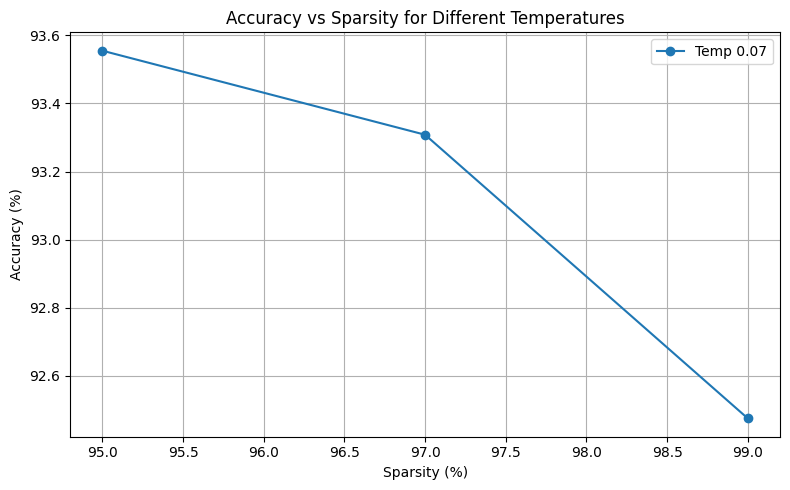

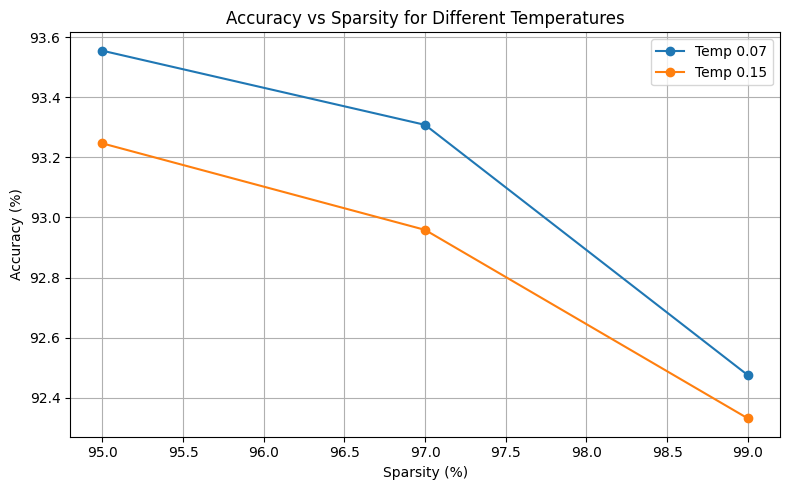

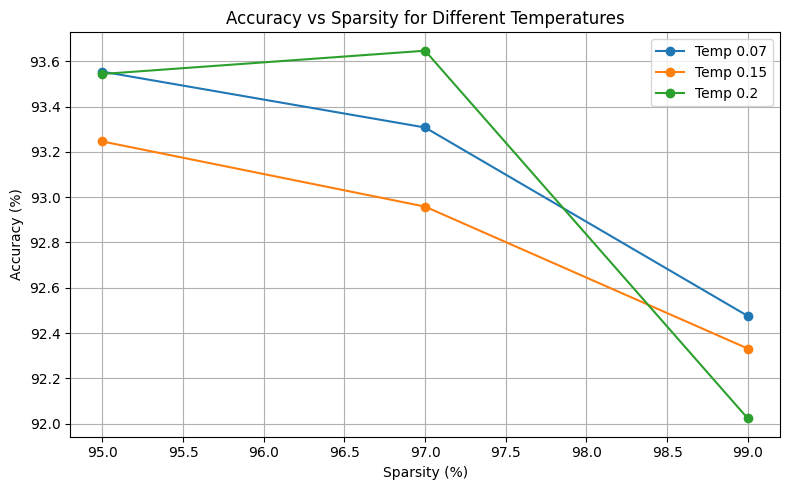

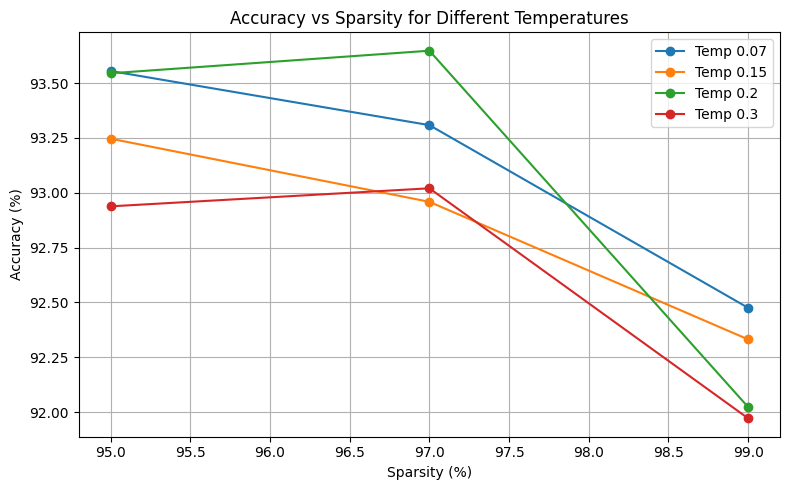

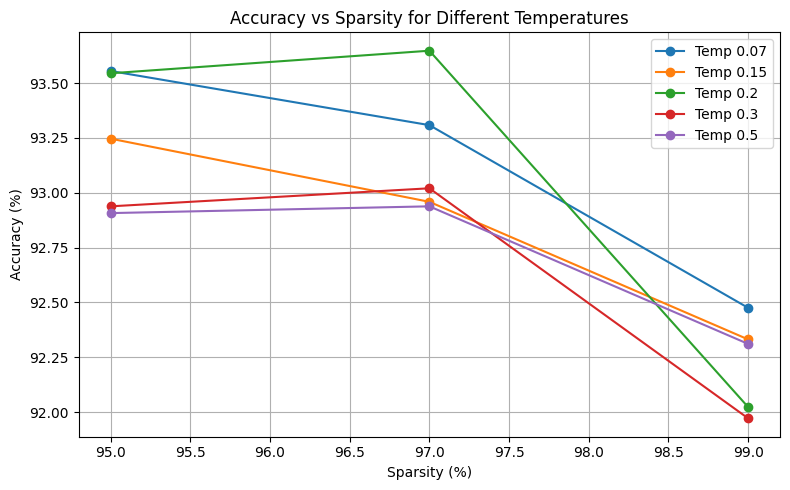

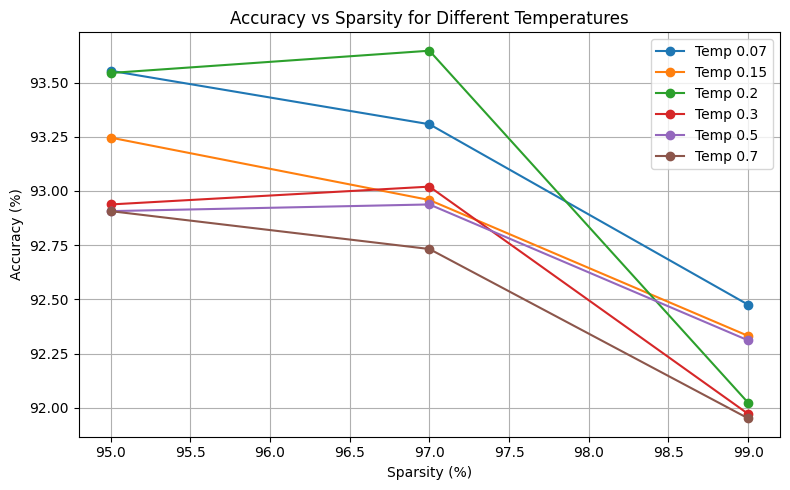

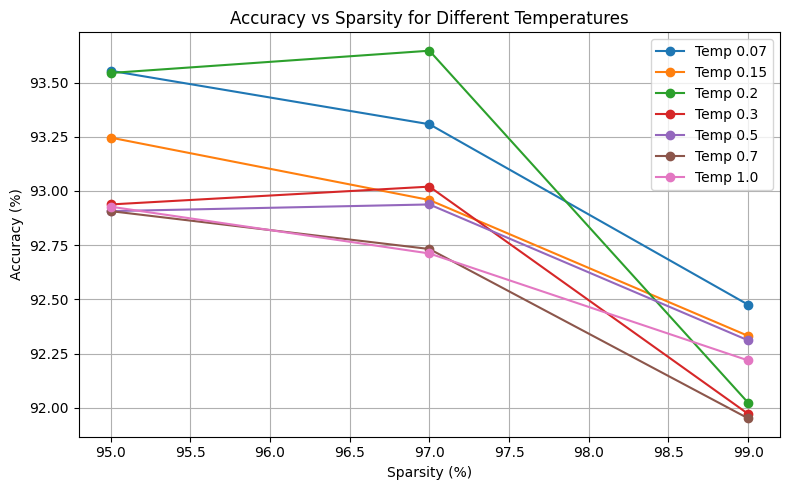

In [16]:
all_metrics = [metrics1, metrics2, metrics3]
keys = list(metrics1.keys())
sparsities = [95, 97, 99]
main_accuracies = {}
for k in keys:
    if k not in main_accuracies:
        main_accuracies[k] = []
    for m in all_metrics:
        main_accuracies[k].append(m[k]['accuracy'])

    # Plotting
    plt.figure(figsize=(8, 5))
    for k, acc_list in main_accuracies.items():
        plt.plot(sparsities, acc_list, marker='o', label=f"Temp {k}")

    plt.xlabel('Sparsity (%)')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy vs Sparsity for Different Temperatures')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
